<a href="https://www.kaggle.com/code/zulqarnain11/facial-emotion-recognition-using-transfer-learning?scriptVersionId=267019120" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

#Facial Emotion Recognition using Transfer Learning (MobileNetV2)

## 🏷️ Description

This notebook uses Transfer Learning with MobileNetV2 to recognize facial emotions from images.
The model is fine-tuned on a custom dataset and achieves high accuracy by leveraging pretrained ImageNet features.

## 🧩 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
tf.get_logger().setLevel('ERROR')



/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:86: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


## 🖼️ 2: Load Dataset

In [2]:
IMAGE_SIZE = 96
BATCH_SIZE = 32
DATASET_DIR = '/kaggle/input/facial-emotion-recognition-dataset/processed_data'

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names
n_classes = len(class_names)
print("Classes:", class_names)


Found 49779 files belonging to 7 classes.


Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


2025-10-10 09:32:39.318763: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## 🔀 3: Split Dataset into Train, Validation, and Test Sets

In [3]:
dataset_size = len(list(dataset))
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)

train_ds = dataset.take(train_size)
remaining = dataset.skip(train_size)
val_ds = remaining.take(val_size)
test_ds = remaining.skip(val_size)

print("Train batches:", len(train_ds))
print("Validation batches:", len(val_ds))
print("Test batches:", len(test_ds))



Train batches: 1244
Validation batches: 155
Test batches: 157


##⚙️ 4: Optimize Dataset Pipeline

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


##🎨 5: Data Augmentation



In [5]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])


## 🧠 6: Build Transfer Learning Model (MobileNetV2)



In [6]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = tf.keras.Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(n_classes, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

model.summary()



      0/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step

6299648/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_96             │ (None, 3, 3, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

## 🚀 7: Train the Model


In [7]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=callbacks
)


Epoch 1/20


   1/1244 ━━━━━━━━━━━━━━━━━━━━ 1:24:03 4s/step - accuracy: 0.2188 - loss: 2.5397

   3/1244 ━━━━━━━━━━━━━━━━━━━━ 1:29 72ms/step - accuracy: 0.1927 - loss: 2.6013 

   5/1244 ━━━━━━━━━━━━━━━━━━━━ 1:14 60ms/step - accuracy: 0.1919 - loss: 2.5889

   7/1244 ━━━━━━━━━━━━━━━━━━━━ 1:09 56ms/step - accuracy: 0.1900 - loss: 2.5837

   9/1244 ━━━━━━━━━━━━━━━━━━━━ 1:06 54ms/step - accuracy: 0.1914 - loss: 2.5657

  11/1244 ━━━━━━━━━━━━━━━━━━━━ 1:04 52ms/step - accuracy: 0.1942 - loss: 2.5357

  13/1244 ━━━━━━━━━━━━━━━━━━━━ 1:03 52ms/step - accuracy: 0.1960 - loss: 2.5089

  15/1244 ━━━━━━━━━━━━━━━━━━━━ 1:02 51ms/step - accuracy: 0.2001 - loss: 2.4801

  17/1244 ━━━━━━━━━━━━━━━━━━━━ 1:02 51ms/step - accuracy: 0.2039 - loss: 2.4518

  19/1244 ━━━━━━━━━━━━━━━━━━━━ 1:01 50ms/step - accuracy: 0.2075 - loss: 2.4251

  21/1244 ━━━━━━━━━━━━━━━━━━━━ 1:00 49ms/step - accuracy: 0.2118 - loss: 2.4003

  23/1244 ━━━━━━━━━━━━━━━━━━━━ 59s 49ms/step - accuracy: 0.2167 - loss: 2.3763 

  25/1244 ━━━━━━━━━━━━━━━━━━━━ 59s 49ms/step - accuracy: 0.2214 - loss: 2.3531

  27/1244 ━━━━━━━━━━━━━━━━━━━━ 58s 48ms/step - accuracy: 0.2253 - loss: 2.3321

  29/1244 ━━━━━━━━━━━━━━━━━━━━ 58s 48ms/step - accuracy: 0.2287 - loss: 2.3123

  31/1244 ━━━━━━━━━━━━━━━━━━━━ 58s 48ms/step - accuracy: 0.2321 - loss: 2.2940

  33/1244 ━━━━━━━━━━━━━━━━━━━━ 57s 48ms/step - accuracy: 0.2350 - loss: 2.2775

  35/1244 ━━━━━━━━━━━━━━━━━━━━ 57s 48ms/step - accuracy: 0.2378 - loss: 2.2619

  37/1244 ━━━━━━━━━━━━━━━━━━━━ 57s 48ms/step - accuracy: 0.2403 - loss: 2.2471

  39/1244 ━━━━━━━━━━━━━━━━━━━━ 57s 48ms/step - accuracy: 0.2427 - loss: 2.2331

  41/1244 ━━━━━━━━━━━━━━━━━━━━ 57s 47ms/step - accuracy: 0.2449 - loss: 2.2204

  43/1244 ━━━━━━━━━━━━━━━━━━━━ 56s 47ms/step - accuracy: 0.2473 - loss: 2.2079

  45/1244 ━━━━━━━━━━━━━━━━━━━━ 56s 47ms/step - accuracy: 0.2497 - loss: 2.1959

  47/1244 ━━━━━━━━━━━━━━━━━━━━ 56s 47ms/step - accuracy: 0.2520 - loss: 2.1844

  49/1244 ━━━━━━━━━━━━━━━━━━━━ 56s 47ms/step - accuracy: 0.2543 - loss: 2.1736

  51/1244 ━━━━━━━━━━━━━━━━━━━━ 56s 47ms/step - accuracy: 0.2565 - loss: 2.1634

  53/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 47ms/step - accuracy: 0.2586 - loss: 2.1537

  55/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 47ms/step - accuracy: 0.2605 - loss: 2.1446

  56/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 47ms/step - accuracy: 0.2615 - loss: 2.1402

  58/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 47ms/step - accuracy: 0.2632 - loss: 2.1318

  60/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 47ms/step - accuracy: 0.2649 - loss: 2.1237

  62/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 47ms/step - accuracy: 0.2665 - loss: 2.1158

  64/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 47ms/step - accuracy: 0.2680 - loss: 2.1083

  66/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 47ms/step - accuracy: 0.2694 - loss: 2.1012

  68/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 47ms/step - accuracy: 0.2707 - loss: 2.0944

  70/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 47ms/step - accuracy: 0.2721 - loss: 2.0877

  71/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 47ms/step - accuracy: 0.2727 - loss: 2.0843

  73/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 47ms/step - accuracy: 0.2739 - loss: 2.0779

  75/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 47ms/step - accuracy: 0.2752 - loss: 2.0716

  77/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 47ms/step - accuracy: 0.2764 - loss: 2.0654

  79/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 47ms/step - accuracy: 0.2776 - loss: 2.0594

  81/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 47ms/step - accuracy: 0.2789 - loss: 2.0534

  82/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 47ms/step - accuracy: 0.2795 - loss: 2.0506

  83/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 47ms/step - accuracy: 0.2801 - loss: 2.0478

  85/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 47ms/step - accuracy: 0.2812 - loss: 2.0423

  87/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 47ms/step - accuracy: 0.2824 - loss: 2.0369

  88/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 47ms/step - accuracy: 0.2829 - loss: 2.0343

  90/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 47ms/step - accuracy: 0.2841 - loss: 2.0292

  91/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 47ms/step - accuracy: 0.2846 - loss: 2.0268

  93/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 47ms/step - accuracy: 0.2857 - loss: 2.0220

  95/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 47ms/step - accuracy: 0.2868 - loss: 2.0173

  97/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 47ms/step - accuracy: 0.2878 - loss: 2.0129

  99/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 47ms/step - accuracy: 0.2888 - loss: 2.0086

 100/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 47ms/step - accuracy: 0.2893 - loss: 2.0065

 102/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 47ms/step - accuracy: 0.2901 - loss: 2.0025

 104/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 47ms/step - accuracy: 0.2910 - loss: 1.9986

 106/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 47ms/step - accuracy: 0.2918 - loss: 1.9948

 108/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 47ms/step - accuracy: 0.2926 - loss: 1.9911

 110/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 47ms/step - accuracy: 0.2934 - loss: 1.9874

 112/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 47ms/step - accuracy: 0.2941 - loss: 1.9838

 114/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 47ms/step - accuracy: 0.2949 - loss: 1.9803

 116/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 46ms/step - accuracy: 0.2956 - loss: 1.9769

 118/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 46ms/step - accuracy: 0.2964 - loss: 1.9735

 120/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 46ms/step - accuracy: 0.2971 - loss: 1.9702

 122/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 46ms/step - accuracy: 0.2978 - loss: 1.9669

 124/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 46ms/step - accuracy: 0.2985 - loss: 1.9637

 126/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 46ms/step - accuracy: 0.2991 - loss: 1.9607

 128/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 46ms/step - accuracy: 0.2998 - loss: 1.9577

 130/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 46ms/step - accuracy: 0.3004 - loss: 1.9548

 132/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 46ms/step - accuracy: 0.3010 - loss: 1.9519

 134/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 46ms/step - accuracy: 0.3016 - loss: 1.9490

 136/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 46ms/step - accuracy: 0.3022 - loss: 1.9462

 138/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 46ms/step - accuracy: 0.3028 - loss: 1.9434

 140/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 46ms/step - accuracy: 0.3034 - loss: 1.9407

 142/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 46ms/step - accuracy: 0.3039 - loss: 1.9381

 144/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 46ms/step - accuracy: 0.3045 - loss: 1.9355

 146/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 46ms/step - accuracy: 0.3050 - loss: 1.9330

 148/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 46ms/step - accuracy: 0.3055 - loss: 1.9305

 150/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 46ms/step - accuracy: 0.3060 - loss: 1.9281

 152/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 46ms/step - accuracy: 0.3065 - loss: 1.9257

 154/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 46ms/step - accuracy: 0.3070 - loss: 1.9233

 156/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 46ms/step - accuracy: 0.3075 - loss: 1.9210

 158/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 46ms/step - accuracy: 0.3080 - loss: 1.9187

 160/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 46ms/step - accuracy: 0.3085 - loss: 1.9165

 162/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 46ms/step - accuracy: 0.3090 - loss: 1.9143

 164/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 46ms/step - accuracy: 0.3095 - loss: 1.9121

 166/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 46ms/step - accuracy: 0.3100 - loss: 1.9100

 168/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 46ms/step - accuracy: 0.3104 - loss: 1.9080

 170/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 46ms/step - accuracy: 0.3108 - loss: 1.9060

 172/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 46ms/step - accuracy: 0.3112 - loss: 1.9040

 174/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 46ms/step - accuracy: 0.3116 - loss: 1.9021

 176/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 46ms/step - accuracy: 0.3120 - loss: 1.9002

 178/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 46ms/step - accuracy: 0.3123 - loss: 1.8984

 180/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 46ms/step - accuracy: 0.3127 - loss: 1.8966

 182/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 46ms/step - accuracy: 0.3131 - loss: 1.8947

 184/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 46ms/step - accuracy: 0.3135 - loss: 1.8929

 186/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 46ms/step - accuracy: 0.3138 - loss: 1.8911

 188/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 46ms/step - accuracy: 0.3142 - loss: 1.8894

 190/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 46ms/step - accuracy: 0.3145 - loss: 1.8876

 192/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 46ms/step - accuracy: 0.3149 - loss: 1.8859

 194/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 46ms/step - accuracy: 0.3152 - loss: 1.8842

 196/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 46ms/step - accuracy: 0.3155 - loss: 1.8826

 198/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 46ms/step - accuracy: 0.3158 - loss: 1.8809

 200/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 46ms/step - accuracy: 0.3162 - loss: 1.8793

 202/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 46ms/step - accuracy: 0.3165 - loss: 1.8777

 204/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 46ms/step - accuracy: 0.3168 - loss: 1.8762

 206/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 46ms/step - accuracy: 0.3171 - loss: 1.8746

 208/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 46ms/step - accuracy: 0.3174 - loss: 1.8731

 210/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 46ms/step - accuracy: 0.3177 - loss: 1.8716

 212/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 46ms/step - accuracy: 0.3180 - loss: 1.8701

 214/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 46ms/step - accuracy: 0.3183 - loss: 1.8687

 216/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 46ms/step - accuracy: 0.3186 - loss: 1.8672

 218/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 46ms/step - accuracy: 0.3189 - loss: 1.8658

 220/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 46ms/step - accuracy: 0.3192 - loss: 1.8644

 222/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 46ms/step - accuracy: 0.3194 - loss: 1.8630

 223/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 46ms/step - accuracy: 0.3196 - loss: 1.8623

 225/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 46ms/step - accuracy: 0.3198 - loss: 1.8609

 227/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.3201 - loss: 1.8596

 229/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.3204 - loss: 1.8582

 231/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.3206 - loss: 1.8569

 233/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.3209 - loss: 1.8555

 235/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.3211 - loss: 1.8543

 237/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.3214 - loss: 1.8530

 239/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.3216 - loss: 1.8517

 241/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.3219 - loss: 1.8504

 243/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.3221 - loss: 1.8492

 245/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.3224 - loss: 1.8479

 247/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.3226 - loss: 1.8467

 249/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.3229 - loss: 1.8455

 251/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.3231 - loss: 1.8443

 253/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.3234 - loss: 1.8431

 255/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.3236 - loss: 1.8419

 257/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.3238 - loss: 1.8407

 259/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.3241 - loss: 1.8396

 261/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.3243 - loss: 1.8384

 263/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.3245 - loss: 1.8373

 265/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.3247 - loss: 1.8362

 267/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.3249 - loss: 1.8350

 269/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.3252 - loss: 1.8340

 271/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.3254 - loss: 1.8329

 273/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.3256 - loss: 1.8318

 275/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.3258 - loss: 1.8307

 277/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.3260 - loss: 1.8296

 279/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.3262 - loss: 1.8286

 281/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.3264 - loss: 1.8275

 283/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.3267 - loss: 1.8265

 285/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.3269 - loss: 1.8255

 286/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.3270 - loss: 1.8250

 288/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.3272 - loss: 1.8239

 290/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.3274 - loss: 1.8229

 292/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.3276 - loss: 1.8219

 294/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.3278 - loss: 1.8209

 296/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.3280 - loss: 1.8200

 298/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.3282 - loss: 1.8190

 300/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.3284 - loss: 1.8180

 302/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.3286 - loss: 1.8171

 304/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.3288 - loss: 1.8161

 306/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.3290 - loss: 1.8152

 308/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.3292 - loss: 1.8142

 310/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.3294 - loss: 1.8133

 312/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.3296 - loss: 1.8123

 314/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.3298 - loss: 1.8114

 316/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.3300 - loss: 1.8105

 318/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.3302 - loss: 1.8096

 320/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.3304 - loss: 1.8087

 322/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.3305 - loss: 1.8078

 324/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.3307 - loss: 1.8070

 326/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.3309 - loss: 1.8061

 328/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.3311 - loss: 1.8052

 330/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.3313 - loss: 1.8044

 332/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.3314 - loss: 1.8036

 334/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.3316 - loss: 1.8027

 336/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.3318 - loss: 1.8019

 338/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.3320 - loss: 1.8011

 340/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.3321 - loss: 1.8003

 342/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.3323 - loss: 1.7994

 344/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.3325 - loss: 1.7986

 346/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.3326 - loss: 1.7978

 348/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.3328 - loss: 1.7970

 350/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.3330 - loss: 1.7962

 352/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.3331 - loss: 1.7954

 354/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.3333 - loss: 1.7947

 356/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.3335 - loss: 1.7939

 358/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.3336 - loss: 1.7931

 360/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.3338 - loss: 1.7923

 362/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.3340 - loss: 1.7916

 364/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.3341 - loss: 1.7908

 366/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.3343 - loss: 1.7901

 368/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.3344 - loss: 1.7893

 370/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.3346 - loss: 1.7886

 372/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.3347 - loss: 1.7879

 374/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.3349 - loss: 1.7871

 376/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.3350 - loss: 1.7864

 378/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.3352 - loss: 1.7857

 380/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.3353 - loss: 1.7850

 382/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.3355 - loss: 1.7843

 384/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.3357 - loss: 1.7836

 386/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.3358 - loss: 1.7829

 388/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.3360 - loss: 1.7822

 390/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.3361 - loss: 1.7815

 392/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.3363 - loss: 1.7808

 394/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.3364 - loss: 1.7801

 396/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.3366 - loss: 1.7794

 398/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.3367 - loss: 1.7787

 400/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.3369 - loss: 1.7780

 402/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.3370 - loss: 1.7774

 404/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.3372 - loss: 1.7767

 406/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.3373 - loss: 1.7760

 408/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.3375 - loss: 1.7754

 410/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.3376 - loss: 1.7747

 412/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.3378 - loss: 1.7741

 414/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.3379 - loss: 1.7734

 416/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.3381 - loss: 1.7728

 418/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.3382 - loss: 1.7722

 420/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.3384 - loss: 1.7715

 422/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.3385 - loss: 1.7709

 424/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.3386 - loss: 1.7703

 426/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.3388 - loss: 1.7697

 428/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.3389 - loss: 1.7690

 430/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.3390 - loss: 1.7684

 432/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.3392 - loss: 1.7678

 434/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.3393 - loss: 1.7672

 436/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.3394 - loss: 1.7666

 438/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.3396 - loss: 1.7660

 440/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.3397 - loss: 1.7654

 442/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.3398 - loss: 1.7648

 444/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.3400 - loss: 1.7643

 446/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.3401 - loss: 1.7637

 448/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.3402 - loss: 1.7631

 450/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.3403 - loss: 1.7626

 452/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.3405 - loss: 1.7620

 454/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.3406 - loss: 1.7614

 456/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.3407 - loss: 1.7609

 458/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.3408 - loss: 1.7603

 460/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.3409 - loss: 1.7598

 462/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.3410 - loss: 1.7592

 464/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.3412 - loss: 1.7587

 466/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.3413 - loss: 1.7581

 468/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.3414 - loss: 1.7576

 470/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.3415 - loss: 1.7571

 472/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.3416 - loss: 1.7566

 474/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.3417 - loss: 1.7560

 476/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.3418 - loss: 1.7555

 478/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.3419 - loss: 1.7550

 480/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.3421 - loss: 1.7545

 482/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.3422 - loss: 1.7540

 484/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.3423 - loss: 1.7534

 486/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.3424 - loss: 1.7529

 488/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.3425 - loss: 1.7524

 490/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.3426 - loss: 1.7519

 492/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.3427 - loss: 1.7514

 494/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.3428 - loss: 1.7509

 496/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.3429 - loss: 1.7504

 498/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.3430 - loss: 1.7499

 500/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.3431 - loss: 1.7494

 502/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.3432 - loss: 1.7490

 504/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.3433 - loss: 1.7485

 505/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.3434 - loss: 1.7482

 507/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.3435 - loss: 1.7478

 509/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.3436 - loss: 1.7473

 511/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.3437 - loss: 1.7468

 513/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.3438 - loss: 1.7464

 515/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.3439 - loss: 1.7459

 517/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.3440 - loss: 1.7454

 519/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.3441 - loss: 1.7450

 521/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.3442 - loss: 1.7445

 523/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.3443 - loss: 1.7441

 525/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.3444 - loss: 1.7436

 527/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.3445 - loss: 1.7431

 529/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.3446 - loss: 1.7427

 531/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.3447 - loss: 1.7422

 533/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.3448 - loss: 1.7418

 535/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.3449 - loss: 1.7413

 537/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.3450 - loss: 1.7409

 539/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.3451 - loss: 1.7405

 541/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.3452 - loss: 1.7400

 543/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.3453 - loss: 1.7396

 545/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.3454 - loss: 1.7392

 547/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.3455 - loss: 1.7387

 549/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.3456 - loss: 1.7383

 551/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.3457 - loss: 1.7379

 553/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.3458 - loss: 1.7374

 555/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.3459 - loss: 1.7370

 557/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.3460 - loss: 1.7366

 559/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.3461 - loss: 1.7361

 561/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.3462 - loss: 1.7357

 563/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.3463 - loss: 1.7353

 565/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.3464 - loss: 1.7348

 567/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.3465 - loss: 1.7344

 569/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.3466 - loss: 1.7340

 571/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.3467 - loss: 1.7336

 573/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.3468 - loss: 1.7331

 575/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.3468 - loss: 1.7327

 577/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.3469 - loss: 1.7323

 579/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.3471 - loss: 1.7319

 581/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.3472 - loss: 1.7315

 583/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.3473 - loss: 1.7310

 585/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.3474 - loss: 1.7306

 587/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.3475 - loss: 1.7302

 589/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.3476 - loss: 1.7298

 591/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.3477 - loss: 1.7294

 593/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.3478 - loss: 1.7290

 595/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.3479 - loss: 1.7286

 597/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.3480 - loss: 1.7282

 599/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.3481 - loss: 1.7277

 601/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.3482 - loss: 1.7273

 603/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.3483 - loss: 1.7269

 605/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.3484 - loss: 1.7265

 607/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.3484 - loss: 1.7261

 609/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.3485 - loss: 1.7257

 611/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.3486 - loss: 1.7253

 613/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.3487 - loss: 1.7249

 615/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.3488 - loss: 1.7245

 617/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.3489 - loss: 1.7242

 619/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.3490 - loss: 1.7238

 621/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.3491 - loss: 1.7234

 623/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.3492 - loss: 1.7230

 625/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.3493 - loss: 1.7226

 627/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.3494 - loss: 1.7222

 629/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.3495 - loss: 1.7218

 631/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.3496 - loss: 1.7215

 633/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.3497 - loss: 1.7211

 635/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.3498 - loss: 1.7207

 637/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.3499 - loss: 1.7203

 639/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.3500 - loss: 1.7199

 641/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.3501 - loss: 1.7196

 643/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.3501 - loss: 1.7192

 645/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.3502 - loss: 1.7188

 646/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.3503 - loss: 1.7186

 648/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.3504 - loss: 1.7183

 650/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.3505 - loss: 1.7179

 652/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.3506 - loss: 1.7175

 654/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.3506 - loss: 1.7172

 656/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.3507 - loss: 1.7168

 658/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.3508 - loss: 1.7164

 660/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.3509 - loss: 1.7161

 662/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.3510 - loss: 1.7157

 664/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.3511 - loss: 1.7154

 666/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.3512 - loss: 1.7150

 668/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.3513 - loss: 1.7147

 670/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.3514 - loss: 1.7143

 672/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.3515 - loss: 1.7139

 673/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.3515 - loss: 1.7138

 675/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.3516 - loss: 1.7134

 677/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.3517 - loss: 1.7131

 679/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.3518 - loss: 1.7127

 681/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.3518 - loss: 1.7124

 683/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.3519 - loss: 1.7120

 685/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.3520 - loss: 1.7117

 687/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.3521 - loss: 1.7113

 689/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.3522 - loss: 1.7110

 691/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.3523 - loss: 1.7106

 693/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.3524 - loss: 1.7103

 695/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.3524 - loss: 1.7100

 697/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.3525 - loss: 1.7096

 699/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.3526 - loss: 1.7093

 701/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.3527 - loss: 1.7089

 703/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.3528 - loss: 1.7086

 705/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.3529 - loss: 1.7083

 707/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.3530 - loss: 1.7079

 709/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.3530 - loss: 1.7076

 711/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.3531 - loss: 1.7073

 713/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.3532 - loss: 1.7070

 715/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.3533 - loss: 1.7066

 717/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.3534 - loss: 1.7063

 719/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.3535 - loss: 1.7060

 721/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.3535 - loss: 1.7057

 723/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.3536 - loss: 1.7053

 725/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.3537 - loss: 1.7050

 727/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.3538 - loss: 1.7047

 729/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.3539 - loss: 1.7044

 731/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.3539 - loss: 1.7041

 733/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.3540 - loss: 1.7037

 735/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.3541 - loss: 1.7034

 737/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.3542 - loss: 1.7031

 739/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.3543 - loss: 1.7028

 741/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.3543 - loss: 1.7025

 743/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.3544 - loss: 1.7022

 745/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.3545 - loss: 1.7019

 747/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.3546 - loss: 1.7016

 749/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.3547 - loss: 1.7012

 751/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.3547 - loss: 1.7009

 753/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.3548 - loss: 1.7006

 755/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.3549 - loss: 1.7003

 757/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.3550 - loss: 1.7000

 759/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.3551 - loss: 1.6997

 761/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.3551 - loss: 1.6994

 763/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.3552 - loss: 1.6991

 765/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.3553 - loss: 1.6988

 767/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.3554 - loss: 1.6985

 769/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.3554 - loss: 1.6982

 771/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.3555 - loss: 1.6979

 773/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.3556 - loss: 1.6976

 775/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.3557 - loss: 1.6973

 777/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.3557 - loss: 1.6970

 779/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.3558 - loss: 1.6968

 781/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.3559 - loss: 1.6965

 783/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.3560 - loss: 1.6962

 785/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.3560 - loss: 1.6959

 787/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.3561 - loss: 1.6956

 789/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.3562 - loss: 1.6953

 791/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.3563 - loss: 1.6950

 793/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.3563 - loss: 1.6948

 795/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.3564 - loss: 1.6945

 797/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.3565 - loss: 1.6942

 798/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.3565 - loss: 1.6941

 800/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.3566 - loss: 1.6938

 802/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.3567 - loss: 1.6935

 804/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.3567 - loss: 1.6932

 806/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.3568 - loss: 1.6930

 808/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.3569 - loss: 1.6927

 810/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.3570 - loss: 1.6924

 812/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.3570 - loss: 1.6921

 814/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.3571 - loss: 1.6919

 816/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.3572 - loss: 1.6916

 818/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.3573 - loss: 1.6913

 820/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.3573 - loss: 1.6910

 822/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.3574 - loss: 1.6908

 824/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.3575 - loss: 1.6905

 826/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.3576 - loss: 1.6902

 828/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.3576 - loss: 1.6900

 830/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.3577 - loss: 1.6897

 832/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.3578 - loss: 1.6894

 834/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.3578 - loss: 1.6892

 836/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.3579 - loss: 1.6889

 838/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.3580 - loss: 1.6886

 840/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.3580 - loss: 1.6884

 842/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.3581 - loss: 1.6881

 844/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.3582 - loss: 1.6879

 846/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.3583 - loss: 1.6876

 848/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.3583 - loss: 1.6873

 850/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.3584 - loss: 1.6871

 852/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.3585 - loss: 1.6868

 854/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.3585 - loss: 1.6866

 856/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.3586 - loss: 1.6863

 858/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.3587 - loss: 1.6861

 860/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.3587 - loss: 1.6858

 862/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.3588 - loss: 1.6856

 864/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.3589 - loss: 1.6853

 866/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.3589 - loss: 1.6851

 868/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.3590 - loss: 1.6848

 870/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.3591 - loss: 1.6846

 872/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.3591 - loss: 1.6843

 874/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.3592 - loss: 1.6841

 876/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.3593 - loss: 1.6838

 878/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.3593 - loss: 1.6836

 880/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.3594 - loss: 1.6833

 882/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.3595 - loss: 1.6831

 884/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.3595 - loss: 1.6828

 886/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.3596 - loss: 1.6826

 888/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.3597 - loss: 1.6824

 890/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.3597 - loss: 1.6821

 892/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.3598 - loss: 1.6819

 894/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.3599 - loss: 1.6817

 896/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.3599 - loss: 1.6814

 898/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.3600 - loss: 1.6812

 900/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.3601 - loss: 1.6810

 902/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.3601 - loss: 1.6807

 904/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.3602 - loss: 1.6805

 906/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.3603 - loss: 1.6803

 908/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.3603 - loss: 1.6800

 910/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.3604 - loss: 1.6798

 912/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.3604 - loss: 1.6796

 914/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.3605 - loss: 1.6793

 916/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.3606 - loss: 1.6791

 918/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.3606 - loss: 1.6789

 920/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.3607 - loss: 1.6787

 922/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.3608 - loss: 1.6784

 924/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.3608 - loss: 1.6782

 926/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.3609 - loss: 1.6780

 928/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.3609 - loss: 1.6778

 930/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.3610 - loss: 1.6775

 932/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.3611 - loss: 1.6773

 934/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.3611 - loss: 1.6771

 936/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.3612 - loss: 1.6769

 938/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.3612 - loss: 1.6766

 940/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.3613 - loss: 1.6764

 942/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.3614 - loss: 1.6762

 944/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.3614 - loss: 1.6760

 946/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.3615 - loss: 1.6758

 948/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.3615 - loss: 1.6755

 950/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.3616 - loss: 1.6753

 952/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.3617 - loss: 1.6751

 954/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.3617 - loss: 1.6749

 956/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.3618 - loss: 1.6747

 958/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.3618 - loss: 1.6745

 960/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.3619 - loss: 1.6742

 962/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.3620 - loss: 1.6740

 964/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.3620 - loss: 1.6738

 966/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.3621 - loss: 1.6736

 968/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.3621 - loss: 1.6734

 970/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.3622 - loss: 1.6732

 972/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.3623 - loss: 1.6730

 974/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.3623 - loss: 1.6727

 976/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.3624 - loss: 1.6725

 978/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.3624 - loss: 1.6723

 980/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.3625 - loss: 1.6721

 982/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.3626 - loss: 1.6719

 984/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.3626 - loss: 1.6717

 986/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.3627 - loss: 1.6715

 988/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.3627 - loss: 1.6713

 990/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.3628 - loss: 1.6711

 992/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.3629 - loss: 1.6708

 994/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.3629 - loss: 1.6706

 996/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.3630 - loss: 1.6704

 998/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.3630 - loss: 1.6702

1000/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.3631 - loss: 1.6700

1002/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.3632 - loss: 1.6698

1004/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.3632 - loss: 1.6696

1006/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.3633 - loss: 1.6694

1008/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.3633 - loss: 1.6692

1010/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.3634 - loss: 1.6690

1012/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.3634 - loss: 1.6688

1014/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.3635 - loss: 1.6686

1016/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.3636 - loss: 1.6684

1018/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.3636 - loss: 1.6682

1020/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.3637 - loss: 1.6680 

1022/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.3637 - loss: 1.6678

1024/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.3638 - loss: 1.6676

1026/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.3638 - loss: 1.6674

1028/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.3639 - loss: 1.6672

1030/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.3640 - loss: 1.6670

1032/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.3640 - loss: 1.6668

1034/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.3641 - loss: 1.6666

1036/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.3641 - loss: 1.6664

1038/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.3642 - loss: 1.6662

1040/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.3643 - loss: 1.6660

1042/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.3643 - loss: 1.6658

1044/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.3644 - loss: 1.6656

1046/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.3644 - loss: 1.6654

1048/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.3645 - loss: 1.6652

1050/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.3645 - loss: 1.6650

1052/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.3646 - loss: 1.6648

1054/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.3647 - loss: 1.6646

1056/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.3647 - loss: 1.6644

1058/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.3648 - loss: 1.6642

1060/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.3648 - loss: 1.6640

1062/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.3649 - loss: 1.6638

1064/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.3649 - loss: 1.6636

1066/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.3650 - loss: 1.6634

1068/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.3651 - loss: 1.6632

1070/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.3651 - loss: 1.6630

1072/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.3652 - loss: 1.6629

1074/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.3652 - loss: 1.6627

1076/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.3653 - loss: 1.6625

1078/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.3653 - loss: 1.6623

1080/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.3654 - loss: 1.6621

1082/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.3655 - loss: 1.6619

1084/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.3655 - loss: 1.6617

1086/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.3656 - loss: 1.6615

1088/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.3656 - loss: 1.6613

1090/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.3657 - loss: 1.6611

1092/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.3657 - loss: 1.6610

1094/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.3658 - loss: 1.6608

1096/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.3659 - loss: 1.6606

1098/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.3659 - loss: 1.6604

1100/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.3660 - loss: 1.6602

1102/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.3660 - loss: 1.6600

1104/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.3661 - loss: 1.6598

1106/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.3661 - loss: 1.6596

1108/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.3662 - loss: 1.6595

1110/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.3662 - loss: 1.6593

1112/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.3663 - loss: 1.6591

1114/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.3663 - loss: 1.6589

1116/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.3664 - loss: 1.6587

1118/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.3665 - loss: 1.6585

1120/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.3665 - loss: 1.6584

1122/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.3666 - loss: 1.6582

1124/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.3666 - loss: 1.6580

1126/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.3667 - loss: 1.6578

1128/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.3667 - loss: 1.6576

1130/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.3668 - loss: 1.6575

1132/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.3668 - loss: 1.6573

1134/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.3669 - loss: 1.6571

1136/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.3669 - loss: 1.6569

1138/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.3670 - loss: 1.6567

1140/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.3670 - loss: 1.6566

1142/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.3671 - loss: 1.6564

1144/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.3672 - loss: 1.6562

1146/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.3672 - loss: 1.6560

1148/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.3673 - loss: 1.6559

1150/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.3673 - loss: 1.6557

1151/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.3673 - loss: 1.6556

1153/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.3674 - loss: 1.6554

1155/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.3675 - loss: 1.6552

1157/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.3675 - loss: 1.6551

1159/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.3676 - loss: 1.6549

1161/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.3676 - loss: 1.6547

1163/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.3677 - loss: 1.6545

1165/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.3677 - loss: 1.6544

1167/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.3678 - loss: 1.6542

1169/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.3678 - loss: 1.6540

1171/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.3679 - loss: 1.6538

1173/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.3679 - loss: 1.6537

1175/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.3680 - loss: 1.6535

1177/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.3680 - loss: 1.6533

1179/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.3681 - loss: 1.6532

1181/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.3681 - loss: 1.6530

1183/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.3682 - loss: 1.6528

1185/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.3682 - loss: 1.6527

1187/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.3683 - loss: 1.6525

1189/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.3683 - loss: 1.6523

1191/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.3684 - loss: 1.6521

1193/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.3684 - loss: 1.6520

1195/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.3685 - loss: 1.6518

1197/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.3685 - loss: 1.6516

1199/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.3686 - loss: 1.6515

1201/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.3686 - loss: 1.6513

1203/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.3687 - loss: 1.6511

1205/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.3687 - loss: 1.6510

1207/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.3688 - loss: 1.6508

1209/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.3688 - loss: 1.6507

1211/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.3689 - loss: 1.6505

1213/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.3689 - loss: 1.6503

1215/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.3690 - loss: 1.6502

1217/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.3690 - loss: 1.6500

1219/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.3691 - loss: 1.6498

1221/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.3691 - loss: 1.6497

1223/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3692 - loss: 1.6495

1225/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3692 - loss: 1.6493

1227/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3693 - loss: 1.6492

1229/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3693 - loss: 1.6490

1231/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3694 - loss: 1.6489

1233/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3694 - loss: 1.6487

1235/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3695 - loss: 1.6485

1237/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3695 - loss: 1.6484

1239/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3696 - loss: 1.6482

1241/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3696 - loss: 1.6481

1243/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3696 - loss: 1.6479

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 68s 51ms/step - accuracy: 0.3994 - loss: 1.5486 - val_accuracy: 0.4187 - val_loss: 1.4937 - learning_rate: 0.0010


Epoch 2/20


   1/1244 ━━━━━━━━━━━━━━━━━━━━ 1:15 60ms/step - accuracy: 0.3125 - loss: 1.6315

   3/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 43ms/step - accuracy: 0.3281 - loss: 1.5554 

   5/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 43ms/step - accuracy: 0.3534 - loss: 1.5149

   7/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.3766 - loss: 1.4807

   9/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.3872 - loss: 1.4697

  11/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.3966 - loss: 1.4634

  13/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4044 - loss: 1.4614

  15/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4095 - loss: 1.4594

  17/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4129 - loss: 1.4591

  19/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4152 - loss: 1.4582

  21/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4180 - loss: 1.4567

  23/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4197 - loss: 1.4561

  25/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4206 - loss: 1.4558

  27/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4208 - loss: 1.4559

  29/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4209 - loss: 1.4564

  31/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4209 - loss: 1.4568

  33/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4207 - loss: 1.4573

  35/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4205 - loss: 1.4577

  37/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4204 - loss: 1.4582

  39/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4204 - loss: 1.4586

  41/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4205 - loss: 1.4591

  43/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4204 - loss: 1.4598

  45/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4201 - loss: 1.4607

  47/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4202 - loss: 1.4613

  49/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4202 - loss: 1.4618

  51/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4203 - loss: 1.4622

  53/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4203 - loss: 1.4626

  54/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4204 - loss: 1.4627

  56/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4205 - loss: 1.4630

  58/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4207 - loss: 1.4633

  60/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4208 - loss: 1.4635

  62/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4210 - loss: 1.4636

  64/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4212 - loss: 1.4637

  66/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4214 - loss: 1.4638

  68/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4216 - loss: 1.4637

  70/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4218 - loss: 1.4635

  72/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4219 - loss: 1.4633

  74/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4222 - loss: 1.4629

  76/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4225 - loss: 1.4625

  78/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4228 - loss: 1.4622

  80/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4230 - loss: 1.4619

  82/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4233 - loss: 1.4616

  83/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4234 - loss: 1.4615

  85/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4236 - loss: 1.4613

  87/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4238 - loss: 1.4612

  89/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4240 - loss: 1.4610

  91/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4242 - loss: 1.4609

  93/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4245 - loss: 1.4607

  95/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4247 - loss: 1.4606

  97/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4249 - loss: 1.4606

  99/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4250 - loss: 1.4607

 101/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4252 - loss: 1.4607

 103/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4253 - loss: 1.4608

 105/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4254 - loss: 1.4610

 107/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4255 - loss: 1.4611

 109/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4255 - loss: 1.4612

 111/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4256 - loss: 1.4613

 113/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4256 - loss: 1.4615

 115/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4256 - loss: 1.4616

 117/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4257 - loss: 1.4617

 119/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4257 - loss: 1.4618

 121/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4258 - loss: 1.4619

 123/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4259 - loss: 1.4620

 125/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4259 - loss: 1.4620

 127/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4260 - loss: 1.4621

 129/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4260 - loss: 1.4621

 131/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4261 - loss: 1.4621

 133/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4262 - loss: 1.4621

 135/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4262 - loss: 1.4621

 137/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4263 - loss: 1.4621

 139/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4264 - loss: 1.4621

 141/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4264 - loss: 1.4621

 143/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4265 - loss: 1.4621

 145/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4265 - loss: 1.4621

 147/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4265 - loss: 1.4621

 149/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4266 - loss: 1.4621

 151/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4266 - loss: 1.4621

 153/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4266 - loss: 1.4621

 155/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4266 - loss: 1.4622

 157/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4266 - loss: 1.4622

 159/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4267 - loss: 1.4622

 161/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4267 - loss: 1.4622

 163/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4267 - loss: 1.4622

 165/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4267 - loss: 1.4622

 167/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4267 - loss: 1.4623

 169/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4267 - loss: 1.4623

 171/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4267 - loss: 1.4623

 173/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4268 - loss: 1.4623

 175/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4268 - loss: 1.4623

 177/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4268 - loss: 1.4622

 179/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4268 - loss: 1.4622

 181/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4269 - loss: 1.4622

 183/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4269 - loss: 1.4622

 185/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4269 - loss: 1.4622

 187/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4269 - loss: 1.4622

 189/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4269 - loss: 1.4622

 191/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4269 - loss: 1.4622

 193/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4269 - loss: 1.4622

 195/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4269 - loss: 1.4623

 197/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4269 - loss: 1.4622

 199/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4270 - loss: 1.4622

 201/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4270 - loss: 1.4622

 203/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4270 - loss: 1.4622

 205/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4270 - loss: 1.4622

 207/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4270 - loss: 1.4622

 209/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4270 - loss: 1.4622

 211/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4271 - loss: 1.4622

 213/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4271 - loss: 1.4622

 215/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4271 - loss: 1.4622

 217/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4271 - loss: 1.4622

 219/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4271 - loss: 1.4622

 221/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4272 - loss: 1.4622

 223/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4272 - loss: 1.4622

 225/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4272 - loss: 1.4621

 227/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4272 - loss: 1.4621

 229/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4272 - loss: 1.4621

 231/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4272 - loss: 1.4621

 232/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4272 - loss: 1.4621

 234/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4273 - loss: 1.4621

 236/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4273 - loss: 1.4621

 238/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4273 - loss: 1.4621

 240/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4273 - loss: 1.4621

 242/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4273 - loss: 1.4620

 244/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4274 - loss: 1.4620

 246/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4274 - loss: 1.4620

 248/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4274 - loss: 1.4620

 250/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4274 - loss: 1.4620

 252/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4274 - loss: 1.4619

 254/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4275 - loss: 1.4619

 255/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4275 - loss: 1.4619

 257/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4275 - loss: 1.4619

 259/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4275 - loss: 1.4619

 261/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4275 - loss: 1.4619

 263/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4275 - loss: 1.4618

 265/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4276 - loss: 1.4618

 267/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4276 - loss: 1.4618

 269/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4276 - loss: 1.4618

 271/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4276 - loss: 1.4618

 273/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4276 - loss: 1.4618

 275/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4276 - loss: 1.4618

 277/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4276 - loss: 1.4618

 279/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4276 - loss: 1.4618

 281/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4276 - loss: 1.4618

 283/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4276 - loss: 1.4619

 285/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4276 - loss: 1.4619

 287/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4276 - loss: 1.4619

 289/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4276 - loss: 1.4619

 291/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4276 - loss: 1.4619

 293/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4276 - loss: 1.4619

 295/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4276 - loss: 1.4619

 297/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4276 - loss: 1.4619

 299/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4276 - loss: 1.4619

 301/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4276 - loss: 1.4619

 303/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4276 - loss: 1.4619

 305/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4276 - loss: 1.4619

 307/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4276 - loss: 1.4619

 309/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4276 - loss: 1.4619

 311/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4276 - loss: 1.4619

 313/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4276 - loss: 1.4620

 315/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4276 - loss: 1.4620

 317/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4276 - loss: 1.4620

 319/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4276 - loss: 1.4620

 321/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4276 - loss: 1.4620

 323/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4276 - loss: 1.4620

 325/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4275 - loss: 1.4620

 327/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4275 - loss: 1.4621

 329/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4275 - loss: 1.4621

 331/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4275 - loss: 1.4621

 333/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4275 - loss: 1.4621

 335/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4275 - loss: 1.4622

 337/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4275 - loss: 1.4622

 339/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4275 - loss: 1.4622

 341/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4275 - loss: 1.4622

 343/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4275 - loss: 1.4623

 345/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4275 - loss: 1.4623

 347/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4275 - loss: 1.4623

 349/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4275 - loss: 1.4623

 351/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4274 - loss: 1.4624

 353/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4274 - loss: 1.4624

 355/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4274 - loss: 1.4624

 357/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4274 - loss: 1.4624

 359/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4274 - loss: 1.4625

 361/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4274 - loss: 1.4625

 363/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4274 - loss: 1.4625

 365/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4274 - loss: 1.4625

 367/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4274 - loss: 1.4626

 369/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4274 - loss: 1.4626

 371/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4273 - loss: 1.4626

 373/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4273 - loss: 1.4627

 375/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4273 - loss: 1.4627

 377/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4273 - loss: 1.4627

 379/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4273 - loss: 1.4627

 381/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4273 - loss: 1.4628

 383/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4273 - loss: 1.4628

 385/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4272 - loss: 1.4628

 387/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4272 - loss: 1.4628

 389/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4272 - loss: 1.4629

 391/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4272 - loss: 1.4629

 392/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4272 - loss: 1.4629

 394/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4272 - loss: 1.4629

 396/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4272 - loss: 1.4629

 398/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4271 - loss: 1.4630

 400/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4271 - loss: 1.4630

 401/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4271 - loss: 1.4630

 403/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4271 - loss: 1.4630

 405/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4271 - loss: 1.4631

 407/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4271 - loss: 1.4631

 409/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4271 - loss: 1.4631

 411/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4270 - loss: 1.4631

 413/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4270 - loss: 1.4632

 415/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4270 - loss: 1.4632

 417/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4270 - loss: 1.4632

 419/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4270 - loss: 1.4632

 421/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4270 - loss: 1.4633

 423/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4270 - loss: 1.4633

 425/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4269 - loss: 1.4633

 427/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4269 - loss: 1.4633

 429/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4269 - loss: 1.4634

 431/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4269 - loss: 1.4634

 433/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4269 - loss: 1.4634

 435/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4269 - loss: 1.4634

 437/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4268 - loss: 1.4635

 439/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4268 - loss: 1.4635

 441/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4268 - loss: 1.4635

 443/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4268 - loss: 1.4635

 445/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4268 - loss: 1.4636

 447/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4268 - loss: 1.4636

 449/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4268 - loss: 1.4636

 451/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4268 - loss: 1.4636

 453/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4268 - loss: 1.4636

 455/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4268 - loss: 1.4637

 457/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4268 - loss: 1.4637

 458/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4268 - loss: 1.4637

 460/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4268 - loss: 1.4637

 462/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4268 - loss: 1.4637

 464/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4268 - loss: 1.4637

 466/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4267 - loss: 1.4637

 468/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4267 - loss: 1.4637

 470/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4267 - loss: 1.4637

 472/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4267 - loss: 1.4637

 474/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4267 - loss: 1.4637

 476/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4267 - loss: 1.4637

 478/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4267 - loss: 1.4637

 480/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4267 - loss: 1.4637

 482/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4267 - loss: 1.4637

 484/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4267 - loss: 1.4637

 486/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4267 - loss: 1.4637

 488/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4267 - loss: 1.4637

 490/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4268 - loss: 1.4637

 492/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4268 - loss: 1.4637

 494/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4268 - loss: 1.4637

 496/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4268 - loss: 1.4637

 498/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4268 - loss: 1.4637

 500/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4268 - loss: 1.4637

 502/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4268 - loss: 1.4637

 504/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4268 - loss: 1.4637

 506/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4268 - loss: 1.4637

 508/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4268 - loss: 1.4637

 510/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4268 - loss: 1.4637

 512/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4268 - loss: 1.4637

 514/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4268 - loss: 1.4637

 515/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4268 - loss: 1.4637

 517/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4268 - loss: 1.4637

 519/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4268 - loss: 1.4637

 521/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4268 - loss: 1.4637

 523/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4268 - loss: 1.4637

 525/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4268 - loss: 1.4636

 527/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4268 - loss: 1.4636

 529/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4268 - loss: 1.4636

 531/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4268 - loss: 1.4636

 533/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4269 - loss: 1.4636

 535/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4269 - loss: 1.4636

 537/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4269 - loss: 1.4636

 539/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4269 - loss: 1.4636

 541/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4269 - loss: 1.4636

 543/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4269 - loss: 1.4636

 545/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4269 - loss: 1.4636

 547/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4269 - loss: 1.4636

 549/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4269 - loss: 1.4636

 551/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4269 - loss: 1.4636

 553/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4269 - loss: 1.4636

 555/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4269 - loss: 1.4636

 557/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4269 - loss: 1.4636

 559/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4269 - loss: 1.4635

 561/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4269 - loss: 1.4635

 563/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4269 - loss: 1.4635

 565/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4269 - loss: 1.4635

 567/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4269 - loss: 1.4635

 569/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4269 - loss: 1.4635

 571/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4269 - loss: 1.4635

 573/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4269 - loss: 1.4635

 575/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4269 - loss: 1.4635

 577/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4269 - loss: 1.4635

 579/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4270 - loss: 1.4634

 580/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4270 - loss: 1.4634

 582/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4270 - loss: 1.4634

 584/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4270 - loss: 1.4634

 586/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4270 - loss: 1.4634

 588/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4270 - loss: 1.4634

 590/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4270 - loss: 1.4634

 592/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4270 - loss: 1.4634

 594/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4270 - loss: 1.4633

 596/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4270 - loss: 1.4633

 598/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4270 - loss: 1.4633

 600/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4270 - loss: 1.4633

 602/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4270 - loss: 1.4633

 604/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4271 - loss: 1.4633

 606/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4271 - loss: 1.4632

 608/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4271 - loss: 1.4632

 610/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4271 - loss: 1.4632

 612/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4271 - loss: 1.4632

 614/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4271 - loss: 1.4632

 616/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4271 - loss: 1.4632

 618/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4271 - loss: 1.4631

 620/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4271 - loss: 1.4631

 622/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4271 - loss: 1.4631

 624/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4271 - loss: 1.4631

 626/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4271 - loss: 1.4631

 628/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4271 - loss: 1.4631

 630/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4271 - loss: 1.4631

 631/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4271 - loss: 1.4631

 633/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4271 - loss: 1.4630

 635/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4271 - loss: 1.4630

 637/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4272 - loss: 1.4630

 639/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4272 - loss: 1.4630

 641/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4272 - loss: 1.4630

 643/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4272 - loss: 1.4630

 645/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4272 - loss: 1.4630

 647/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4272 - loss: 1.4629

 649/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4272 - loss: 1.4629

 651/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4272 - loss: 1.4629

 653/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4272 - loss: 1.4629

 655/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4272 - loss: 1.4629

 656/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4272 - loss: 1.4629

 658/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4272 - loss: 1.4628

 660/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4272 - loss: 1.4628

 662/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4272 - loss: 1.4628

 664/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4272 - loss: 1.4628

 666/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4272 - loss: 1.4628

 668/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4273 - loss: 1.4627

 670/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4273 - loss: 1.4627

 672/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4273 - loss: 1.4627

 674/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4273 - loss: 1.4627

 676/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4273 - loss: 1.4627

 678/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4273 - loss: 1.4626

 680/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4273 - loss: 1.4626

 682/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4273 - loss: 1.4626

 684/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4273 - loss: 1.4626

 686/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4273 - loss: 1.4626

 688/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4273 - loss: 1.4625

 690/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4273 - loss: 1.4625

 692/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4273 - loss: 1.4625

 694/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4273 - loss: 1.4625

 696/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4274 - loss: 1.4624

 698/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4274 - loss: 1.4624

 700/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4274 - loss: 1.4624

 702/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4274 - loss: 1.4624

 704/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4274 - loss: 1.4624

 706/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4274 - loss: 1.4623

 708/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4274 - loss: 1.4623

 710/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4274 - loss: 1.4623

 712/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4274 - loss: 1.4623

 714/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4274 - loss: 1.4622

 716/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4274 - loss: 1.4622

 718/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4274 - loss: 1.4622

 720/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4275 - loss: 1.4622

 722/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4275 - loss: 1.4621

 724/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4275 - loss: 1.4621

 726/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4275 - loss: 1.4621

 728/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4275 - loss: 1.4621

 730/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4275 - loss: 1.4620

 732/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4275 - loss: 1.4620

 734/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4275 - loss: 1.4620

 736/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4275 - loss: 1.4620

 738/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4275 - loss: 1.4619

 740/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4276 - loss: 1.4619

 742/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4276 - loss: 1.4619

 744/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4276 - loss: 1.4619

 746/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4276 - loss: 1.4618

 748/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4276 - loss: 1.4618

 750/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4276 - loss: 1.4618

 752/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4276 - loss: 1.4618

 754/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4276 - loss: 1.4617

 756/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4276 - loss: 1.4617

 758/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4276 - loss: 1.4617

 760/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4277 - loss: 1.4617

 762/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4277 - loss: 1.4616

 764/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4277 - loss: 1.4616

 766/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4277 - loss: 1.4616

 768/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4277 - loss: 1.4616

 770/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4277 - loss: 1.4615

 772/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4277 - loss: 1.4615

 774/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4277 - loss: 1.4615

 776/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4277 - loss: 1.4615

 778/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4277 - loss: 1.4614

 780/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4277 - loss: 1.4614

 782/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4278 - loss: 1.4614

 784/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4278 - loss: 1.4614

 786/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4278 - loss: 1.4613

 788/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4278 - loss: 1.4613

 790/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4278 - loss: 1.4613

 792/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4278 - loss: 1.4613

 794/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4278 - loss: 1.4612

 796/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4278 - loss: 1.4612

 798/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4278 - loss: 1.4612

 800/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4278 - loss: 1.4612

 802/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4278 - loss: 1.4611

 804/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4278 - loss: 1.4611

 806/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4279 - loss: 1.4611

 808/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4279 - loss: 1.4611

 810/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4279 - loss: 1.4611

 812/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4279 - loss: 1.4610

 814/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4279 - loss: 1.4610

 816/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4279 - loss: 1.4610

 818/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4279 - loss: 1.4610

 820/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4279 - loss: 1.4609

 822/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4279 - loss: 1.4609

 824/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4279 - loss: 1.4609

 826/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4279 - loss: 1.4609

 828/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4280 - loss: 1.4608

 830/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4280 - loss: 1.4608

 832/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4280 - loss: 1.4608

 833/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4280 - loss: 1.4608

 835/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4280 - loss: 1.4608

 837/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4280 - loss: 1.4607

 838/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4280 - loss: 1.4607

 840/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4280 - loss: 1.4607

 842/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4280 - loss: 1.4607

 844/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4280 - loss: 1.4607

 846/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4280 - loss: 1.4606

 848/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4280 - loss: 1.4606

 849/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4280 - loss: 1.4606

 851/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4280 - loss: 1.4606

 853/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4280 - loss: 1.4606

 855/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4280 - loss: 1.4605

 857/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4281 - loss: 1.4605

 859/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4281 - loss: 1.4605

 861/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4281 - loss: 1.4605

 863/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4281 - loss: 1.4605

 865/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4281 - loss: 1.4604

 867/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4281 - loss: 1.4604

 869/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4281 - loss: 1.4604

 871/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4281 - loss: 1.4604

 873/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4281 - loss: 1.4603

 875/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4281 - loss: 1.4603

 877/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4281 - loss: 1.4603

 879/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4281 - loss: 1.4603

 881/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4281 - loss: 1.4603

 883/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4281 - loss: 1.4602

 885/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4281 - loss: 1.4602

 887/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4282 - loss: 1.4602

 889/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4282 - loss: 1.4602

 891/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4282 - loss: 1.4602

 893/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4282 - loss: 1.4601

 895/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4282 - loss: 1.4601

 897/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4282 - loss: 1.4601

 899/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4282 - loss: 1.4601

 901/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4282 - loss: 1.4601

 903/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4282 - loss: 1.4600

 905/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4282 - loss: 1.4600

 907/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4282 - loss: 1.4600

 909/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4282 - loss: 1.4600

 911/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4282 - loss: 1.4600

 913/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4282 - loss: 1.4600

 915/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4282 - loss: 1.4599

 916/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4282 - loss: 1.4599

 917/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4282 - loss: 1.4599

 919/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4283 - loss: 1.4599

 921/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4283 - loss: 1.4599

 923/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4283 - loss: 1.4599

 925/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4283 - loss: 1.4599

 927/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4283 - loss: 1.4598

 929/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4283 - loss: 1.4598

 931/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4283 - loss: 1.4598

 933/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4283 - loss: 1.4598

 935/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4283 - loss: 1.4598

 937/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4283 - loss: 1.4598

 939/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4283 - loss: 1.4598

 941/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4283 - loss: 1.4597

 943/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4283 - loss: 1.4597

 945/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4283 - loss: 1.4597

 947/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4283 - loss: 1.4597

 949/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4284 - loss: 1.4597

 951/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4284 - loss: 1.4597

 953/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4284 - loss: 1.4597

 955/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4284 - loss: 1.4596

 957/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4284 - loss: 1.4596

 959/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4284 - loss: 1.4596

 961/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4284 - loss: 1.4596

 963/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4284 - loss: 1.4596

 965/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4284 - loss: 1.4596

 967/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4284 - loss: 1.4596

 969/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4284 - loss: 1.4595

 971/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4284 - loss: 1.4595

 973/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4284 - loss: 1.4595

 975/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4284 - loss: 1.4595

 977/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4285 - loss: 1.4595

 979/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4285 - loss: 1.4595

 981/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4285 - loss: 1.4595

 983/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4285 - loss: 1.4594

 985/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4285 - loss: 1.4594

 987/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4285 - loss: 1.4594

 989/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4285 - loss: 1.4594

 991/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4285 - loss: 1.4594

 993/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4285 - loss: 1.4594

 995/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4285 - loss: 1.4593

 997/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4285 - loss: 1.4593

 999/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4285 - loss: 1.4593

1001/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4285 - loss: 1.4593

1003/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4285 - loss: 1.4593

1005/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4285 - loss: 1.4593

1007/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4285 - loss: 1.4592

1009/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4286 - loss: 1.4592

1011/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4286 - loss: 1.4592

1013/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4286 - loss: 1.4592

1015/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4286 - loss: 1.4592

1017/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4286 - loss: 1.4592

1019/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4286 - loss: 1.4591

1021/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4286 - loss: 1.4591 

1023/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4286 - loss: 1.4591

1025/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4286 - loss: 1.4591

1027/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4286 - loss: 1.4591

1029/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4286 - loss: 1.4591

1031/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4286 - loss: 1.4591

1033/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4286 - loss: 1.4590

1035/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4287 - loss: 1.4590

1037/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4287 - loss: 1.4590

1039/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4287 - loss: 1.4590

1041/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4287 - loss: 1.4590

1043/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4287 - loss: 1.4590

1045/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4287 - loss: 1.4589

1047/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4287 - loss: 1.4589

1049/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4287 - loss: 1.4589

1051/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4287 - loss: 1.4589

1053/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4287 - loss: 1.4589

1055/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4287 - loss: 1.4589

1057/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4287 - loss: 1.4588

1059/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4287 - loss: 1.4588

1060/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4287 - loss: 1.4588

1062/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4287 - loss: 1.4588

1064/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4287 - loss: 1.4588

1066/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4288 - loss: 1.4588

1068/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4288 - loss: 1.4588

1070/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4288 - loss: 1.4588

1071/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4288 - loss: 1.4587

1073/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4288 - loss: 1.4587

1075/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4288 - loss: 1.4587

1077/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4288 - loss: 1.4587

1079/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4288 - loss: 1.4587

1080/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4288 - loss: 1.4587

1082/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4288 - loss: 1.4587

1084/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4288 - loss: 1.4587

1086/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4288 - loss: 1.4586

1088/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4288 - loss: 1.4586

1090/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4288 - loss: 1.4586

1092/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4288 - loss: 1.4586

1093/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4288 - loss: 1.4586

1095/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4288 - loss: 1.4586

1097/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4288 - loss: 1.4586

1099/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4288 - loss: 1.4585

1101/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4289 - loss: 1.4585

1102/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4289 - loss: 1.4585

1104/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4289 - loss: 1.4585

1106/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4289 - loss: 1.4585

1108/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4289 - loss: 1.4585

1110/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4289 - loss: 1.4585

1112/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4289 - loss: 1.4585

1114/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4289 - loss: 1.4585

1116/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4289 - loss: 1.4584

1118/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4289 - loss: 1.4584

1120/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4289 - loss: 1.4584

1122/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4289 - loss: 1.4584

1124/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4289 - loss: 1.4584

1126/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4289 - loss: 1.4584

1128/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4289 - loss: 1.4584

1129/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4289 - loss: 1.4584

1131/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4289 - loss: 1.4583

1133/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4289 - loss: 1.4583

1135/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4290 - loss: 1.4583

1137/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4290 - loss: 1.4583

1139/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4290 - loss: 1.4583

1141/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4290 - loss: 1.4583

1143/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4290 - loss: 1.4583

1145/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4290 - loss: 1.4583

1147/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4290 - loss: 1.4582

1149/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4290 - loss: 1.4582

1151/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4290 - loss: 1.4582

1153/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4290 - loss: 1.4582

1155/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4290 - loss: 1.4582

1157/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4290 - loss: 1.4582

1159/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4290 - loss: 1.4582

1161/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4290 - loss: 1.4582

1163/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4290 - loss: 1.4581

1165/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4290 - loss: 1.4581

1167/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4290 - loss: 1.4581

1169/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4290 - loss: 1.4581

1171/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4290 - loss: 1.4581

1173/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4290 - loss: 1.4581

1175/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4291 - loss: 1.4581

1177/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4291 - loss: 1.4581

1179/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4291 - loss: 1.4580

1181/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4291 - loss: 1.4580

1183/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4291 - loss: 1.4580

1185/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4291 - loss: 1.4580

1187/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4291 - loss: 1.4580

1189/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4291 - loss: 1.4580

1191/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4291 - loss: 1.4580

1193/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4291 - loss: 1.4580

1195/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4291 - loss: 1.4580

1197/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4291 - loss: 1.4579

1199/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4291 - loss: 1.4579

1201/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4291 - loss: 1.4579

1203/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4291 - loss: 1.4579

1205/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4291 - loss: 1.4579

1206/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4291 - loss: 1.4579

1208/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4291 - loss: 1.4579

1210/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4291 - loss: 1.4579

1212/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4291 - loss: 1.4579

1214/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4291 - loss: 1.4578

1216/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4292 - loss: 1.4578

1218/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4292 - loss: 1.4578

1220/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4292 - loss: 1.4578

1222/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4292 - loss: 1.4578

1224/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4292 - loss: 1.4578

1226/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4292 - loss: 1.4578

1228/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4292 - loss: 1.4578

1230/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4292 - loss: 1.4578

1232/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4292 - loss: 1.4577

1234/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4292 - loss: 1.4577

1236/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4292 - loss: 1.4577

1238/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4292 - loss: 1.4577

1240/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4292 - loss: 1.4577

1242/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4292 - loss: 1.4577

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4292 - loss: 1.4577

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 62s 50ms/step - accuracy: 0.4317 - loss: 1.4511 - val_accuracy: 0.4417 - val_loss: 1.4606 - learning_rate: 0.0010


Epoch 3/20


   1/1244 ━━━━━━━━━━━━━━━━━━━━ 1:11 58ms/step - accuracy: 0.4062 - loss: 1.6961

   3/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4167 - loss: 1.6128 

   5/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 43ms/step - accuracy: 0.4359 - loss: 1.5679

   7/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 43ms/step - accuracy: 0.4494 - loss: 1.5301

   9/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4557 - loss: 1.5058

  10/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.4570 - loss: 1.4963

  12/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4565 - loss: 1.4837

  14/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4571 - loss: 1.4742

  16/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4578 - loss: 1.4677

  18/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4570 - loss: 1.4657

  20/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4563 - loss: 1.4648

  22/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4550 - loss: 1.4648

  24/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4544 - loss: 1.4629

  26/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4547 - loss: 1.4601

  28/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4553 - loss: 1.4572

  30/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4557 - loss: 1.4548

  32/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4564 - loss: 1.4519

  34/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4565 - loss: 1.4496

  36/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4568 - loss: 1.4470

  38/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4573 - loss: 1.4442

  40/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4579 - loss: 1.4418

  42/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4583 - loss: 1.4396

  44/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4588 - loss: 1.4375

  46/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4593 - loss: 1.4354

  47/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4596 - loss: 1.4344

  49/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4601 - loss: 1.4324

  51/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4605 - loss: 1.4307

  53/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4608 - loss: 1.4292

  55/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4610 - loss: 1.4279

  57/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4611 - loss: 1.4268

  59/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4612 - loss: 1.4259

  61/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4613 - loss: 1.4251

  63/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4614 - loss: 1.4245

  65/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4614 - loss: 1.4240

  67/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4614 - loss: 1.4235

  69/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4615 - loss: 1.4229

  71/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4615 - loss: 1.4225

  73/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4614 - loss: 1.4222

  75/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4613 - loss: 1.4220

  76/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4613 - loss: 1.4219

  77/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4612 - loss: 1.4218

  79/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4611 - loss: 1.4217

  81/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4610 - loss: 1.4215

  83/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4609 - loss: 1.4214

  85/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4608 - loss: 1.4212

  87/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4607 - loss: 1.4211

  89/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4606 - loss: 1.4210

  91/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4604 - loss: 1.4209

  93/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4603 - loss: 1.4207

  95/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4601 - loss: 1.4206

  97/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4600 - loss: 1.4205

  99/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4599 - loss: 1.4204

 101/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4597 - loss: 1.4203

 103/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4596 - loss: 1.4202

 105/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4595 - loss: 1.4201

 107/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4593 - loss: 1.4200

 108/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4593 - loss: 1.4200

 110/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4592 - loss: 1.4199

 111/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4591 - loss: 1.4198

 112/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4591 - loss: 1.4197

 114/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4590 - loss: 1.4197

 116/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4589 - loss: 1.4195

 118/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4588 - loss: 1.4194

 120/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4587 - loss: 1.4193

 122/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4586 - loss: 1.4192

 124/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4585 - loss: 1.4191

 126/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4584 - loss: 1.4190

 128/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4583 - loss: 1.4189

 130/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4581 - loss: 1.4188

 132/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4580 - loss: 1.4187

 134/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4579 - loss: 1.4187

 136/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4578 - loss: 1.4186

 138/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4576 - loss: 1.4185

 140/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4575 - loss: 1.4184

 142/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4574 - loss: 1.4183

 144/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4573 - loss: 1.4183

 146/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4571 - loss: 1.4184

 148/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4570 - loss: 1.4184

 150/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4569 - loss: 1.4184

 152/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4568 - loss: 1.4185

 154/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4566 - loss: 1.4185

 156/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4565 - loss: 1.4185

 158/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4565 - loss: 1.4186

 160/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4564 - loss: 1.4186

 162/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4563 - loss: 1.4186

 164/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4563 - loss: 1.4186

 166/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4562 - loss: 1.4186

 168/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4562 - loss: 1.4186

 170/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4562 - loss: 1.4186

 172/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4561 - loss: 1.4186

 174/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4561 - loss: 1.4186

 176/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4560 - loss: 1.4186

 178/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4560 - loss: 1.4186

 180/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4560 - loss: 1.4186

 182/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4560 - loss: 1.4186

 184/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4559 - loss: 1.4186

 186/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4559 - loss: 1.4186

 188/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4558 - loss: 1.4187

 190/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4558 - loss: 1.4187

 192/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4557 - loss: 1.4187

 194/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4557 - loss: 1.4187

 195/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4556 - loss: 1.4187

 197/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4556 - loss: 1.4188

 199/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4555 - loss: 1.4188

 201/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4555 - loss: 1.4188

 203/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4554 - loss: 1.4188

 205/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4554 - loss: 1.4189

 207/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4553 - loss: 1.4189

 209/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4552 - loss: 1.4190

 211/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4552 - loss: 1.4190

 213/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4552 - loss: 1.4190

 215/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4551 - loss: 1.4190

 217/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4551 - loss: 1.4190

 218/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4551 - loss: 1.4190

 220/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4550 - loss: 1.4190

 222/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4550 - loss: 1.4190

 224/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4549 - loss: 1.4190

 226/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4549 - loss: 1.4190

 228/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4549 - loss: 1.4190

 230/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4549 - loss: 1.4190

 232/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4548 - loss: 1.4190

 234/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4548 - loss: 1.4189

 236/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4548 - loss: 1.4189

 238/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4548 - loss: 1.4189

 240/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4547 - loss: 1.4189

 242/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4547 - loss: 1.4188

 244/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4547 - loss: 1.4188

 246/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4547 - loss: 1.4188

 248/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4546 - loss: 1.4187

 250/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4546 - loss: 1.4187

 252/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4546 - loss: 1.4187

 254/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4546 - loss: 1.4187

 256/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4545 - loss: 1.4187

 257/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4545 - loss: 1.4187

 259/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4545 - loss: 1.4187

 261/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4545 - loss: 1.4187

 263/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4545 - loss: 1.4187

 265/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4544 - loss: 1.4187

 267/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4544 - loss: 1.4187

 269/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4544 - loss: 1.4187

 271/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4544 - loss: 1.4187

 273/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4543 - loss: 1.4187

 275/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4543 - loss: 1.4187

 277/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4543 - loss: 1.4187

 279/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4543 - loss: 1.4187

 281/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4543 - loss: 1.4187

 283/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4542 - loss: 1.4187

 285/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4542 - loss: 1.4187

 286/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4542 - loss: 1.4187

 288/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4542 - loss: 1.4187

 290/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4542 - loss: 1.4187

 292/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4542 - loss: 1.4187

 294/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4541 - loss: 1.4187

 296/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4541 - loss: 1.4188

 297/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4541 - loss: 1.4188

 299/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4541 - loss: 1.4188

 301/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4540 - loss: 1.4188

 302/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4540 - loss: 1.4188

 304/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4540 - loss: 1.4188

 306/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4540 - loss: 1.4189

 308/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4539 - loss: 1.4189

 310/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4539 - loss: 1.4189

 312/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4539 - loss: 1.4189

 313/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4539 - loss: 1.4189

 315/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4539 - loss: 1.4189

 317/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4538 - loss: 1.4189

 319/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4538 - loss: 1.4189

 321/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4538 - loss: 1.4189

 323/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4538 - loss: 1.4189

 325/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4538 - loss: 1.4189

 327/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4537 - loss: 1.4189

 329/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4537 - loss: 1.4189

 331/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4537 - loss: 1.4189

 333/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4537 - loss: 1.4189

 335/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4537 - loss: 1.4189

 337/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4536 - loss: 1.4189

 339/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4536 - loss: 1.4189

 341/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4536 - loss: 1.4189

 343/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4536 - loss: 1.4189

 345/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4536 - loss: 1.4189

 347/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4535 - loss: 1.4189

 349/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4535 - loss: 1.4189

 351/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4535 - loss: 1.4189

 353/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4534 - loss: 1.4189

 355/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4534 - loss: 1.4189

 357/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4534 - loss: 1.4189

 359/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4534 - loss: 1.4189

 361/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4534 - loss: 1.4189

 363/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4533 - loss: 1.4189

 365/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4533 - loss: 1.4189

 367/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4533 - loss: 1.4190

 369/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4533 - loss: 1.4190

 371/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4532 - loss: 1.4190

 373/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4532 - loss: 1.4190

 375/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4532 - loss: 1.4190

 377/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4532 - loss: 1.4190

 379/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4532 - loss: 1.4190

 381/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4532 - loss: 1.4190

 383/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4531 - loss: 1.4190

 385/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4531 - loss: 1.4190

 387/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4531 - loss: 1.4190

 389/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4531 - loss: 1.4190

 391/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4531 - loss: 1.4190

 393/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4530 - loss: 1.4190

 395/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4530 - loss: 1.4191

 396/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4530 - loss: 1.4191

 398/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4530 - loss: 1.4191

 400/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4529 - loss: 1.4191

 402/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4529 - loss: 1.4191

 404/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4529 - loss: 1.4191

 406/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4529 - loss: 1.4191

 408/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4529 - loss: 1.4191

 410/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4528 - loss: 1.4192

 412/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4528 - loss: 1.4192

 414/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4528 - loss: 1.4192

 416/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4528 - loss: 1.4192

 418/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4527 - loss: 1.4192

 420/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4527 - loss: 1.4192

 422/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4527 - loss: 1.4192

 424/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4527 - loss: 1.4192

 425/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4527 - loss: 1.4192

 427/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4527 - loss: 1.4192

 429/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4526 - loss: 1.4192

 431/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4526 - loss: 1.4193

 433/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4526 - loss: 1.4193

 435/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4526 - loss: 1.4193

 436/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4526 - loss: 1.4193

 438/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4526 - loss: 1.4193

 439/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4525 - loss: 1.4193

 441/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4525 - loss: 1.4193

 443/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4525 - loss: 1.4193

 445/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4525 - loss: 1.4194

 447/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4525 - loss: 1.4194

 449/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4524 - loss: 1.4194

 451/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4524 - loss: 1.4194

 453/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4524 - loss: 1.4195

 455/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4524 - loss: 1.4195

 457/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4523 - loss: 1.4195

 458/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4523 - loss: 1.4195

 460/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4523 - loss: 1.4196

 462/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4523 - loss: 1.4196

 464/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4523 - loss: 1.4196

 466/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4522 - loss: 1.4196

 468/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4522 - loss: 1.4197

 470/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4522 - loss: 1.4197

 472/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4522 - loss: 1.4197

 474/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4521 - loss: 1.4197

 476/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4521 - loss: 1.4197

 477/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4521 - loss: 1.4198

 479/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4521 - loss: 1.4198

 480/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4521 - loss: 1.4198

 482/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4520 - loss: 1.4198

 484/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4520 - loss: 1.4198

 486/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4520 - loss: 1.4199

 488/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4520 - loss: 1.4199

 490/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4520 - loss: 1.4199

 492/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4519 - loss: 1.4199

 494/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4519 - loss: 1.4199

 496/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4519 - loss: 1.4200

 498/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4519 - loss: 1.4200

 500/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4519 - loss: 1.4200

 502/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4518 - loss: 1.4200

 504/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4518 - loss: 1.4200

 506/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4518 - loss: 1.4200

 508/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4518 - loss: 1.4201

 510/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4518 - loss: 1.4201

 512/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4517 - loss: 1.4201

 514/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4517 - loss: 1.4201

 516/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4517 - loss: 1.4201

 518/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4517 - loss: 1.4202

 520/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4516 - loss: 1.4202

 522/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4516 - loss: 1.4202

 523/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4516 - loss: 1.4202

 525/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4516 - loss: 1.4202

 527/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4516 - loss: 1.4202

 529/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4516 - loss: 1.4203

 531/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4515 - loss: 1.4203

 533/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4515 - loss: 1.4203

 535/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4515 - loss: 1.4203

 537/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4515 - loss: 1.4203

 539/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4515 - loss: 1.4203

 541/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4514 - loss: 1.4203

 543/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4514 - loss: 1.4203

 545/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4514 - loss: 1.4203

 547/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4514 - loss: 1.4203

 549/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4514 - loss: 1.4204

 551/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4514 - loss: 1.4204

 553/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4513 - loss: 1.4204

 555/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4513 - loss: 1.4204

 557/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4513 - loss: 1.4204

 559/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4513 - loss: 1.4204

 561/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4513 - loss: 1.4204

 563/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4513 - loss: 1.4204

 565/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4512 - loss: 1.4205

 567/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4512 - loss: 1.4205

 569/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4512 - loss: 1.4205

 570/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4512 - loss: 1.4205

 572/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4512 - loss: 1.4205

 573/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4512 - loss: 1.4205

 574/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4512 - loss: 1.4205

 576/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4511 - loss: 1.4205

 578/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4511 - loss: 1.4206

 580/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4511 - loss: 1.4206

 582/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4511 - loss: 1.4206

 584/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4511 - loss: 1.4206

 586/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4511 - loss: 1.4206

 587/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4510 - loss: 1.4206

 589/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4510 - loss: 1.4206

 591/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4510 - loss: 1.4207

 593/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4510 - loss: 1.4207

 595/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4510 - loss: 1.4207

 597/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4510 - loss: 1.4207

 599/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4509 - loss: 1.4207

 601/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4509 - loss: 1.4207

 603/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4509 - loss: 1.4208

 605/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4509 - loss: 1.4208

 607/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4509 - loss: 1.4208

 609/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4508 - loss: 1.4208

 611/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4508 - loss: 1.4208

 613/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4508 - loss: 1.4209

 615/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4508 - loss: 1.4209

 617/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4508 - loss: 1.4209

 618/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4508 - loss: 1.4209

 620/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4507 - loss: 1.4209

 622/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4507 - loss: 1.4209

 624/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4507 - loss: 1.4209

 626/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4507 - loss: 1.4209

 628/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4507 - loss: 1.4210

 630/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4507 - loss: 1.4210

 632/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4506 - loss: 1.4210

 634/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4506 - loss: 1.4210

 636/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4506 - loss: 1.4210

 638/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4506 - loss: 1.4210

 640/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4506 - loss: 1.4210

 641/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4506 - loss: 1.4210

 643/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4506 - loss: 1.4210

 645/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4506 - loss: 1.4210

 646/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4506 - loss: 1.4211

 648/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4505 - loss: 1.4211

 650/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4505 - loss: 1.4211

 652/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4505 - loss: 1.4211

 654/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4505 - loss: 1.4211

 656/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4505 - loss: 1.4211

 658/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4505 - loss: 1.4211

 660/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4505 - loss: 1.4211

 662/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4504 - loss: 1.4211

 664/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4504 - loss: 1.4212

 666/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4504 - loss: 1.4212

 668/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4504 - loss: 1.4212

 670/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4504 - loss: 1.4212

 672/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4504 - loss: 1.4212

 674/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4504 - loss: 1.4212

 676/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4503 - loss: 1.4212

 678/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4503 - loss: 1.4212

 679/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4503 - loss: 1.4213

 681/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4503 - loss: 1.4213

 682/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4503 - loss: 1.4213

 684/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4503 - loss: 1.4213

 686/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4503 - loss: 1.4213

 688/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4503 - loss: 1.4213

 690/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4503 - loss: 1.4213

 692/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4502 - loss: 1.4213

 694/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4502 - loss: 1.4213

 696/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4502 - loss: 1.4213

 698/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4502 - loss: 1.4214

 700/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4502 - loss: 1.4214

 702/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4502 - loss: 1.4214

 704/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4502 - loss: 1.4214

 706/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4501 - loss: 1.4214

 708/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4501 - loss: 1.4214

 710/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4501 - loss: 1.4214

 712/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4501 - loss: 1.4215

 714/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4501 - loss: 1.4215

 716/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4501 - loss: 1.4215

 718/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4501 - loss: 1.4215

 720/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4501 - loss: 1.4215

 722/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4500 - loss: 1.4215

 724/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4500 - loss: 1.4215

 726/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4500 - loss: 1.4216

 728/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4500 - loss: 1.4216

 730/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4500 - loss: 1.4216

 732/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4500 - loss: 1.4216

 734/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4500 - loss: 1.4216

 736/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4500 - loss: 1.4216

 738/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4499 - loss: 1.4216

 740/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4499 - loss: 1.4217

 741/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4499 - loss: 1.4217

 743/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4499 - loss: 1.4217

 745/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4499 - loss: 1.4217

 747/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4499 - loss: 1.4217

 749/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4499 - loss: 1.4217

 751/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4499 - loss: 1.4217

 753/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4499 - loss: 1.4217

 755/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4498 - loss: 1.4217

 757/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4498 - loss: 1.4217

 759/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4498 - loss: 1.4218

 761/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4498 - loss: 1.4218

 763/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4498 - loss: 1.4218

 765/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4498 - loss: 1.4218

 766/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4498 - loss: 1.4218

 768/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4498 - loss: 1.4218

 770/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4498 - loss: 1.4218

 772/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4498 - loss: 1.4218

 774/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4497 - loss: 1.4218

 776/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4497 - loss: 1.4219

 778/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4497 - loss: 1.4219

 780/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4497 - loss: 1.4219

 782/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4497 - loss: 1.4219

 784/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4497 - loss: 1.4219

 786/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4497 - loss: 1.4219

 788/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4497 - loss: 1.4219

 790/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4497 - loss: 1.4219

 792/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4496 - loss: 1.4220

 794/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4496 - loss: 1.4220

 796/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4496 - loss: 1.4220

 798/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4496 - loss: 1.4220

 799/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4496 - loss: 1.4220

 801/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4496 - loss: 1.4220

 803/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4496 - loss: 1.4220

 805/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4496 - loss: 1.4220

 807/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4496 - loss: 1.4220

 809/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4496 - loss: 1.4220

 811/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4496 - loss: 1.4221

 813/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4495 - loss: 1.4221

 815/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4495 - loss: 1.4221

 817/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4495 - loss: 1.4221

 819/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4495 - loss: 1.4221

 821/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4495 - loss: 1.4221

 823/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4495 - loss: 1.4221

 825/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4495 - loss: 1.4221

 827/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4495 - loss: 1.4221

 829/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4495 - loss: 1.4221

 831/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4495 - loss: 1.4221

 833/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4495 - loss: 1.4222

 835/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4494 - loss: 1.4222

 837/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4494 - loss: 1.4222

 839/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4494 - loss: 1.4222

 841/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4494 - loss: 1.4222

 843/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4494 - loss: 1.4222

 845/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4494 - loss: 1.4222

 847/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4494 - loss: 1.4222

 849/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4494 - loss: 1.4222

 851/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4494 - loss: 1.4222

 853/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4494 - loss: 1.4222

 855/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4494 - loss: 1.4222

 857/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4493 - loss: 1.4223

 859/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4493 - loss: 1.4223

 861/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4493 - loss: 1.4223

 863/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4493 - loss: 1.4223

 865/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4493 - loss: 1.4223

 867/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4493 - loss: 1.4223

 869/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4493 - loss: 1.4223

 871/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4493 - loss: 1.4223

 873/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4493 - loss: 1.4223

 875/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4493 - loss: 1.4223

 877/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4493 - loss: 1.4223

 879/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4493 - loss: 1.4223

 881/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4493 - loss: 1.4223

 883/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4493 - loss: 1.4223

 885/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4493 - loss: 1.4223

 887/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4492 - loss: 1.4223

 889/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4492 - loss: 1.4223

 891/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4492 - loss: 1.4223

 893/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4492 - loss: 1.4224

 895/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4492 - loss: 1.4224

 897/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4492 - loss: 1.4224

 899/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4492 - loss: 1.4224

 901/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4492 - loss: 1.4224

 903/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4492 - loss: 1.4224

 905/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4492 - loss: 1.4224

 907/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4492 - loss: 1.4224

 909/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4492 - loss: 1.4224

 911/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4492 - loss: 1.4224

 913/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4492 - loss: 1.4224

 915/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4492 - loss: 1.4224

 917/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4492 - loss: 1.4224

 919/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4492 - loss: 1.4224

 921/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4491 - loss: 1.4224

 923/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4491 - loss: 1.4225

 925/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4491 - loss: 1.4225

 927/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4491 - loss: 1.4225

 929/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4491 - loss: 1.4225

 931/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4491 - loss: 1.4225

 933/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4491 - loss: 1.4225

 935/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4491 - loss: 1.4225

 937/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4491 - loss: 1.4225

 939/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4491 - loss: 1.4225

 941/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4491 - loss: 1.4225

 943/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4491 - loss: 1.4225

 945/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4491 - loss: 1.4225

 947/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4491 - loss: 1.4225

 949/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4491 - loss: 1.4225

 951/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4491 - loss: 1.4226

 953/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4491 - loss: 1.4226

 955/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4491 - loss: 1.4226

 957/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4490 - loss: 1.4226

 959/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4490 - loss: 1.4226

 961/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4490 - loss: 1.4226

 963/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4490 - loss: 1.4226

 965/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4490 - loss: 1.4226

 967/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4490 - loss: 1.4226

 969/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4490 - loss: 1.4226

 971/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4490 - loss: 1.4226

 972/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4490 - loss: 1.4226

 974/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4490 - loss: 1.4226

 976/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4490 - loss: 1.4226

 978/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4490 - loss: 1.4226

 980/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4490 - loss: 1.4226

 982/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4490 - loss: 1.4227

 984/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4490 - loss: 1.4227

 986/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4490 - loss: 1.4227

 988/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4490 - loss: 1.4227

 989/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4490 - loss: 1.4227

 991/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4490 - loss: 1.4227

 993/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4490 - loss: 1.4227

 995/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4490 - loss: 1.4227

 997/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4489 - loss: 1.4227

 999/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4489 - loss: 1.4227

1001/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4489 - loss: 1.4227

1003/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4489 - loss: 1.4227

1005/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4489 - loss: 1.4227

1007/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4489 - loss: 1.4227

1009/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4489 - loss: 1.4227

1011/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4489 - loss: 1.4228

1013/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4489 - loss: 1.4228

1015/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4489 - loss: 1.4228

1017/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4489 - loss: 1.4228

1019/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4489 - loss: 1.4228

1021/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4489 - loss: 1.4228 

1023/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4489 - loss: 1.4228

1025/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4489 - loss: 1.4228

1027/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4489 - loss: 1.4228

1029/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4489 - loss: 1.4228

1031/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4489 - loss: 1.4228

1033/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4489 - loss: 1.4228

1035/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4488 - loss: 1.4228

1037/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4488 - loss: 1.4228

1039/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4488 - loss: 1.4229

1041/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4488 - loss: 1.4229

1043/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4488 - loss: 1.4229

1045/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4488 - loss: 1.4229

1047/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4488 - loss: 1.4229

1049/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4488 - loss: 1.4229

1051/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4488 - loss: 1.4229

1052/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4488 - loss: 1.4229

1054/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4488 - loss: 1.4229

1056/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4488 - loss: 1.4229

1058/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4488 - loss: 1.4229

1060/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4488 - loss: 1.4229

1062/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4488 - loss: 1.4229

1064/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4488 - loss: 1.4229

1066/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4488 - loss: 1.4229

1067/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4488 - loss: 1.4229

1068/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4488 - loss: 1.4230

1070/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4488 - loss: 1.4230

1072/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4488 - loss: 1.4230

1074/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4487 - loss: 1.4230

1076/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4487 - loss: 1.4230

1078/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4487 - loss: 1.4230

1080/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4487 - loss: 1.4230

1081/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4487 - loss: 1.4230

1083/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4487 - loss: 1.4230

1085/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4487 - loss: 1.4230

1087/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4487 - loss: 1.4230

1089/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4487 - loss: 1.4230

1091/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4487 - loss: 1.4230

1093/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4487 - loss: 1.4230

1095/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4487 - loss: 1.4230

1097/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4487 - loss: 1.4230

1099/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4487 - loss: 1.4231

1101/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4487 - loss: 1.4231

1103/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4487 - loss: 1.4231

1105/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4487 - loss: 1.4231

1107/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4487 - loss: 1.4231

1109/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4487 - loss: 1.4231

1111/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4487 - loss: 1.4231

1113/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4487 - loss: 1.4231

1115/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4487 - loss: 1.4231

1117/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4487 - loss: 1.4231

1119/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4487 - loss: 1.4231

1121/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4487 - loss: 1.4231

1123/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4487 - loss: 1.4231

1125/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4487 - loss: 1.4231

1127/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4487 - loss: 1.4231

1129/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4486 - loss: 1.4232

1131/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4486 - loss: 1.4232

1133/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4486 - loss: 1.4232

1135/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4486 - loss: 1.4232

1137/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4486 - loss: 1.4232

1139/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4486 - loss: 1.4232

1141/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4486 - loss: 1.4232

1143/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4486 - loss: 1.4232

1145/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4486 - loss: 1.4232

1147/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4486 - loss: 1.4232

1149/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4486 - loss: 1.4232

1151/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4486 - loss: 1.4232

1153/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4486 - loss: 1.4232

1155/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4486 - loss: 1.4232

1157/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4486 - loss: 1.4232

1159/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4486 - loss: 1.4232

1161/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4486 - loss: 1.4232

1163/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4486 - loss: 1.4232

1165/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4486 - loss: 1.4232

1167/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4486 - loss: 1.4233

1169/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4486 - loss: 1.4233

1171/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4486 - loss: 1.4233

1173/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4486 - loss: 1.4233

1175/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4486 - loss: 1.4233

1177/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4486 - loss: 1.4233

1179/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4486 - loss: 1.4233

1181/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4486 - loss: 1.4233

1183/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4486 - loss: 1.4233

1185/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4486 - loss: 1.4233

1187/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4486 - loss: 1.4233

1189/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4486 - loss: 1.4233

1191/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4486 - loss: 1.4233

1192/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4486 - loss: 1.4233

1194/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4486 - loss: 1.4233

1195/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4486 - loss: 1.4233

1197/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4486 - loss: 1.4233

1199/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4486 - loss: 1.4233

1201/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4486 - loss: 1.4233

1203/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4486 - loss: 1.4233

1205/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4486 - loss: 1.4233

1207/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4486 - loss: 1.4233

1209/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4485 - loss: 1.4233

1211/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4485 - loss: 1.4233

1213/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4485 - loss: 1.4233

1215/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4485 - loss: 1.4233

1217/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4485 - loss: 1.4234

1219/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4485 - loss: 1.4234

1221/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4485 - loss: 1.4234

1223/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4485 - loss: 1.4234

1225/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4485 - loss: 1.4234

1226/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4485 - loss: 1.4234

1228/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4485 - loss: 1.4234

1230/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4485 - loss: 1.4234

1232/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4485 - loss: 1.4234

1234/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4485 - loss: 1.4234

1236/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4485 - loss: 1.4234

1238/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4485 - loss: 1.4234

1240/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4485 - loss: 1.4234

1242/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4485 - loss: 1.4234

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4485 - loss: 1.4234

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 62s 50ms/step - accuracy: 0.4475 - loss: 1.4245 - val_accuracy: 0.4343 - val_loss: 1.4757 - learning_rate: 0.0010


Epoch 4/20


   1/1244 ━━━━━━━━━━━━━━━━━━━━ 1:24 68ms/step - accuracy: 0.2812 - loss: 1.4548

   3/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.3854 - loss: 1.2960 

   5/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4084 - loss: 1.3116

   7/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4271 - loss: 1.3246

   9/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4351 - loss: 1.3411

  11/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4431 - loss: 1.3468

  13/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4474 - loss: 1.3506

  15/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4514 - loss: 1.3503

  17/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4546 - loss: 1.3492

  19/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4570 - loss: 1.3486

  21/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4592 - loss: 1.3478

  23/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4612 - loss: 1.3472

  25/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4628 - loss: 1.3470

  27/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4638 - loss: 1.3480

  29/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4646 - loss: 1.3498

  31/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4650 - loss: 1.3516

  33/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4654 - loss: 1.3532

  35/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4658 - loss: 1.3543

  37/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4660 - loss: 1.3553

  39/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4662 - loss: 1.3561

  41/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4661 - loss: 1.3571

  42/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4661 - loss: 1.3575

  44/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4659 - loss: 1.3586

  46/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4657 - loss: 1.3596

  48/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4656 - loss: 1.3603

  50/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4655 - loss: 1.3610

  52/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4654 - loss: 1.3615

  54/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4655 - loss: 1.3619

  56/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4653 - loss: 1.3625

  58/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4652 - loss: 1.3630

  60/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4652 - loss: 1.3634

  62/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4651 - loss: 1.3639

  64/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4650 - loss: 1.3645

  66/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4651 - loss: 1.3649

  68/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4650 - loss: 1.3654

  70/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4650 - loss: 1.3658

  72/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4650 - loss: 1.3661

  74/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4649 - loss: 1.3665

  76/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4648 - loss: 1.3670

  78/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4646 - loss: 1.3674

  80/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4645 - loss: 1.3679

  82/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4644 - loss: 1.3682

  84/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4643 - loss: 1.3686

  86/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4642 - loss: 1.3689

  88/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4641 - loss: 1.3693

  90/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4640 - loss: 1.3696

  92/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4639 - loss: 1.3700

  94/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4638 - loss: 1.3704

  96/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4637 - loss: 1.3709

  98/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4636 - loss: 1.3713

 100/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4634 - loss: 1.3718

 102/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4633 - loss: 1.3722

 104/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4632 - loss: 1.3727

 106/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4630 - loss: 1.3731

 108/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4629 - loss: 1.3734

 110/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4628 - loss: 1.3738

 112/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4626 - loss: 1.3742

 114/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4625 - loss: 1.3745

 116/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4624 - loss: 1.3748

 118/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4623 - loss: 1.3751

 120/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4622 - loss: 1.3754

 122/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4621 - loss: 1.3757

 124/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4621 - loss: 1.3760

 126/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4620 - loss: 1.3763

 128/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4619 - loss: 1.3766

 130/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4618 - loss: 1.3769

 132/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4618 - loss: 1.3771

 134/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4617 - loss: 1.3773

 136/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4616 - loss: 1.3776

 138/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4615 - loss: 1.3779

 140/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4615 - loss: 1.3781

 142/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4614 - loss: 1.3783

 144/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4614 - loss: 1.3784

 146/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4613 - loss: 1.3786

 148/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4613 - loss: 1.3788

 150/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4613 - loss: 1.3789

 152/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4612 - loss: 1.3790

 154/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4612 - loss: 1.3791

 156/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4612 - loss: 1.3791

 158/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4612 - loss: 1.3792

 160/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4612 - loss: 1.3792

 162/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4612 - loss: 1.3793

 164/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4612 - loss: 1.3793

 166/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4612 - loss: 1.3794

 168/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4612 - loss: 1.3794

 170/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4612 - loss: 1.3794

 172/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4612 - loss: 1.3795

 174/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4613 - loss: 1.3796

 176/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4613 - loss: 1.3796

 178/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4613 - loss: 1.3797

 180/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4613 - loss: 1.3797

 182/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.4613 - loss: 1.3798

 184/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.4614 - loss: 1.3798

 186/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.4614 - loss: 1.3799

 188/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.4614 - loss: 1.3799

 190/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.4615 - loss: 1.3799

 192/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.4616 - loss: 1.3799

 194/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.4616 - loss: 1.3799

 196/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.4617 - loss: 1.3799

 198/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.4617 - loss: 1.3799

 200/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.4617 - loss: 1.3799

 202/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.4618 - loss: 1.3799

 204/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.4618 - loss: 1.3799

 206/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.4618 - loss: 1.3800

 208/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.4618 - loss: 1.3800

 210/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.4618 - loss: 1.3800

 212/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.4619 - loss: 1.3801

 214/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.4619 - loss: 1.3801

 216/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.4619 - loss: 1.3801

 218/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.4619 - loss: 1.3801

 220/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.4619 - loss: 1.3802

 222/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.4619 - loss: 1.3802

 224/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.4619 - loss: 1.3803

 226/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.4619 - loss: 1.3803

 228/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4619 - loss: 1.3804

 230/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4619 - loss: 1.3804

 232/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4620 - loss: 1.3805

 234/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4620 - loss: 1.3805

 235/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4620 - loss: 1.3806

 237/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4620 - loss: 1.3806

 239/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4620 - loss: 1.3807

 241/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4620 - loss: 1.3807

 243/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4620 - loss: 1.3808

 245/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4620 - loss: 1.3808

 247/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4620 - loss: 1.3809

 249/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4620 - loss: 1.3809

 251/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4620 - loss: 1.3809

 253/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4620 - loss: 1.3810

 255/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4620 - loss: 1.3810

 257/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4620 - loss: 1.3810

 259/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4620 - loss: 1.3811

 261/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4621 - loss: 1.3811

 263/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4621 - loss: 1.3811

 265/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4621 - loss: 1.3811

 267/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4621 - loss: 1.3812

 269/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4621 - loss: 1.3812

 271/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4621 - loss: 1.3812

 273/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4621 - loss: 1.3812

 275/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.4621 - loss: 1.3813

 277/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.4621 - loss: 1.3813

 279/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.4621 - loss: 1.3814

 280/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.4621 - loss: 1.3814

 282/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.4621 - loss: 1.3814

 284/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.4621 - loss: 1.3814

 286/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.4621 - loss: 1.3815

 288/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.4622 - loss: 1.3815

 290/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.4622 - loss: 1.3816

 292/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.4622 - loss: 1.3816

 294/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.4622 - loss: 1.3817

 296/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.4622 - loss: 1.3817

 298/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.4622 - loss: 1.3818

 300/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.4622 - loss: 1.3818

 302/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.4622 - loss: 1.3819

 304/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.4622 - loss: 1.3819

 306/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.4622 - loss: 1.3820

 308/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.4622 - loss: 1.3820

 310/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.4622 - loss: 1.3821

 311/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.4622 - loss: 1.3821

 313/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.4622 - loss: 1.3821

 315/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.4622 - loss: 1.3821

 317/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.4622 - loss: 1.3822

 319/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.4622 - loss: 1.3822

 321/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.4622 - loss: 1.3822

 323/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.4622 - loss: 1.3822

 325/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.4622 - loss: 1.3823

 327/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.4622 - loss: 1.3823

 329/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.4622 - loss: 1.3823

 331/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.4622 - loss: 1.3824

 333/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.4622 - loss: 1.3824

 335/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.4622 - loss: 1.3824

 337/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.4622 - loss: 1.3825

 339/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.4622 - loss: 1.3825

 341/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.4622 - loss: 1.3825

 343/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.4622 - loss: 1.3825

 345/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.4622 - loss: 1.3826

 347/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.4622 - loss: 1.3826

 349/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.4622 - loss: 1.3826

 351/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.4622 - loss: 1.3826

 353/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.4621 - loss: 1.3827

 355/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.4621 - loss: 1.3827

 357/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.4621 - loss: 1.3827

 359/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.4621 - loss: 1.3827

 361/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.4621 - loss: 1.3827

 363/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.4621 - loss: 1.3827

 365/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.4621 - loss: 1.3828

 367/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.4621 - loss: 1.3828

 369/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.4621 - loss: 1.3828

 371/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.4620 - loss: 1.3829

 373/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.4620 - loss: 1.3829

 375/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.4620 - loss: 1.3829

 377/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.4620 - loss: 1.3830

 379/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.4620 - loss: 1.3830

 381/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.4620 - loss: 1.3831

 383/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.4619 - loss: 1.3831

 385/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.4619 - loss: 1.3832

 387/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.4619 - loss: 1.3832

 389/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.4619 - loss: 1.3832

 391/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.4619 - loss: 1.3833

 393/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.4618 - loss: 1.3833

 395/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.4618 - loss: 1.3834

 397/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.4618 - loss: 1.3834

 399/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.4618 - loss: 1.3834

 401/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.4618 - loss: 1.3835

 403/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.4618 - loss: 1.3835

 405/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.4618 - loss: 1.3836

 407/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.4617 - loss: 1.3836

 409/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.4617 - loss: 1.3837

 411/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.4617 - loss: 1.3837

 413/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.4617 - loss: 1.3838

 415/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.4617 - loss: 1.3839

 417/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.4617 - loss: 1.3839

 419/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.4616 - loss: 1.3840

 421/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.4616 - loss: 1.3840

 423/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.4616 - loss: 1.3841

 425/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.4616 - loss: 1.3841

 427/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.4616 - loss: 1.3842

 429/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.4616 - loss: 1.3842

 431/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.4616 - loss: 1.3843

 433/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.4615 - loss: 1.3843

 434/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.4615 - loss: 1.3844

 436/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.4615 - loss: 1.3844

 438/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.4615 - loss: 1.3844

 440/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.4615 - loss: 1.3845

 442/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.4615 - loss: 1.3845

 444/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.4615 - loss: 1.3846

 446/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.4615 - loss: 1.3846

 448/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.4615 - loss: 1.3846

 450/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.4615 - loss: 1.3847

 452/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.4615 - loss: 1.3847

 454/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.4614 - loss: 1.3847

 456/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.4614 - loss: 1.3848

 458/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4614 - loss: 1.3848

 460/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4614 - loss: 1.3848

 462/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4614 - loss: 1.3849

 464/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4614 - loss: 1.3849

 466/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4614 - loss: 1.3849

 468/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4614 - loss: 1.3850

 470/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4614 - loss: 1.3850

 472/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4614 - loss: 1.3850

 474/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4614 - loss: 1.3851

 476/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4614 - loss: 1.3851

 478/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4614 - loss: 1.3851

 480/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4614 - loss: 1.3851

 482/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4614 - loss: 1.3852

 484/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4614 - loss: 1.3852

 486/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4614 - loss: 1.3852

 488/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4614 - loss: 1.3853

 490/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4614 - loss: 1.3853

 492/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4613 - loss: 1.3853

 494/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4613 - loss: 1.3853

 496/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4613 - loss: 1.3854

 498/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4613 - loss: 1.3854

 500/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4613 - loss: 1.3854

 502/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4613 - loss: 1.3855

 504/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4613 - loss: 1.3855

 506/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4613 - loss: 1.3856

 508/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4613 - loss: 1.3856

 510/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4613 - loss: 1.3856

 512/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4613 - loss: 1.3857

 514/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4613 - loss: 1.3857

 516/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4612 - loss: 1.3858

 518/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4612 - loss: 1.3858

 520/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4612 - loss: 1.3858

 522/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4612 - loss: 1.3859

 524/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4612 - loss: 1.3859

 526/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4612 - loss: 1.3860

 528/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4612 - loss: 1.3860

 530/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4612 - loss: 1.3861

 532/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4612 - loss: 1.3861

 534/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4612 - loss: 1.3861

 536/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4611 - loss: 1.3862

 538/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4611 - loss: 1.3862

 540/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4611 - loss: 1.3863

 542/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4611 - loss: 1.3863

 544/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4611 - loss: 1.3864

 546/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4611 - loss: 1.3864

 548/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4611 - loss: 1.3864

 550/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4611 - loss: 1.3865

 552/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4611 - loss: 1.3865

 554/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4610 - loss: 1.3865

 555/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4610 - loss: 1.3866

 557/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4610 - loss: 1.3866

 559/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4610 - loss: 1.3866

 561/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4610 - loss: 1.3867

 563/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4610 - loss: 1.3867

 565/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4610 - loss: 1.3867

 567/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4610 - loss: 1.3867

 569/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4610 - loss: 1.3868

 571/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4610 - loss: 1.3868

 573/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4610 - loss: 1.3869

 575/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4609 - loss: 1.3869

 577/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4609 - loss: 1.3869

 579/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4609 - loss: 1.3870

 581/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4609 - loss: 1.3870

 583/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4609 - loss: 1.3870

 585/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4609 - loss: 1.3871

 587/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4609 - loss: 1.3871

 589/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4609 - loss: 1.3871

 591/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4609 - loss: 1.3871

 593/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4608 - loss: 1.3872

 595/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4608 - loss: 1.3872

 597/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4608 - loss: 1.3872

 599/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4608 - loss: 1.3873

 600/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4608 - loss: 1.3873

 602/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4608 - loss: 1.3873

 604/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4608 - loss: 1.3873

 606/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4608 - loss: 1.3874

 608/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4608 - loss: 1.3874

 610/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4608 - loss: 1.3874

 611/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4607 - loss: 1.3874

 613/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4607 - loss: 1.3875

 615/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4607 - loss: 1.3875

 617/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4607 - loss: 1.3875

 619/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4607 - loss: 1.3876

 621/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4607 - loss: 1.3876

 623/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4607 - loss: 1.3876

 624/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4607 - loss: 1.3876

 626/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4607 - loss: 1.3877

 628/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4607 - loss: 1.3877

 630/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4607 - loss: 1.3877

 632/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4607 - loss: 1.3878

 634/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4607 - loss: 1.3878

 636/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4606 - loss: 1.3878

 638/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4606 - loss: 1.3879

 640/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4606 - loss: 1.3879

 642/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4606 - loss: 1.3879

 644/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4606 - loss: 1.3879

 646/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4606 - loss: 1.3880

 648/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4606 - loss: 1.3880

 650/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4606 - loss: 1.3880

 652/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4606 - loss: 1.3881

 654/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4606 - loss: 1.3881

 656/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4606 - loss: 1.3881

 658/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4605 - loss: 1.3881

 660/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4605 - loss: 1.3882

 662/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4605 - loss: 1.3882

 664/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4605 - loss: 1.3882

 666/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4605 - loss: 1.3882

 668/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4605 - loss: 1.3883

 670/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4605 - loss: 1.3883

 672/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4605 - loss: 1.3883

 674/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4605 - loss: 1.3883

 676/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4605 - loss: 1.3884

 678/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.4605 - loss: 1.3884

 680/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.4605 - loss: 1.3884

 682/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.4605 - loss: 1.3884

 684/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4605 - loss: 1.3885

 686/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4604 - loss: 1.3885

 688/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4604 - loss: 1.3885

 690/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4604 - loss: 1.3885

 692/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4604 - loss: 1.3886

 694/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4604 - loss: 1.3886

 696/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4604 - loss: 1.3886

 698/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4604 - loss: 1.3886

 700/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4604 - loss: 1.3887

 702/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4604 - loss: 1.3887

 704/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4604 - loss: 1.3887

 706/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.4604 - loss: 1.3887

 708/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.4604 - loss: 1.3887

 710/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.4604 - loss: 1.3888

 712/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.4604 - loss: 1.3888

 714/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.4604 - loss: 1.3888

 716/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.4604 - loss: 1.3888

 718/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.4604 - loss: 1.3888

 720/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.4604 - loss: 1.3889

 722/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.4604 - loss: 1.3889

 724/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.4604 - loss: 1.3889

 726/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.4604 - loss: 1.3889

 728/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4604 - loss: 1.3889

 730/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4603 - loss: 1.3890

 732/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4603 - loss: 1.3890

 734/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4603 - loss: 1.3890

 736/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4603 - loss: 1.3890

 738/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4603 - loss: 1.3891

 740/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4603 - loss: 1.3891

 742/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4603 - loss: 1.3891

 744/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4603 - loss: 1.3891

 746/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4603 - loss: 1.3892

 748/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4603 - loss: 1.3892

 750/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4603 - loss: 1.3892

 752/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4603 - loss: 1.3892

 754/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4603 - loss: 1.3893

 756/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4603 - loss: 1.3893

 758/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4603 - loss: 1.3893

 760/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4603 - loss: 1.3893

 762/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4603 - loss: 1.3894

 763/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4603 - loss: 1.3894

 764/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4603 - loss: 1.3894

 766/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4603 - loss: 1.3894

 768/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4603 - loss: 1.3894

 770/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4603 - loss: 1.3895

 772/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4603 - loss: 1.3895

 773/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4603 - loss: 1.3895

 775/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4603 - loss: 1.3895

 776/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4603 - loss: 1.3895

 778/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4603 - loss: 1.3896

 780/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4602 - loss: 1.3896

 782/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4602 - loss: 1.3896

 784/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4602 - loss: 1.3896

 786/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4602 - loss: 1.3897

 788/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4602 - loss: 1.3897

 790/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4602 - loss: 1.3897

 792/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4602 - loss: 1.3897

 794/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4602 - loss: 1.3898

 796/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4602 - loss: 1.3898

 798/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4602 - loss: 1.3898

 800/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4602 - loss: 1.3898

 802/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4602 - loss: 1.3899

 804/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4602 - loss: 1.3899

 806/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4602 - loss: 1.3899

 808/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4602 - loss: 1.3899

 810/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4602 - loss: 1.3900

 812/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4602 - loss: 1.3900

 814/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4602 - loss: 1.3900

 816/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4602 - loss: 1.3901

 818/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4602 - loss: 1.3901

 820/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4602 - loss: 1.3901

 822/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4602 - loss: 1.3901

 824/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4602 - loss: 1.3902

 826/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4602 - loss: 1.3902

 828/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4602 - loss: 1.3902

 830/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4602 - loss: 1.3902

 832/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4602 - loss: 1.3903

 834/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4602 - loss: 1.3903

 836/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4602 - loss: 1.3903

 838/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4602 - loss: 1.3903

 840/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4602 - loss: 1.3903

 842/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4602 - loss: 1.3904

 844/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4602 - loss: 1.3904

 846/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4602 - loss: 1.3904

 848/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4602 - loss: 1.3904

 850/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4602 - loss: 1.3905

 852/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4602 - loss: 1.3905

 854/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4602 - loss: 1.3905

 855/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4601 - loss: 1.3905

 857/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4601 - loss: 1.3905

 859/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4601 - loss: 1.3906

 861/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4601 - loss: 1.3906

 862/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4601 - loss: 1.3906

 864/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4601 - loss: 1.3906

 866/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4601 - loss: 1.3907

 868/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4601 - loss: 1.3907

 870/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4601 - loss: 1.3907

 872/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4601 - loss: 1.3907

 874/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4601 - loss: 1.3908

 876/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4601 - loss: 1.3908

 878/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4601 - loss: 1.3908

 880/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4601 - loss: 1.3908

 882/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4601 - loss: 1.3909

 884/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4601 - loss: 1.3909

 886/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4601 - loss: 1.3909

 888/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4601 - loss: 1.3909

 890/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4601 - loss: 1.3909

 892/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4601 - loss: 1.3910

 894/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4601 - loss: 1.3910

 896/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4601 - loss: 1.3910

 898/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4601 - loss: 1.3910

 899/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4601 - loss: 1.3911

 901/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4601 - loss: 1.3911

 903/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4601 - loss: 1.3911

 905/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4601 - loss: 1.3911

 907/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4601 - loss: 1.3911

 909/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4601 - loss: 1.3912

 911/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4601 - loss: 1.3912

 913/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4601 - loss: 1.3912

 915/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4601 - loss: 1.3912

 916/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4601 - loss: 1.3912

 918/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4601 - loss: 1.3913

 920/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4601 - loss: 1.3913

 922/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4601 - loss: 1.3913

 924/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4601 - loss: 1.3913

 926/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4600 - loss: 1.3914

 928/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4600 - loss: 1.3914

 930/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4600 - loss: 1.3914

 932/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4600 - loss: 1.3914

 934/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4600 - loss: 1.3915

 936/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4600 - loss: 1.3915

 938/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4600 - loss: 1.3915

 940/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4600 - loss: 1.3915

 942/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4600 - loss: 1.3915

 944/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4600 - loss: 1.3916

 946/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4600 - loss: 1.3916

 948/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4600 - loss: 1.3916

 950/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4600 - loss: 1.3916

 952/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4600 - loss: 1.3916

 954/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4600 - loss: 1.3917

 956/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4600 - loss: 1.3917

 958/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4600 - loss: 1.3917

 960/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4600 - loss: 1.3917

 962/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4600 - loss: 1.3917

 964/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4600 - loss: 1.3918

 966/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4600 - loss: 1.3918

 968/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4600 - loss: 1.3918

 970/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4600 - loss: 1.3918

 971/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4600 - loss: 1.3918

 973/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4600 - loss: 1.3918

 975/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4600 - loss: 1.3919

 977/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4600 - loss: 1.3919

 979/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4600 - loss: 1.3919

 981/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4600 - loss: 1.3919

 983/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4600 - loss: 1.3919

 985/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4600 - loss: 1.3920

 987/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4600 - loss: 1.3920

 989/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4600 - loss: 1.3920

 991/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4600 - loss: 1.3920

 993/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4600 - loss: 1.3920

 995/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4600 - loss: 1.3920

 997/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4600 - loss: 1.3921

 999/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4600 - loss: 1.3921

1001/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4600 - loss: 1.3921

1003/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4600 - loss: 1.3921

1005/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4600 - loss: 1.3921

1007/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4600 - loss: 1.3922

1009/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4600 - loss: 1.3922

1011/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4600 - loss: 1.3922

1013/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4600 - loss: 1.3922

1015/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4600 - loss: 1.3922

1017/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4600 - loss: 1.3922

1018/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4600 - loss: 1.3922

1020/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4599 - loss: 1.3923

1021/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4599 - loss: 1.3923 

1023/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4599 - loss: 1.3923

1025/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4599 - loss: 1.3923

1027/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4599 - loss: 1.3923

1029/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4599 - loss: 1.3923

1031/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4599 - loss: 1.3924

1033/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4599 - loss: 1.3924

1035/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4599 - loss: 1.3924

1037/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4599 - loss: 1.3924

1039/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4599 - loss: 1.3924

1041/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4599 - loss: 1.3924

1043/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4599 - loss: 1.3925

1045/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4599 - loss: 1.3925

1047/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4599 - loss: 1.3925

1049/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4599 - loss: 1.3925

1050/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4599 - loss: 1.3925

1052/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4599 - loss: 1.3925

1054/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4599 - loss: 1.3926

1056/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4599 - loss: 1.3926

1058/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4599 - loss: 1.3926

1059/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4599 - loss: 1.3926

1061/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4599 - loss: 1.3926

1063/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4599 - loss: 1.3926

1065/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4599 - loss: 1.3926

1067/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4599 - loss: 1.3927

1069/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4599 - loss: 1.3927

1071/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4599 - loss: 1.3927

1072/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4599 - loss: 1.3927

1074/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4599 - loss: 1.3927

1076/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4599 - loss: 1.3927

1078/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4599 - loss: 1.3928

1080/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4599 - loss: 1.3928

1082/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4599 - loss: 1.3928

1084/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4599 - loss: 1.3928

1086/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4599 - loss: 1.3928

1087/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4599 - loss: 1.3928

1089/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4599 - loss: 1.3929

1091/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4599 - loss: 1.3929

1093/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4599 - loss: 1.3929

1095/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4599 - loss: 1.3929

1097/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4599 - loss: 1.3929

1099/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4599 - loss: 1.3929

1101/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4599 - loss: 1.3930

1103/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4599 - loss: 1.3930

1104/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4599 - loss: 1.3930

1106/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4599 - loss: 1.3930

1108/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4599 - loss: 1.3930

1110/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4599 - loss: 1.3930

1112/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4599 - loss: 1.3931

1114/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4599 - loss: 1.3931

1116/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4599 - loss: 1.3931

1118/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4599 - loss: 1.3931

1120/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4599 - loss: 1.3931

1122/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4599 - loss: 1.3932

1124/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4599 - loss: 1.3932

1126/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4599 - loss: 1.3932

1128/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4599 - loss: 1.3932

1130/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4598 - loss: 1.3932

1131/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4598 - loss: 1.3932

1133/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4598 - loss: 1.3933

1135/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4598 - loss: 1.3933

1137/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4598 - loss: 1.3933

1139/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4598 - loss: 1.3933

1141/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4598 - loss: 1.3934

1143/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4598 - loss: 1.3934

1145/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4598 - loss: 1.3934

1147/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4598 - loss: 1.3934

1149/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4598 - loss: 1.3934

1150/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4598 - loss: 1.3934

1152/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4598 - loss: 1.3935

1154/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4598 - loss: 1.3935

1156/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4598 - loss: 1.3935

1158/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4598 - loss: 1.3935

1160/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4598 - loss: 1.3935

1162/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4598 - loss: 1.3936

1164/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4598 - loss: 1.3936

1166/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4598 - loss: 1.3936

1168/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4598 - loss: 1.3936

1170/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4598 - loss: 1.3936

1172/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4598 - loss: 1.3937

1174/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4597 - loss: 1.3937

1176/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4597 - loss: 1.3937

1178/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4597 - loss: 1.3937

1180/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4597 - loss: 1.3938

1182/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4597 - loss: 1.3938

1184/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4597 - loss: 1.3938

1186/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4597 - loss: 1.3938

1188/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4597 - loss: 1.3938

1190/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4597 - loss: 1.3939

1192/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4597 - loss: 1.3939

1194/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4597 - loss: 1.3939

1196/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4597 - loss: 1.3939

1198/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4597 - loss: 1.3939

1200/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4597 - loss: 1.3939

1202/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4597 - loss: 1.3940

1204/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4597 - loss: 1.3940

1206/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4597 - loss: 1.3940

1208/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4597 - loss: 1.3940

1210/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4597 - loss: 1.3940

1212/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4597 - loss: 1.3941

1214/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4597 - loss: 1.3941

1216/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4596 - loss: 1.3941

1218/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4596 - loss: 1.3941

1219/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4596 - loss: 1.3941

1221/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4596 - loss: 1.3941

1223/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4596 - loss: 1.3942

1225/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4596 - loss: 1.3942

1227/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4596 - loss: 1.3942

1229/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4596 - loss: 1.3942

1231/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4596 - loss: 1.3942

1232/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4596 - loss: 1.3942

1234/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4596 - loss: 1.3943

1236/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4596 - loss: 1.3943

1238/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4596 - loss: 1.3943

1240/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4596 - loss: 1.3943

1242/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4596 - loss: 1.3943

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4596 - loss: 1.3943

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 62s 50ms/step - accuracy: 0.4572 - loss: 1.4046 - val_accuracy: 0.4548 - val_loss: 1.4470 - learning_rate: 0.0010


Epoch 5/20


   1/1244 ━━━━━━━━━━━━━━━━━━━━ 1:15 61ms/step - accuracy: 0.5938 - loss: 1.2220

   3/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.5851 - loss: 1.2040 

   5/1244 ━━━━━━━━━━━━━━━━━━━━ 56s 46ms/step - accuracy: 0.5557 - loss: 1.2421

   6/1244 ━━━━━━━━━━━━━━━━━━━━ 58s 48ms/step - accuracy: 0.5430 - loss: 1.2577

   8/1244 ━━━━━━━━━━━━━━━━━━━━ 58s 48ms/step - accuracy: 0.5280 - loss: 1.2801

  10/1244 ━━━━━━━━━━━━━━━━━━━━ 57s 47ms/step - accuracy: 0.5162 - loss: 1.2936

  12/1244 ━━━━━━━━━━━━━━━━━━━━ 56s 46ms/step - accuracy: 0.5049 - loss: 1.3056

  14/1244 ━━━━━━━━━━━━━━━━━━━━ 56s 46ms/step - accuracy: 0.4956 - loss: 1.3148

  16/1244 ━━━━━━━━━━━━━━━━━━━━ 56s 46ms/step - accuracy: 0.4881 - loss: 1.3218

  18/1244 ━━━━━━━━━━━━━━━━━━━━ 56s 46ms/step - accuracy: 0.4810 - loss: 1.3304

  20/1244 ━━━━━━━━━━━━━━━━━━━━ 56s 46ms/step - accuracy: 0.4754 - loss: 1.3381

  22/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 46ms/step - accuracy: 0.4711 - loss: 1.3439

  24/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 46ms/step - accuracy: 0.4675 - loss: 1.3496

  26/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.4647 - loss: 1.3542

  28/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.4626 - loss: 1.3574

  30/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.4609 - loss: 1.3601

  32/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4594 - loss: 1.3621

  33/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.4585 - loss: 1.3632

  35/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4571 - loss: 1.3654

  37/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4560 - loss: 1.3672

  39/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4554 - loss: 1.3685

  41/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4551 - loss: 1.3696

  43/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4547 - loss: 1.3706

  45/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4543 - loss: 1.3717

  46/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4542 - loss: 1.3722

  48/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4540 - loss: 1.3730

  50/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4539 - loss: 1.3737

  52/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4537 - loss: 1.3745

  54/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4536 - loss: 1.3753

  56/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4534 - loss: 1.3763

  58/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4534 - loss: 1.3770

  60/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4533 - loss: 1.3777

  62/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4532 - loss: 1.3785

  64/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4531 - loss: 1.3793

  66/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4531 - loss: 1.3799

  68/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4530 - loss: 1.3805

  70/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4530 - loss: 1.3811

  72/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4530 - loss: 1.3817

  74/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4530 - loss: 1.3823

  76/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4530 - loss: 1.3829

  78/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4529 - loss: 1.3835

  80/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4529 - loss: 1.3839

  82/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4529 - loss: 1.3844

  84/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4528 - loss: 1.3847

  86/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4527 - loss: 1.3851

  88/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4527 - loss: 1.3855

  90/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4526 - loss: 1.3858

  92/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4525 - loss: 1.3861

  94/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4525 - loss: 1.3864

  96/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4525 - loss: 1.3867

  98/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4525 - loss: 1.3869

 100/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4525 - loss: 1.3872

 102/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4525 - loss: 1.3874

 104/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4525 - loss: 1.3877

 106/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4524 - loss: 1.3880

 108/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4524 - loss: 1.3882

 110/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4525 - loss: 1.3884

 112/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4525 - loss: 1.3886

 114/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4526 - loss: 1.3887

 116/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4526 - loss: 1.3887

 118/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4526 - loss: 1.3889

 120/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4527 - loss: 1.3890

 121/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4527 - loss: 1.3890

 123/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4527 - loss: 1.3891

 125/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4528 - loss: 1.3892

 127/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4529 - loss: 1.3892

 129/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4529 - loss: 1.3893

 131/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4530 - loss: 1.3893

 133/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4531 - loss: 1.3893

 134/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4531 - loss: 1.3893

 135/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4532 - loss: 1.3893

 137/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4532 - loss: 1.3893

 139/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4533 - loss: 1.3893

 141/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4533 - loss: 1.3894

 143/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4534 - loss: 1.3895

 145/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4534 - loss: 1.3895

 147/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4535 - loss: 1.3896

 149/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4535 - loss: 1.3896

 151/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4536 - loss: 1.3896

 152/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4536 - loss: 1.3896

 154/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4537 - loss: 1.3896

 156/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4537 - loss: 1.3896

 158/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4537 - loss: 1.3896

 160/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4537 - loss: 1.3895

 162/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4538 - loss: 1.3895

 164/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4538 - loss: 1.3895

 166/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4538 - loss: 1.3894

 168/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4538 - loss: 1.3894

 170/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4538 - loss: 1.3894

 172/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4539 - loss: 1.3893

 174/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4539 - loss: 1.3893

 176/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4540 - loss: 1.3892

 178/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4540 - loss: 1.3892

 180/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4540 - loss: 1.3892

 182/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4541 - loss: 1.3891

 184/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4541 - loss: 1.3891

 186/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4542 - loss: 1.3890

 188/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4542 - loss: 1.3890

 190/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4542 - loss: 1.3890

 192/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4543 - loss: 1.3890

 194/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4543 - loss: 1.3890

 196/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4543 - loss: 1.3889

 198/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4544 - loss: 1.3889

 200/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4545 - loss: 1.3889

 202/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4545 - loss: 1.3888

 204/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4546 - loss: 1.3888

 206/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4546 - loss: 1.3887

 208/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4547 - loss: 1.3887

 210/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4547 - loss: 1.3886

 212/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4548 - loss: 1.3886

 214/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4548 - loss: 1.3885

 216/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4549 - loss: 1.3885

 218/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4549 - loss: 1.3885

 220/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4550 - loss: 1.3885

 222/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4550 - loss: 1.3884

 224/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4551 - loss: 1.3884

 226/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4551 - loss: 1.3884

 228/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4552 - loss: 1.3884

 230/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4552 - loss: 1.3884

 232/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4553 - loss: 1.3883

 234/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4553 - loss: 1.3883

 236/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4553 - loss: 1.3883

 238/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4554 - loss: 1.3883

 240/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4554 - loss: 1.3883

 242/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4554 - loss: 1.3883

 244/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4554 - loss: 1.3883

 246/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4555 - loss: 1.3883

 248/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4555 - loss: 1.3884

 250/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4555 - loss: 1.3884

 252/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4556 - loss: 1.3884

 254/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4556 - loss: 1.3884

 256/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4556 - loss: 1.3884

 258/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4557 - loss: 1.3884

 259/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4557 - loss: 1.3884

 261/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4557 - loss: 1.3885

 263/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4557 - loss: 1.3885

 265/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4558 - loss: 1.3885

 267/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4558 - loss: 1.3885

 269/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4558 - loss: 1.3885

 271/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4558 - loss: 1.3885

 273/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4558 - loss: 1.3886

 274/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4558 - loss: 1.3886

 276/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4558 - loss: 1.3886

 278/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4559 - loss: 1.3886

 280/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4559 - loss: 1.3886

 282/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4559 - loss: 1.3887

 284/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4559 - loss: 1.3887

 286/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4559 - loss: 1.3887

 288/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4559 - loss: 1.3887

 290/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4559 - loss: 1.3888

 292/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4560 - loss: 1.3888

 294/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4560 - loss: 1.3888

 296/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4560 - loss: 1.3888

 298/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4560 - loss: 1.3888

 300/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4560 - loss: 1.3889

 301/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4560 - loss: 1.3889

 303/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4560 - loss: 1.3889

 305/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4560 - loss: 1.3889

 307/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4560 - loss: 1.3889

 309/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4561 - loss: 1.3890

 311/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4561 - loss: 1.3890

 313/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4561 - loss: 1.3890

 315/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4561 - loss: 1.3890

 317/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4561 - loss: 1.3891

 319/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4561 - loss: 1.3891

 321/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4561 - loss: 1.3891

 323/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4561 - loss: 1.3892

 325/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4561 - loss: 1.3892

 327/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4561 - loss: 1.3892

 329/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4561 - loss: 1.3893

 331/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4561 - loss: 1.3893

 333/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4561 - loss: 1.3893

 335/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4561 - loss: 1.3894

 337/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4561 - loss: 1.3894

 339/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4561 - loss: 1.3895

 341/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4561 - loss: 1.3895

 343/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4561 - loss: 1.3895

 345/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4561 - loss: 1.3896

 347/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4561 - loss: 1.3896

 349/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4561 - loss: 1.3897

 351/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4561 - loss: 1.3897

 353/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4561 - loss: 1.3897

 355/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4561 - loss: 1.3898

 357/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4561 - loss: 1.3898

 359/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4561 - loss: 1.3898

 361/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4561 - loss: 1.3899

 363/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4561 - loss: 1.3899

 365/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4561 - loss: 1.3900

 367/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4561 - loss: 1.3900

 369/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4561 - loss: 1.3900

 371/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4561 - loss: 1.3901

 373/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4561 - loss: 1.3901

 375/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4562 - loss: 1.3901

 377/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4562 - loss: 1.3901

 379/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4562 - loss: 1.3902

 380/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4562 - loss: 1.3902

 382/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4562 - loss: 1.3902

 384/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4562 - loss: 1.3903

 386/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4562 - loss: 1.3903

 388/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4562 - loss: 1.3903

 390/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4562 - loss: 1.3903

 392/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4562 - loss: 1.3904

 394/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4563 - loss: 1.3904

 396/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4563 - loss: 1.3904

 398/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4563 - loss: 1.3904

 400/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4563 - loss: 1.3905

 402/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4563 - loss: 1.3905

 404/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4563 - loss: 1.3905

 406/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4563 - loss: 1.3905

 407/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4563 - loss: 1.3905

 409/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4563 - loss: 1.3906

 411/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4563 - loss: 1.3906

 413/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4564 - loss: 1.3906

 415/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4564 - loss: 1.3906

 417/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4564 - loss: 1.3906

 419/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4564 - loss: 1.3906

 421/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4564 - loss: 1.3906

 423/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4564 - loss: 1.3906

 425/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4564 - loss: 1.3907

 427/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4565 - loss: 1.3907

 429/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4565 - loss: 1.3907

 431/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4565 - loss: 1.3907

 433/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4565 - loss: 1.3907

 435/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4565 - loss: 1.3907

 437/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4565 - loss: 1.3907

 439/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4566 - loss: 1.3907

 441/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4566 - loss: 1.3907

 443/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4566 - loss: 1.3907

 445/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4566 - loss: 1.3907

 447/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4566 - loss: 1.3907

 449/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4566 - loss: 1.3907

 451/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4567 - loss: 1.3907

 453/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4567 - loss: 1.3907

 455/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4567 - loss: 1.3907

 457/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4567 - loss: 1.3907

 459/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4567 - loss: 1.3907

 461/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4567 - loss: 1.3907

 463/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4567 - loss: 1.3907

 465/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4568 - loss: 1.3907

 467/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4568 - loss: 1.3907

 469/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4568 - loss: 1.3907

 471/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4568 - loss: 1.3907

 473/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4568 - loss: 1.3907

 475/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4568 - loss: 1.3907

 477/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4569 - loss: 1.3907

 479/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4569 - loss: 1.3907

 481/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4569 - loss: 1.3907

 483/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4569 - loss: 1.3907

 485/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4569 - loss: 1.3907

 487/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4570 - loss: 1.3907

 489/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4570 - loss: 1.3907

 491/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4570 - loss: 1.3907

 493/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4570 - loss: 1.3907

 495/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4570 - loss: 1.3907

 497/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4571 - loss: 1.3907

 499/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4571 - loss: 1.3907

 501/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4571 - loss: 1.3907

 503/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4571 - loss: 1.3907

 505/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4571 - loss: 1.3907

 507/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4571 - loss: 1.3907

 509/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4572 - loss: 1.3907

 511/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4572 - loss: 1.3907

 513/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4572 - loss: 1.3907

 515/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4572 - loss: 1.3907

 517/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4572 - loss: 1.3907

 519/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4572 - loss: 1.3907

 521/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4573 - loss: 1.3907

 523/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4573 - loss: 1.3907

 525/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4573 - loss: 1.3907

 527/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4573 - loss: 1.3907

 529/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4573 - loss: 1.3907

 531/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4573 - loss: 1.3907

 532/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4573 - loss: 1.3907

 534/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4574 - loss: 1.3907

 536/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4574 - loss: 1.3907

 538/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4574 - loss: 1.3907

 540/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4574 - loss: 1.3907

 542/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4574 - loss: 1.3907

 544/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4574 - loss: 1.3907

 546/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4574 - loss: 1.3907

 548/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4575 - loss: 1.3907

 550/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4575 - loss: 1.3907

 552/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4575 - loss: 1.3907

 554/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4575 - loss: 1.3908

 556/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4575 - loss: 1.3908

 558/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4575 - loss: 1.3908

 560/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4575 - loss: 1.3908

 562/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4575 - loss: 1.3908

 564/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4575 - loss: 1.3908

 566/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4575 - loss: 1.3908

 568/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4575 - loss: 1.3909

 570/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4575 - loss: 1.3909

 572/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4575 - loss: 1.3909

 573/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4575 - loss: 1.3909

 575/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4576 - loss: 1.3909

 577/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4576 - loss: 1.3909

 579/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4576 - loss: 1.3909

 581/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4576 - loss: 1.3909

 583/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4576 - loss: 1.3909

 585/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4576 - loss: 1.3909

 587/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4576 - loss: 1.3909

 589/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4576 - loss: 1.3910

 591/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4576 - loss: 1.3910

 593/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4576 - loss: 1.3910

 595/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4576 - loss: 1.3910

 597/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4576 - loss: 1.3910

 599/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4576 - loss: 1.3910

 601/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4576 - loss: 1.3910

 603/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4576 - loss: 1.3910

 605/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4577 - loss: 1.3910

 607/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4577 - loss: 1.3910

 609/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4577 - loss: 1.3910

 611/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4577 - loss: 1.3910

 613/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4577 - loss: 1.3911

 615/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4577 - loss: 1.3911

 617/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4577 - loss: 1.3911

 619/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4577 - loss: 1.3911

 621/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4577 - loss: 1.3911

 623/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4577 - loss: 1.3911

 625/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4577 - loss: 1.3911

 627/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4577 - loss: 1.3911

 629/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4577 - loss: 1.3911

 631/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4577 - loss: 1.3911

 633/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4577 - loss: 1.3911

 635/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4577 - loss: 1.3911

 637/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4577 - loss: 1.3911

 639/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4578 - loss: 1.3911

 641/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4578 - loss: 1.3912

 643/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4578 - loss: 1.3912

 645/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4578 - loss: 1.3912

 647/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4578 - loss: 1.3912

 649/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4578 - loss: 1.3912

 651/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4578 - loss: 1.3912

 653/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4578 - loss: 1.3912

 655/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4578 - loss: 1.3912

 657/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4578 - loss: 1.3912

 659/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4578 - loss: 1.3912

 661/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4578 - loss: 1.3912

 663/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4578 - loss: 1.3913

 665/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4578 - loss: 1.3913

 667/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4578 - loss: 1.3913

 669/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4579 - loss: 1.3913

 671/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4579 - loss: 1.3913

 672/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4579 - loss: 1.3913

 674/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4579 - loss: 1.3913

 676/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4579 - loss: 1.3913

 678/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4579 - loss: 1.3913

 680/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4579 - loss: 1.3913

 682/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4579 - loss: 1.3913

 684/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4579 - loss: 1.3913

 686/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4579 - loss: 1.3914

 687/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4579 - loss: 1.3914

 689/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4579 - loss: 1.3914

 691/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4579 - loss: 1.3914

 693/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4579 - loss: 1.3914

 695/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4579 - loss: 1.3914

 697/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4579 - loss: 1.3914

 699/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4579 - loss: 1.3914

 701/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4579 - loss: 1.3914

 703/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4579 - loss: 1.3914

 705/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4579 - loss: 1.3915

 706/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4579 - loss: 1.3915

 708/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4579 - loss: 1.3915

 710/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4579 - loss: 1.3915

 712/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4579 - loss: 1.3915

 714/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4579 - loss: 1.3915

 716/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4579 - loss: 1.3915

 718/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4579 - loss: 1.3915

 720/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4579 - loss: 1.3916

 722/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4579 - loss: 1.3916

 724/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4579 - loss: 1.3916

 726/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4579 - loss: 1.3916

 728/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4579 - loss: 1.3916

 730/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4579 - loss: 1.3916

 732/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4579 - loss: 1.3916

 734/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4579 - loss: 1.3916

 736/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4579 - loss: 1.3917

 738/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4579 - loss: 1.3917

 739/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4579 - loss: 1.3917

 741/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4579 - loss: 1.3917

 743/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4579 - loss: 1.3917

 744/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4579 - loss: 1.3917

 746/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4579 - loss: 1.3917

 748/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4579 - loss: 1.3917

 750/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4579 - loss: 1.3918

 752/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4579 - loss: 1.3918

 754/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4579 - loss: 1.3918

 756/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4579 - loss: 1.3918

 758/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4579 - loss: 1.3918

 760/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4579 - loss: 1.3918

 762/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4579 - loss: 1.3918

 764/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4579 - loss: 1.3918

 766/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4579 - loss: 1.3918

 768/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4579 - loss: 1.3918

 769/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4579 - loss: 1.3918

 771/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4579 - loss: 1.3919

 773/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4579 - loss: 1.3919

 775/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4579 - loss: 1.3919

 776/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4579 - loss: 1.3919

 778/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4579 - loss: 1.3919

 780/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4579 - loss: 1.3919

 782/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4579 - loss: 1.3919

 783/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4579 - loss: 1.3919

 785/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4579 - loss: 1.3919

 786/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4579 - loss: 1.3919

 788/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4579 - loss: 1.3919

 790/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4579 - loss: 1.3919

 792/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4579 - loss: 1.3920

 794/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4580 - loss: 1.3920

 796/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4580 - loss: 1.3920

 798/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4580 - loss: 1.3920

 800/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4580 - loss: 1.3920

 802/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4580 - loss: 1.3920

 804/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4580 - loss: 1.3920

 806/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4580 - loss: 1.3921

 808/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4580 - loss: 1.3921

 810/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4579 - loss: 1.3921

 812/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4579 - loss: 1.3921

 814/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4579 - loss: 1.3921

 816/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4580 - loss: 1.3921

 818/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4580 - loss: 1.3921

 820/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4580 - loss: 1.3921

 822/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4579 - loss: 1.3922

 824/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4579 - loss: 1.3922

 826/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4579 - loss: 1.3922

 828/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4579 - loss: 1.3922

 830/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4579 - loss: 1.3922

 832/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4579 - loss: 1.3922

 834/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4579 - loss: 1.3922

 836/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4579 - loss: 1.3923

 838/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4579 - loss: 1.3923

 840/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4579 - loss: 1.3923

 842/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4579 - loss: 1.3923

 844/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4579 - loss: 1.3923

 846/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4579 - loss: 1.3923

 848/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4579 - loss: 1.3923

 850/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4579 - loss: 1.3924

 852/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4579 - loss: 1.3924

 854/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4579 - loss: 1.3924

 856/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4579 - loss: 1.3924

 857/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4579 - loss: 1.3924

 859/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4580 - loss: 1.3924

 861/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4580 - loss: 1.3924

 863/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4580 - loss: 1.3924

 865/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4580 - loss: 1.3925

 867/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4580 - loss: 1.3925

 869/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4580 - loss: 1.3925

 871/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4580 - loss: 1.3925

 873/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4580 - loss: 1.3925

 875/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4580 - loss: 1.3925

 877/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4580 - loss: 1.3925

 879/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4580 - loss: 1.3925

 881/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4580 - loss: 1.3926

 882/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4580 - loss: 1.3926

 884/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4580 - loss: 1.3926

 885/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4580 - loss: 1.3926

 887/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4580 - loss: 1.3926

 889/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4580 - loss: 1.3926

 891/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4580 - loss: 1.3926

 893/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4580 - loss: 1.3926

 895/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4580 - loss: 1.3926

 897/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4580 - loss: 1.3926

 899/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4580 - loss: 1.3926

 901/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4580 - loss: 1.3927

 903/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4580 - loss: 1.3927

 905/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4580 - loss: 1.3927

 907/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4580 - loss: 1.3927

 909/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4580 - loss: 1.3927

 911/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4580 - loss: 1.3927

 913/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4580 - loss: 1.3927

 915/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4580 - loss: 1.3927

 917/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4580 - loss: 1.3928

 919/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4580 - loss: 1.3928

 921/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4580 - loss: 1.3928

 923/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4580 - loss: 1.3928

 925/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4580 - loss: 1.3928

 927/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4580 - loss: 1.3928

 929/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4580 - loss: 1.3928

 931/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4580 - loss: 1.3928

 933/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4580 - loss: 1.3929

 935/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4580 - loss: 1.3929

 937/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4580 - loss: 1.3929

 939/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4580 - loss: 1.3929

 941/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4580 - loss: 1.3929

 943/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4580 - loss: 1.3929

 945/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4580 - loss: 1.3929

 947/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4580 - loss: 1.3929

 949/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4580 - loss: 1.3930

 951/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4580 - loss: 1.3930

 953/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4580 - loss: 1.3930

 955/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4580 - loss: 1.3930

 956/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4580 - loss: 1.3930

 958/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4580 - loss: 1.3930

 960/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4580 - loss: 1.3930

 962/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4580 - loss: 1.3930

 964/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4580 - loss: 1.3930

 966/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4580 - loss: 1.3930

 968/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4580 - loss: 1.3931

 970/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4580 - loss: 1.3931

 972/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4580 - loss: 1.3931

 974/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4580 - loss: 1.3931

 976/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4580 - loss: 1.3931

 978/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4580 - loss: 1.3931

 980/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4580 - loss: 1.3931

 982/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4580 - loss: 1.3931

 984/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4580 - loss: 1.3931

 986/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4580 - loss: 1.3932

 988/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4580 - loss: 1.3932

 990/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4580 - loss: 1.3932

 992/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4580 - loss: 1.3932

 994/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4580 - loss: 1.3932

 996/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4580 - loss: 1.3932

 998/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4580 - loss: 1.3932

1000/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4580 - loss: 1.3932

1002/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4580 - loss: 1.3932

1004/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4580 - loss: 1.3932

1006/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4580 - loss: 1.3932

1008/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4580 - loss: 1.3933

1010/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4580 - loss: 1.3933

1011/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4580 - loss: 1.3933

1013/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4580 - loss: 1.3933

1015/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4580 - loss: 1.3933

1017/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4580 - loss: 1.3933

1019/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4580 - loss: 1.3933

1021/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4580 - loss: 1.3933 

1023/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4580 - loss: 1.3933

1025/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4580 - loss: 1.3933

1027/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4580 - loss: 1.3933

1029/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4580 - loss: 1.3933

1031/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4580 - loss: 1.3934

1032/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4580 - loss: 1.3934

1034/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4580 - loss: 1.3934

1036/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4580 - loss: 1.3934

1038/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4580 - loss: 1.3934

1040/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4580 - loss: 1.3934

1042/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4580 - loss: 1.3934

1044/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4580 - loss: 1.3934

1046/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4580 - loss: 1.3934

1048/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4580 - loss: 1.3934

1050/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4580 - loss: 1.3934

1052/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4580 - loss: 1.3934

1054/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4580 - loss: 1.3935

1056/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4580 - loss: 1.3935

1058/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4580 - loss: 1.3935

1060/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4580 - loss: 1.3935

1062/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4580 - loss: 1.3935

1064/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4580 - loss: 1.3935

1066/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4580 - loss: 1.3935

1068/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4580 - loss: 1.3935

1070/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4580 - loss: 1.3935

1072/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4580 - loss: 1.3935

1074/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4580 - loss: 1.3935

1076/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4580 - loss: 1.3935

1078/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4580 - loss: 1.3936

1080/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4580 - loss: 1.3936

1082/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4580 - loss: 1.3936

1084/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4580 - loss: 1.3936

1086/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4580 - loss: 1.3936

1088/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4580 - loss: 1.3936

1090/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4580 - loss: 1.3936

1092/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4580 - loss: 1.3936

1094/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4580 - loss: 1.3936

1096/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4580 - loss: 1.3936

1098/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4580 - loss: 1.3936

1100/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4580 - loss: 1.3936

1102/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4580 - loss: 1.3936

1104/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4580 - loss: 1.3936

1106/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4580 - loss: 1.3937

1108/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4580 - loss: 1.3937

1110/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4580 - loss: 1.3937

1112/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4580 - loss: 1.3937

1114/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4580 - loss: 1.3937

1116/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4580 - loss: 1.3937

1118/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4580 - loss: 1.3937

1120/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4580 - loss: 1.3937

1122/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4580 - loss: 1.3937

1124/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4580 - loss: 1.3937

1126/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4580 - loss: 1.3937

1128/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4580 - loss: 1.3937

1130/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4580 - loss: 1.3937

1132/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4580 - loss: 1.3937

1134/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4580 - loss: 1.3937

1136/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4580 - loss: 1.3937

1138/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4580 - loss: 1.3937

1140/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4580 - loss: 1.3937

1142/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4580 - loss: 1.3937

1144/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4580 - loss: 1.3937

1146/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4580 - loss: 1.3937

1148/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4580 - loss: 1.3938

1150/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4580 - loss: 1.3938

1152/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4580 - loss: 1.3938

1154/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4580 - loss: 1.3938

1156/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4580 - loss: 1.3938

1158/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4580 - loss: 1.3938

1160/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4580 - loss: 1.3938

1162/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4580 - loss: 1.3938

1164/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4580 - loss: 1.3938

1166/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4580 - loss: 1.3938

1168/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4580 - loss: 1.3938

1170/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4580 - loss: 1.3938

1172/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4580 - loss: 1.3938

1174/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4580 - loss: 1.3938

1176/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4580 - loss: 1.3938

1178/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4580 - loss: 1.3938

1180/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4580 - loss: 1.3938

1182/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4580 - loss: 1.3938

1184/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4580 - loss: 1.3938

1186/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4580 - loss: 1.3938

1188/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4580 - loss: 1.3938

1190/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4580 - loss: 1.3938

1192/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4580 - loss: 1.3938

1194/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4580 - loss: 1.3938

1196/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4580 - loss: 1.3939

1198/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4580 - loss: 1.3939

1200/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4580 - loss: 1.3939

1202/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4580 - loss: 1.3939

1204/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4580 - loss: 1.3939

1206/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4580 - loss: 1.3939

1208/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4580 - loss: 1.3939

1210/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4580 - loss: 1.3939

1212/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4580 - loss: 1.3939

1214/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4580 - loss: 1.3939

1216/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4580 - loss: 1.3939

1218/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4580 - loss: 1.3939

1220/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4580 - loss: 1.3939

1222/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4580 - loss: 1.3939

1224/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4580 - loss: 1.3939

1226/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4580 - loss: 1.3939

1228/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4580 - loss: 1.3939

1230/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4580 - loss: 1.3939

1232/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4580 - loss: 1.3939

1234/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4580 - loss: 1.3939

1236/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4580 - loss: 1.3939

1238/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4580 - loss: 1.3939

1240/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4580 - loss: 1.3939

1242/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4580 - loss: 1.3939

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4580 - loss: 1.3939

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 62s 50ms/step - accuracy: 0.4588 - loss: 1.3950 - val_accuracy: 0.4605 - val_loss: 1.4310 - learning_rate: 0.0010


Epoch 6/20


   1/1244 ━━━━━━━━━━━━━━━━━━━━ 1:15 61ms/step - accuracy: 0.3438 - loss: 1.7262

   3/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.3958 - loss: 1.6411 

   5/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.3903 - loss: 1.6056

   7/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.3879 - loss: 1.5933

   9/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.3910 - loss: 1.5780

  11/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.3946 - loss: 1.5638

  13/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.3992 - loss: 1.5516

  15/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4028 - loss: 1.5410

  17/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4058 - loss: 1.5317

  19/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4090 - loss: 1.5231

  21/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4114 - loss: 1.5159

  23/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4143 - loss: 1.5089

  25/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4168 - loss: 1.5026

  27/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4193 - loss: 1.4964

  29/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4212 - loss: 1.4909

  31/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4229 - loss: 1.4861

  33/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4245 - loss: 1.4817

  35/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4258 - loss: 1.4781

  37/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4268 - loss: 1.4756

  39/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4278 - loss: 1.4732

  41/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4289 - loss: 1.4707

  43/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4297 - loss: 1.4687

  45/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4307 - loss: 1.4664

  47/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4316 - loss: 1.4641

  49/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4325 - loss: 1.4621

  51/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4333 - loss: 1.4604

  53/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4340 - loss: 1.4590

  55/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4346 - loss: 1.4577

  57/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4351 - loss: 1.4565

  59/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4357 - loss: 1.4551

  61/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4362 - loss: 1.4539

  63/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4366 - loss: 1.4527

  65/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4369 - loss: 1.4517

  67/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4373 - loss: 1.4509

  69/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4377 - loss: 1.4500

  71/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4381 - loss: 1.4491

  73/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4385 - loss: 1.4482

  75/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4389 - loss: 1.4472

  77/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4392 - loss: 1.4463

  79/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4396 - loss: 1.4454

  81/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4399 - loss: 1.4445

  83/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4402 - loss: 1.4437

  85/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4405 - loss: 1.4429

  87/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4408 - loss: 1.4421

  89/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4410 - loss: 1.4413

  91/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4413 - loss: 1.4406

  93/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4415 - loss: 1.4399

  95/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4416 - loss: 1.4393

  97/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4419 - loss: 1.4386

  99/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4420 - loss: 1.4380

 101/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4422 - loss: 1.4375

 103/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4423 - loss: 1.4370

 105/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4424 - loss: 1.4365

 107/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4426 - loss: 1.4359

 109/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4427 - loss: 1.4353

 111/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4429 - loss: 1.4347

 113/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4431 - loss: 1.4341

 115/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4432 - loss: 1.4335

 117/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4434 - loss: 1.4329

 119/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4435 - loss: 1.4324

 121/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4437 - loss: 1.4319

 123/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4438 - loss: 1.4314

 125/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4440 - loss: 1.4309

 127/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4442 - loss: 1.4305

 129/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4443 - loss: 1.4301

 131/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4444 - loss: 1.4297

 133/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4446 - loss: 1.4294

 135/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4447 - loss: 1.4291

 137/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4448 - loss: 1.4288

 139/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4449 - loss: 1.4285

 141/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4450 - loss: 1.4282

 143/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4451 - loss: 1.4280

 144/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4452 - loss: 1.4278

 146/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4452 - loss: 1.4276

 148/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4453 - loss: 1.4274

 150/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4453 - loss: 1.4272

 152/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4454 - loss: 1.4271

 154/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4454 - loss: 1.4269

 156/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4454 - loss: 1.4268

 158/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4455 - loss: 1.4266

 159/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4455 - loss: 1.4265

 161/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4456 - loss: 1.4264

 163/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4456 - loss: 1.4262

 165/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4457 - loss: 1.4260

 167/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4457 - loss: 1.4258

 169/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4458 - loss: 1.4257

 171/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4458 - loss: 1.4255

 173/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4459 - loss: 1.4253

 175/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4459 - loss: 1.4251

 177/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.4460 - loss: 1.4249

 179/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.4461 - loss: 1.4247

 181/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.4461 - loss: 1.4245

 183/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.4462 - loss: 1.4244

 185/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.4462 - loss: 1.4242

 187/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.4463 - loss: 1.4240

 189/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.4464 - loss: 1.4238

 191/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.4464 - loss: 1.4236

 193/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.4465 - loss: 1.4234

 195/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.4466 - loss: 1.4232

 197/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.4466 - loss: 1.4230

 199/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.4467 - loss: 1.4228

 201/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.4468 - loss: 1.4226

 203/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.4468 - loss: 1.4224

 205/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.4469 - loss: 1.4221

 207/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.4470 - loss: 1.4219

 209/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.4471 - loss: 1.4217

 211/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.4472 - loss: 1.4215

 213/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.4473 - loss: 1.4213

 215/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.4473 - loss: 1.4211

 217/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.4474 - loss: 1.4209

 219/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.4475 - loss: 1.4207

 221/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.4475 - loss: 1.4206

 223/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4476 - loss: 1.4204

 225/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4477 - loss: 1.4202

 227/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4477 - loss: 1.4201

 229/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4478 - loss: 1.4199

 231/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4478 - loss: 1.4198

 233/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4479 - loss: 1.4197

 235/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4479 - loss: 1.4195

 237/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4480 - loss: 1.4194

 239/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4480 - loss: 1.4193

 241/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4481 - loss: 1.4192

 243/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4481 - loss: 1.4191

 245/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4482 - loss: 1.4189

 247/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4482 - loss: 1.4188

 249/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4482 - loss: 1.4187

 251/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4482 - loss: 1.4186

 253/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4483 - loss: 1.4185

 255/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4483 - loss: 1.4184

 257/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4483 - loss: 1.4183

 259/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4483 - loss: 1.4182

 261/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4484 - loss: 1.4182

 263/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4484 - loss: 1.4181

 265/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4484 - loss: 1.4180

 267/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.4484 - loss: 1.4180

 269/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.4484 - loss: 1.4180

 271/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.4484 - loss: 1.4179

 273/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.4484 - loss: 1.4179

 275/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.4484 - loss: 1.4178

 277/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.4485 - loss: 1.4178

 279/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.4485 - loss: 1.4178

 281/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.4485 - loss: 1.4177

 283/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.4485 - loss: 1.4177

 285/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.4485 - loss: 1.4176

 287/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.4486 - loss: 1.4176

 289/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.4486 - loss: 1.4175

 291/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.4486 - loss: 1.4175

 293/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.4486 - loss: 1.4174

 295/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.4487 - loss: 1.4173

 297/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.4487 - loss: 1.4173

 299/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.4487 - loss: 1.4172

 301/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.4487 - loss: 1.4172

 303/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.4488 - loss: 1.4171

 305/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.4488 - loss: 1.4171

 307/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.4488 - loss: 1.4170

 309/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.4488 - loss: 1.4170

 311/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.4488 - loss: 1.4170

 313/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.4489 - loss: 1.4169

 315/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.4489 - loss: 1.4168

 317/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.4489 - loss: 1.4168

 319/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.4489 - loss: 1.4167

 321/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.4490 - loss: 1.4167

 323/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.4490 - loss: 1.4166

 325/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.4490 - loss: 1.4166

 327/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.4490 - loss: 1.4165

 329/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.4491 - loss: 1.4165

 331/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.4491 - loss: 1.4164

 333/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.4491 - loss: 1.4163

 335/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.4492 - loss: 1.4162

 337/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.4492 - loss: 1.4162

 339/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.4492 - loss: 1.4161

 341/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.4493 - loss: 1.4160

 343/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.4493 - loss: 1.4160

 345/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.4494 - loss: 1.4159

 347/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.4494 - loss: 1.4158

 349/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.4494 - loss: 1.4158

 351/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.4494 - loss: 1.4157

 353/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.4495 - loss: 1.4156

 355/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.4495 - loss: 1.4156

 357/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 44ms/step - accuracy: 0.4496 - loss: 1.4155

 359/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.4496 - loss: 1.4154

 361/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.4496 - loss: 1.4153

 363/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.4497 - loss: 1.4153

 365/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.4497 - loss: 1.4152

 367/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.4497 - loss: 1.4152

 369/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.4497 - loss: 1.4151

 371/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.4498 - loss: 1.4150

 373/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.4498 - loss: 1.4150

 375/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.4498 - loss: 1.4149

 377/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.4498 - loss: 1.4148

 379/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.4499 - loss: 1.4148

 381/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.4499 - loss: 1.4147

 383/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.4499 - loss: 1.4147

 385/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.4499 - loss: 1.4146

 387/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.4499 - loss: 1.4146

 389/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.4500 - loss: 1.4145

 391/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.4500 - loss: 1.4145

 393/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.4500 - loss: 1.4144

 395/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.4500 - loss: 1.4144

 397/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.4501 - loss: 1.4144

 399/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.4501 - loss: 1.4143

 401/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.4501 - loss: 1.4143

 403/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.4501 - loss: 1.4142

 405/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.4502 - loss: 1.4142

 407/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.4502 - loss: 1.4141

 409/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.4502 - loss: 1.4141

 411/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.4503 - loss: 1.4140

 413/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.4503 - loss: 1.4139

 415/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.4503 - loss: 1.4139

 417/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.4504 - loss: 1.4138

 419/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.4504 - loss: 1.4138

 421/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.4504 - loss: 1.4137

 423/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.4504 - loss: 1.4137

 425/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.4505 - loss: 1.4136

 427/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.4505 - loss: 1.4136

 429/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.4505 - loss: 1.4135

 431/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.4506 - loss: 1.4135

 433/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.4506 - loss: 1.4134

 435/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.4506 - loss: 1.4133

 437/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.4507 - loss: 1.4133

 439/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.4507 - loss: 1.4132

 441/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.4507 - loss: 1.4132

 443/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.4508 - loss: 1.4131

 445/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.4508 - loss: 1.4130

 447/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.4508 - loss: 1.4130

 449/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4509 - loss: 1.4129

 451/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4509 - loss: 1.4128

 453/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4509 - loss: 1.4128

 455/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4510 - loss: 1.4127

 457/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4510 - loss: 1.4127

 459/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4510 - loss: 1.4126

 461/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4511 - loss: 1.4125

 463/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4511 - loss: 1.4125

 465/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4512 - loss: 1.4124

 467/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4512 - loss: 1.4123

 469/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4512 - loss: 1.4123

 471/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4513 - loss: 1.4122

 473/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4513 - loss: 1.4121

 475/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4514 - loss: 1.4121

 477/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4514 - loss: 1.4120

 479/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4514 - loss: 1.4119

 481/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4515 - loss: 1.4119

 483/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4515 - loss: 1.4118

 485/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4516 - loss: 1.4117

 487/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4516 - loss: 1.4117

 489/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4516 - loss: 1.4116

 491/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4517 - loss: 1.4115

 493/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4517 - loss: 1.4115

 495/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4517 - loss: 1.4114

 497/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4518 - loss: 1.4113

 499/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4518 - loss: 1.4113

 501/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4519 - loss: 1.4112

 503/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4519 - loss: 1.4111

 505/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4519 - loss: 1.4111

 507/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4520 - loss: 1.4110

 509/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4520 - loss: 1.4110

 511/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4520 - loss: 1.4109

 513/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4521 - loss: 1.4108

 515/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4521 - loss: 1.4108

 517/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4522 - loss: 1.4107

 519/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4522 - loss: 1.4106

 521/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4522 - loss: 1.4106

 523/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4523 - loss: 1.4105

 525/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4523 - loss: 1.4105

 527/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4523 - loss: 1.4104

 529/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4524 - loss: 1.4103

 531/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4524 - loss: 1.4103

 533/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4525 - loss: 1.4102

 535/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4525 - loss: 1.4102

 537/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4525 - loss: 1.4101

 539/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4526 - loss: 1.4101

 541/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4526 - loss: 1.4100

 543/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4526 - loss: 1.4100

 545/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4527 - loss: 1.4099

 547/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4527 - loss: 1.4099

 549/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4527 - loss: 1.4098

 551/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4528 - loss: 1.4098

 553/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4528 - loss: 1.4097

 555/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4528 - loss: 1.4097

 557/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4528 - loss: 1.4096

 559/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4529 - loss: 1.4096

 561/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4529 - loss: 1.4095

 563/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4529 - loss: 1.4095

 565/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4530 - loss: 1.4095

 567/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4530 - loss: 1.4094

 569/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4530 - loss: 1.4094

 571/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4530 - loss: 1.4093

 573/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4531 - loss: 1.4093

 575/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4531 - loss: 1.4092

 577/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4531 - loss: 1.4092

 579/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4532 - loss: 1.4091

 581/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4532 - loss: 1.4091

 583/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4532 - loss: 1.4091

 585/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4532 - loss: 1.4090

 587/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4533 - loss: 1.4090

 589/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4533 - loss: 1.4089

 591/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4533 - loss: 1.4089

 593/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4534 - loss: 1.4088

 595/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4534 - loss: 1.4088

 597/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4534 - loss: 1.4087

 599/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4534 - loss: 1.4087

 601/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4535 - loss: 1.4087

 603/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4535 - loss: 1.4086

 605/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4535 - loss: 1.4086

 607/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4535 - loss: 1.4085

 609/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.4536 - loss: 1.4085

 611/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.4536 - loss: 1.4085

 613/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.4536 - loss: 1.4084

 615/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.4536 - loss: 1.4084

 617/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.4537 - loss: 1.4083

 619/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.4537 - loss: 1.4083

 621/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.4537 - loss: 1.4082

 623/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.4537 - loss: 1.4082

 625/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.4538 - loss: 1.4082

 627/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.4538 - loss: 1.4081

 629/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.4538 - loss: 1.4081

 631/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.4538 - loss: 1.4080

 633/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.4539 - loss: 1.4080

 635/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.4539 - loss: 1.4079

 637/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.4539 - loss: 1.4079

 639/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.4539 - loss: 1.4079

 641/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.4539 - loss: 1.4078

 643/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.4540 - loss: 1.4078

 645/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.4540 - loss: 1.4077

 647/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.4540 - loss: 1.4077

 649/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.4540 - loss: 1.4077

 651/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.4541 - loss: 1.4076

 653/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.4541 - loss: 1.4076

 655/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.4541 - loss: 1.4075

 657/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.4541 - loss: 1.4075

 659/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.4542 - loss: 1.4074

 661/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.4542 - loss: 1.4074

 663/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.4542 - loss: 1.4074

 665/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.4542 - loss: 1.4073

 667/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.4542 - loss: 1.4073

 669/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.4543 - loss: 1.4072

 671/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.4543 - loss: 1.4072

 673/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.4543 - loss: 1.4072

 675/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.4543 - loss: 1.4071

 677/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4544 - loss: 1.4071

 679/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4544 - loss: 1.4070

 681/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4544 - loss: 1.4070

 683/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4544 - loss: 1.4069

 685/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4544 - loss: 1.4069

 687/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4545 - loss: 1.4069

 689/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4545 - loss: 1.4068

 691/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4545 - loss: 1.4068

 693/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4545 - loss: 1.4068

 695/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4546 - loss: 1.4067

 697/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4546 - loss: 1.4067

 699/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4546 - loss: 1.4066

 701/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.4546 - loss: 1.4066

 703/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.4546 - loss: 1.4066

 705/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.4547 - loss: 1.4065

 707/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.4547 - loss: 1.4065

 709/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.4547 - loss: 1.4065

 711/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.4547 - loss: 1.4064

 713/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.4547 - loss: 1.4064

 715/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.4548 - loss: 1.4064

 717/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.4548 - loss: 1.4063

 719/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.4548 - loss: 1.4063

 721/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.4548 - loss: 1.4062

 723/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4548 - loss: 1.4062

 725/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4549 - loss: 1.4062

 727/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4549 - loss: 1.4061

 729/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4549 - loss: 1.4061

 731/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4549 - loss: 1.4061

 733/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4549 - loss: 1.4060

 735/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4550 - loss: 1.4060

 737/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4550 - loss: 1.4060

 739/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4550 - loss: 1.4060

 741/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4550 - loss: 1.4059

 743/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4550 - loss: 1.4059

 745/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4550 - loss: 1.4059

 747/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4551 - loss: 1.4058

 749/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4551 - loss: 1.4058

 750/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4551 - loss: 1.4058

 752/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4551 - loss: 1.4058

 754/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4551 - loss: 1.4057

 756/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4551 - loss: 1.4057

 758/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4552 - loss: 1.4057

 760/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4552 - loss: 1.4057

 762/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4552 - loss: 1.4056

 764/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4552 - loss: 1.4056

 766/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4552 - loss: 1.4056

 768/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.4552 - loss: 1.4056

 770/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.4553 - loss: 1.4055

 772/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.4553 - loss: 1.4055

 774/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.4553 - loss: 1.4055

 776/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.4553 - loss: 1.4055

 778/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.4553 - loss: 1.4054

 780/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.4553 - loss: 1.4054

 782/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.4554 - loss: 1.4054

 784/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.4554 - loss: 1.4054

 786/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.4554 - loss: 1.4054

 788/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.4554 - loss: 1.4053

 790/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.4554 - loss: 1.4053

 792/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.4554 - loss: 1.4053

 794/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.4555 - loss: 1.4053

 796/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.4555 - loss: 1.4053

 798/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.4555 - loss: 1.4052

 800/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.4555 - loss: 1.4052

 802/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.4555 - loss: 1.4052

 804/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.4555 - loss: 1.4052

 806/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.4555 - loss: 1.4052

 808/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.4556 - loss: 1.4051

 810/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.4556 - loss: 1.4051

 812/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.4556 - loss: 1.4051

 814/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4556 - loss: 1.4051

 816/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4556 - loss: 1.4051

 818/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4556 - loss: 1.4050

 820/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4556 - loss: 1.4050

 822/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4557 - loss: 1.4050

 824/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4557 - loss: 1.4050

 826/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4557 - loss: 1.4050

 828/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4557 - loss: 1.4049

 830/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4557 - loss: 1.4049

 832/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4557 - loss: 1.4049

 834/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4557 - loss: 1.4049

 836/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.4558 - loss: 1.4048

 838/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.4558 - loss: 1.4048

 840/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.4558 - loss: 1.4048

 842/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.4558 - loss: 1.4048

 844/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.4558 - loss: 1.4048

 846/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.4558 - loss: 1.4047

 848/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.4558 - loss: 1.4047

 850/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.4559 - loss: 1.4047

 852/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.4559 - loss: 1.4047

 854/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.4559 - loss: 1.4046

 856/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.4559 - loss: 1.4046

 858/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.4559 - loss: 1.4046

 860/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.4559 - loss: 1.4046

 862/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.4559 - loss: 1.4046

 864/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.4560 - loss: 1.4045

 866/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.4560 - loss: 1.4045

 868/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.4560 - loss: 1.4045

 870/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.4560 - loss: 1.4045

 872/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.4560 - loss: 1.4044

 874/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.4560 - loss: 1.4044

 876/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.4560 - loss: 1.4044

 878/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.4561 - loss: 1.4044

 880/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.4561 - loss: 1.4044

 882/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.4561 - loss: 1.4044

 884/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.4561 - loss: 1.4043

 886/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.4561 - loss: 1.4043

 888/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.4561 - loss: 1.4043

 890/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.4561 - loss: 1.4043

 892/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.4561 - loss: 1.4043

 894/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.4561 - loss: 1.4042

 896/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.4562 - loss: 1.4042

 898/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.4562 - loss: 1.4042

 900/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.4562 - loss: 1.4042

 902/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.4562 - loss: 1.4042

 904/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.4562 - loss: 1.4042

 906/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.4562 - loss: 1.4041

 908/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.4562 - loss: 1.4041

 910/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.4562 - loss: 1.4041

 912/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.4562 - loss: 1.4041

 914/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.4563 - loss: 1.4041

 916/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.4563 - loss: 1.4040

 918/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.4563 - loss: 1.4040

 920/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.4563 - loss: 1.4040

 922/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.4563 - loss: 1.4040

 924/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.4563 - loss: 1.4040

 926/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.4563 - loss: 1.4040

 928/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.4563 - loss: 1.4039

 930/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.4563 - loss: 1.4039

 932/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.4564 - loss: 1.4039

 934/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.4564 - loss: 1.4039

 936/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.4564 - loss: 1.4039

 938/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.4564 - loss: 1.4039

 940/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.4564 - loss: 1.4038

 942/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.4564 - loss: 1.4038

 944/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.4564 - loss: 1.4038

 946/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.4564 - loss: 1.4038

 948/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.4565 - loss: 1.4038

 950/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.4565 - loss: 1.4038

 952/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.4565 - loss: 1.4038

 954/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.4565 - loss: 1.4037

 956/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.4565 - loss: 1.4037

 958/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.4565 - loss: 1.4037

 960/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.4565 - loss: 1.4037

 962/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.4565 - loss: 1.4037

 964/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.4565 - loss: 1.4036

 966/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.4566 - loss: 1.4036

 968/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.4566 - loss: 1.4036

 970/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.4566 - loss: 1.4036

 972/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.4566 - loss: 1.4036

 974/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.4566 - loss: 1.4035

 976/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.4566 - loss: 1.4035

 978/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.4566 - loss: 1.4035

 980/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.4566 - loss: 1.4035

 982/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.4567 - loss: 1.4035

 984/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.4567 - loss: 1.4035

 986/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.4567 - loss: 1.4034

 988/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.4567 - loss: 1.4034

 990/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.4567 - loss: 1.4034

 992/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.4567 - loss: 1.4034

 994/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.4567 - loss: 1.4034

 996/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4567 - loss: 1.4033

 998/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4568 - loss: 1.4033

1000/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4568 - loss: 1.4033

1002/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4568 - loss: 1.4033

1004/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4568 - loss: 1.4033

1006/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4568 - loss: 1.4032

1008/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4568 - loss: 1.4032

1009/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4568 - loss: 1.4032

1011/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4568 - loss: 1.4032

1013/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4568 - loss: 1.4032

1015/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4569 - loss: 1.4032

1017/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4569 - loss: 1.4031

1019/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.4569 - loss: 1.4031 

1021/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.4569 - loss: 1.4031

1022/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.4569 - loss: 1.4031

1024/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.4569 - loss: 1.4031

1026/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.4569 - loss: 1.4031

1028/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.4569 - loss: 1.4030

1030/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.4569 - loss: 1.4030

1032/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.4569 - loss: 1.4030

1034/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.4570 - loss: 1.4030

1036/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.4570 - loss: 1.4030

1038/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.4570 - loss: 1.4030

1040/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4570 - loss: 1.4030

1042/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4570 - loss: 1.4029

1044/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4570 - loss: 1.4029

1046/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4570 - loss: 1.4029

1048/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4570 - loss: 1.4029

1050/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4570 - loss: 1.4029

1052/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4570 - loss: 1.4029

1054/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4571 - loss: 1.4029

1056/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4571 - loss: 1.4028

1058/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4571 - loss: 1.4028

1060/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4571 - loss: 1.4028

1062/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4571 - loss: 1.4028

1064/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4571 - loss: 1.4028

1066/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4571 - loss: 1.4028

1068/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4571 - loss: 1.4027

1070/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4571 - loss: 1.4027

1072/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4571 - loss: 1.4027

1074/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4572 - loss: 1.4027

1076/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4572 - loss: 1.4027

1078/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4572 - loss: 1.4027

1080/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4572 - loss: 1.4027

1082/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4572 - loss: 1.4026

1084/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4572 - loss: 1.4026

1086/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4572 - loss: 1.4026

1088/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4572 - loss: 1.4026

1090/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4572 - loss: 1.4026

1092/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4572 - loss: 1.4026

1094/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4573 - loss: 1.4026

1096/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4573 - loss: 1.4025

1098/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4573 - loss: 1.4025

1100/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4573 - loss: 1.4025

1102/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4573 - loss: 1.4025

1104/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4573 - loss: 1.4025

1106/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4573 - loss: 1.4025

1108/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4573 - loss: 1.4025

1110/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.4573 - loss: 1.4024

1112/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.4573 - loss: 1.4024

1114/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.4574 - loss: 1.4024

1116/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.4574 - loss: 1.4024

1118/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.4574 - loss: 1.4024

1120/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.4574 - loss: 1.4024

1122/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.4574 - loss: 1.4023

1124/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.4574 - loss: 1.4023

1126/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.4574 - loss: 1.4023

1128/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.4574 - loss: 1.4023

1130/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.4574 - loss: 1.4023

1132/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.4574 - loss: 1.4023

1134/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.4575 - loss: 1.4022

1136/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.4575 - loss: 1.4022

1138/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.4575 - loss: 1.4022

1140/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.4575 - loss: 1.4022

1142/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.4575 - loss: 1.4022

1144/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.4575 - loss: 1.4022

1146/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.4575 - loss: 1.4022

1148/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.4575 - loss: 1.4021

1150/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.4575 - loss: 1.4021

1152/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.4575 - loss: 1.4021

1154/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.4575 - loss: 1.4021

1156/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.4576 - loss: 1.4021

1158/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.4576 - loss: 1.4021

1160/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.4576 - loss: 1.4021

1162/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.4576 - loss: 1.4021

1164/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.4576 - loss: 1.4020

1166/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.4576 - loss: 1.4020

1168/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.4576 - loss: 1.4020

1170/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.4576 - loss: 1.4020

1172/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.4576 - loss: 1.4020

1174/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.4576 - loss: 1.4020

1176/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.4576 - loss: 1.4020

1178/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4577 - loss: 1.4020

1180/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4577 - loss: 1.4019

1182/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4577 - loss: 1.4019

1184/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4577 - loss: 1.4019

1186/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4577 - loss: 1.4019

1188/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4577 - loss: 1.4019

1190/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4577 - loss: 1.4019

1192/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4577 - loss: 1.4019

1194/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4577 - loss: 1.4018

1196/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4577 - loss: 1.4018

1198/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4577 - loss: 1.4018

1200/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4578 - loss: 1.4018

1202/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4578 - loss: 1.4018

1204/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4578 - loss: 1.4018

1206/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4578 - loss: 1.4018

1208/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4578 - loss: 1.4018

1210/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4578 - loss: 1.4017

1212/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4578 - loss: 1.4017

1214/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4578 - loss: 1.4017

1216/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4578 - loss: 1.4017

1218/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4578 - loss: 1.4017

1220/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4578 - loss: 1.4017

1222/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4579 - loss: 1.4017

1224/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4579 - loss: 1.4016

1226/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4579 - loss: 1.4016

1228/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4579 - loss: 1.4016

1230/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4579 - loss: 1.4016

1232/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4579 - loss: 1.4016

1233/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4579 - loss: 1.4016

1235/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4579 - loss: 1.4016

1237/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4579 - loss: 1.4016

1239/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4579 - loss: 1.4015

1240/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4579 - loss: 1.4015

1242/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4579 - loss: 1.4015

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4580 - loss: 1.4015

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 61s 49ms/step - accuracy: 0.4635 - loss: 1.3935 - val_accuracy: 0.4583 - val_loss: 1.4357 - learning_rate: 0.0010


Epoch 7/20


   1/1244 ━━━━━━━━━━━━━━━━━━━━ 1:17 63ms/step - accuracy: 0.4688 - loss: 1.4627

   3/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4757 - loss: 1.4074 

   5/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4885 - loss: 1.3738

   7/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.4849 - loss: 1.3755

   9/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.4875 - loss: 1.3709

  11/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4876 - loss: 1.3703

  13/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4853 - loss: 1.3734

  15/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4833 - loss: 1.3726

  17/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4820 - loss: 1.3705

  19/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4803 - loss: 1.3691

  21/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4787 - loss: 1.3671

  23/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4779 - loss: 1.3645

  24/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.4773 - loss: 1.3637

  26/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.4757 - loss: 1.3629

  28/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.4742 - loss: 1.3625

  30/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.4725 - loss: 1.3627

  32/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4710 - loss: 1.3630

  34/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4698 - loss: 1.3631

  36/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4684 - loss: 1.3638

  38/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4671 - loss: 1.3643

  40/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4664 - loss: 1.3645

  42/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4659 - loss: 1.3644

  44/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4654 - loss: 1.3643

  46/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4648 - loss: 1.3640

  48/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4644 - loss: 1.3637

  50/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4640 - loss: 1.3636

  52/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4635 - loss: 1.3637

  54/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4631 - loss: 1.3636

  56/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4629 - loss: 1.3634

  58/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4627 - loss: 1.3632

  60/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4626 - loss: 1.3630

  62/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4624 - loss: 1.3628

  63/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4623 - loss: 1.3627

  65/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4622 - loss: 1.3624

  67/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4621 - loss: 1.3623

  69/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4620 - loss: 1.3623

  71/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4619 - loss: 1.3623

  73/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4618 - loss: 1.3623

  75/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4618 - loss: 1.3623

  77/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4617 - loss: 1.3624

  79/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4616 - loss: 1.3624

  81/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4616 - loss: 1.3624

  83/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4615 - loss: 1.3625

  85/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4615 - loss: 1.3626

  87/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4614 - loss: 1.3628

  89/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4612 - loss: 1.3630

  91/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4611 - loss: 1.3632

  93/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4611 - loss: 1.3633

  95/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4610 - loss: 1.3634

  97/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4610 - loss: 1.3636

  99/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4610 - loss: 1.3637

 101/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4609 - loss: 1.3639

 103/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4609 - loss: 1.3642

 105/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4608 - loss: 1.3645

 107/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4607 - loss: 1.3648

 109/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4606 - loss: 1.3650

 111/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4606 - loss: 1.3653

 113/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4605 - loss: 1.3656

 115/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4605 - loss: 1.3659

 117/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4604 - loss: 1.3663

 119/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4604 - loss: 1.3666

 121/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4604 - loss: 1.3668

 123/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4604 - loss: 1.3671

 125/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4604 - loss: 1.3673

 127/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4604 - loss: 1.3676

 129/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4604 - loss: 1.3679

 131/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4604 - loss: 1.3681

 133/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4604 - loss: 1.3683

 135/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4605 - loss: 1.3685

 137/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4605 - loss: 1.3687

 139/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4605 - loss: 1.3689

 141/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4605 - loss: 1.3691

 143/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4605 - loss: 1.3693

 145/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4605 - loss: 1.3694

 147/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4604 - loss: 1.3696

 149/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4605 - loss: 1.3698

 151/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4605 - loss: 1.3700

 153/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4605 - loss: 1.3702

 155/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4605 - loss: 1.3704

 157/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4605 - loss: 1.3706

 159/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4605 - loss: 1.3708

 160/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4605 - loss: 1.3709

 162/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4605 - loss: 1.3710

 164/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4605 - loss: 1.3712

 166/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4606 - loss: 1.3713

 168/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4606 - loss: 1.3714

 170/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4606 - loss: 1.3715

 172/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4607 - loss: 1.3716

 174/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4607 - loss: 1.3717

 176/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4608 - loss: 1.3718

 178/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4608 - loss: 1.3719

 180/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4609 - loss: 1.3720

 181/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4609 - loss: 1.3720

 183/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4609 - loss: 1.3721

 185/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4610 - loss: 1.3722

 187/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4610 - loss: 1.3723

 189/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4610 - loss: 1.3724

 191/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4610 - loss: 1.3725

 193/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4610 - loss: 1.3727

 195/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4610 - loss: 1.3728

 197/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4610 - loss: 1.3729

 199/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4610 - loss: 1.3730

 201/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4610 - loss: 1.3731

 202/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4610 - loss: 1.3731

 204/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4610 - loss: 1.3732

 206/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4610 - loss: 1.3733

 208/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4611 - loss: 1.3733

 210/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4611 - loss: 1.3734

 212/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4611 - loss: 1.3735

 214/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4611 - loss: 1.3735

 216/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4612 - loss: 1.3736

 218/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4612 - loss: 1.3736

 220/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4612 - loss: 1.3736

 222/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4613 - loss: 1.3737

 224/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4613 - loss: 1.3737

 226/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4613 - loss: 1.3738

 228/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4613 - loss: 1.3738

 230/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4614 - loss: 1.3739

 232/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4614 - loss: 1.3739

 233/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4614 - loss: 1.3739

 235/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4614 - loss: 1.3740

 237/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4614 - loss: 1.3740

 239/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4614 - loss: 1.3741

 241/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4614 - loss: 1.3741

 242/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4614 - loss: 1.3742

 244/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4614 - loss: 1.3742

 246/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4614 - loss: 1.3743

 248/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4614 - loss: 1.3743

 250/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4614 - loss: 1.3744

 252/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4614 - loss: 1.3745

 254/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4614 - loss: 1.3745

 256/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4614 - loss: 1.3746

 258/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4614 - loss: 1.3747

 260/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4614 - loss: 1.3748

 262/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4614 - loss: 1.3748

 264/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4614 - loss: 1.3749

 266/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4614 - loss: 1.3749

 268/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4614 - loss: 1.3750

 270/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4614 - loss: 1.3750

 272/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4614 - loss: 1.3751

 274/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4614 - loss: 1.3751

 276/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4614 - loss: 1.3752

 278/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4614 - loss: 1.3752

 280/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4614 - loss: 1.3753

 282/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4614 - loss: 1.3753

 284/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4614 - loss: 1.3753

 286/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4614 - loss: 1.3753

 288/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4615 - loss: 1.3754

 290/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4615 - loss: 1.3754

 292/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4615 - loss: 1.3754

 294/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4615 - loss: 1.3754

 295/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4615 - loss: 1.3754

 297/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4615 - loss: 1.3755

 299/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4615 - loss: 1.3755

 301/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4615 - loss: 1.3755

 303/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4615 - loss: 1.3755

 305/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4615 - loss: 1.3755

 307/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4615 - loss: 1.3755

 309/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4615 - loss: 1.3755

 311/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4615 - loss: 1.3755

 313/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4615 - loss: 1.3756

 315/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4616 - loss: 1.3756

 317/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4616 - loss: 1.3756

 319/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4616 - loss: 1.3756

 321/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4616 - loss: 1.3756

 323/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4616 - loss: 1.3756

 325/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 44ms/step - accuracy: 0.4616 - loss: 1.3756

 327/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4616 - loss: 1.3756

 329/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4616 - loss: 1.3756

 331/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4616 - loss: 1.3756

 333/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4617 - loss: 1.3756

 335/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4617 - loss: 1.3756

 337/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4617 - loss: 1.3756

 339/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4617 - loss: 1.3756

 341/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4617 - loss: 1.3756

 343/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4617 - loss: 1.3756

 345/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4617 - loss: 1.3756

 347/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4617 - loss: 1.3757

 349/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4618 - loss: 1.3757

 351/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4618 - loss: 1.3757

 353/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4618 - loss: 1.3757

 355/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4618 - loss: 1.3757

 357/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4618 - loss: 1.3757

 359/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4618 - loss: 1.3757

 361/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4618 - loss: 1.3757

 363/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4619 - loss: 1.3758

 365/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4619 - loss: 1.3758

 367/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4619 - loss: 1.3758

 369/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4619 - loss: 1.3758

 371/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4619 - loss: 1.3758

 373/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4619 - loss: 1.3758

 375/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4619 - loss: 1.3758

 377/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4619 - loss: 1.3758

 379/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4619 - loss: 1.3759

 381/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4619 - loss: 1.3759

 383/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4620 - loss: 1.3759

 385/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4620 - loss: 1.3759

 387/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4620 - loss: 1.3759

 389/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4620 - loss: 1.3760

 391/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4620 - loss: 1.3760

 393/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4620 - loss: 1.3760

 395/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4620 - loss: 1.3760

 397/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4620 - loss: 1.3760

 399/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4620 - loss: 1.3760

 401/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4620 - loss: 1.3760

 403/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4620 - loss: 1.3761

 405/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4621 - loss: 1.3761

 407/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4621 - loss: 1.3761

 409/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4621 - loss: 1.3761

 411/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4621 - loss: 1.3761

 413/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4621 - loss: 1.3762

 415/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4621 - loss: 1.3762

 417/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.4621 - loss: 1.3762

 419/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.4621 - loss: 1.3762

 421/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.4621 - loss: 1.3763

 423/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.4621 - loss: 1.3763

 425/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.4622 - loss: 1.3763

 427/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.4622 - loss: 1.3763

 429/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.4622 - loss: 1.3763

 431/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.4622 - loss: 1.3764

 433/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.4622 - loss: 1.3764

 435/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.4622 - loss: 1.3764

 437/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.4622 - loss: 1.3764

 439/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.4622 - loss: 1.3764

 441/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.4622 - loss: 1.3764

 443/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.4622 - loss: 1.3764

 445/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.4623 - loss: 1.3765

 447/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.4623 - loss: 1.3765

 449/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.4623 - loss: 1.3765

 451/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.4623 - loss: 1.3765

 453/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.4623 - loss: 1.3765

 455/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.4623 - loss: 1.3765

 457/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4623 - loss: 1.3765

 459/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4623 - loss: 1.3766

 461/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4623 - loss: 1.3766

 463/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4624 - loss: 1.3766

 465/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4624 - loss: 1.3766

 467/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4624 - loss: 1.3766

 469/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4624 - loss: 1.3766

 471/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4624 - loss: 1.3766

 473/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4624 - loss: 1.3766

 475/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4625 - loss: 1.3766

 477/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4625 - loss: 1.3767

 479/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4625 - loss: 1.3767

 481/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4625 - loss: 1.3767

 483/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4625 - loss: 1.3767

 485/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4625 - loss: 1.3767

 486/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4625 - loss: 1.3767

 488/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4626 - loss: 1.3767

 490/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4626 - loss: 1.3767

 492/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4626 - loss: 1.3767

 494/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4626 - loss: 1.3767

 496/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4626 - loss: 1.3767

 498/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4627 - loss: 1.3767

 500/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4627 - loss: 1.3768

 502/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4627 - loss: 1.3768

 504/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4627 - loss: 1.3768

 506/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4627 - loss: 1.3768

 508/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4627 - loss: 1.3768

 510/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4628 - loss: 1.3768

 511/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4628 - loss: 1.3768

 513/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4628 - loss: 1.3768

 515/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4628 - loss: 1.3768

 517/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4628 - loss: 1.3768

 519/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4628 - loss: 1.3768

 521/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4629 - loss: 1.3768

 523/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4629 - loss: 1.3768

 525/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4629 - loss: 1.3769

 527/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4629 - loss: 1.3769

 529/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4629 - loss: 1.3769

 531/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4629 - loss: 1.3769

 533/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4629 - loss: 1.3769

 535/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4630 - loss: 1.3769

 537/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4630 - loss: 1.3769

 539/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4630 - loss: 1.3769

 541/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4630 - loss: 1.3769

 543/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4630 - loss: 1.3769

 545/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4630 - loss: 1.3769

 547/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4630 - loss: 1.3769

 549/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4631 - loss: 1.3769

 551/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4631 - loss: 1.3769

 553/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4631 - loss: 1.3769

 555/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4631 - loss: 1.3770

 557/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4631 - loss: 1.3770

 559/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4631 - loss: 1.3770

 561/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4631 - loss: 1.3770

 563/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4631 - loss: 1.3770

 565/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4632 - loss: 1.3770

 567/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4632 - loss: 1.3770

 569/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4632 - loss: 1.3770

 571/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4632 - loss: 1.3770

 573/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4632 - loss: 1.3770

 575/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4632 - loss: 1.3770

 577/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4632 - loss: 1.3770

 579/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4632 - loss: 1.3770

 581/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4633 - loss: 1.3770

 583/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4633 - loss: 1.3770

 585/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4633 - loss: 1.3770

 587/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4633 - loss: 1.3770

 589/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4633 - loss: 1.3770

 591/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4633 - loss: 1.3770

 593/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4633 - loss: 1.3770

 595/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4633 - loss: 1.3770

 597/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4634 - loss: 1.3770

 599/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4634 - loss: 1.3770

 601/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4634 - loss: 1.3770

 603/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4634 - loss: 1.3770

 605/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4634 - loss: 1.3770

 607/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4634 - loss: 1.3770

 609/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4634 - loss: 1.3770

 611/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4634 - loss: 1.3770

 613/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4634 - loss: 1.3770

 615/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.4635 - loss: 1.3770

 617/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.4635 - loss: 1.3770

 619/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4635 - loss: 1.3770

 621/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4635 - loss: 1.3770

 623/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4635 - loss: 1.3770

 625/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.4635 - loss: 1.3771

 627/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.4635 - loss: 1.3771

 629/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.4635 - loss: 1.3771

 631/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.4635 - loss: 1.3771

 633/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4635 - loss: 1.3771

 635/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.4635 - loss: 1.3771

 637/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4636 - loss: 1.3771

 639/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4636 - loss: 1.3771

 641/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4636 - loss: 1.3771

 643/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4636 - loss: 1.3771

 645/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4636 - loss: 1.3771

 647/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4636 - loss: 1.3771

 649/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.4636 - loss: 1.3771

 651/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.4636 - loss: 1.3771

 653/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.4636 - loss: 1.3771

 655/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.4636 - loss: 1.3771

 657/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.4636 - loss: 1.3771

 659/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.4636 - loss: 1.3771

 661/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.4637 - loss: 1.3771

 663/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.4637 - loss: 1.3772

 665/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.4637 - loss: 1.3772

 667/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.4637 - loss: 1.3772

 669/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.4637 - loss: 1.3772

 671/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.4637 - loss: 1.3772

 673/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.4637 - loss: 1.3772

 675/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.4637 - loss: 1.3772

 677/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.4637 - loss: 1.3772

 679/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.4637 - loss: 1.3772

 681/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.4637 - loss: 1.3772

 683/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4637 - loss: 1.3772

 685/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4638 - loss: 1.3772

 687/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4638 - loss: 1.3772

 689/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4638 - loss: 1.3772

 691/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4638 - loss: 1.3772

 693/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4638 - loss: 1.3772

 695/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4638 - loss: 1.3772

 697/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4638 - loss: 1.3772

 699/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4638 - loss: 1.3772

 701/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4638 - loss: 1.3772

 703/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4638 - loss: 1.3772

 705/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.4638 - loss: 1.3772

 707/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4638 - loss: 1.3772

 709/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4638 - loss: 1.3772

 711/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4638 - loss: 1.3772

 713/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4638 - loss: 1.3772

 715/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4639 - loss: 1.3772

 717/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4639 - loss: 1.3772

 719/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.4639 - loss: 1.3773

 721/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.4639 - loss: 1.3773

 723/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.4639 - loss: 1.3773

 725/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.4639 - loss: 1.3773

 727/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4639 - loss: 1.3773

 729/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4639 - loss: 1.3773

 731/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4639 - loss: 1.3773

 733/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4639 - loss: 1.3773

 735/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4639 - loss: 1.3773

 737/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4639 - loss: 1.3773

 739/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4639 - loss: 1.3773

 741/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4639 - loss: 1.3773

 743/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4639 - loss: 1.3773

 745/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4640 - loss: 1.3773

 747/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4640 - loss: 1.3773

 749/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4640 - loss: 1.3773

 751/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4640 - loss: 1.3773

 753/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4640 - loss: 1.3774

 755/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4640 - loss: 1.3774

 757/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4640 - loss: 1.3774

 759/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4640 - loss: 1.3774

 761/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4640 - loss: 1.3774

 763/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4640 - loss: 1.3774

 765/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4640 - loss: 1.3774

 767/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4640 - loss: 1.3774

 769/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4640 - loss: 1.3774

 771/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4640 - loss: 1.3774

 773/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.4640 - loss: 1.3774

 775/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.4640 - loss: 1.3774

 777/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.4640 - loss: 1.3775

 779/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.4640 - loss: 1.3775

 780/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.4640 - loss: 1.3775

 782/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.4640 - loss: 1.3775

 784/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.4640 - loss: 1.3775

 786/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.4640 - loss: 1.3775

 788/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.4640 - loss: 1.3775

 790/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.4640 - loss: 1.3775

 792/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.4641 - loss: 1.3775

 794/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.4641 - loss: 1.3775

 796/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.4641 - loss: 1.3775

 798/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.4641 - loss: 1.3776

 800/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.4641 - loss: 1.3776

 802/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.4641 - loss: 1.3776

 804/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.4641 - loss: 1.3776

 806/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.4641 - loss: 1.3776

 808/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.4641 - loss: 1.3776

 810/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.4641 - loss: 1.3776

 812/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.4641 - loss: 1.3776

 814/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.4641 - loss: 1.3776

 816/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.4641 - loss: 1.3776

 818/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4641 - loss: 1.3776

 820/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4641 - loss: 1.3777

 822/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4641 - loss: 1.3777

 824/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4641 - loss: 1.3777

 826/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4641 - loss: 1.3777

 828/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4641 - loss: 1.3777

 830/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4641 - loss: 1.3777

 832/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4641 - loss: 1.3777

 834/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4641 - loss: 1.3777

 836/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4641 - loss: 1.3777

 838/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4641 - loss: 1.3777

 840/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.4641 - loss: 1.3777

 842/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.4641 - loss: 1.3778

 844/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.4641 - loss: 1.3778

 846/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.4641 - loss: 1.3778

 848/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.4641 - loss: 1.3778

 850/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.4641 - loss: 1.3778

 852/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.4641 - loss: 1.3778

 854/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.4641 - loss: 1.3778

 856/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.4641 - loss: 1.3778

 858/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.4641 - loss: 1.3778

 860/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - accuracy: 0.4641 - loss: 1.3778

 862/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.4641 - loss: 1.3778

 864/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.4641 - loss: 1.3779

 866/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.4641 - loss: 1.3779

 868/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.4641 - loss: 1.3779

 870/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.4641 - loss: 1.3779

 872/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.4641 - loss: 1.3779

 874/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.4641 - loss: 1.3779

 876/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.4641 - loss: 1.3779

 878/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.4641 - loss: 1.3779

 880/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.4641 - loss: 1.3779

 882/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - accuracy: 0.4641 - loss: 1.3779

 884/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.4641 - loss: 1.3779

 886/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.4641 - loss: 1.3779

 888/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.4641 - loss: 1.3780

 890/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.4641 - loss: 1.3780

 892/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.4641 - loss: 1.3780

 894/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.4641 - loss: 1.3780

 896/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.4641 - loss: 1.3780

 898/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.4641 - loss: 1.3780

 900/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.4641 - loss: 1.3780

 902/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.4641 - loss: 1.3780

 904/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.4641 - loss: 1.3780

 906/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 44ms/step - accuracy: 0.4641 - loss: 1.3780

 908/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.4641 - loss: 1.3780

 910/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.4641 - loss: 1.3780

 912/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.4641 - loss: 1.3780

 914/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.4641 - loss: 1.3781

 916/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.4641 - loss: 1.3781

 918/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.4641 - loss: 1.3781

 920/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.4641 - loss: 1.3781

 922/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.4641 - loss: 1.3781

 924/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.4641 - loss: 1.3781

 926/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.4641 - loss: 1.3781

 928/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - accuracy: 0.4641 - loss: 1.3781

 930/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.4641 - loss: 1.3781

 932/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.4641 - loss: 1.3781

 934/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.4641 - loss: 1.3781

 936/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.4641 - loss: 1.3781

 938/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.4641 - loss: 1.3781

 940/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.4641 - loss: 1.3781

 942/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.4641 - loss: 1.3781

 944/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.4641 - loss: 1.3781

 946/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.4641 - loss: 1.3781

 948/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.4641 - loss: 1.3781

 950/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - accuracy: 0.4641 - loss: 1.3782

 952/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.4641 - loss: 1.3782

 954/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.4641 - loss: 1.3782

 956/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.4641 - loss: 1.3782

 958/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.4641 - loss: 1.3782

 960/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.4641 - loss: 1.3782

 962/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.4641 - loss: 1.3782

 964/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.4641 - loss: 1.3782

 966/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.4641 - loss: 1.3782

 968/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.4641 - loss: 1.3782

 970/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.4641 - loss: 1.3782

 972/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - accuracy: 0.4641 - loss: 1.3782

 974/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.4641 - loss: 1.3782

 976/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.4641 - loss: 1.3782

 978/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.4641 - loss: 1.3782

 980/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.4641 - loss: 1.3782

 981/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.4641 - loss: 1.3782

 983/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.4641 - loss: 1.3782

 985/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.4641 - loss: 1.3783

 987/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.4641 - loss: 1.3783

 989/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.4641 - loss: 1.3783

 991/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.4641 - loss: 1.3783

 993/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.4641 - loss: 1.3783

 995/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.4640 - loss: 1.3783

 997/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4640 - loss: 1.3783

 999/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4640 - loss: 1.3783

1001/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4640 - loss: 1.3783

1003/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4640 - loss: 1.3783

1005/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4640 - loss: 1.3783

1007/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4640 - loss: 1.3783

1009/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4640 - loss: 1.3783

1011/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4640 - loss: 1.3783

1013/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4640 - loss: 1.3783

1015/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4640 - loss: 1.3783

1017/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4640 - loss: 1.3783

1019/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.4640 - loss: 1.3783 

1021/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.4640 - loss: 1.3783

1023/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.4640 - loss: 1.3783

1025/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.4640 - loss: 1.3783

1027/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.4640 - loss: 1.3783

1029/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.4640 - loss: 1.3783

1031/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.4640 - loss: 1.3783

1033/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.4640 - loss: 1.3783

1035/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.4640 - loss: 1.3783

1037/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.4640 - loss: 1.3783

1039/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.4640 - loss: 1.3783

1041/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.4640 - loss: 1.3783

1043/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4640 - loss: 1.3783

1045/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4640 - loss: 1.3783

1047/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4640 - loss: 1.3783

1049/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4640 - loss: 1.3783

1051/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4640 - loss: 1.3783

1053/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4640 - loss: 1.3783

1055/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4640 - loss: 1.3783

1057/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4640 - loss: 1.3783

1059/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4640 - loss: 1.3783

1061/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4640 - loss: 1.3783

1063/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1065/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1067/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1069/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1071/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1073/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1075/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1077/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1079/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1081/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1083/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1085/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1087/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1089/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1091/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1093/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1095/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1097/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1099/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1101/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1103/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1105/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1107/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1109/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1111/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1113/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1115/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1117/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1119/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1121/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1122/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1124/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1125/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1127/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1129/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1131/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1133/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1135/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1137/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1139/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1141/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1143/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1145/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1147/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1149/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1151/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1153/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1155/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1157/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1159/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1161/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1163/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1165/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1167/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1169/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1171/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1172/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1174/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1176/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1178/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1180/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1182/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1184/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1186/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1188/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1190/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1192/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1194/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1196/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1198/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1200/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1202/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1204/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1206/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1208/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1210/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1212/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1214/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1216/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1218/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1220/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1222/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1224/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1226/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1228/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1230/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1232/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4640 - loss: 1.3784

1234/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4640 - loss: 1.3785

1236/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4640 - loss: 1.3785

1238/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4640 - loss: 1.3785

1240/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4640 - loss: 1.3785

1242/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4640 - loss: 1.3785

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4640 - loss: 1.3785

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 62s 50ms/step - accuracy: 0.4638 - loss: 1.3800 - val_accuracy: 0.4601 - val_loss: 1.3935 - learning_rate: 0.0010


Epoch 8/20


   1/1244 ━━━━━━━━━━━━━━━━━━━━ 1:16 62ms/step - accuracy: 0.4688 - loss: 1.4619

   3/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4826 - loss: 1.3498 

   5/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4815 - loss: 1.3383

   7/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4757 - loss: 1.3386

   9/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4738 - loss: 1.3367

  11/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 43ms/step - accuracy: 0.4753 - loss: 1.3318

  12/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4754 - loss: 1.3303

  14/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4764 - loss: 1.3279

  16/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4764 - loss: 1.3277

  18/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4768 - loss: 1.3274

  20/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4772 - loss: 1.3274

  22/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4769 - loss: 1.3292

  24/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4767 - loss: 1.3302

  26/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4771 - loss: 1.3299

  28/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4776 - loss: 1.3292

  30/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4782 - loss: 1.3292

  32/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4785 - loss: 1.3297

  34/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4788 - loss: 1.3303

  35/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4789 - loss: 1.3310

  37/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4790 - loss: 1.3326

  39/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4789 - loss: 1.3340

  41/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4789 - loss: 1.3351

  43/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4790 - loss: 1.3360

  45/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4790 - loss: 1.3371

  47/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4789 - loss: 1.3383

  49/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4786 - loss: 1.3397

  51/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4783 - loss: 1.3407

  53/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4782 - loss: 1.3415

  55/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4781 - loss: 1.3423

  57/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4780 - loss: 1.3429

  59/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4780 - loss: 1.3433

  61/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4779 - loss: 1.3438

  63/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4779 - loss: 1.3444

  65/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4777 - loss: 1.3452

  67/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4777 - loss: 1.3458

  69/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4776 - loss: 1.3464

  71/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4775 - loss: 1.3470

  73/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4774 - loss: 1.3476

  75/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4774 - loss: 1.3481

  77/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4773 - loss: 1.3484

  79/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4774 - loss: 1.3487

  81/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4775 - loss: 1.3488

  83/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4776 - loss: 1.3490

  85/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4776 - loss: 1.3491

  87/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4776 - loss: 1.3493

  89/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4777 - loss: 1.3495

  91/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4777 - loss: 1.3496

  93/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4777 - loss: 1.3498

  95/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4776 - loss: 1.3501

  97/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4776 - loss: 1.3502

  99/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4776 - loss: 1.3504

 101/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4775 - loss: 1.3507

 103/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4774 - loss: 1.3510

 105/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4774 - loss: 1.3512

 107/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4774 - loss: 1.3514

 109/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4774 - loss: 1.3516

 111/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4774 - loss: 1.3518

 113/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4774 - loss: 1.3520

 115/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4774 - loss: 1.3522

 117/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4774 - loss: 1.3524

 119/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4774 - loss: 1.3526

 121/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4774 - loss: 1.3527

 123/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4774 - loss: 1.3529

 125/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4773 - loss: 1.3530

 127/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4773 - loss: 1.3532

 129/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4772 - loss: 1.3533

 131/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4772 - loss: 1.3534

 133/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4771 - loss: 1.3536

 135/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4770 - loss: 1.3538

 137/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4770 - loss: 1.3540

 139/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4769 - loss: 1.3542

 141/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4768 - loss: 1.3544

 143/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4768 - loss: 1.3546

 145/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4767 - loss: 1.3547

 147/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4767 - loss: 1.3549

 149/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4767 - loss: 1.3550

 151/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4767 - loss: 1.3551

 153/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4767 - loss: 1.3552

 155/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4766 - loss: 1.3553

 157/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4766 - loss: 1.3554

 159/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4767 - loss: 1.3555

 161/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4767 - loss: 1.3556

 163/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4766 - loss: 1.3557

 165/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4767 - loss: 1.3558

 167/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4767 - loss: 1.3559

 169/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4767 - loss: 1.3559

 171/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4767 - loss: 1.3560

 173/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4767 - loss: 1.3561

 175/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4767 - loss: 1.3561

 177/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4767 - loss: 1.3562

 179/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4767 - loss: 1.3563

 181/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4767 - loss: 1.3563

 183/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4767 - loss: 1.3564

 185/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4767 - loss: 1.3564

 187/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4767 - loss: 1.3565

 189/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.4767 - loss: 1.3565

 191/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.4767 - loss: 1.3566

 193/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.4768 - loss: 1.3566

 195/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.4768 - loss: 1.3566

 197/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4768 - loss: 1.3567

 199/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4768 - loss: 1.3567

 201/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4768 - loss: 1.3568

 203/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4768 - loss: 1.3568

 205/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4769 - loss: 1.3568

 207/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4769 - loss: 1.3569

 208/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4769 - loss: 1.3569

 210/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4769 - loss: 1.3569

 212/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4769 - loss: 1.3570

 214/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4769 - loss: 1.3570

 216/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4769 - loss: 1.3571

 218/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4769 - loss: 1.3571

 220/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4769 - loss: 1.3572

 222/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4769 - loss: 1.3572

 224/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4769 - loss: 1.3572

 226/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4769 - loss: 1.3573

 228/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4769 - loss: 1.3573

 230/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4769 - loss: 1.3573

 232/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4769 - loss: 1.3573

 234/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4769 - loss: 1.3573

 236/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4769 - loss: 1.3574

 238/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4769 - loss: 1.3574

 240/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4769 - loss: 1.3575

 242/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4769 - loss: 1.3575

 244/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4769 - loss: 1.3576

 246/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4769 - loss: 1.3576

 248/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4769 - loss: 1.3577

 250/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4769 - loss: 1.3577

 252/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4769 - loss: 1.3578

 254/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4769 - loss: 1.3578

 256/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4769 - loss: 1.3578

 258/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4769 - loss: 1.3579

 260/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4769 - loss: 1.3579

 262/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4769 - loss: 1.3579

 264/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4770 - loss: 1.3580

 266/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4770 - loss: 1.3580

 268/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4770 - loss: 1.3580

 270/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4770 - loss: 1.3581

 272/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4770 - loss: 1.3581

 274/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4770 - loss: 1.3581

 276/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4770 - loss: 1.3581

 278/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4771 - loss: 1.3582

 280/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4771 - loss: 1.3582

 282/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4771 - loss: 1.3582

 284/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4771 - loss: 1.3583

 286/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4771 - loss: 1.3583

 288/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4771 - loss: 1.3583

 290/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4771 - loss: 1.3584

 292/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4771 - loss: 1.3584

 294/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4772 - loss: 1.3584

 296/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4772 - loss: 1.3585

 298/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4772 - loss: 1.3585

 300/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4772 - loss: 1.3586

 302/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.4772 - loss: 1.3587

 304/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4771 - loss: 1.3587

 306/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4771 - loss: 1.3588

 308/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4771 - loss: 1.3589

 310/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4771 - loss: 1.3589

 312/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4771 - loss: 1.3590

 314/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4771 - loss: 1.3591

 316/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4771 - loss: 1.3591

 318/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4771 - loss: 1.3592

 320/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4771 - loss: 1.3592

 322/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4771 - loss: 1.3593

 324/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4771 - loss: 1.3593

 326/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4771 - loss: 1.3594

 328/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4771 - loss: 1.3594

 330/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4771 - loss: 1.3595

 332/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4771 - loss: 1.3595

 334/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4771 - loss: 1.3596

 336/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4771 - loss: 1.3596

 338/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4771 - loss: 1.3597

 340/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4771 - loss: 1.3598

 342/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4770 - loss: 1.3598

 344/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4770 - loss: 1.3599

 346/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4770 - loss: 1.3599

 348/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4770 - loss: 1.3600

 350/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4770 - loss: 1.3600

 352/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4770 - loss: 1.3601

 354/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4770 - loss: 1.3601

 356/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4770 - loss: 1.3602

 358/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4770 - loss: 1.3602

 360/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4770 - loss: 1.3603

 362/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4770 - loss: 1.3603

 364/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4770 - loss: 1.3604

 366/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4770 - loss: 1.3604

 368/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4770 - loss: 1.3605

 370/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4769 - loss: 1.3605

 372/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4769 - loss: 1.3606

 374/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.4769 - loss: 1.3607

 376/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.4769 - loss: 1.3607

 378/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.4769 - loss: 1.3608

 380/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.4769 - loss: 1.3608

 382/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.4769 - loss: 1.3609

 384/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.4769 - loss: 1.3609

 386/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.4769 - loss: 1.3610

 387/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4769 - loss: 1.3610

 389/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4768 - loss: 1.3611

 391/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4768 - loss: 1.3611

 393/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4768 - loss: 1.3612

 395/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4768 - loss: 1.3612

 397/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4768 - loss: 1.3613

 399/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4767 - loss: 1.3613

 401/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4767 - loss: 1.3614

 403/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4767 - loss: 1.3614

 405/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4767 - loss: 1.3615

 407/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4767 - loss: 1.3615

 409/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4767 - loss: 1.3616

 411/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4766 - loss: 1.3616

 412/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4766 - loss: 1.3617

 414/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4766 - loss: 1.3617

 416/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4766 - loss: 1.3618

 418/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4766 - loss: 1.3618

 420/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4766 - loss: 1.3618

 422/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4765 - loss: 1.3619

 424/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4765 - loss: 1.3619

 426/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4765 - loss: 1.3620

 428/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4765 - loss: 1.3620

 430/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4765 - loss: 1.3621

 432/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4764 - loss: 1.3621

 434/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4764 - loss: 1.3622

 436/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4764 - loss: 1.3622

 438/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4764 - loss: 1.3622

 440/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4763 - loss: 1.3623

 442/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4763 - loss: 1.3623

 444/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4763 - loss: 1.3624

 446/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4763 - loss: 1.3624

 448/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4763 - loss: 1.3625

 450/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4763 - loss: 1.3625

 452/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4762 - loss: 1.3625

 454/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4762 - loss: 1.3626

 456/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.4762 - loss: 1.3626

 458/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4762 - loss: 1.3627

 460/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4762 - loss: 1.3627

 462/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4762 - loss: 1.3627

 464/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4761 - loss: 1.3628

 466/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4761 - loss: 1.3628

 468/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4761 - loss: 1.3628

 470/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4761 - loss: 1.3629

 472/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4761 - loss: 1.3629

 474/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4761 - loss: 1.3629

 476/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4761 - loss: 1.3630

 478/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.4760 - loss: 1.3630

 480/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4760 - loss: 1.3630

 482/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4760 - loss: 1.3631

 484/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4760 - loss: 1.3631

 486/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4760 - loss: 1.3631

 488/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4760 - loss: 1.3632

 490/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4760 - loss: 1.3632

 492/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4760 - loss: 1.3632

 494/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4759 - loss: 1.3632

 496/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4759 - loss: 1.3633

 498/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4759 - loss: 1.3633

 500/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4759 - loss: 1.3633

 502/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 44ms/step - accuracy: 0.4759 - loss: 1.3634

 504/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4759 - loss: 1.3634

 506/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4759 - loss: 1.3634

 508/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4758 - loss: 1.3634

 510/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4758 - loss: 1.3635

 512/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4758 - loss: 1.3635

 514/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4758 - loss: 1.3635

 516/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4758 - loss: 1.3635

 518/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4758 - loss: 1.3636

 520/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4758 - loss: 1.3636

 522/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4757 - loss: 1.3636

 524/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 44ms/step - accuracy: 0.4757 - loss: 1.3637

 526/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4757 - loss: 1.3637

 528/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4757 - loss: 1.3637

 530/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4757 - loss: 1.3637

 532/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4757 - loss: 1.3638

 534/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4757 - loss: 1.3638

 536/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4756 - loss: 1.3638

 538/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4756 - loss: 1.3639

 540/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4756 - loss: 1.3639

 542/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4756 - loss: 1.3639

 544/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4756 - loss: 1.3639

 546/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 44ms/step - accuracy: 0.4756 - loss: 1.3640

 548/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4756 - loss: 1.3640

 550/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4755 - loss: 1.3640

 552/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4755 - loss: 1.3640

 554/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4755 - loss: 1.3641

 556/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4755 - loss: 1.3641

 558/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4755 - loss: 1.3641

 560/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4755 - loss: 1.3641

 562/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4755 - loss: 1.3642

 564/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4755 - loss: 1.3642

 566/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4754 - loss: 1.3642

 568/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 44ms/step - accuracy: 0.4754 - loss: 1.3642

 570/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4754 - loss: 1.3643

 572/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4754 - loss: 1.3643

 574/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4754 - loss: 1.3643

 576/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4754 - loss: 1.3643

 578/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4754 - loss: 1.3644

 580/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4753 - loss: 1.3644

 582/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4753 - loss: 1.3644

 584/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4753 - loss: 1.3644

 586/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4753 - loss: 1.3645

 588/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4753 - loss: 1.3645

 590/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.4753 - loss: 1.3645

 592/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4753 - loss: 1.3645

 594/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4752 - loss: 1.3646

 596/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4752 - loss: 1.3646

 598/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4752 - loss: 1.3646

 600/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4752 - loss: 1.3646

 602/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4752 - loss: 1.3647

 604/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4752 - loss: 1.3647

 606/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4752 - loss: 1.3647

 608/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4751 - loss: 1.3647

 610/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4751 - loss: 1.3648

 612/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4751 - loss: 1.3648

 614/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 44ms/step - accuracy: 0.4751 - loss: 1.3648

 616/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.4751 - loss: 1.3648

 618/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.4751 - loss: 1.3649

 620/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.4751 - loss: 1.3649

 622/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.4750 - loss: 1.3649

 624/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.4750 - loss: 1.3649

 626/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.4750 - loss: 1.3650

 628/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.4750 - loss: 1.3650

 630/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.4750 - loss: 1.3650

 632/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.4750 - loss: 1.3650

 634/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.4750 - loss: 1.3651

 636/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 44ms/step - accuracy: 0.4749 - loss: 1.3651

 638/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.4749 - loss: 1.3651

 640/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.4749 - loss: 1.3652

 642/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.4749 - loss: 1.3652

 644/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.4749 - loss: 1.3652

 646/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.4749 - loss: 1.3653

 648/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.4748 - loss: 1.3653

 650/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.4748 - loss: 1.3653

 652/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.4748 - loss: 1.3653

 654/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.4748 - loss: 1.3654

 656/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.4748 - loss: 1.3654

 657/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.4748 - loss: 1.3654

 659/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - accuracy: 0.4748 - loss: 1.3654

 661/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.4747 - loss: 1.3655

 663/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.4747 - loss: 1.3655

 665/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.4747 - loss: 1.3655

 667/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.4747 - loss: 1.3656

 669/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.4747 - loss: 1.3656

 671/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.4747 - loss: 1.3656

 673/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.4747 - loss: 1.3657

 675/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.4746 - loss: 1.3657

 677/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.4746 - loss: 1.3657

 679/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.4746 - loss: 1.3657

 681/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.4746 - loss: 1.3658

 683/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4746 - loss: 1.3658

 685/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4746 - loss: 1.3658

 687/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4745 - loss: 1.3659

 689/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4745 - loss: 1.3659

 691/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4745 - loss: 1.3659

 693/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4745 - loss: 1.3660

 695/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4745 - loss: 1.3660

 697/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4745 - loss: 1.3660

 699/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4744 - loss: 1.3660

 701/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4744 - loss: 1.3661

 703/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 44ms/step - accuracy: 0.4744 - loss: 1.3661

 705/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.4744 - loss: 1.3661

 707/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.4744 - loss: 1.3662

 709/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.4744 - loss: 1.3662

 711/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.4743 - loss: 1.3662

 713/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.4743 - loss: 1.3662

 715/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.4743 - loss: 1.3663

 717/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.4743 - loss: 1.3663

 719/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.4743 - loss: 1.3663

 721/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.4743 - loss: 1.3663

 723/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.4743 - loss: 1.3664

 725/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.4743 - loss: 1.3664

 726/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 44ms/step - accuracy: 0.4742 - loss: 1.3664

 728/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4742 - loss: 1.3664

 729/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4742 - loss: 1.3664

 731/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4742 - loss: 1.3665

 733/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4742 - loss: 1.3665

 735/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4742 - loss: 1.3665

 737/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4742 - loss: 1.3665

 739/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4742 - loss: 1.3665

 741/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4741 - loss: 1.3666

 743/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4741 - loss: 1.3666

 745/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4741 - loss: 1.3666

 747/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4741 - loss: 1.3666

 749/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.4741 - loss: 1.3667

 751/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4741 - loss: 1.3667

 753/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4741 - loss: 1.3667

 755/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4740 - loss: 1.3667

 757/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4740 - loss: 1.3667

 759/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4740 - loss: 1.3668

 761/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4740 - loss: 1.3668

 763/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4740 - loss: 1.3668

 765/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4740 - loss: 1.3668

 766/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4740 - loss: 1.3668

 768/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4740 - loss: 1.3669

 770/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4739 - loss: 1.3669

 772/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.4739 - loss: 1.3669

 774/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.4739 - loss: 1.3669

 776/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.4739 - loss: 1.3669

 778/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.4739 - loss: 1.3669

 780/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.4739 - loss: 1.3670

 782/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.4739 - loss: 1.3670

 784/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.4739 - loss: 1.3670

 786/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.4738 - loss: 1.3670

 788/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.4738 - loss: 1.3670

 790/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.4738 - loss: 1.3671

 792/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.4738 - loss: 1.3671

 794/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.4738 - loss: 1.3671

 796/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.4738 - loss: 1.3671

 798/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.4738 - loss: 1.3671

 800/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.4738 - loss: 1.3671

 802/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.4738 - loss: 1.3672

 804/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.4737 - loss: 1.3672

 806/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.4737 - loss: 1.3672

 808/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.4737 - loss: 1.3672

 810/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.4737 - loss: 1.3672

 812/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.4737 - loss: 1.3672

 814/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.4737 - loss: 1.3672

 816/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.4737 - loss: 1.3673

 817/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4737 - loss: 1.3673

 819/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4737 - loss: 1.3673

 821/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4737 - loss: 1.3673

 823/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4737 - loss: 1.3673

 825/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4736 - loss: 1.3673

 827/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4736 - loss: 1.3673

 829/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4736 - loss: 1.3673

 831/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4736 - loss: 1.3674

 833/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4736 - loss: 1.3674

 835/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4736 - loss: 1.3674

 836/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 44ms/step - accuracy: 0.4736 - loss: 1.3674

 838/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4736 - loss: 1.3674

 840/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4736 - loss: 1.3674

 842/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4736 - loss: 1.3674

 844/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4736 - loss: 1.3675

 846/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4736 - loss: 1.3675

 848/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4735 - loss: 1.3675

 850/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4735 - loss: 1.3675

 852/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4735 - loss: 1.3675

 854/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4735 - loss: 1.3675

 856/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4735 - loss: 1.3675

 858/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4735 - loss: 1.3676

 860/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4735 - loss: 1.3676

 862/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4735 - loss: 1.3676

 864/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4735 - loss: 1.3676

 866/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4735 - loss: 1.3676

 868/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4735 - loss: 1.3676

 870/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4735 - loss: 1.3676

 872/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4735 - loss: 1.3676

 874/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4734 - loss: 1.3677

 876/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4734 - loss: 1.3677

 878/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4734 - loss: 1.3677

 880/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4734 - loss: 1.3677

 882/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4734 - loss: 1.3677

 884/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4734 - loss: 1.3677

 886/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4734 - loss: 1.3677

 888/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4734 - loss: 1.3678

 890/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4734 - loss: 1.3678

 892/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4734 - loss: 1.3678

 894/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4734 - loss: 1.3678

 896/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4734 - loss: 1.3678

 898/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4734 - loss: 1.3678

 899/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4734 - loss: 1.3678

 901/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4733 - loss: 1.3678

 903/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4733 - loss: 1.3679

 905/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4733 - loss: 1.3679

 907/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4733 - loss: 1.3679

 909/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4733 - loss: 1.3679

 911/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4733 - loss: 1.3679

 912/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4733 - loss: 1.3679

 914/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4733 - loss: 1.3679

 916/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4733 - loss: 1.3680

 918/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4733 - loss: 1.3680

 920/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4733 - loss: 1.3680

 922/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4733 - loss: 1.3680

 924/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4733 - loss: 1.3680

 926/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4732 - loss: 1.3680

 928/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4732 - loss: 1.3680

 929/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4732 - loss: 1.3680

 931/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4732 - loss: 1.3681

 933/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4732 - loss: 1.3681

 935/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4732 - loss: 1.3681

 937/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4732 - loss: 1.3681

 939/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4732 - loss: 1.3681

 941/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4732 - loss: 1.3681

 943/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4732 - loss: 1.3681

 945/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4732 - loss: 1.3682

 947/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4732 - loss: 1.3682

 949/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4732 - loss: 1.3682

 951/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4731 - loss: 1.3682

 953/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4731 - loss: 1.3682

 955/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4731 - loss: 1.3682

 957/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4731 - loss: 1.3682

 959/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4731 - loss: 1.3682

 961/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4731 - loss: 1.3683

 963/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4731 - loss: 1.3683

 965/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4731 - loss: 1.3683

 967/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4731 - loss: 1.3683

 969/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4731 - loss: 1.3683

 971/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4731 - loss: 1.3683

 973/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4731 - loss: 1.3683

 975/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4731 - loss: 1.3683

 977/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4730 - loss: 1.3683

 979/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4730 - loss: 1.3684

 981/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4730 - loss: 1.3684

 983/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4730 - loss: 1.3684

 985/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4730 - loss: 1.3684

 987/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4730 - loss: 1.3684

 989/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4730 - loss: 1.3684

 991/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4730 - loss: 1.3684

 993/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4730 - loss: 1.3684

 995/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4730 - loss: 1.3684

 997/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4730 - loss: 1.3684

 999/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4730 - loss: 1.3685

1001/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4730 - loss: 1.3685

1003/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4730 - loss: 1.3685

1005/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4729 - loss: 1.3685

1007/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4729 - loss: 1.3685

1009/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4729 - loss: 1.3685

1011/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4729 - loss: 1.3685

1013/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4729 - loss: 1.3685

1015/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4729 - loss: 1.3685

1017/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4729 - loss: 1.3685

1019/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4729 - loss: 1.3686

1021/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4729 - loss: 1.3686 

1023/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4729 - loss: 1.3686

1025/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4729 - loss: 1.3686

1027/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4729 - loss: 1.3686

1029/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4729 - loss: 1.3686

1031/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4728 - loss: 1.3686

1033/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4728 - loss: 1.3686

1035/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4728 - loss: 1.3686

1037/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4728 - loss: 1.3686

1039/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4728 - loss: 1.3687

1041/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4728 - loss: 1.3687

1043/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4728 - loss: 1.3687

1045/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4728 - loss: 1.3687

1047/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4728 - loss: 1.3687

1049/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4728 - loss: 1.3687

1051/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4728 - loss: 1.3687

1053/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4728 - loss: 1.3687

1055/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4728 - loss: 1.3687

1057/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4727 - loss: 1.3687

1059/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4727 - loss: 1.3688

1061/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4727 - loss: 1.3688

1063/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4727 - loss: 1.3688

1064/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4727 - loss: 1.3688

1066/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4727 - loss: 1.3688

1068/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4727 - loss: 1.3688

1070/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4727 - loss: 1.3688

1072/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4727 - loss: 1.3688

1074/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4727 - loss: 1.3688

1075/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4727 - loss: 1.3688

1077/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4727 - loss: 1.3689

1079/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4727 - loss: 1.3689

1081/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4726 - loss: 1.3689

1083/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4726 - loss: 1.3689

1085/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4726 - loss: 1.3689

1087/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4726 - loss: 1.3689

1089/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4726 - loss: 1.3689

1091/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4726 - loss: 1.3689

1093/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4726 - loss: 1.3689

1095/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4726 - loss: 1.3689

1097/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4726 - loss: 1.3690

1099/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4726 - loss: 1.3690

1101/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4726 - loss: 1.3690

1103/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4726 - loss: 1.3690

1105/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4726 - loss: 1.3690

1107/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4725 - loss: 1.3690

1109/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4725 - loss: 1.3690

1111/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4725 - loss: 1.3690

1113/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4725 - loss: 1.3690

1114/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4725 - loss: 1.3690

1116/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4725 - loss: 1.3691

1118/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4725 - loss: 1.3691

1120/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4725 - loss: 1.3691

1122/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4725 - loss: 1.3691

1124/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4725 - loss: 1.3691

1126/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4725 - loss: 1.3691

1128/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4725 - loss: 1.3691

1130/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4725 - loss: 1.3691

1132/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4725 - loss: 1.3691

1134/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4725 - loss: 1.3691

1136/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4724 - loss: 1.3691

1138/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4724 - loss: 1.3692

1140/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4724 - loss: 1.3692

1142/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4724 - loss: 1.3692

1144/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4724 - loss: 1.3692

1146/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4724 - loss: 1.3692

1148/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4724 - loss: 1.3692

1150/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4724 - loss: 1.3692

1152/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4724 - loss: 1.3692

1154/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4724 - loss: 1.3692

1156/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4724 - loss: 1.3692

1158/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4724 - loss: 1.3692

1160/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4724 - loss: 1.3693

1162/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4724 - loss: 1.3693

1164/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4724 - loss: 1.3693

1166/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4724 - loss: 1.3693

1168/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4724 - loss: 1.3693

1170/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4723 - loss: 1.3693

1172/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4723 - loss: 1.3693

1174/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4723 - loss: 1.3693

1176/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4723 - loss: 1.3693

1178/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4723 - loss: 1.3693

1180/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4723 - loss: 1.3693

1182/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4723 - loss: 1.3693

1184/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4723 - loss: 1.3693

1186/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4723 - loss: 1.3694

1188/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4723 - loss: 1.3694

1190/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4723 - loss: 1.3694

1192/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4723 - loss: 1.3694

1194/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4723 - loss: 1.3694

1196/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4723 - loss: 1.3694

1198/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4723 - loss: 1.3694

1200/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4723 - loss: 1.3694

1202/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4723 - loss: 1.3694

1204/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4723 - loss: 1.3694

1206/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4723 - loss: 1.3694

1208/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4723 - loss: 1.3694

1210/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4723 - loss: 1.3694

1212/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4722 - loss: 1.3694

1213/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4722 - loss: 1.3694

1215/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4722 - loss: 1.3694

1217/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4722 - loss: 1.3695

1218/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4722 - loss: 1.3695

1220/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4722 - loss: 1.3695

1222/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4722 - loss: 1.3695

1224/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4722 - loss: 1.3695

1226/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4722 - loss: 1.3695

1228/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4722 - loss: 1.3695

1230/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4722 - loss: 1.3695

1232/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4722 - loss: 1.3695

1234/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4722 - loss: 1.3695

1236/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4722 - loss: 1.3695

1237/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4722 - loss: 1.3695

1239/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4722 - loss: 1.3695

1241/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4722 - loss: 1.3695

1243/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4722 - loss: 1.3695

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 62s 50ms/step - accuracy: 0.4697 - loss: 1.3730 - val_accuracy: 0.4556 - val_loss: 1.4260 - learning_rate: 0.0010


Epoch 9/20


   1/1244 ━━━━━━━━━━━━━━━━━━━━ 1:17 62ms/step - accuracy: 0.3750 - loss: 1.6007

   3/1244 ━━━━━━━━━━━━━━━━━━━━ 57s 46ms/step - accuracy: 0.4323 - loss: 1.5092 

   5/1244 ━━━━━━━━━━━━━━━━━━━━ 56s 46ms/step - accuracy: 0.4506 - loss: 1.4691

   7/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.4627 - loss: 1.4393

   9/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.4730 - loss: 1.4103

  11/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4788 - loss: 1.3941

  13/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.4809 - loss: 1.3843

  15/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4835 - loss: 1.3733

  17/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4842 - loss: 1.3654

  19/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4847 - loss: 1.3586

  20/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4857 - loss: 1.3543

  22/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4874 - loss: 1.3474

  24/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4886 - loss: 1.3431

  26/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4895 - loss: 1.3402

  28/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4906 - loss: 1.3382

  30/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4911 - loss: 1.3368

  32/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4913 - loss: 1.3362

  34/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4915 - loss: 1.3351

  36/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4916 - loss: 1.3343

  38/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4915 - loss: 1.3342

  40/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4912 - loss: 1.3345

  42/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4909 - loss: 1.3349

  44/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4904 - loss: 1.3355

  46/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4898 - loss: 1.3361

  48/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4892 - loss: 1.3368

  50/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4887 - loss: 1.3375

  52/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4882 - loss: 1.3380

  54/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4878 - loss: 1.3384

  56/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4873 - loss: 1.3388

  58/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4869 - loss: 1.3391

  60/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4865 - loss: 1.3393

  62/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4861 - loss: 1.3398

  64/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4856 - loss: 1.3402

  66/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4850 - loss: 1.3408

  68/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4845 - loss: 1.3415

  69/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4842 - loss: 1.3419

  71/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4837 - loss: 1.3425

  73/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4832 - loss: 1.3430

  75/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4828 - loss: 1.3435

  77/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4824 - loss: 1.3439

  79/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4820 - loss: 1.3443

  81/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4816 - loss: 1.3445

  83/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4814 - loss: 1.3447

  85/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4811 - loss: 1.3449

  87/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4809 - loss: 1.3451

  89/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4807 - loss: 1.3451

  91/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4806 - loss: 1.3452

  93/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4804 - loss: 1.3453

  95/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4802 - loss: 1.3455

  97/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4800 - loss: 1.3457

  99/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4799 - loss: 1.3459

 101/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4797 - loss: 1.3460

 103/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4795 - loss: 1.3462

 105/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4793 - loss: 1.3464

 107/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4790 - loss: 1.3466

 109/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4788 - loss: 1.3469

 111/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4786 - loss: 1.3471

 113/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4783 - loss: 1.3473

 115/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4781 - loss: 1.3475

 117/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4779 - loss: 1.3477

 119/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4776 - loss: 1.3480

 121/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4774 - loss: 1.3482

 123/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4772 - loss: 1.3484

 125/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4770 - loss: 1.3485

 127/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4768 - loss: 1.3486

 129/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4766 - loss: 1.3487

 131/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4764 - loss: 1.3488

 133/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4762 - loss: 1.3490

 135/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4761 - loss: 1.3491

 137/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4759 - loss: 1.3492

 139/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4758 - loss: 1.3493

 141/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4756 - loss: 1.3494

 143/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4755 - loss: 1.3495

 145/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4753 - loss: 1.3496

 147/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4752 - loss: 1.3498

 149/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4750 - loss: 1.3499

 151/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4749 - loss: 1.3500

 153/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4747 - loss: 1.3501

 155/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4746 - loss: 1.3501

 157/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4744 - loss: 1.3502

 159/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4743 - loss: 1.3503

 161/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4741 - loss: 1.3504

 163/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4740 - loss: 1.3505

 165/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4738 - loss: 1.3506

 166/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4738 - loss: 1.3506

 168/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4737 - loss: 1.3507

 170/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4735 - loss: 1.3508

 172/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4734 - loss: 1.3508

 174/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4733 - loss: 1.3509

 176/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4732 - loss: 1.3510

 178/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4732 - loss: 1.3511

 180/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4731 - loss: 1.3511

 182/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4730 - loss: 1.3512

 184/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4729 - loss: 1.3512

 186/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4728 - loss: 1.3513

 188/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4728 - loss: 1.3513

 190/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4727 - loss: 1.3514

 192/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4726 - loss: 1.3515

 194/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4725 - loss: 1.3516

 196/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4724 - loss: 1.3517

 198/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4723 - loss: 1.3517

 200/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4723 - loss: 1.3518

 202/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4722 - loss: 1.3519

 204/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4721 - loss: 1.3520

 206/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4721 - loss: 1.3520

 208/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4720 - loss: 1.3521

 210/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4719 - loss: 1.3521

 212/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4719 - loss: 1.3522

 214/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4718 - loss: 1.3523

 216/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4717 - loss: 1.3524

 218/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4717 - loss: 1.3524

 220/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4716 - loss: 1.3525

 222/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4716 - loss: 1.3526

 224/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4715 - loss: 1.3527

 226/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4715 - loss: 1.3527

 228/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4714 - loss: 1.3528

 230/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4713 - loss: 1.3528

 232/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4713 - loss: 1.3529

 234/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4712 - loss: 1.3530

 236/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4712 - loss: 1.3530

 238/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4711 - loss: 1.3531

 240/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4711 - loss: 1.3531

 242/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4710 - loss: 1.3532

 244/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4710 - loss: 1.3532

 246/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4709 - loss: 1.3533

 248/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4709 - loss: 1.3534

 250/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4708 - loss: 1.3535

 252/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4708 - loss: 1.3535

 254/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4707 - loss: 1.3536

 256/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4707 - loss: 1.3537

 258/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4706 - loss: 1.3538

 260/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4706 - loss: 1.3538

 262/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4705 - loss: 1.3539

 264/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4705 - loss: 1.3539

 266/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4705 - loss: 1.3540

 268/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4704 - loss: 1.3540

 270/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4704 - loss: 1.3541

 272/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4703 - loss: 1.3542

 274/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4703 - loss: 1.3542

 276/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4703 - loss: 1.3543

 278/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4702 - loss: 1.3544

 279/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4702 - loss: 1.3544

 281/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4702 - loss: 1.3544

 283/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4701 - loss: 1.3545

 285/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4701 - loss: 1.3546

 287/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4700 - loss: 1.3546

 289/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4700 - loss: 1.3547

 291/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4700 - loss: 1.3548

 293/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4699 - loss: 1.3548

 295/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4699 - loss: 1.3549

 296/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4699 - loss: 1.3549

 298/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4698 - loss: 1.3549

 300/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4698 - loss: 1.3550

 302/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4698 - loss: 1.3550

 304/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4698 - loss: 1.3551

 306/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4697 - loss: 1.3551

 308/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4697 - loss: 1.3552

 310/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4697 - loss: 1.3552

 312/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4696 - loss: 1.3553

 314/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4696 - loss: 1.3553

 316/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4696 - loss: 1.3554

 318/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4696 - loss: 1.3555

 320/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4695 - loss: 1.3555

 322/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4695 - loss: 1.3556

 324/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4695 - loss: 1.3556

 326/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4695 - loss: 1.3556

 328/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4695 - loss: 1.3557

 330/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4694 - loss: 1.3557

 332/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4694 - loss: 1.3558

 334/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4694 - loss: 1.3558

 336/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4694 - loss: 1.3559

 338/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4694 - loss: 1.3559

 340/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4694 - loss: 1.3559

 342/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4694 - loss: 1.3560

 344/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4694 - loss: 1.3560

 346/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4694 - loss: 1.3561

 348/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4693 - loss: 1.3561

 350/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4693 - loss: 1.3562

 352/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4693 - loss: 1.3562

 354/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4693 - loss: 1.3563

 356/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4693 - loss: 1.3563

 358/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4693 - loss: 1.3564

 360/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4693 - loss: 1.3564

 362/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4692 - loss: 1.3565

 364/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4692 - loss: 1.3565

 366/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4692 - loss: 1.3566

 368/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4692 - loss: 1.3567

 370/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4692 - loss: 1.3567

 372/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4691 - loss: 1.3568

 374/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4691 - loss: 1.3568

 376/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4691 - loss: 1.3569

 378/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4691 - loss: 1.3569

 380/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4691 - loss: 1.3570

 382/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4691 - loss: 1.3570

 384/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4691 - loss: 1.3570

 386/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4691 - loss: 1.3571

 388/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4691 - loss: 1.3571

 390/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4691 - loss: 1.3572

 392/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4691 - loss: 1.3572

 394/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4691 - loss: 1.3573

 396/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4691 - loss: 1.3573

 398/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4691 - loss: 1.3573

 400/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4691 - loss: 1.3574

 402/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4691 - loss: 1.3574

 404/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4690 - loss: 1.3575

 406/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4690 - loss: 1.3575

 408/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4690 - loss: 1.3576

 410/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4690 - loss: 1.3576

 412/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4690 - loss: 1.3577

 414/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4690 - loss: 1.3577

 416/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4690 - loss: 1.3577

 418/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4690 - loss: 1.3578

 420/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4690 - loss: 1.3578

 422/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4690 - loss: 1.3579

 424/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4690 - loss: 1.3579

 426/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4690 - loss: 1.3580

 428/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4690 - loss: 1.3580

 429/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4690 - loss: 1.3580

 431/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4690 - loss: 1.3581

 433/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4690 - loss: 1.3582

 435/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4690 - loss: 1.3582

 437/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4690 - loss: 1.3583

 439/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4690 - loss: 1.3583

 441/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4690 - loss: 1.3583

 443/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4690 - loss: 1.3584

 445/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4690 - loss: 1.3584

 447/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4690 - loss: 1.3585

 449/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4690 - loss: 1.3585

 451/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4690 - loss: 1.3586

 453/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4690 - loss: 1.3586

 455/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4689 - loss: 1.3587

 457/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4689 - loss: 1.3587

 459/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4689 - loss: 1.3588

 461/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4689 - loss: 1.3588

 463/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4689 - loss: 1.3589

 465/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4689 - loss: 1.3589

 467/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4689 - loss: 1.3590

 469/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4689 - loss: 1.3590

 470/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4689 - loss: 1.3591

 472/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4689 - loss: 1.3591

 474/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4689 - loss: 1.3592

 476/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4689 - loss: 1.3592

 478/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4689 - loss: 1.3592

 480/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4688 - loss: 1.3593

 482/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4688 - loss: 1.3593

 484/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4688 - loss: 1.3593

 486/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4688 - loss: 1.3594

 488/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4688 - loss: 1.3594

 490/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4688 - loss: 1.3594

 492/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4688 - loss: 1.3595

 494/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4688 - loss: 1.3595

 496/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4688 - loss: 1.3595

 498/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4688 - loss: 1.3596

 500/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4688 - loss: 1.3596

 502/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4688 - loss: 1.3596

 504/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4688 - loss: 1.3597

 506/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4688 - loss: 1.3597

 508/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4688 - loss: 1.3597

 510/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4688 - loss: 1.3597

 512/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4688 - loss: 1.3598

 514/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4688 - loss: 1.3598

 516/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4688 - loss: 1.3598

 518/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4688 - loss: 1.3599

 520/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4688 - loss: 1.3599

 522/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4688 - loss: 1.3599

 524/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4688 - loss: 1.3600

 526/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4688 - loss: 1.3600

 528/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4688 - loss: 1.3600

 530/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4688 - loss: 1.3601

 532/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4688 - loss: 1.3601

 534/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4688 - loss: 1.3601

 536/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4688 - loss: 1.3602

 538/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4688 - loss: 1.3602

 540/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4687 - loss: 1.3602

 542/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4687 - loss: 1.3603

 544/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4687 - loss: 1.3603

 546/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4687 - loss: 1.3603

 548/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4687 - loss: 1.3604

 550/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4687 - loss: 1.3604

 552/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4687 - loss: 1.3604

 554/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4687 - loss: 1.3605

 556/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4687 - loss: 1.3605

 558/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4687 - loss: 1.3605

 560/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4687 - loss: 1.3606

 561/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4687 - loss: 1.3606

 563/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4687 - loss: 1.3606

 565/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4686 - loss: 1.3606

 566/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4686 - loss: 1.3607

 568/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4686 - loss: 1.3607

 570/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4686 - loss: 1.3607

 572/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4686 - loss: 1.3607

 574/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4686 - loss: 1.3608

 576/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4686 - loss: 1.3608

 578/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4686 - loss: 1.3608

 580/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4686 - loss: 1.3608

 582/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4686 - loss: 1.3608

 584/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4686 - loss: 1.3609

 586/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4686 - loss: 1.3609

 588/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4686 - loss: 1.3609

 590/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4686 - loss: 1.3609

 592/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4686 - loss: 1.3609

 594/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4686 - loss: 1.3610

 596/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4686 - loss: 1.3610

 598/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4686 - loss: 1.3610

 600/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4686 - loss: 1.3610

 602/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4686 - loss: 1.3611

 604/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4686 - loss: 1.3611

 606/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4686 - loss: 1.3611

 608/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4686 - loss: 1.3611

 610/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4686 - loss: 1.3612

 612/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4686 - loss: 1.3612

 614/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4686 - loss: 1.3612

 616/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4686 - loss: 1.3612

 618/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4686 - loss: 1.3613

 620/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4686 - loss: 1.3613

 622/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4686 - loss: 1.3613

 624/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4686 - loss: 1.3613

 626/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4686 - loss: 1.3613

 628/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4685 - loss: 1.3613

 630/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4685 - loss: 1.3614

 632/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4685 - loss: 1.3614

 634/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4685 - loss: 1.3614

 636/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4685 - loss: 1.3614

 638/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4686 - loss: 1.3614

 640/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4686 - loss: 1.3614

 642/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4686 - loss: 1.3615

 644/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4686 - loss: 1.3615

 646/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4686 - loss: 1.3615

 648/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4686 - loss: 1.3615

 650/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4686 - loss: 1.3615

 652/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4686 - loss: 1.3615

 654/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4686 - loss: 1.3616

 656/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4686 - loss: 1.3616

 658/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4686 - loss: 1.3616

 660/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4686 - loss: 1.3616

 662/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4686 - loss: 1.3616

 664/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4686 - loss: 1.3616

 666/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4686 - loss: 1.3616

 668/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4686 - loss: 1.3617

 670/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4686 - loss: 1.3617

 672/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4686 - loss: 1.3617

 674/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4686 - loss: 1.3617

 676/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4686 - loss: 1.3617

 678/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4686 - loss: 1.3617

 680/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4686 - loss: 1.3617

 682/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4686 - loss: 1.3618

 684/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4686 - loss: 1.3618

 686/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4686 - loss: 1.3618

 688/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4686 - loss: 1.3618

 690/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4686 - loss: 1.3618

 692/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4686 - loss: 1.3618

 694/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4686 - loss: 1.3618

 695/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4686 - loss: 1.3618

 697/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4686 - loss: 1.3618

 699/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4686 - loss: 1.3618

 701/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4686 - loss: 1.3618

 703/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4686 - loss: 1.3618

 705/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4686 - loss: 1.3618

 707/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4686 - loss: 1.3618

 709/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4686 - loss: 1.3618

 711/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4686 - loss: 1.3619

 713/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4686 - loss: 1.3619

 715/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4686 - loss: 1.3619

 717/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4686 - loss: 1.3619

 719/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4686 - loss: 1.3619

 721/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4686 - loss: 1.3619

 723/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4686 - loss: 1.3619

 725/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4686 - loss: 1.3619

 727/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4686 - loss: 1.3619

 729/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4686 - loss: 1.3619

 731/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4686 - loss: 1.3619

 733/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4686 - loss: 1.3619

 735/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4686 - loss: 1.3619

 737/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4686 - loss: 1.3619

 739/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4686 - loss: 1.3619

 741/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4687 - loss: 1.3619

 743/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4687 - loss: 1.3619

 745/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4687 - loss: 1.3619

 747/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4687 - loss: 1.3619

 749/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4687 - loss: 1.3619

 751/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4687 - loss: 1.3619

 753/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4687 - loss: 1.3619

 755/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4687 - loss: 1.3619

 757/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4687 - loss: 1.3619

 759/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4687 - loss: 1.3619

 761/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4687 - loss: 1.3619

 763/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4687 - loss: 1.3619

 765/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4687 - loss: 1.3619

 767/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4687 - loss: 1.3619

 769/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4687 - loss: 1.3619

 771/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4687 - loss: 1.3620

 773/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4687 - loss: 1.3620

 775/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4687 - loss: 1.3620

 777/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4687 - loss: 1.3620

 779/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4687 - loss: 1.3620

 781/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4687 - loss: 1.3620

 783/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4687 - loss: 1.3620

 785/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4687 - loss: 1.3620

 787/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4687 - loss: 1.3620

 789/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4687 - loss: 1.3620

 791/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4687 - loss: 1.3620

 793/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4687 - loss: 1.3620

 795/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4687 - loss: 1.3620

 797/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4687 - loss: 1.3620

 799/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4687 - loss: 1.3620

 801/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4687 - loss: 1.3621

 803/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4687 - loss: 1.3621

 805/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4687 - loss: 1.3621

 807/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4687 - loss: 1.3621

 809/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4687 - loss: 1.3621

 811/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4687 - loss: 1.3621

 813/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4687 - loss: 1.3621

 815/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4687 - loss: 1.3621

 817/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4687 - loss: 1.3621

 819/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4687 - loss: 1.3621

 821/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4687 - loss: 1.3621

 823/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4687 - loss: 1.3621

 825/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4687 - loss: 1.3621

 827/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4687 - loss: 1.3621

 829/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4687 - loss: 1.3621

 831/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4687 - loss: 1.3621

 833/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4687 - loss: 1.3622

 835/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4687 - loss: 1.3622

 837/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4687 - loss: 1.3622

 839/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4687 - loss: 1.3622

 841/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4687 - loss: 1.3622

 843/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4687 - loss: 1.3622

 845/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4687 - loss: 1.3622

 847/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4687 - loss: 1.3622

 849/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4687 - loss: 1.3622

 851/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4687 - loss: 1.3622

 853/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4687 - loss: 1.3622

 855/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4687 - loss: 1.3622

 857/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4687 - loss: 1.3622

 859/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4687 - loss: 1.3622

 861/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4687 - loss: 1.3622

 863/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4687 - loss: 1.3623

 865/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4687 - loss: 1.3623

 867/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4687 - loss: 1.3623

 869/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4687 - loss: 1.3623

 871/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4687 - loss: 1.3623

 873/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4687 - loss: 1.3623

 875/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4687 - loss: 1.3623

 876/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4687 - loss: 1.3623

 878/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4687 - loss: 1.3623

 880/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4687 - loss: 1.3623

 882/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4687 - loss: 1.3623

 884/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4687 - loss: 1.3623

 886/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4687 - loss: 1.3623

 887/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4687 - loss: 1.3624

 889/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4687 - loss: 1.3624

 891/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4687 - loss: 1.3624

 893/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4687 - loss: 1.3624

 895/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4687 - loss: 1.3624

 897/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4687 - loss: 1.3624

 899/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4687 - loss: 1.3624

 901/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4687 - loss: 1.3624

 903/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4687 - loss: 1.3624

 905/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4687 - loss: 1.3624

 907/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4687 - loss: 1.3625

 909/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4687 - loss: 1.3625

 911/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4687 - loss: 1.3625

 913/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4687 - loss: 1.3625

 915/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4687 - loss: 1.3625

 917/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4687 - loss: 1.3625

 919/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4687 - loss: 1.3625

 921/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4687 - loss: 1.3625

 923/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4687 - loss: 1.3625

 924/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4687 - loss: 1.3626

 926/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4687 - loss: 1.3626

 928/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4687 - loss: 1.3626

 930/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4687 - loss: 1.3626

 932/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4687 - loss: 1.3626

 934/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4687 - loss: 1.3626

 936/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4687 - loss: 1.3626

 938/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4687 - loss: 1.3626

 940/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4687 - loss: 1.3626

 942/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4687 - loss: 1.3626

 944/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4687 - loss: 1.3626

 946/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4687 - loss: 1.3626

 948/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4687 - loss: 1.3627

 950/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4687 - loss: 1.3627

 952/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4687 - loss: 1.3627

 954/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4687 - loss: 1.3627

 956/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4687 - loss: 1.3627

 958/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4687 - loss: 1.3627

 960/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4687 - loss: 1.3627

 962/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4687 - loss: 1.3627

 963/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4687 - loss: 1.3627

 965/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4687 - loss: 1.3627

 966/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4687 - loss: 1.3627

 968/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4687 - loss: 1.3627

 970/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4687 - loss: 1.3627

 972/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4687 - loss: 1.3628

 974/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4687 - loss: 1.3628

 976/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4687 - loss: 1.3628

 978/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4687 - loss: 1.3628

 980/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4687 - loss: 1.3628

 982/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4687 - loss: 1.3628

 984/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4687 - loss: 1.3628

 986/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4687 - loss: 1.3628

 988/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4687 - loss: 1.3628

 990/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4687 - loss: 1.3628

 992/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4687 - loss: 1.3628

 994/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4687 - loss: 1.3629

 996/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4687 - loss: 1.3629

 998/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4687 - loss: 1.3629

1000/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4687 - loss: 1.3629

1002/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4687 - loss: 1.3629

1004/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4687 - loss: 1.3629

1006/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4687 - loss: 1.3629

1008/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4687 - loss: 1.3629

1010/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4687 - loss: 1.3629

1012/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4687 - loss: 1.3629

1013/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4687 - loss: 1.3629

1015/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4687 - loss: 1.3630

1016/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4687 - loss: 1.3630

1017/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4687 - loss: 1.3630

1018/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4687 - loss: 1.3630

1019/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4687 - loss: 1.3630

1021/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4687 - loss: 1.3630

1023/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4687 - loss: 1.3630 

1025/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4687 - loss: 1.3630

1027/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4687 - loss: 1.3630

1029/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4687 - loss: 1.3630

1031/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4687 - loss: 1.3630

1033/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4687 - loss: 1.3630

1035/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4687 - loss: 1.3630

1037/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4687 - loss: 1.3630

1039/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4687 - loss: 1.3631

1041/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4687 - loss: 1.3631

1043/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4687 - loss: 1.3631

1045/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4687 - loss: 1.3631

1047/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4687 - loss: 1.3631

1049/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4687 - loss: 1.3631

1051/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4687 - loss: 1.3631

1053/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4687 - loss: 1.3631

1055/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4687 - loss: 1.3631

1056/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4687 - loss: 1.3631

1058/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4687 - loss: 1.3631

1059/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4687 - loss: 1.3631

1061/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4687 - loss: 1.3631

1063/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4687 - loss: 1.3631

1064/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4687 - loss: 1.3631

1066/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4687 - loss: 1.3631

1068/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4687 - loss: 1.3632

1069/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4687 - loss: 1.3632

1071/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4687 - loss: 1.3632

1073/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4687 - loss: 1.3632

1075/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4687 - loss: 1.3632

1077/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4687 - loss: 1.3632

1079/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4687 - loss: 1.3632

1081/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4687 - loss: 1.3632

1083/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4687 - loss: 1.3632

1085/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4687 - loss: 1.3632

1087/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4687 - loss: 1.3632

1089/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4687 - loss: 1.3632

1091/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4687 - loss: 1.3632

1093/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4687 - loss: 1.3632

1095/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4687 - loss: 1.3633

1096/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4687 - loss: 1.3633

1098/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4687 - loss: 1.3633

1100/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4687 - loss: 1.3633

1102/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4687 - loss: 1.3633

1104/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4687 - loss: 1.3633

1106/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4687 - loss: 1.3633

1108/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4687 - loss: 1.3633

1110/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4687 - loss: 1.3633

1112/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4687 - loss: 1.3633

1114/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4687 - loss: 1.3633

1116/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4687 - loss: 1.3633

1118/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4687 - loss: 1.3633

1120/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4687 - loss: 1.3633

1122/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4687 - loss: 1.3634

1124/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4687 - loss: 1.3634

1126/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4687 - loss: 1.3634

1128/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4687 - loss: 1.3634

1130/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4687 - loss: 1.3634

1132/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4687 - loss: 1.3634

1134/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4687 - loss: 1.3634

1136/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4687 - loss: 1.3634

1138/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4687 - loss: 1.3634

1140/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4687 - loss: 1.3634

1142/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4687 - loss: 1.3634

1144/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4687 - loss: 1.3634

1146/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4687 - loss: 1.3634

1148/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4687 - loss: 1.3635

1150/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4687 - loss: 1.3635

1152/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4687 - loss: 1.3635

1154/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4687 - loss: 1.3635

1156/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4687 - loss: 1.3635

1158/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4687 - loss: 1.3635

1160/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4687 - loss: 1.3635

1162/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4687 - loss: 1.3635

1164/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4687 - loss: 1.3635

1166/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4687 - loss: 1.3635

1168/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4687 - loss: 1.3635

1170/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4687 - loss: 1.3635

1172/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4687 - loss: 1.3635

1174/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4687 - loss: 1.3636

1176/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4687 - loss: 1.3636

1178/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4687 - loss: 1.3636

1180/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4687 - loss: 1.3636

1182/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4687 - loss: 1.3636

1184/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4687 - loss: 1.3636

1186/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4687 - loss: 1.3636

1188/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4687 - loss: 1.3636

1190/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4687 - loss: 1.3636

1192/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4687 - loss: 1.3636

1194/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4687 - loss: 1.3636

1196/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4687 - loss: 1.3636

1198/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4687 - loss: 1.3636

1200/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4687 - loss: 1.3636

1201/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4687 - loss: 1.3636

1203/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4687 - loss: 1.3636

1205/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4687 - loss: 1.3636

1207/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4687 - loss: 1.3637

1209/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4687 - loss: 1.3637

1211/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4687 - loss: 1.3637

1213/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4687 - loss: 1.3637

1214/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4687 - loss: 1.3637

1216/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4687 - loss: 1.3637

1218/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4687 - loss: 1.3637

1220/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4687 - loss: 1.3637

1222/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4687 - loss: 1.3637

1224/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4687 - loss: 1.3637

1226/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4687 - loss: 1.3637

1227/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4687 - loss: 1.3637

1229/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4687 - loss: 1.3637

1231/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4687 - loss: 1.3637

1233/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4687 - loss: 1.3637

1234/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4687 - loss: 1.3637

1236/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4687 - loss: 1.3637

1238/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4687 - loss: 1.3637

1240/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4687 - loss: 1.3638

1242/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4687 - loss: 1.3638

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4687 - loss: 1.3638

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 62s 50ms/step - accuracy: 0.4686 - loss: 1.3673 - val_accuracy: 0.4589 - val_loss: 1.4014 - learning_rate: 0.0010


Epoch 10/20


   1/1244 ━━━━━━━━━━━━━━━━━━━━ 1:18 63ms/step - accuracy: 0.5000 - loss: 1.2035

   3/1244 ━━━━━━━━━━━━━━━━━━━━ 56s 45ms/step - accuracy: 0.4844 - loss: 1.2914 

   5/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.5022 - loss: 1.2970

   7/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.5023 - loss: 1.3072

   9/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.4993 - loss: 1.3202

  11/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.4975 - loss: 1.3286

  13/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4954 - loss: 1.3357

  15/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.4937 - loss: 1.3426

  17/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4916 - loss: 1.3475

  19/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.4901 - loss: 1.3524

  21/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.4888 - loss: 1.3570

  23/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4884 - loss: 1.3598

  25/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4883 - loss: 1.3619

  27/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4877 - loss: 1.3641

  29/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4872 - loss: 1.3659

  31/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4869 - loss: 1.3671

  33/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4867 - loss: 1.3677

  35/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4868 - loss: 1.3675

  37/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4869 - loss: 1.3672

  39/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4871 - loss: 1.3668

  41/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4869 - loss: 1.3667

  43/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4867 - loss: 1.3666

  45/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4864 - loss: 1.3670

  47/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4861 - loss: 1.3673

  49/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4857 - loss: 1.3676

  51/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4854 - loss: 1.3678

  53/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4849 - loss: 1.3681

  55/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4844 - loss: 1.3684

  57/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4838 - loss: 1.3689

  59/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4834 - loss: 1.3691

  61/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4831 - loss: 1.3691

  63/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4830 - loss: 1.3691

  65/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4828 - loss: 1.3693

  67/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4826 - loss: 1.3693

  69/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4824 - loss: 1.3693

  71/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4821 - loss: 1.3693

  72/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4820 - loss: 1.3694

  74/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4818 - loss: 1.3694

  76/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4816 - loss: 1.3694

  78/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4813 - loss: 1.3694

  80/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4811 - loss: 1.3694

  82/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4809 - loss: 1.3694

  84/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4806 - loss: 1.3693

  86/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4804 - loss: 1.3692

  88/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4803 - loss: 1.3691

  90/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4801 - loss: 1.3689

  92/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4799 - loss: 1.3687

  94/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4798 - loss: 1.3685

  96/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4797 - loss: 1.3684

  98/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4796 - loss: 1.3682

 100/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4795 - loss: 1.3681

 102/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4794 - loss: 1.3680

 104/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4793 - loss: 1.3678

 106/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4792 - loss: 1.3676

 108/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4791 - loss: 1.3675

 110/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4790 - loss: 1.3674

 112/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4788 - loss: 1.3672

 114/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4787 - loss: 1.3671

 116/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4787 - loss: 1.3670

 118/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4786 - loss: 1.3668

 120/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4785 - loss: 1.3666

 122/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4785 - loss: 1.3664

 124/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4784 - loss: 1.3662

 126/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4784 - loss: 1.3660

 128/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4783 - loss: 1.3658

 130/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4783 - loss: 1.3656

 132/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4782 - loss: 1.3655

 134/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4782 - loss: 1.3654

 136/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4781 - loss: 1.3653

 138/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4780 - loss: 1.3652

 140/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.4779 - loss: 1.3651

 142/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4778 - loss: 1.3650

 144/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4778 - loss: 1.3650

 146/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4777 - loss: 1.3649

 148/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4776 - loss: 1.3648

 150/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4776 - loss: 1.3647

 152/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4776 - loss: 1.3646

 154/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4775 - loss: 1.3646

 156/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4775 - loss: 1.3645

 158/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4775 - loss: 1.3645

 160/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4774 - loss: 1.3644

 162/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4774 - loss: 1.3644

 164/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 44ms/step - accuracy: 0.4773 - loss: 1.3644

 166/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4773 - loss: 1.3644

 168/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4772 - loss: 1.3644

 170/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4772 - loss: 1.3644

 172/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4772 - loss: 1.3644

 174/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4771 - loss: 1.3644

 176/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4771 - loss: 1.3644

 178/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4771 - loss: 1.3644

 180/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4770 - loss: 1.3644

 182/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4770 - loss: 1.3643

 184/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4769 - loss: 1.3643

 186/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 44ms/step - accuracy: 0.4769 - loss: 1.3643

 188/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.4769 - loss: 1.3643

 190/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.4769 - loss: 1.3642

 192/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.4768 - loss: 1.3641

 194/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4768 - loss: 1.3641

 196/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.4768 - loss: 1.3640

 198/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.4768 - loss: 1.3640

 200/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.4768 - loss: 1.3639

 202/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.4768 - loss: 1.3639

 204/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.4768 - loss: 1.3638

 206/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.4767 - loss: 1.3638

 208/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 44ms/step - accuracy: 0.4767 - loss: 1.3637

 210/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.4767 - loss: 1.3637

 212/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.4767 - loss: 1.3637

 214/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.4767 - loss: 1.3637

 216/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.4766 - loss: 1.3636

 218/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.4766 - loss: 1.3636

 220/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.4766 - loss: 1.3635

 222/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.4766 - loss: 1.3635

 224/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.4766 - loss: 1.3635

 226/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.4766 - loss: 1.3634

 228/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.4765 - loss: 1.3634

 230/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.4765 - loss: 1.3634

 232/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4765 - loss: 1.3634

 234/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4765 - loss: 1.3633

 236/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4765 - loss: 1.3633

 238/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4765 - loss: 1.3633

 239/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4765 - loss: 1.3633

 241/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4765 - loss: 1.3632

 243/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4765 - loss: 1.3632

 245/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4765 - loss: 1.3632

 247/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4765 - loss: 1.3631

 249/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4765 - loss: 1.3631

 251/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4765 - loss: 1.3630

 253/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4764 - loss: 1.3630

 255/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4764 - loss: 1.3630

 257/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4764 - loss: 1.3630

 259/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4764 - loss: 1.3630

 261/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4764 - loss: 1.3629

 262/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4764 - loss: 1.3629

 264/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4764 - loss: 1.3629

 266/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4764 - loss: 1.3629

 268/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4764 - loss: 1.3628

 270/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4764 - loss: 1.3628

 272/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4764 - loss: 1.3627

 274/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4764 - loss: 1.3627

 276/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4764 - loss: 1.3627

 278/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.4764 - loss: 1.3626

 280/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.4764 - loss: 1.3626

 282/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.4764 - loss: 1.3625

 284/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.4764 - loss: 1.3625

 286/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.4764 - loss: 1.3625

 288/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.4764 - loss: 1.3624

 290/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.4764 - loss: 1.3624

 292/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.4764 - loss: 1.3624

 294/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.4764 - loss: 1.3624

 296/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4764 - loss: 1.3623

 298/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4764 - loss: 1.3623

 300/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4764 - loss: 1.3622

 302/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4764 - loss: 1.3622

 303/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4764 - loss: 1.3622

 305/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4764 - loss: 1.3621

 307/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4764 - loss: 1.3621

 309/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4764 - loss: 1.3621

 311/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4764 - loss: 1.3621

 313/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4764 - loss: 1.3620

 315/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4764 - loss: 1.3620

 317/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4764 - loss: 1.3620

 319/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4764 - loss: 1.3620

 321/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4764 - loss: 1.3620

 323/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4764 - loss: 1.3619

 324/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4764 - loss: 1.3619

 326/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4764 - loss: 1.3619

 328/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4764 - loss: 1.3619

 330/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4764 - loss: 1.3619

 332/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4764 - loss: 1.3619

 334/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4764 - loss: 1.3619

 336/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4764 - loss: 1.3618

 338/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4764 - loss: 1.3618

 340/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4764 - loss: 1.3618

 342/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4764 - loss: 1.3618

 344/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4764 - loss: 1.3618

 346/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4764 - loss: 1.3618

 348/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4764 - loss: 1.3618

 350/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4764 - loss: 1.3617

 352/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4764 - loss: 1.3617

 354/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4764 - loss: 1.3617

 356/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4763 - loss: 1.3617

 358/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4763 - loss: 1.3617

 359/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4763 - loss: 1.3617

 361/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4763 - loss: 1.3616

 363/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4763 - loss: 1.3616

 365/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4763 - loss: 1.3616

 367/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4763 - loss: 1.3616

 369/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4763 - loss: 1.3616

 371/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4763 - loss: 1.3616

 373/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4763 - loss: 1.3615

 375/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4763 - loss: 1.3615

 377/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4763 - loss: 1.3615

 379/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.4763 - loss: 1.3615

 381/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.4763 - loss: 1.3615

 383/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.4763 - loss: 1.3614

 385/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.4763 - loss: 1.3614

 387/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.4763 - loss: 1.3614

 389/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 44ms/step - accuracy: 0.4764 - loss: 1.3614

 391/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.4764 - loss: 1.3614

 393/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.4764 - loss: 1.3613

 395/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.4764 - loss: 1.3613

 397/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.4764 - loss: 1.3613

 399/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.4764 - loss: 1.3613

 401/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.4764 - loss: 1.3613

 403/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.4764 - loss: 1.3613

 405/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.4764 - loss: 1.3613

 407/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.4764 - loss: 1.3612

 409/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.4764 - loss: 1.3612

 410/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.4764 - loss: 1.3612

 412/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.4764 - loss: 1.3612

 414/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4764 - loss: 1.3612

 416/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4764 - loss: 1.3612

 418/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4764 - loss: 1.3612

 420/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4765 - loss: 1.3611

 422/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4765 - loss: 1.3611

 424/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4765 - loss: 1.3611

 426/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4765 - loss: 1.3611

 428/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.4765 - loss: 1.3611

 430/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4765 - loss: 1.3611

 432/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4765 - loss: 1.3611

 434/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4765 - loss: 1.3611

 436/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4765 - loss: 1.3610

 438/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4765 - loss: 1.3610

 440/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4765 - loss: 1.3610

 442/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4765 - loss: 1.3610

 444/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4765 - loss: 1.3610

 446/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4765 - loss: 1.3610

 448/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4765 - loss: 1.3610

 449/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4765 - loss: 1.3610

 451/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4765 - loss: 1.3610

 453/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4765 - loss: 1.3610

 455/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4765 - loss: 1.3609

 457/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4765 - loss: 1.3609

 459/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4765 - loss: 1.3609

 461/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4765 - loss: 1.3609

 463/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4765 - loss: 1.3609

 465/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4765 - loss: 1.3609

 467/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4765 - loss: 1.3609

 468/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4765 - loss: 1.3609

 470/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4765 - loss: 1.3609

 472/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4765 - loss: 1.3609

 474/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4765 - loss: 1.3609

 476/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4765 - loss: 1.3609

 478/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4765 - loss: 1.3609

 480/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4765 - loss: 1.3609

 482/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4765 - loss: 1.3609

 484/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4765 - loss: 1.3609

 486/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4765 - loss: 1.3609

 488/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4765 - loss: 1.3609

 489/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4765 - loss: 1.3609

 491/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4765 - loss: 1.3609

 493/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4765 - loss: 1.3609

 495/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4765 - loss: 1.3609

 497/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4765 - loss: 1.3609

 499/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4765 - loss: 1.3609

 501/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4765 - loss: 1.3609

 503/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4765 - loss: 1.3609

 505/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4765 - loss: 1.3609

 507/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4764 - loss: 1.3610

 509/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4764 - loss: 1.3610

 511/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4764 - loss: 1.3610

 513/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4764 - loss: 1.3610

 515/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4764 - loss: 1.3610

 517/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4764 - loss: 1.3610

 519/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4764 - loss: 1.3610

 521/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4764 - loss: 1.3610

 523/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4764 - loss: 1.3610

 525/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4764 - loss: 1.3610

 527/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4764 - loss: 1.3610

 529/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4763 - loss: 1.3610

 531/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4763 - loss: 1.3611

 533/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4763 - loss: 1.3611

 535/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4763 - loss: 1.3611

 537/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4763 - loss: 1.3611

 539/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4763 - loss: 1.3611

 541/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4763 - loss: 1.3611

 543/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4763 - loss: 1.3611

 545/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4763 - loss: 1.3611

 547/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4762 - loss: 1.3611

 548/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4762 - loss: 1.3611

 550/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4762 - loss: 1.3612

 552/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4762 - loss: 1.3612

 554/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4762 - loss: 1.3612

 556/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4762 - loss: 1.3612

 558/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4762 - loss: 1.3612

 560/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4762 - loss: 1.3612

 562/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4761 - loss: 1.3613

 564/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4761 - loss: 1.3613

 566/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4761 - loss: 1.3613

 568/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4761 - loss: 1.3613

 570/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4761 - loss: 1.3613

 572/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4761 - loss: 1.3613

 574/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4761 - loss: 1.3613

 576/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4761 - loss: 1.3613

 578/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4760 - loss: 1.3614

 580/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4760 - loss: 1.3614

 582/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4760 - loss: 1.3614

 584/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4760 - loss: 1.3614

 586/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4760 - loss: 1.3614

 588/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4760 - loss: 1.3614

 590/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4760 - loss: 1.3614

 592/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4760 - loss: 1.3615

 594/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4759 - loss: 1.3615

 596/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4759 - loss: 1.3615

 598/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4759 - loss: 1.3615

 600/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4759 - loss: 1.3615

 602/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4759 - loss: 1.3615

 604/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4759 - loss: 1.3616

 606/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4759 - loss: 1.3616

 608/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4759 - loss: 1.3616

 610/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4758 - loss: 1.3616

 612/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4758 - loss: 1.3616

 614/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4758 - loss: 1.3617

 616/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4758 - loss: 1.3617

 618/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4758 - loss: 1.3617

 620/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4758 - loss: 1.3617

 622/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4758 - loss: 1.3617

 624/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4758 - loss: 1.3618

 626/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4757 - loss: 1.3618

 628/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4757 - loss: 1.3618

 630/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4757 - loss: 1.3618

 632/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4757 - loss: 1.3618

 634/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4757 - loss: 1.3618

 636/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4757 - loss: 1.3619

 638/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4757 - loss: 1.3619

 640/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4757 - loss: 1.3619

 642/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4757 - loss: 1.3619

 644/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4756 - loss: 1.3619

 645/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4756 - loss: 1.3619

 647/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4756 - loss: 1.3619

 649/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4756 - loss: 1.3619

 651/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4756 - loss: 1.3620

 653/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4756 - loss: 1.3620

 655/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4756 - loss: 1.3620

 657/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4756 - loss: 1.3620

 659/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4756 - loss: 1.3620

 661/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4756 - loss: 1.3620

 663/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4756 - loss: 1.3620

 665/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4755 - loss: 1.3620

 667/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4755 - loss: 1.3620

 668/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4755 - loss: 1.3621

 670/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4755 - loss: 1.3621

 672/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4755 - loss: 1.3621

 674/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4755 - loss: 1.3621

 676/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4755 - loss: 1.3621

 678/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4755 - loss: 1.3621

 680/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4755 - loss: 1.3621

 682/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4755 - loss: 1.3621

 684/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4755 - loss: 1.3621

 686/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4755 - loss: 1.3621

 688/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4755 - loss: 1.3622

 690/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4755 - loss: 1.3622

 691/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4754 - loss: 1.3622

 693/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4754 - loss: 1.3622

 695/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4754 - loss: 1.3622

 697/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4754 - loss: 1.3622

 699/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4754 - loss: 1.3622

 701/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4754 - loss: 1.3622

 702/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4754 - loss: 1.3622

 704/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4754 - loss: 1.3622

 706/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4754 - loss: 1.3622

 708/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4754 - loss: 1.3622

 710/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4754 - loss: 1.3622

 711/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4754 - loss: 1.3622

 713/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4754 - loss: 1.3622

 715/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4754 - loss: 1.3622

 717/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4754 - loss: 1.3622

 719/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4754 - loss: 1.3622

 721/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4754 - loss: 1.3622

 723/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4754 - loss: 1.3622

 725/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4753 - loss: 1.3622

 727/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4753 - loss: 1.3622

 729/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4753 - loss: 1.3623

 731/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4753 - loss: 1.3623

 733/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4753 - loss: 1.3623

 735/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4753 - loss: 1.3623

 737/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4753 - loss: 1.3623

 739/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4753 - loss: 1.3623

 741/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4753 - loss: 1.3623

 743/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4753 - loss: 1.3623

 745/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4753 - loss: 1.3623

 747/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4753 - loss: 1.3623

 749/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4753 - loss: 1.3623

 751/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4753 - loss: 1.3623

 753/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4753 - loss: 1.3623

 755/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4753 - loss: 1.3623

 757/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4753 - loss: 1.3623

 759/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4753 - loss: 1.3623

 761/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4753 - loss: 1.3623

 763/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4753 - loss: 1.3623

 765/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4753 - loss: 1.3623

 767/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4753 - loss: 1.3623

 769/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4752 - loss: 1.3623

 771/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4752 - loss: 1.3623

 773/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4752 - loss: 1.3623

 775/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4752 - loss: 1.3623

 777/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4752 - loss: 1.3623

 779/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4752 - loss: 1.3623

 781/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4752 - loss: 1.3623

 783/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4752 - loss: 1.3623

 785/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4752 - loss: 1.3623

 787/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4752 - loss: 1.3623

 789/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4752 - loss: 1.3623

 791/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4752 - loss: 1.3623

 793/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4752 - loss: 1.3623

 795/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4752 - loss: 1.3624

 797/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4752 - loss: 1.3624

 799/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4752 - loss: 1.3624

 801/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4752 - loss: 1.3624

 803/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4752 - loss: 1.3624

 805/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4751 - loss: 1.3624

 807/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4751 - loss: 1.3624

 808/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4751 - loss: 1.3624

 809/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4751 - loss: 1.3624

 811/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4751 - loss: 1.3624

 812/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4751 - loss: 1.3624

 814/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4751 - loss: 1.3624

 816/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4751 - loss: 1.3624

 818/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4751 - loss: 1.3624

 820/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4751 - loss: 1.3624

 822/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4751 - loss: 1.3624

 824/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4751 - loss: 1.3624

 826/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4751 - loss: 1.3624

 828/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4751 - loss: 1.3624

 830/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4751 - loss: 1.3625

 832/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4751 - loss: 1.3625

 834/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4750 - loss: 1.3625

 836/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4750 - loss: 1.3625

 838/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4750 - loss: 1.3625

 840/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4750 - loss: 1.3625

 842/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4750 - loss: 1.3625

 844/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4750 - loss: 1.3625

 846/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4750 - loss: 1.3625

 848/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4750 - loss: 1.3625

 850/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4750 - loss: 1.3625

 852/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4750 - loss: 1.3625

 854/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4750 - loss: 1.3625

 856/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4749 - loss: 1.3625

 858/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4749 - loss: 1.3625

 860/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4749 - loss: 1.3626

 862/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4749 - loss: 1.3626

 864/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4749 - loss: 1.3626

 866/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4749 - loss: 1.3626

 868/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4749 - loss: 1.3626

 870/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4749 - loss: 1.3626

 872/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4749 - loss: 1.3626

 874/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4749 - loss: 1.3626

 876/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4749 - loss: 1.3626

 878/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4748 - loss: 1.3626

 880/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4748 - loss: 1.3626

 882/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4748 - loss: 1.3626

 884/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4748 - loss: 1.3626

 886/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4748 - loss: 1.3626

 888/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4748 - loss: 1.3626

 890/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4748 - loss: 1.3626

 891/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4748 - loss: 1.3626

 893/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4748 - loss: 1.3626

 895/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4748 - loss: 1.3626

 897/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4748 - loss: 1.3627

 899/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4747 - loss: 1.3627

 901/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4747 - loss: 1.3627

 903/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4747 - loss: 1.3627

 905/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4747 - loss: 1.3627

 907/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4747 - loss: 1.3627

 909/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4747 - loss: 1.3627

 911/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4747 - loss: 1.3627

 913/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4747 - loss: 1.3627

 915/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4747 - loss: 1.3627

 917/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4747 - loss: 1.3627

 919/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4747 - loss: 1.3627

 921/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4746 - loss: 1.3627

 923/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4746 - loss: 1.3627

 925/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4746 - loss: 1.3627

 927/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4746 - loss: 1.3627

 929/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4746 - loss: 1.3627

 931/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4746 - loss: 1.3627

 933/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4746 - loss: 1.3627

 935/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4746 - loss: 1.3627

 937/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4746 - loss: 1.3627

 939/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4746 - loss: 1.3627

 941/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4746 - loss: 1.3627

 943/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4745 - loss: 1.3627

 945/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4745 - loss: 1.3627

 947/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4745 - loss: 1.3628

 949/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4745 - loss: 1.3628

 951/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4745 - loss: 1.3628

 953/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4745 - loss: 1.3628

 955/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4745 - loss: 1.3628

 957/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4745 - loss: 1.3628

 959/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4745 - loss: 1.3628

 961/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4745 - loss: 1.3628

 963/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4744 - loss: 1.3628

 965/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4744 - loss: 1.3628

 967/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4744 - loss: 1.3628

 969/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4744 - loss: 1.3628

 971/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4744 - loss: 1.3628

 973/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4744 - loss: 1.3628

 975/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4744 - loss: 1.3628

 977/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4744 - loss: 1.3628

 979/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4744 - loss: 1.3628

 981/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4744 - loss: 1.3628

 982/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4743 - loss: 1.3628

 984/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4743 - loss: 1.3628

 986/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4743 - loss: 1.3628

 988/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4743 - loss: 1.3628

 990/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4743 - loss: 1.3629

 992/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4743 - loss: 1.3629

 994/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4743 - loss: 1.3629

 996/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4743 - loss: 1.3629

 998/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4743 - loss: 1.3629

1000/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4743 - loss: 1.3629

1002/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4742 - loss: 1.3629

1004/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4742 - loss: 1.3629

1006/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4742 - loss: 1.3629

1008/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4742 - loss: 1.3629

1010/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4742 - loss: 1.3629

1012/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4742 - loss: 1.3629

1014/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4742 - loss: 1.3629

1016/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4742 - loss: 1.3629

1018/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4742 - loss: 1.3629

1020/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4742 - loss: 1.3629 

1022/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4742 - loss: 1.3629

1024/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4741 - loss: 1.3629

1026/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4741 - loss: 1.3629

1028/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4741 - loss: 1.3629

1030/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4741 - loss: 1.3629

1032/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4741 - loss: 1.3629

1034/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4741 - loss: 1.3629

1036/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4741 - loss: 1.3629

1038/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4741 - loss: 1.3629

1040/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4741 - loss: 1.3629

1042/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4741 - loss: 1.3629

1044/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4741 - loss: 1.3629

1046/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4741 - loss: 1.3630

1047/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4741 - loss: 1.3630

1048/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4741 - loss: 1.3630

1049/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4741 - loss: 1.3630

1050/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4741 - loss: 1.3630

1052/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4740 - loss: 1.3630

1054/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4740 - loss: 1.3630

1056/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4740 - loss: 1.3630

1058/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4740 - loss: 1.3630

1060/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4740 - loss: 1.3630

1062/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4740 - loss: 1.3630

1064/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4740 - loss: 1.3630

1066/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4740 - loss: 1.3630

1067/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4740 - loss: 1.3630

1069/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4740 - loss: 1.3630

1071/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4740 - loss: 1.3630

1073/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4740 - loss: 1.3630

1075/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4740 - loss: 1.3630

1077/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4740 - loss: 1.3630

1079/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4740 - loss: 1.3630

1081/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4740 - loss: 1.3630

1083/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4740 - loss: 1.3630

1085/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4739 - loss: 1.3630

1087/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4739 - loss: 1.3630

1089/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4739 - loss: 1.3630

1091/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4739 - loss: 1.3630

1092/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4739 - loss: 1.3629

1094/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4739 - loss: 1.3629

1096/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4739 - loss: 1.3629

1098/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4739 - loss: 1.3629

1100/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4739 - loss: 1.3629

1102/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4739 - loss: 1.3629

1104/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4739 - loss: 1.3629

1106/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4739 - loss: 1.3629

1108/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4739 - loss: 1.3629

1110/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4739 - loss: 1.3629

1112/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4739 - loss: 1.3629

1114/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4739 - loss: 1.3629

1116/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4739 - loss: 1.3629

1118/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4739 - loss: 1.3629

1120/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4739 - loss: 1.3629

1122/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4739 - loss: 1.3629

1124/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4738 - loss: 1.3629

1126/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4738 - loss: 1.3629

1128/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4738 - loss: 1.3629

1130/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4738 - loss: 1.3629

1132/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4738 - loss: 1.3629

1134/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4738 - loss: 1.3629

1136/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4738 - loss: 1.3629

1138/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4738 - loss: 1.3629

1140/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4738 - loss: 1.3629

1142/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4738 - loss: 1.3629

1143/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4738 - loss: 1.3629

1145/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4738 - loss: 1.3629

1147/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4738 - loss: 1.3629

1148/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4738 - loss: 1.3629

1150/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4738 - loss: 1.3629

1152/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4738 - loss: 1.3629

1154/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4738 - loss: 1.3629

1156/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4738 - loss: 1.3629

1158/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4737 - loss: 1.3629

1160/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4737 - loss: 1.3629

1162/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4737 - loss: 1.3629

1164/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4737 - loss: 1.3629

1166/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4737 - loss: 1.3629

1168/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4737 - loss: 1.3629

1170/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4737 - loss: 1.3629

1172/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4737 - loss: 1.3629

1174/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4737 - loss: 1.3629

1176/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4737 - loss: 1.3629

1178/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4737 - loss: 1.3629

1180/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4737 - loss: 1.3629

1182/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4737 - loss: 1.3630

1184/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4737 - loss: 1.3630

1186/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4737 - loss: 1.3630

1188/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4736 - loss: 1.3630

1190/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4736 - loss: 1.3630

1192/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4736 - loss: 1.3630

1194/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4736 - loss: 1.3630

1196/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4736 - loss: 1.3630

1198/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4736 - loss: 1.3630

1200/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4736 - loss: 1.3630

1202/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4736 - loss: 1.3630

1204/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4736 - loss: 1.3630

1206/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4736 - loss: 1.3630

1207/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4736 - loss: 1.3630

1209/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4736 - loss: 1.3630

1211/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4736 - loss: 1.3630

1213/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4736 - loss: 1.3630

1215/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4736 - loss: 1.3630

1216/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4736 - loss: 1.3630

1218/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4736 - loss: 1.3630

1220/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4736 - loss: 1.3630

1222/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4736 - loss: 1.3630

1224/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4735 - loss: 1.3630

1226/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4735 - loss: 1.3630

1228/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4735 - loss: 1.3630

1230/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4735 - loss: 1.3630

1232/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4735 - loss: 1.3630

1234/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4735 - loss: 1.3630

1236/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4735 - loss: 1.3630

1238/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4735 - loss: 1.3630

1240/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4735 - loss: 1.3630

1242/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4735 - loss: 1.3630

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4735 - loss: 1.3630


Epoch 10: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.


1244/1244 ━━━━━━━━━━━━━━━━━━━━ 62s 50ms/step - accuracy: 0.4696 - loss: 1.3650 - val_accuracy: 0.4643 - val_loss: 1.4224 - learning_rate: 0.0010


Epoch 11/20


   1/1244 ━━━━━━━━━━━━━━━━━━━━ 1:27 70ms/step - accuracy: 0.5938 - loss: 1.2093

   3/1244 ━━━━━━━━━━━━━━━━━━━━ 58s 47ms/step - accuracy: 0.4861 - loss: 1.3505 

   5/1244 ━━━━━━━━━━━━━━━━━━━━ 56s 46ms/step - accuracy: 0.4639 - loss: 1.3870

   7/1244 ━━━━━━━━━━━━━━━━━━━━ 56s 46ms/step - accuracy: 0.4582 - loss: 1.4006

   8/1244 ━━━━━━━━━━━━━━━━━━━━ 57s 47ms/step - accuracy: 0.4571 - loss: 1.4051

  10/1244 ━━━━━━━━━━━━━━━━━━━━ 57s 47ms/step - accuracy: 0.4562 - loss: 1.4110

  12/1244 ━━━━━━━━━━━━━━━━━━━━ 57s 47ms/step - accuracy: 0.4563 - loss: 1.4096

  14/1244 ━━━━━━━━━━━━━━━━━━━━ 56s 46ms/step - accuracy: 0.4571 - loss: 1.4064

  16/1244 ━━━━━━━━━━━━━━━━━━━━ 56s 46ms/step - accuracy: 0.4573 - loss: 1.4046

  18/1244 ━━━━━━━━━━━━━━━━━━━━ 56s 46ms/step - accuracy: 0.4569 - loss: 1.4036

  20/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 46ms/step - accuracy: 0.4563 - loss: 1.4027

  22/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 46ms/step - accuracy: 0.4564 - loss: 1.4012

  23/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 46ms/step - accuracy: 0.4567 - loss: 1.4001

  25/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 46ms/step - accuracy: 0.4573 - loss: 1.3982

  27/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 46ms/step - accuracy: 0.4579 - loss: 1.3964

  29/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 46ms/step - accuracy: 0.4584 - loss: 1.3955

  31/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.4590 - loss: 1.3949

  33/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4598 - loss: 1.3936

  35/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4602 - loss: 1.3924

  37/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4606 - loss: 1.3913

  39/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 46ms/step - accuracy: 0.4609 - loss: 1.3901

  41/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4611 - loss: 1.3889

  43/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 46ms/step - accuracy: 0.4613 - loss: 1.3878

  45/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 46ms/step - accuracy: 0.4615 - loss: 1.3868

  47/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 46ms/step - accuracy: 0.4617 - loss: 1.3857

  49/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 46ms/step - accuracy: 0.4621 - loss: 1.3844

  51/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4624 - loss: 1.3832

  53/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4629 - loss: 1.3822

  55/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4633 - loss: 1.3812

  57/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4637 - loss: 1.3802

  59/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4641 - loss: 1.3795

  61/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4644 - loss: 1.3787

  63/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4646 - loss: 1.3780

  65/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4648 - loss: 1.3773

  67/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4651 - loss: 1.3767

  69/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4653 - loss: 1.3760

  71/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4656 - loss: 1.3754

  73/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4658 - loss: 1.3748

  75/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4660 - loss: 1.3741

  77/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4662 - loss: 1.3734

  79/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4664 - loss: 1.3727

  81/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4666 - loss: 1.3721

  83/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4668 - loss: 1.3715

  85/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4670 - loss: 1.3709

  87/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4671 - loss: 1.3705

  88/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4672 - loss: 1.3703

  90/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4673 - loss: 1.3698

  92/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4675 - loss: 1.3693

  94/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4677 - loss: 1.3688

  96/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4678 - loss: 1.3684

  98/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4680 - loss: 1.3679

 100/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4681 - loss: 1.3676

 102/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4683 - loss: 1.3672

 104/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4685 - loss: 1.3668

 106/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4687 - loss: 1.3664

 108/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4689 - loss: 1.3659

 110/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4691 - loss: 1.3655

 112/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4693 - loss: 1.3651

 114/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4694 - loss: 1.3646

 116/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4696 - loss: 1.3641

 118/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4697 - loss: 1.3637

 120/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4699 - loss: 1.3632

 122/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4700 - loss: 1.3628

 124/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4701 - loss: 1.3623

 126/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4702 - loss: 1.3619

 128/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4703 - loss: 1.3614

 130/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4704 - loss: 1.3610

 132/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4706 - loss: 1.3606

 134/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4707 - loss: 1.3602

 136/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4708 - loss: 1.3597

 138/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4710 - loss: 1.3594

 140/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4711 - loss: 1.3590

 142/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4713 - loss: 1.3587

 144/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4714 - loss: 1.3583

 145/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4714 - loss: 1.3582

 147/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4715 - loss: 1.3579

 149/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4716 - loss: 1.3576

 151/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4718 - loss: 1.3573

 153/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4719 - loss: 1.3570

 155/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4720 - loss: 1.3567

 157/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4721 - loss: 1.3565

 159/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4722 - loss: 1.3563

 161/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4723 - loss: 1.3560

 163/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4724 - loss: 1.3558

 165/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4725 - loss: 1.3556

 167/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4726 - loss: 1.3555

 169/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4727 - loss: 1.3553

 171/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4727 - loss: 1.3551

 173/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4728 - loss: 1.3550

 175/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4729 - loss: 1.3548

 177/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4730 - loss: 1.3547

 179/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4730 - loss: 1.3545

 180/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4731 - loss: 1.3544

 182/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4732 - loss: 1.3543

 183/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4732 - loss: 1.3542

 185/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4733 - loss: 1.3541

 187/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4733 - loss: 1.3540

 189/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4734 - loss: 1.3539

 191/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4734 - loss: 1.3539

 193/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4735 - loss: 1.3538

 195/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4735 - loss: 1.3537

 197/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4736 - loss: 1.3536

 199/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4736 - loss: 1.3535

 201/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4737 - loss: 1.3534

 203/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4738 - loss: 1.3533

 205/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4738 - loss: 1.3532

 207/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4739 - loss: 1.3531

 209/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4739 - loss: 1.3530

 211/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4740 - loss: 1.3528

 213/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4740 - loss: 1.3527

 215/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4741 - loss: 1.3526

 217/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4741 - loss: 1.3525

 219/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4742 - loss: 1.3524

 221/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4742 - loss: 1.3523

 223/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4742 - loss: 1.3522

 225/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4743 - loss: 1.3521

 227/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4743 - loss: 1.3520

 229/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4744 - loss: 1.3519

 231/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4744 - loss: 1.3518

 233/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4744 - loss: 1.3517

 235/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4744 - loss: 1.3516

 237/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4745 - loss: 1.3515

 239/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4745 - loss: 1.3514

 241/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4745 - loss: 1.3514

 243/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4745 - loss: 1.3513

 245/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4745 - loss: 1.3512

 247/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4746 - loss: 1.3511

 249/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4746 - loss: 1.3510

 251/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4746 - loss: 1.3510

 253/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4746 - loss: 1.3509

 255/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4746 - loss: 1.3508

 257/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4747 - loss: 1.3507

 259/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4747 - loss: 1.3507

 261/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4747 - loss: 1.3506

 263/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4747 - loss: 1.3506

 264/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4747 - loss: 1.3505

 266/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4747 - loss: 1.3505

 268/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4748 - loss: 1.3505

 270/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4748 - loss: 1.3505

 272/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4748 - loss: 1.3504

 274/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4748 - loss: 1.3504

 276/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4748 - loss: 1.3503

 278/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4748 - loss: 1.3503

 280/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4748 - loss: 1.3502

 282/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4748 - loss: 1.3502

 284/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4749 - loss: 1.3501

 286/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4749 - loss: 1.3501

 288/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4749 - loss: 1.3500

 290/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4749 - loss: 1.3500

 292/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4749 - loss: 1.3499

 294/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4750 - loss: 1.3499

 296/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4750 - loss: 1.3498

 298/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4750 - loss: 1.3497

 300/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4750 - loss: 1.3497

 302/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4750 - loss: 1.3497

 304/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4750 - loss: 1.3496

 306/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4750 - loss: 1.3495

 308/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4751 - loss: 1.3495

 310/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4751 - loss: 1.3494

 312/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4751 - loss: 1.3494

 314/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4751 - loss: 1.3493

 316/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4751 - loss: 1.3493

 318/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4752 - loss: 1.3492

 320/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4752 - loss: 1.3492

 322/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4752 - loss: 1.3491

 324/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4752 - loss: 1.3491

 326/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4752 - loss: 1.3490

 328/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4753 - loss: 1.3490

 330/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4753 - loss: 1.3489

 332/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4753 - loss: 1.3488

 334/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4753 - loss: 1.3488

 336/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4754 - loss: 1.3487

 338/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4754 - loss: 1.3487

 340/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4754 - loss: 1.3486

 342/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4754 - loss: 1.3485

 344/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4755 - loss: 1.3485

 346/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4755 - loss: 1.3484

 348/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4755 - loss: 1.3483

 350/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4756 - loss: 1.3483

 352/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4756 - loss: 1.3482

 354/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4756 - loss: 1.3482

 356/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4756 - loss: 1.3481

 358/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4757 - loss: 1.3481

 360/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4757 - loss: 1.3480

 362/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4757 - loss: 1.3480

 364/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4757 - loss: 1.3479

 366/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4758 - loss: 1.3478

 368/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4758 - loss: 1.3478

 370/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4758 - loss: 1.3477

 372/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4758 - loss: 1.3477

 374/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4759 - loss: 1.3476

 376/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4759 - loss: 1.3475

 378/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4759 - loss: 1.3475

 380/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4760 - loss: 1.3474

 382/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4760 - loss: 1.3474

 384/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4760 - loss: 1.3473

 386/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4761 - loss: 1.3472

 388/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4761 - loss: 1.3472

 390/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4761 - loss: 1.3471

 392/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4762 - loss: 1.3471

 394/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4762 - loss: 1.3470

 396/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4762 - loss: 1.3470

 398/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4763 - loss: 1.3469

 400/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4763 - loss: 1.3469

 402/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4763 - loss: 1.3468

 404/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4764 - loss: 1.3468

 406/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4764 - loss: 1.3467

 408/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4764 - loss: 1.3466

 410/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4764 - loss: 1.3466

 412/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4765 - loss: 1.3465

 414/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4765 - loss: 1.3465

 416/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4765 - loss: 1.3464

 418/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4766 - loss: 1.3464

 420/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4766 - loss: 1.3463

 422/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4766 - loss: 1.3463

 424/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4767 - loss: 1.3462

 426/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4767 - loss: 1.3462

 428/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4767 - loss: 1.3461

 430/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4768 - loss: 1.3461

 432/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4768 - loss: 1.3461

 434/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4768 - loss: 1.3460

 436/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4769 - loss: 1.3460

 438/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4769 - loss: 1.3460

 440/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4769 - loss: 1.3459

 442/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4769 - loss: 1.3459

 444/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4770 - loss: 1.3459

 446/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4770 - loss: 1.3458

 448/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4770 - loss: 1.3458

 450/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4770 - loss: 1.3458

 452/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4771 - loss: 1.3457

 454/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4771 - loss: 1.3457

 456/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4771 - loss: 1.3457

 458/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4772 - loss: 1.3456

 460/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4772 - loss: 1.3456

 462/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4772 - loss: 1.3455

 464/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4773 - loss: 1.3455

 466/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4773 - loss: 1.3455

 468/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4773 - loss: 1.3454

 470/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4774 - loss: 1.3454

 472/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4774 - loss: 1.3454

 474/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4775 - loss: 1.3453

 476/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4775 - loss: 1.3453

 478/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4775 - loss: 1.3453

 480/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4775 - loss: 1.3452

 482/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4776 - loss: 1.3452

 484/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4776 - loss: 1.3451

 485/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4776 - loss: 1.3451

 487/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4777 - loss: 1.3451

 489/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4777 - loss: 1.3450

 491/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4777 - loss: 1.3450

 493/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4777 - loss: 1.3450

 495/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4778 - loss: 1.3449

 497/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4778 - loss: 1.3449

 499/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4778 - loss: 1.3449

 500/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4778 - loss: 1.3448

 502/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4779 - loss: 1.3448

 504/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4779 - loss: 1.3448

 506/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4779 - loss: 1.3447

 508/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4780 - loss: 1.3447

 509/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4780 - loss: 1.3447

 510/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4780 - loss: 1.3447

 512/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4780 - loss: 1.3446

 514/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4780 - loss: 1.3446

 516/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4781 - loss: 1.3446

 518/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4781 - loss: 1.3445

 519/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4781 - loss: 1.3445

 521/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4781 - loss: 1.3445

 523/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4782 - loss: 1.3445

 525/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4782 - loss: 1.3444

 527/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4782 - loss: 1.3444

 529/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4782 - loss: 1.3444

 531/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4783 - loss: 1.3443

 533/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4783 - loss: 1.3443

 535/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4783 - loss: 1.3443

 537/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4784 - loss: 1.3442

 539/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4784 - loss: 1.3442

 541/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4784 - loss: 1.3441

 543/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4784 - loss: 1.3441

 545/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4785 - loss: 1.3441

 547/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4785 - loss: 1.3440

 549/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4785 - loss: 1.3440

 551/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4786 - loss: 1.3439

 553/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4786 - loss: 1.3439

 555/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4786 - loss: 1.3439

 557/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4786 - loss: 1.3438

 559/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4787 - loss: 1.3438

 560/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4787 - loss: 1.3438

 562/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4787 - loss: 1.3437

 564/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4787 - loss: 1.3437

 566/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4788 - loss: 1.3437

 568/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4788 - loss: 1.3436

 570/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4788 - loss: 1.3436

 572/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4789 - loss: 1.3435

 574/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4789 - loss: 1.3435

 576/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4789 - loss: 1.3435

 578/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4789 - loss: 1.3434

 580/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4790 - loss: 1.3434

 582/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4790 - loss: 1.3434

 584/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4790 - loss: 1.3433

 586/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4790 - loss: 1.3433

 588/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4791 - loss: 1.3433

 590/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4791 - loss: 1.3432

 592/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4791 - loss: 1.3432

 594/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4792 - loss: 1.3432

 596/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4792 - loss: 1.3431

 598/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4792 - loss: 1.3431

 600/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4792 - loss: 1.3431

 602/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4793 - loss: 1.3430

 604/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4793 - loss: 1.3430

 606/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4793 - loss: 1.3430

 608/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4793 - loss: 1.3430

 610/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4794 - loss: 1.3429

 612/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4794 - loss: 1.3429

 614/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4794 - loss: 1.3429

 616/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4795 - loss: 1.3428

 618/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4795 - loss: 1.3428

 620/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4795 - loss: 1.3428

 622/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4795 - loss: 1.3428

 624/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4796 - loss: 1.3427

 626/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4796 - loss: 1.3427

 628/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4796 - loss: 1.3427

 630/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4796 - loss: 1.3427

 632/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4797 - loss: 1.3426

 634/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4797 - loss: 1.3426

 636/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4797 - loss: 1.3426

 638/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4797 - loss: 1.3425

 640/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4798 - loss: 1.3425

 642/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4798 - loss: 1.3425

 644/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4798 - loss: 1.3424

 646/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4798 - loss: 1.3424

 648/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4799 - loss: 1.3424

 650/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4799 - loss: 1.3424

 652/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4799 - loss: 1.3423

 654/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4799 - loss: 1.3423

 656/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4800 - loss: 1.3423

 658/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4800 - loss: 1.3422

 660/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4800 - loss: 1.3422

 662/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4800 - loss: 1.3422

 664/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4801 - loss: 1.3421

 666/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4801 - loss: 1.3421

 668/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4801 - loss: 1.3421

 670/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4801 - loss: 1.3421

 672/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4802 - loss: 1.3420

 674/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4802 - loss: 1.3420

 675/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4802 - loss: 1.3420

 677/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4802 - loss: 1.3420

 678/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4802 - loss: 1.3419

 680/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4803 - loss: 1.3419

 682/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4803 - loss: 1.3419

 684/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4803 - loss: 1.3418

 686/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4803 - loss: 1.3418

 688/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4804 - loss: 1.3418

 690/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4804 - loss: 1.3418

 692/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4804 - loss: 1.3417

 694/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4804 - loss: 1.3417

 696/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4805 - loss: 1.3417

 697/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4805 - loss: 1.3417

 699/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4805 - loss: 1.3416

 700/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4805 - loss: 1.3416

 702/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4805 - loss: 1.3416

 704/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4806 - loss: 1.3415

 706/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4806 - loss: 1.3415

 708/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4806 - loss: 1.3415

 709/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4806 - loss: 1.3415

 711/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4806 - loss: 1.3414

 713/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4807 - loss: 1.3414

 714/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4807 - loss: 1.3414

 716/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4807 - loss: 1.3414

 718/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4807 - loss: 1.3413

 720/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4808 - loss: 1.3413

 722/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4808 - loss: 1.3413

 724/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4808 - loss: 1.3412

 726/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4808 - loss: 1.3412

 728/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4809 - loss: 1.3412

 730/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4809 - loss: 1.3411

 732/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4809 - loss: 1.3411

 734/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4809 - loss: 1.3411

 736/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4810 - loss: 1.3410

 738/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4810 - loss: 1.3410

 740/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4810 - loss: 1.3410

 742/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4810 - loss: 1.3409

 744/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4810 - loss: 1.3409

 746/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4811 - loss: 1.3409

 748/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4811 - loss: 1.3408

 750/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4811 - loss: 1.3408

 752/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4811 - loss: 1.3408

 754/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4812 - loss: 1.3407

 756/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4812 - loss: 1.3407

 758/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4812 - loss: 1.3407

 760/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4812 - loss: 1.3406

 762/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4812 - loss: 1.3406

 764/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4813 - loss: 1.3406

 766/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4813 - loss: 1.3405

 767/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4813 - loss: 1.3405

 769/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4813 - loss: 1.3405

 771/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4813 - loss: 1.3404

 773/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4814 - loss: 1.3404

 775/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4814 - loss: 1.3404

 777/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4814 - loss: 1.3404

 779/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4814 - loss: 1.3403

 781/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4814 - loss: 1.3403

 783/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4815 - loss: 1.3403

 785/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4815 - loss: 1.3402

 787/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4815 - loss: 1.3402

 789/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4815 - loss: 1.3402

 791/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4815 - loss: 1.3401

 793/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4815 - loss: 1.3401

 795/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4816 - loss: 1.3401

 797/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4816 - loss: 1.3400

 799/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4816 - loss: 1.3400

 801/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4816 - loss: 1.3400

 803/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4816 - loss: 1.3400

 804/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4817 - loss: 1.3399

 806/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4817 - loss: 1.3399

 808/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4817 - loss: 1.3399

 810/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4817 - loss: 1.3398

 812/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4817 - loss: 1.3398

 814/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4817 - loss: 1.3398

 816/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4818 - loss: 1.3397

 818/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4818 - loss: 1.3397

 820/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4818 - loss: 1.3397

 822/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4818 - loss: 1.3396

 824/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4818 - loss: 1.3396

 826/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4819 - loss: 1.3396

 828/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4819 - loss: 1.3395

 830/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4819 - loss: 1.3395

 832/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4819 - loss: 1.3395

 834/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4819 - loss: 1.3394

 836/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4820 - loss: 1.3394

 838/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4820 - loss: 1.3394

 840/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4820 - loss: 1.3393

 842/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4820 - loss: 1.3393

 844/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4820 - loss: 1.3393

 846/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4820 - loss: 1.3392

 848/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4821 - loss: 1.3392

 850/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4821 - loss: 1.3392

 852/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4821 - loss: 1.3391

 853/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4821 - loss: 1.3391

 855/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4821 - loss: 1.3391

 857/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4821 - loss: 1.3390

 859/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4822 - loss: 1.3390

 861/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4822 - loss: 1.3390

 863/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4822 - loss: 1.3389

 865/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4822 - loss: 1.3389

 867/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4822 - loss: 1.3389

 869/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4823 - loss: 1.3388

 871/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4823 - loss: 1.3388

 873/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4823 - loss: 1.3388

 875/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4823 - loss: 1.3388

 877/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4823 - loss: 1.3387

 879/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4823 - loss: 1.3387

 881/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4824 - loss: 1.3387

 883/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4824 - loss: 1.3386

 885/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4824 - loss: 1.3386

 887/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4824 - loss: 1.3386

 889/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4824 - loss: 1.3386

 891/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4824 - loss: 1.3385

 893/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4825 - loss: 1.3385

 895/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4825 - loss: 1.3385

 897/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4825 - loss: 1.3384

 899/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4825 - loss: 1.3384

 901/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4825 - loss: 1.3384

 903/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4825 - loss: 1.3384

 905/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4826 - loss: 1.3383

 907/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4826 - loss: 1.3383

 909/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4826 - loss: 1.3383

 911/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4826 - loss: 1.3382

 912/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4826 - loss: 1.3382

 914/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4826 - loss: 1.3382

 916/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4826 - loss: 1.3382

 918/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4827 - loss: 1.3382

 919/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4827 - loss: 1.3381

 921/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4827 - loss: 1.3381

 923/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4827 - loss: 1.3381

 925/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4827 - loss: 1.3381

 927/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4827 - loss: 1.3381

 929/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4827 - loss: 1.3380

 931/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4827 - loss: 1.3380

 933/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4828 - loss: 1.3380

 935/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4828 - loss: 1.3380

 937/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4828 - loss: 1.3379

 939/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4828 - loss: 1.3379

 941/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4828 - loss: 1.3379

 943/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4828 - loss: 1.3379

 945/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4828 - loss: 1.3379

 947/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4828 - loss: 1.3378

 949/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4829 - loss: 1.3378

 950/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4829 - loss: 1.3378

 952/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4829 - loss: 1.3378

 954/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4829 - loss: 1.3378

 956/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4829 - loss: 1.3377

 958/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4829 - loss: 1.3377

 960/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4829 - loss: 1.3377

 962/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4829 - loss: 1.3377

 964/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4830 - loss: 1.3377

 966/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4830 - loss: 1.3376

 968/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4830 - loss: 1.3376

 970/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4830 - loss: 1.3376

 972/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4830 - loss: 1.3376

 974/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4830 - loss: 1.3376

 976/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4830 - loss: 1.3375

 978/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4830 - loss: 1.3375

 980/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4830 - loss: 1.3375

 982/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4831 - loss: 1.3375

 984/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4831 - loss: 1.3375

 986/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4831 - loss: 1.3375

 987/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4831 - loss: 1.3374

 989/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4831 - loss: 1.3374

 991/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4831 - loss: 1.3374

 993/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4831 - loss: 1.3374

 995/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4831 - loss: 1.3374

 997/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4831 - loss: 1.3374

 999/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4831 - loss: 1.3373

1001/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4832 - loss: 1.3373

1003/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4832 - loss: 1.3373

1005/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4832 - loss: 1.3373

1007/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4832 - loss: 1.3373

1009/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4832 - loss: 1.3373

1011/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4832 - loss: 1.3372

1013/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4832 - loss: 1.3372

1015/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4832 - loss: 1.3372

1017/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4832 - loss: 1.3372

1019/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4833 - loss: 1.3372

1021/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4833 - loss: 1.3372 

1022/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4833 - loss: 1.3371

1024/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4833 - loss: 1.3371

1026/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4833 - loss: 1.3371

1028/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4833 - loss: 1.3371

1030/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4833 - loss: 1.3371

1032/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4833 - loss: 1.3371

1034/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4833 - loss: 1.3370

1036/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4833 - loss: 1.3370

1038/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4833 - loss: 1.3370

1040/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4834 - loss: 1.3370

1042/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4834 - loss: 1.3370

1044/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4834 - loss: 1.3370

1046/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4834 - loss: 1.3370

1047/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4834 - loss: 1.3369

1049/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4834 - loss: 1.3369

1051/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4834 - loss: 1.3369

1053/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4834 - loss: 1.3369

1055/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4834 - loss: 1.3369

1057/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4834 - loss: 1.3369

1059/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4834 - loss: 1.3369

1061/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4834 - loss: 1.3368

1063/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4834 - loss: 1.3368

1065/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4835 - loss: 1.3368

1067/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4835 - loss: 1.3368

1069/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4835 - loss: 1.3368

1070/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4835 - loss: 1.3368

1072/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4835 - loss: 1.3368

1074/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4835 - loss: 1.3367

1075/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4835 - loss: 1.3367

1077/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4835 - loss: 1.3367

1079/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4835 - loss: 1.3367

1081/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4835 - loss: 1.3367

1083/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4835 - loss: 1.3367

1085/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4835 - loss: 1.3367

1087/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4835 - loss: 1.3367

1089/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4836 - loss: 1.3366

1091/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4836 - loss: 1.3366

1093/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4836 - loss: 1.3366

1095/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4836 - loss: 1.3366

1097/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4836 - loss: 1.3366

1099/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4836 - loss: 1.3366

1101/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4836 - loss: 1.3366

1103/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4836 - loss: 1.3365

1105/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4836 - loss: 1.3365

1107/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4836 - loss: 1.3365

1109/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4836 - loss: 1.3365

1111/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4836 - loss: 1.3365

1113/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4836 - loss: 1.3365

1115/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4836 - loss: 1.3365

1117/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4837 - loss: 1.3365

1119/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4837 - loss: 1.3364

1121/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4837 - loss: 1.3364

1123/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4837 - loss: 1.3364

1125/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4837 - loss: 1.3364

1127/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4837 - loss: 1.3364

1129/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4837 - loss: 1.3364

1131/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4837 - loss: 1.3364

1133/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4837 - loss: 1.3364

1135/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4837 - loss: 1.3364

1137/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4837 - loss: 1.3363

1139/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4837 - loss: 1.3363

1141/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4837 - loss: 1.3363

1143/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4837 - loss: 1.3363

1145/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4837 - loss: 1.3363

1147/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4837 - loss: 1.3363

1149/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4838 - loss: 1.3363

1151/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4838 - loss: 1.3363

1153/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4838 - loss: 1.3362

1155/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4838 - loss: 1.3362

1157/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4838 - loss: 1.3362

1159/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4838 - loss: 1.3362

1161/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4838 - loss: 1.3362

1163/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4838 - loss: 1.3362

1165/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4838 - loss: 1.3362

1167/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4838 - loss: 1.3362

1169/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4838 - loss: 1.3362

1171/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4838 - loss: 1.3362

1173/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4838 - loss: 1.3361

1175/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4838 - loss: 1.3361

1177/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4838 - loss: 1.3361

1179/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4838 - loss: 1.3361

1181/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4838 - loss: 1.3361

1183/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4839 - loss: 1.3361

1185/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4839 - loss: 1.3361

1186/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4839 - loss: 1.3361

1188/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4839 - loss: 1.3361

1190/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4839 - loss: 1.3361

1192/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4839 - loss: 1.3361

1193/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4839 - loss: 1.3360

1195/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4839 - loss: 1.3360

1197/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4839 - loss: 1.3360

1199/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4839 - loss: 1.3360

1201/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4839 - loss: 1.3360

1202/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4839 - loss: 1.3360

1204/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4839 - loss: 1.3360

1206/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4839 - loss: 1.3360

1208/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4839 - loss: 1.3360

1210/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4839 - loss: 1.3360

1212/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4839 - loss: 1.3360

1214/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4839 - loss: 1.3360

1216/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4839 - loss: 1.3359

1218/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4839 - loss: 1.3359

1219/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4839 - loss: 1.3359

1221/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4840 - loss: 1.3359

1223/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4840 - loss: 1.3359

1225/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4840 - loss: 1.3359

1227/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4840 - loss: 1.3359

1229/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4840 - loss: 1.3359

1231/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4840 - loss: 1.3359

1233/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4840 - loss: 1.3359

1235/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4840 - loss: 1.3359

1237/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4840 - loss: 1.3359

1239/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4840 - loss: 1.3359

1241/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4840 - loss: 1.3358

1243/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4840 - loss: 1.3358

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 62s 50ms/step - accuracy: 0.4867 - loss: 1.3313 - val_accuracy: 0.4734 - val_loss: 1.3843 - learning_rate: 2.0000e-04


Epoch 12/20


   1/1244 ━━━━━━━━━━━━━━━━━━━━ 1:27 70ms/step - accuracy: 0.4375 - loss: 1.2385

   3/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.4219 - loss: 1.3266 

   5/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.4331 - loss: 1.3245

   7/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.4461 - loss: 1.3049

   9/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.4556 - loss: 1.2922

  11/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.4615 - loss: 1.2868

  13/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.4669 - loss: 1.2823

  15/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.4692 - loss: 1.2802

  17/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.4696 - loss: 1.2806

  19/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.4705 - loss: 1.2805

  21/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.4707 - loss: 1.2806

  23/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.4715 - loss: 1.2808

  25/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4716 - loss: 1.2820

  27/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4722 - loss: 1.2825

  29/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4726 - loss: 1.2830

  31/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4728 - loss: 1.2837

  33/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4730 - loss: 1.2843

  35/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4731 - loss: 1.2848

  37/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4733 - loss: 1.2850

  39/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4735 - loss: 1.2855

  41/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4737 - loss: 1.2862

  43/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4740 - loss: 1.2867

  45/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4744 - loss: 1.2875

  47/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4745 - loss: 1.2886

  49/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4747 - loss: 1.2896

  51/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4749 - loss: 1.2906

  53/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4751 - loss: 1.2918

  55/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4752 - loss: 1.2930

  57/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4753 - loss: 1.2943

  59/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4753 - loss: 1.2956

  61/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4753 - loss: 1.2967

  63/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4753 - loss: 1.2979

  65/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4753 - loss: 1.2989

  67/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4753 - loss: 1.3000

  69/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.4753 - loss: 1.3010

  71/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4753 - loss: 1.3021

  73/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4753 - loss: 1.3030

  75/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4753 - loss: 1.3039

  77/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4753 - loss: 1.3047

  79/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4752 - loss: 1.3055

  81/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4753 - loss: 1.3062

  83/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4753 - loss: 1.3069

  85/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4753 - loss: 1.3075

  87/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4754 - loss: 1.3081

  89/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4754 - loss: 1.3088

  91/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4754 - loss: 1.3094

  93/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4754 - loss: 1.3099

  95/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4755 - loss: 1.3104

  97/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4756 - loss: 1.3109

  99/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4756 - loss: 1.3114

 101/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4757 - loss: 1.3118

 103/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4757 - loss: 1.3123

 105/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4757 - loss: 1.3128

 107/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4757 - loss: 1.3133

 109/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4757 - loss: 1.3138

 111/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4758 - loss: 1.3142

 113/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4759 - loss: 1.3145

 115/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4760 - loss: 1.3148

 117/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4760 - loss: 1.3152

 118/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4761 - loss: 1.3153

 120/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4762 - loss: 1.3156

 122/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4762 - loss: 1.3159

 124/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4763 - loss: 1.3163

 126/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4763 - loss: 1.3166

 128/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4764 - loss: 1.3169

 130/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4764 - loss: 1.3172

 132/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4765 - loss: 1.3175

 134/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4765 - loss: 1.3178

 136/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4766 - loss: 1.3180

 138/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4767 - loss: 1.3182

 140/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4768 - loss: 1.3184

 142/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4769 - loss: 1.3186

 144/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4769 - loss: 1.3189

 146/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4770 - loss: 1.3190

 148/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4771 - loss: 1.3192

 150/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4772 - loss: 1.3194

 152/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4772 - loss: 1.3195

 154/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4773 - loss: 1.3196

 156/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4774 - loss: 1.3197

 158/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4775 - loss: 1.3198

 160/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4776 - loss: 1.3198

 162/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4778 - loss: 1.3199

 164/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4779 - loss: 1.3200

 166/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4780 - loss: 1.3201

 168/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4781 - loss: 1.3202

 170/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4782 - loss: 1.3203

 172/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4783 - loss: 1.3203

 174/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4785 - loss: 1.3204

 176/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4786 - loss: 1.3205

 178/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4787 - loss: 1.3206

 180/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4788 - loss: 1.3207

 182/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4789 - loss: 1.3207

 184/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4790 - loss: 1.3208

 186/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4791 - loss: 1.3208

 188/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4792 - loss: 1.3209

 190/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4793 - loss: 1.3209

 192/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4794 - loss: 1.3210

 194/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4795 - loss: 1.3211

 196/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4796 - loss: 1.3212

 198/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4797 - loss: 1.3213

 200/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4797 - loss: 1.3214

 202/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4798 - loss: 1.3214

 204/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4799 - loss: 1.3215

 206/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4800 - loss: 1.3216

 208/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4801 - loss: 1.3217

 210/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4801 - loss: 1.3218

 212/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4802 - loss: 1.3219

 214/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4803 - loss: 1.3220

 216/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4803 - loss: 1.3221

 218/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4804 - loss: 1.3222

 220/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4805 - loss: 1.3223

 222/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4805 - loss: 1.3224

 224/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.4806 - loss: 1.3225

 226/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4807 - loss: 1.3226

 228/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.4807 - loss: 1.3227

 230/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4808 - loss: 1.3227

 232/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 44ms/step - accuracy: 0.4808 - loss: 1.3228

 234/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4809 - loss: 1.3229

 236/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4810 - loss: 1.3230

 238/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4810 - loss: 1.3230

 240/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4811 - loss: 1.3231

 242/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4812 - loss: 1.3231

 244/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4812 - loss: 1.3232

 246/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4813 - loss: 1.3232

 248/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4814 - loss: 1.3233

 250/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4815 - loss: 1.3233

 252/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4815 - loss: 1.3233

 254/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 44ms/step - accuracy: 0.4816 - loss: 1.3233

 256/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4817 - loss: 1.3233

 258/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4818 - loss: 1.3233

 260/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4819 - loss: 1.3234

 262/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4820 - loss: 1.3234

 264/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4820 - loss: 1.3234

 266/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4821 - loss: 1.3234

 268/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4822 - loss: 1.3234

 270/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4823 - loss: 1.3234

 272/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4823 - loss: 1.3234

 274/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4824 - loss: 1.3234

 276/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 44ms/step - accuracy: 0.4825 - loss: 1.3234

 278/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.4826 - loss: 1.3234

 280/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4826 - loss: 1.3234

 282/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4827 - loss: 1.3234

 284/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.4827 - loss: 1.3234

 286/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.4828 - loss: 1.3234

 288/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.4829 - loss: 1.3235

 289/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4829 - loss: 1.3235

 291/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4829 - loss: 1.3235

 293/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4830 - loss: 1.3235

 294/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4830 - loss: 1.3235

 296/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4831 - loss: 1.3235

 298/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4832 - loss: 1.3235

 300/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4832 - loss: 1.3235

 302/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4833 - loss: 1.3235

 304/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4833 - loss: 1.3235

 305/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4834 - loss: 1.3235

 306/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4834 - loss: 1.3235

 308/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4834 - loss: 1.3235

 310/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4835 - loss: 1.3235

 312/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4835 - loss: 1.3235

 314/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4836 - loss: 1.3235

 315/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4836 - loss: 1.3235

 317/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4837 - loss: 1.3235

 319/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4837 - loss: 1.3235

 321/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4837 - loss: 1.3235

 323/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4838 - loss: 1.3235

 325/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4838 - loss: 1.3236

 327/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4839 - loss: 1.3236

 329/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4839 - loss: 1.3236

 331/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4839 - loss: 1.3236

 333/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4840 - loss: 1.3236

 335/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4840 - loss: 1.3236

 337/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4841 - loss: 1.3236

 339/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4841 - loss: 1.3236

 341/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4841 - loss: 1.3236

 343/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4842 - loss: 1.3236

 345/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4842 - loss: 1.3236

 347/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4843 - loss: 1.3236

 349/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4843 - loss: 1.3236

 351/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4843 - loss: 1.3236

 353/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4844 - loss: 1.3236

 355/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4844 - loss: 1.3236

 357/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4845 - loss: 1.3236

 359/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4845 - loss: 1.3236

 361/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4845 - loss: 1.3236

 363/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4846 - loss: 1.3236

 365/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4846 - loss: 1.3236

 367/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4846 - loss: 1.3236

 369/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4846 - loss: 1.3236

 371/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4847 - loss: 1.3236

 373/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4847 - loss: 1.3236

 375/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4847 - loss: 1.3236

 377/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4847 - loss: 1.3237

 379/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4848 - loss: 1.3237

 381/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4848 - loss: 1.3237

 383/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4848 - loss: 1.3237

 385/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4848 - loss: 1.3237

 387/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4849 - loss: 1.3237

 389/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4849 - loss: 1.3238

 391/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4849 - loss: 1.3238

 393/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4849 - loss: 1.3238

 395/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4849 - loss: 1.3238

 397/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4849 - loss: 1.3238

 399/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4849 - loss: 1.3239

 401/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4850 - loss: 1.3239

 403/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.4850 - loss: 1.3239

 405/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4850 - loss: 1.3239

 407/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4850 - loss: 1.3239

 409/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4850 - loss: 1.3239

 411/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4850 - loss: 1.3240

 413/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4851 - loss: 1.3240

 415/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4851 - loss: 1.3240

 417/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.4851 - loss: 1.3240

 419/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4851 - loss: 1.3240

 421/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4851 - loss: 1.3241

 423/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4851 - loss: 1.3241

 425/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4851 - loss: 1.3241

 426/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4851 - loss: 1.3241

 428/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4851 - loss: 1.3241

 430/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4851 - loss: 1.3241

 432/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4852 - loss: 1.3241

 434/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4852 - loss: 1.3241

 436/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4852 - loss: 1.3242

 438/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4852 - loss: 1.3242

 440/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4852 - loss: 1.3242

 442/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4852 - loss: 1.3242

 444/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4852 - loss: 1.3242

 446/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4852 - loss: 1.3242

 448/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4852 - loss: 1.3242

 450/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4852 - loss: 1.3242

 452/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4852 - loss: 1.3242

 454/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4852 - loss: 1.3242

 456/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4853 - loss: 1.3242

 458/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4853 - loss: 1.3243

 460/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4853 - loss: 1.3243

 462/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4853 - loss: 1.3243

 464/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4853 - loss: 1.3243

 466/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4853 - loss: 1.3243

 468/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4853 - loss: 1.3243

 470/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4853 - loss: 1.3243

 472/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4853 - loss: 1.3243

 474/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4853 - loss: 1.3244

 476/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4853 - loss: 1.3244

 478/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4853 - loss: 1.3244

 480/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4853 - loss: 1.3244

 482/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4853 - loss: 1.3244

 484/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4853 - loss: 1.3244

 486/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4853 - loss: 1.3244

 488/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4853 - loss: 1.3244

 490/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4853 - loss: 1.3245

 492/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4853 - loss: 1.3245

 494/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4853 - loss: 1.3245

 496/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4853 - loss: 1.3245

 498/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4853 - loss: 1.3245

 500/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4853 - loss: 1.3245

 502/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4853 - loss: 1.3245

 504/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4853 - loss: 1.3246

 506/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4853 - loss: 1.3246

 508/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4853 - loss: 1.3246

 510/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4853 - loss: 1.3246

 512/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4853 - loss: 1.3246

 514/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4853 - loss: 1.3246

 516/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4853 - loss: 1.3246

 518/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4853 - loss: 1.3246

 520/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4853 - loss: 1.3246

 522/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4853 - loss: 1.3246

 524/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4853 - loss: 1.3246

 526/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4853 - loss: 1.3246

 528/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4853 - loss: 1.3246

 530/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4853 - loss: 1.3246

 532/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4853 - loss: 1.3246

 534/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4853 - loss: 1.3246

 536/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4853 - loss: 1.3247

 538/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4853 - loss: 1.3247

 540/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4853 - loss: 1.3247

 542/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4853 - loss: 1.3247

 544/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4853 - loss: 1.3247

 546/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4853 - loss: 1.3247

 548/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4853 - loss: 1.3247

 550/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4853 - loss: 1.3247

 552/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4853 - loss: 1.3247

 554/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4853 - loss: 1.3247

 556/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4853 - loss: 1.3247

 558/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4854 - loss: 1.3247

 560/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4854 - loss: 1.3247

 562/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4854 - loss: 1.3247

 564/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4854 - loss: 1.3247

 566/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4854 - loss: 1.3248

 568/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4854 - loss: 1.3248

 570/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4854 - loss: 1.3248

 572/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4854 - loss: 1.3248

 574/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4854 - loss: 1.3248

 576/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4854 - loss: 1.3248

 578/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4854 - loss: 1.3248

 580/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4854 - loss: 1.3248

 582/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4854 - loss: 1.3248

 583/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4854 - loss: 1.3248

 585/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4854 - loss: 1.3248

 587/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4854 - loss: 1.3248

 589/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4854 - loss: 1.3248

 591/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4854 - loss: 1.3248

 593/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4854 - loss: 1.3248

 595/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4854 - loss: 1.3248

 597/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4855 - loss: 1.3248

 599/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4855 - loss: 1.3248

 601/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4855 - loss: 1.3248

 603/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4855 - loss: 1.3248

 605/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4855 - loss: 1.3248

 607/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4855 - loss: 1.3248

 609/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4855 - loss: 1.3248

 611/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4855 - loss: 1.3248

 613/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4855 - loss: 1.3248

 615/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4855 - loss: 1.3248

 617/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4855 - loss: 1.3248

 619/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4855 - loss: 1.3248

 621/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4855 - loss: 1.3248

 623/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4855 - loss: 1.3248

 625/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4855 - loss: 1.3249

 626/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4855 - loss: 1.3249

 628/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4856 - loss: 1.3249

 630/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4856 - loss: 1.3249

 632/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4856 - loss: 1.3249

 634/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4856 - loss: 1.3249

 636/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4856 - loss: 1.3249

 638/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4856 - loss: 1.3249

 640/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4856 - loss: 1.3249

 642/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4856 - loss: 1.3249

 644/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4856 - loss: 1.3249

 646/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4856 - loss: 1.3249

 648/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4856 - loss: 1.3249

 650/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4856 - loss: 1.3249

 652/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4856 - loss: 1.3249

 653/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4856 - loss: 1.3249

 655/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4856 - loss: 1.3249

 657/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4856 - loss: 1.3249

 659/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4856 - loss: 1.3249

 661/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4856 - loss: 1.3250

 663/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4856 - loss: 1.3250

 665/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4857 - loss: 1.3250

 667/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4857 - loss: 1.3250

 669/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4857 - loss: 1.3250

 671/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4857 - loss: 1.3250

 673/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4857 - loss: 1.3250

 675/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4857 - loss: 1.3250

 677/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4857 - loss: 1.3250

 679/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4857 - loss: 1.3250

 681/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4857 - loss: 1.3250

 683/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4857 - loss: 1.3250

 685/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4857 - loss: 1.3250

 687/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4857 - loss: 1.3250

 689/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4857 - loss: 1.3250

 691/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4857 - loss: 1.3250

 693/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4857 - loss: 1.3250

 695/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4857 - loss: 1.3250

 697/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4858 - loss: 1.3250

 699/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4858 - loss: 1.3250

 701/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4858 - loss: 1.3250

 703/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4858 - loss: 1.3250

 705/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4858 - loss: 1.3250

 707/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4858 - loss: 1.3250

 709/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4858 - loss: 1.3250

 711/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4858 - loss: 1.3250

 713/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4858 - loss: 1.3250

 715/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4858 - loss: 1.3250

 717/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4858 - loss: 1.3250

 719/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4858 - loss: 1.3250

 721/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4858 - loss: 1.3250

 723/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4858 - loss: 1.3250

 725/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4858 - loss: 1.3250

 727/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4858 - loss: 1.3250

 729/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4859 - loss: 1.3250

 731/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4859 - loss: 1.3250

 733/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4859 - loss: 1.3251

 735/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4859 - loss: 1.3251

 737/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4859 - loss: 1.3251

 739/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4859 - loss: 1.3251

 741/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4859 - loss: 1.3251

 743/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4859 - loss: 1.3251

 745/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4859 - loss: 1.3251

 747/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4859 - loss: 1.3251

 749/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4859 - loss: 1.3251

 750/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4859 - loss: 1.3251

 752/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4859 - loss: 1.3251

 754/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4859 - loss: 1.3251

 756/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4859 - loss: 1.3251

 758/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4860 - loss: 1.3251

 760/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4860 - loss: 1.3251

 762/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4860 - loss: 1.3251

 764/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4860 - loss: 1.3251

 766/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4860 - loss: 1.3251

 768/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4860 - loss: 1.3251

 770/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4860 - loss: 1.3251

 772/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4860 - loss: 1.3251

 774/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4860 - loss: 1.3251

 776/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4860 - loss: 1.3251

 778/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4860 - loss: 1.3251

 780/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4860 - loss: 1.3252

 782/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4860 - loss: 1.3252

 784/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4860 - loss: 1.3252

 786/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4860 - loss: 1.3252

 788/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4860 - loss: 1.3252

 790/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4860 - loss: 1.3252

 792/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4860 - loss: 1.3252

 794/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4860 - loss: 1.3252

 796/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4861 - loss: 1.3252

 798/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4861 - loss: 1.3252

 800/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4861 - loss: 1.3252

 802/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4861 - loss: 1.3252

 804/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4861 - loss: 1.3252

 806/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4861 - loss: 1.3253

 808/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4861 - loss: 1.3253

 810/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4861 - loss: 1.3253

 812/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4861 - loss: 1.3253

 814/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4861 - loss: 1.3253

 816/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4861 - loss: 1.3253

 818/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4861 - loss: 1.3253

 820/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4861 - loss: 1.3253

 822/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4861 - loss: 1.3253

 824/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4861 - loss: 1.3253

 826/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4861 - loss: 1.3253

 828/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4861 - loss: 1.3253

 830/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4861 - loss: 1.3253

 832/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4861 - loss: 1.3253

 834/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4861 - loss: 1.3253

 836/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4861 - loss: 1.3254

 838/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4861 - loss: 1.3254

 840/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4861 - loss: 1.3254

 842/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4862 - loss: 1.3254

 844/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4862 - loss: 1.3254

 846/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4862 - loss: 1.3254

 848/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4862 - loss: 1.3254

 850/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4862 - loss: 1.3254

 852/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4862 - loss: 1.3254

 854/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4862 - loss: 1.3254

 856/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4862 - loss: 1.3254

 858/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4862 - loss: 1.3255

 860/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4862 - loss: 1.3255

 862/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4862 - loss: 1.3255

 864/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4862 - loss: 1.3255

 866/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4862 - loss: 1.3255

 868/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4862 - loss: 1.3255

 870/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4862 - loss: 1.3255

 872/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4862 - loss: 1.3255

 874/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4862 - loss: 1.3255

 876/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4862 - loss: 1.3255

 878/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4862 - loss: 1.3255

 880/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4862 - loss: 1.3256

 882/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4862 - loss: 1.3256

 884/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4862 - loss: 1.3256

 886/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4863 - loss: 1.3256

 888/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4863 - loss: 1.3256

 890/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4863 - loss: 1.3256

 892/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4863 - loss: 1.3256

 894/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4863 - loss: 1.3256

 896/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4863 - loss: 1.3256

 898/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4863 - loss: 1.3256

 900/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4863 - loss: 1.3256

 902/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4863 - loss: 1.3257

 904/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4863 - loss: 1.3257

 906/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4863 - loss: 1.3257

 908/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4863 - loss: 1.3257

 910/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4863 - loss: 1.3257

 912/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4863 - loss: 1.3257

 914/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4863 - loss: 1.3257

 916/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4863 - loss: 1.3257

 918/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4863 - loss: 1.3257

 920/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4863 - loss: 1.3257

 922/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4863 - loss: 1.3257

 924/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4863 - loss: 1.3257

 926/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4863 - loss: 1.3258

 928/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4863 - loss: 1.3258

 930/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4863 - loss: 1.3258

 932/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4863 - loss: 1.3258

 934/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4863 - loss: 1.3258

 936/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4864 - loss: 1.3258

 938/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4864 - loss: 1.3258

 940/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4864 - loss: 1.3258

 942/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4864 - loss: 1.3258

 944/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4864 - loss: 1.3258

 946/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4864 - loss: 1.3258

 948/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4864 - loss: 1.3258

 950/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4864 - loss: 1.3258

 952/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4864 - loss: 1.3259

 954/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4864 - loss: 1.3259

 956/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4864 - loss: 1.3259

 958/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4864 - loss: 1.3259

 960/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4864 - loss: 1.3259

 962/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4864 - loss: 1.3259

 964/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4864 - loss: 1.3259

 966/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4864 - loss: 1.3259

 968/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4864 - loss: 1.3259

 970/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4864 - loss: 1.3259

 972/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4864 - loss: 1.3259

 974/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4864 - loss: 1.3259

 976/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4864 - loss: 1.3259

 978/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4864 - loss: 1.3259

 980/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4864 - loss: 1.3259

 982/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4864 - loss: 1.3260

 984/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4865 - loss: 1.3260

 986/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4865 - loss: 1.3260

 988/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4865 - loss: 1.3260

 990/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4865 - loss: 1.3260

 992/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4865 - loss: 1.3260

 994/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4865 - loss: 1.3260

 996/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4865 - loss: 1.3260

 998/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4865 - loss: 1.3260

1000/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4865 - loss: 1.3260

1002/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4865 - loss: 1.3260

1004/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4865 - loss: 1.3260

1006/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4865 - loss: 1.3260

1008/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4865 - loss: 1.3260

1010/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4865 - loss: 1.3260

1012/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4865 - loss: 1.3260

1014/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4865 - loss: 1.3260

1016/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4865 - loss: 1.3260

1018/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - accuracy: 0.4865 - loss: 1.3260

1020/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.4865 - loss: 1.3260 

1022/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.4865 - loss: 1.3260

1024/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.4865 - loss: 1.3261

1026/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.4865 - loss: 1.3261

1028/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.4865 - loss: 1.3261

1030/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.4865 - loss: 1.3261

1032/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.4866 - loss: 1.3261

1034/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.4866 - loss: 1.3261

1036/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.4866 - loss: 1.3261

1038/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.4866 - loss: 1.3261

1040/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 44ms/step - accuracy: 0.4866 - loss: 1.3261

1042/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4866 - loss: 1.3261

1044/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4866 - loss: 1.3261

1046/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4866 - loss: 1.3261

1048/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4866 - loss: 1.3261

1050/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4866 - loss: 1.3261

1052/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4866 - loss: 1.3261

1053/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4866 - loss: 1.3261

1055/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4866 - loss: 1.3261

1057/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4866 - loss: 1.3261

1059/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4866 - loss: 1.3261

1060/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4866 - loss: 1.3262

1062/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4866 - loss: 1.3262

1064/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - accuracy: 0.4866 - loss: 1.3262

1066/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4866 - loss: 1.3262

1068/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4866 - loss: 1.3262

1070/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4866 - loss: 1.3262

1072/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4866 - loss: 1.3262

1074/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4866 - loss: 1.3262

1076/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4866 - loss: 1.3262

1078/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4866 - loss: 1.3262

1080/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4866 - loss: 1.3262

1082/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4866 - loss: 1.3262

1084/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4866 - loss: 1.3262

1086/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.4866 - loss: 1.3262

1088/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4866 - loss: 1.3262

1090/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4866 - loss: 1.3262

1092/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4866 - loss: 1.3262

1094/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4866 - loss: 1.3262

1096/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4866 - loss: 1.3262

1098/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4866 - loss: 1.3262

1100/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4866 - loss: 1.3262

1102/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4866 - loss: 1.3262

1104/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.4867 - loss: 1.3263

1106/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1108/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1110/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1112/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.4867 - loss: 1.3263

1114/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1116/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1117/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1119/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1121/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1122/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1123/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1125/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1126/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1128/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1130/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1132/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1134/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1136/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1138/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1140/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1142/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1144/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1145/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1147/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1149/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1151/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1153/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1155/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1157/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1159/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1161/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1163/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1164/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1166/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1168/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1170/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1171/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1173/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1175/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1177/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1179/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1181/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4867 - loss: 1.3263

1183/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4868 - loss: 1.3263

1184/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4868 - loss: 1.3263

1186/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4868 - loss: 1.3263

1188/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4868 - loss: 1.3263

1190/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4868 - loss: 1.3263

1192/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4868 - loss: 1.3263

1194/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4868 - loss: 1.3263

1196/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4868 - loss: 1.3263

1198/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4868 - loss: 1.3263

1200/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4868 - loss: 1.3263

1202/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4868 - loss: 1.3263

1204/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4868 - loss: 1.3263

1206/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4868 - loss: 1.3263

1208/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4868 - loss: 1.3263

1210/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4868 - loss: 1.3263

1212/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4868 - loss: 1.3263

1214/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4868 - loss: 1.3263

1216/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4868 - loss: 1.3263

1218/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4868 - loss: 1.3263

1220/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4868 - loss: 1.3263

1222/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4868 - loss: 1.3263

1224/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4868 - loss: 1.3263

1226/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4868 - loss: 1.3263

1228/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4868 - loss: 1.3263

1230/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4868 - loss: 1.3263

1232/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4868 - loss: 1.3263

1234/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4868 - loss: 1.3263

1235/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4868 - loss: 1.3263

1237/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4868 - loss: 1.3263

1239/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4868 - loss: 1.3263

1241/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4869 - loss: 1.3263

1243/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4869 - loss: 1.3263

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 61s 49ms/step - accuracy: 0.4889 - loss: 1.3259 - val_accuracy: 0.4720 - val_loss: 1.3875 - learning_rate: 2.0000e-04


Epoch 13/20


   1/1244 ━━━━━━━━━━━━━━━━━━━━ 1:16 62ms/step - accuracy: 0.4375 - loss: 1.4882

   3/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4948 - loss: 1.3406 

   5/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.5056 - loss: 1.3096

   7/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.5159 - loss: 1.2915

   9/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.5165 - loss: 1.2953

  11/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.5138 - loss: 1.2989

  13/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.5111 - loss: 1.3011

  15/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.5106 - loss: 1.3001

  17/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.5115 - loss: 1.2996

  19/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.5123 - loss: 1.2994

  21/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.5121 - loss: 1.3005

  23/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.5118 - loss: 1.3021

  25/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.5119 - loss: 1.3025

  27/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.5120 - loss: 1.3027

  29/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.5114 - loss: 1.3035

  31/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.5109 - loss: 1.3046

  33/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.5107 - loss: 1.3055

  35/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.5106 - loss: 1.3058

  37/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.5108 - loss: 1.3058

  39/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.5111 - loss: 1.3056

  41/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.5115 - loss: 1.3052

  43/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.5117 - loss: 1.3047

  45/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.5117 - loss: 1.3042

  47/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.5119 - loss: 1.3036

  49/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.5119 - loss: 1.3032

  51/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.5121 - loss: 1.3026

  53/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.5121 - loss: 1.3020

  55/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.5120 - loss: 1.3015

  57/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.5119 - loss: 1.3009

  59/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.5118 - loss: 1.3004

  61/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.5117 - loss: 1.2998

  63/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.5117 - loss: 1.2993

  65/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.5116 - loss: 1.2988

  67/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.5115 - loss: 1.2982

  69/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.5115 - loss: 1.2977

  71/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.5114 - loss: 1.2971

  73/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.5115 - loss: 1.2965

  75/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.5116 - loss: 1.2959

  77/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.5116 - loss: 1.2954

  79/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.5116 - loss: 1.2949

  81/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.5116 - loss: 1.2944

  83/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.5114 - loss: 1.2941

  85/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.5113 - loss: 1.2939

  87/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.5112 - loss: 1.2937

  89/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.5111 - loss: 1.2936

  91/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.5110 - loss: 1.2936

  93/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.5109 - loss: 1.2935

  95/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.5108 - loss: 1.2934

  97/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.5107 - loss: 1.2933

  99/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.5106 - loss: 1.2932

 101/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.5105 - loss: 1.2931

 103/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.5104 - loss: 1.2931

 105/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.5103 - loss: 1.2930

 107/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.5102 - loss: 1.2929

 109/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.5100 - loss: 1.2930

 111/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.5099 - loss: 1.2930

 113/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.5097 - loss: 1.2932

 115/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.5096 - loss: 1.2933

 117/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.5094 - loss: 1.2934

 119/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.5093 - loss: 1.2936

 121/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.5091 - loss: 1.2938

 123/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.5089 - loss: 1.2940

 125/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.5087 - loss: 1.2943

 127/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.5085 - loss: 1.2945

 129/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.5083 - loss: 1.2948

 131/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.5081 - loss: 1.2950

 133/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.5079 - loss: 1.2952

 135/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.5078 - loss: 1.2955

 137/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.5076 - loss: 1.2957

 139/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.5075 - loss: 1.2958

 141/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.5073 - loss: 1.2960

 143/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.5072 - loss: 1.2961

 145/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.5071 - loss: 1.2962

 147/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.5070 - loss: 1.2964

 149/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.5068 - loss: 1.2966

 151/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.5067 - loss: 1.2967

 153/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.5066 - loss: 1.2969

 154/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.5065 - loss: 1.2970

 156/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.5064 - loss: 1.2971

 157/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.5064 - loss: 1.2972

 159/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.5063 - loss: 1.2974

 161/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.5062 - loss: 1.2976

 163/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.5061 - loss: 1.2977

 165/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.5060 - loss: 1.2978

 167/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.5058 - loss: 1.2980

 169/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.5057 - loss: 1.2981

 171/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5057 - loss: 1.2982

 173/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5056 - loss: 1.2983

 175/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5055 - loss: 1.2984

 177/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5053 - loss: 1.2986

 179/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5052 - loss: 1.2987

 181/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5051 - loss: 1.2988

 183/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5049 - loss: 1.2990

 185/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5048 - loss: 1.2991

 187/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5047 - loss: 1.2993

 188/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5046 - loss: 1.2993

 190/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5045 - loss: 1.2995

 192/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5043 - loss: 1.2997

 194/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5042 - loss: 1.2998

 196/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.5041 - loss: 1.3000

 198/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.5039 - loss: 1.3001

 200/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.5038 - loss: 1.3003

 202/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.5037 - loss: 1.3004

 204/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.5036 - loss: 1.3005

 206/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.5035 - loss: 1.3007

 208/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.5034 - loss: 1.3008

 210/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.5033 - loss: 1.3009

 212/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.5032 - loss: 1.3011

 214/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.5031 - loss: 1.3012

 216/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.5030 - loss: 1.3013

 218/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.5029 - loss: 1.3014

 220/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.5028 - loss: 1.3015

 222/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.5027 - loss: 1.3016

 224/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.5026 - loss: 1.3017

 226/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.5026 - loss: 1.3018

 228/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.5025 - loss: 1.3019

 230/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.5024 - loss: 1.3021

 232/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.5023 - loss: 1.3022

 234/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.5021 - loss: 1.3024

 236/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.5020 - loss: 1.3025

 238/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.5019 - loss: 1.3027

 240/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.5018 - loss: 1.3029

 242/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.5017 - loss: 1.3030

 244/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.5016 - loss: 1.3032

 246/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.5015 - loss: 1.3034

 248/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.5013 - loss: 1.3036

 250/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.5012 - loss: 1.3038

 252/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.5011 - loss: 1.3040

 254/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.5010 - loss: 1.3041

 256/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.5009 - loss: 1.3043

 258/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.5008 - loss: 1.3045

 260/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.5007 - loss: 1.3046

 262/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.5007 - loss: 1.3048

 264/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.5006 - loss: 1.3049

 266/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.5005 - loss: 1.3051

 268/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.5004 - loss: 1.3052

 270/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.5003 - loss: 1.3054

 272/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.5002 - loss: 1.3055

 274/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.5001 - loss: 1.3057

 276/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.5000 - loss: 1.3058

 278/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.5000 - loss: 1.3059

 280/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4999 - loss: 1.3060

 282/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4998 - loss: 1.3061

 284/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4997 - loss: 1.3062

 286/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4997 - loss: 1.3063

 288/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4996 - loss: 1.3064

 290/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4995 - loss: 1.3065

 292/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4994 - loss: 1.3067

 294/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4994 - loss: 1.3068

 296/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4993 - loss: 1.3069

 298/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4992 - loss: 1.3070

 300/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4991 - loss: 1.3071

 302/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4991 - loss: 1.3072

 304/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4990 - loss: 1.3073

 306/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4989 - loss: 1.3074

 308/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4989 - loss: 1.3075

 310/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4988 - loss: 1.3076

 312/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4988 - loss: 1.3077

 314/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4987 - loss: 1.3077

 316/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4987 - loss: 1.3078

 318/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4986 - loss: 1.3079

 320/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4986 - loss: 1.3079

 322/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4985 - loss: 1.3080

 324/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4985 - loss: 1.3081

 326/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4984 - loss: 1.3081

 328/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4984 - loss: 1.3082

 330/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4983 - loss: 1.3082

 331/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4983 - loss: 1.3083

 333/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4983 - loss: 1.3083

 335/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4982 - loss: 1.3084

 337/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4982 - loss: 1.3084

 339/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4982 - loss: 1.3085

 341/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4981 - loss: 1.3085

 343/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4981 - loss: 1.3086

 345/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4980 - loss: 1.3087

 347/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4980 - loss: 1.3087

 349/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4979 - loss: 1.3088

 351/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4979 - loss: 1.3089

 353/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4978 - loss: 1.3089

 355/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4978 - loss: 1.3090

 357/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4977 - loss: 1.3091

 358/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4977 - loss: 1.3091

 360/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4977 - loss: 1.3092

 362/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4976 - loss: 1.3093

 364/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4976 - loss: 1.3093

 366/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4975 - loss: 1.3094

 368/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4975 - loss: 1.3095

 370/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4974 - loss: 1.3095

 372/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4974 - loss: 1.3096

 374/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4973 - loss: 1.3097

 375/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4973 - loss: 1.3097

 377/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4973 - loss: 1.3098

 379/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4972 - loss: 1.3098

 381/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4972 - loss: 1.3099

 383/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4971 - loss: 1.3099

 385/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4971 - loss: 1.3100

 386/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4971 - loss: 1.3100

 388/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4970 - loss: 1.3101

 390/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4970 - loss: 1.3101

 392/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4969 - loss: 1.3102

 394/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4969 - loss: 1.3103

 396/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4969 - loss: 1.3103

 398/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4968 - loss: 1.3104

 400/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4968 - loss: 1.3105

 402/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4967 - loss: 1.3105

 404/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4967 - loss: 1.3106

 406/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4966 - loss: 1.3106

 408/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4966 - loss: 1.3107

 410/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4965 - loss: 1.3108

 412/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4965 - loss: 1.3108

 414/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4965 - loss: 1.3109

 416/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4964 - loss: 1.3109

 418/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4964 - loss: 1.3110

 420/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4963 - loss: 1.3111

 422/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4963 - loss: 1.3111

 424/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4963 - loss: 1.3112

 426/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4962 - loss: 1.3113

 428/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4962 - loss: 1.3113

 430/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4961 - loss: 1.3114

 432/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4961 - loss: 1.3114

 434/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4960 - loss: 1.3115

 436/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4960 - loss: 1.3116

 438/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4960 - loss: 1.3116

 440/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4959 - loss: 1.3117

 442/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4959 - loss: 1.3117

 443/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4959 - loss: 1.3118

 445/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4958 - loss: 1.3118

 447/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4958 - loss: 1.3119

 449/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4957 - loss: 1.3119

 451/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4957 - loss: 1.3120

 453/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4957 - loss: 1.3120

 455/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4956 - loss: 1.3121

 457/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4956 - loss: 1.3122

 459/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4955 - loss: 1.3122

 460/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4955 - loss: 1.3122

 462/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4955 - loss: 1.3123

 464/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4954 - loss: 1.3124

 466/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4954 - loss: 1.3124

 468/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4953 - loss: 1.3125

 470/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4953 - loss: 1.3125

 472/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4953 - loss: 1.3126

 474/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4952 - loss: 1.3126

 476/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4952 - loss: 1.3127

 478/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4951 - loss: 1.3127

 480/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4951 - loss: 1.3128

 482/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4951 - loss: 1.3129

 484/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4950 - loss: 1.3129

 486/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4950 - loss: 1.3130

 488/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4949 - loss: 1.3130

 490/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4949 - loss: 1.3131

 492/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4949 - loss: 1.3131

 494/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4948 - loss: 1.3132

 496/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4948 - loss: 1.3132

 498/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4947 - loss: 1.3133

 500/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4947 - loss: 1.3133

 502/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4947 - loss: 1.3134

 504/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4946 - loss: 1.3134

 506/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4946 - loss: 1.3135

 508/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4946 - loss: 1.3135

 510/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4945 - loss: 1.3136

 512/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4945 - loss: 1.3136

 514/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4945 - loss: 1.3137

 516/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4944 - loss: 1.3137

 517/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4944 - loss: 1.3138

 519/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4944 - loss: 1.3138

 521/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4943 - loss: 1.3138

 523/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4943 - loss: 1.3139

 525/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4943 - loss: 1.3139

 527/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4942 - loss: 1.3140

 529/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4942 - loss: 1.3140

 531/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4942 - loss: 1.3141

 533/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4941 - loss: 1.3141

 535/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4941 - loss: 1.3141

 537/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4941 - loss: 1.3142

 539/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4940 - loss: 1.3142

 541/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4940 - loss: 1.3143

 543/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4940 - loss: 1.3143

 545/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4939 - loss: 1.3144

 547/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4939 - loss: 1.3144

 549/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4939 - loss: 1.3145

 551/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4938 - loss: 1.3145

 553/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4938 - loss: 1.3145

 555/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4938 - loss: 1.3146

 557/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4937 - loss: 1.3146

 558/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4937 - loss: 1.3146

 560/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4937 - loss: 1.3147

 562/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4937 - loss: 1.3147

 564/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4936 - loss: 1.3147

 566/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4936 - loss: 1.3148

 568/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4936 - loss: 1.3148

 570/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4935 - loss: 1.3149

 572/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4935 - loss: 1.3149

 574/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4935 - loss: 1.3149

 576/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4934 - loss: 1.3150

 578/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4934 - loss: 1.3150

 580/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4934 - loss: 1.3150

 582/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4934 - loss: 1.3151

 584/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4933 - loss: 1.3151

 586/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4933 - loss: 1.3151

 588/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4933 - loss: 1.3152

 590/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4933 - loss: 1.3152

 592/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4932 - loss: 1.3152

 594/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4932 - loss: 1.3153

 595/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4932 - loss: 1.3153

 597/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4932 - loss: 1.3153

 599/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4931 - loss: 1.3153

 601/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4931 - loss: 1.3154

 603/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4931 - loss: 1.3154

 605/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4931 - loss: 1.3154

 607/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4930 - loss: 1.3155

 609/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4930 - loss: 1.3155

 611/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4930 - loss: 1.3155

 613/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4930 - loss: 1.3155

 615/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4929 - loss: 1.3156

 617/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4929 - loss: 1.3156

 619/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4929 - loss: 1.3156

 621/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4929 - loss: 1.3156

 623/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4929 - loss: 1.3157

 625/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4928 - loss: 1.3157

 627/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4928 - loss: 1.3157

 629/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4928 - loss: 1.3157

 631/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4928 - loss: 1.3157

 633/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4927 - loss: 1.3158

 635/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4927 - loss: 1.3158

 637/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4927 - loss: 1.3158

 639/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4927 - loss: 1.3158

 641/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4927 - loss: 1.3158

 643/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4926 - loss: 1.3159

 645/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4926 - loss: 1.3159

 647/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4926 - loss: 1.3159

 649/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4926 - loss: 1.3159

 651/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4925 - loss: 1.3159

 653/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4925 - loss: 1.3159

 655/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4925 - loss: 1.3160

 657/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4925 - loss: 1.3160

 659/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4925 - loss: 1.3160

 661/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4924 - loss: 1.3160

 663/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4924 - loss: 1.3160

 664/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4924 - loss: 1.3160

 666/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4924 - loss: 1.3161

 668/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4924 - loss: 1.3161

 670/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4923 - loss: 1.3161

 672/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4923 - loss: 1.3161

 674/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4923 - loss: 1.3161

 676/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4923 - loss: 1.3161

 678/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4923 - loss: 1.3161

 680/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4922 - loss: 1.3161

 682/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4922 - loss: 1.3162

 684/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4922 - loss: 1.3162

 686/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4922 - loss: 1.3162

 688/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4922 - loss: 1.3162

 690/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4922 - loss: 1.3162

 692/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4921 - loss: 1.3162

 694/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4921 - loss: 1.3162

 696/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4921 - loss: 1.3163

 698/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4921 - loss: 1.3163

 700/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4921 - loss: 1.3163

 702/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4921 - loss: 1.3163

 704/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4920 - loss: 1.3163

 706/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4920 - loss: 1.3163

 708/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4920 - loss: 1.3163

 710/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4920 - loss: 1.3163

 712/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4920 - loss: 1.3164

 714/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4920 - loss: 1.3164

 716/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4919 - loss: 1.3164

 718/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4919 - loss: 1.3164

 720/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4919 - loss: 1.3164

 722/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4919 - loss: 1.3164

 724/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4919 - loss: 1.3164

 726/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4919 - loss: 1.3164

 728/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4918 - loss: 1.3164

 730/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4918 - loss: 1.3165

 732/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4918 - loss: 1.3165

 734/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4918 - loss: 1.3165

 736/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4918 - loss: 1.3165

 738/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4918 - loss: 1.3165

 740/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4918 - loss: 1.3165

 742/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4917 - loss: 1.3165

 744/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4917 - loss: 1.3165

 745/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4917 - loss: 1.3165

 747/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4917 - loss: 1.3166

 749/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4917 - loss: 1.3166

 751/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4917 - loss: 1.3166

 753/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4917 - loss: 1.3166

 755/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4917 - loss: 1.3166

 757/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4916 - loss: 1.3166

 759/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4916 - loss: 1.3166

 761/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4916 - loss: 1.3167

 763/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4916 - loss: 1.3167

 765/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4916 - loss: 1.3167

 767/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4916 - loss: 1.3167

 769/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4915 - loss: 1.3167

 771/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4915 - loss: 1.3167

 773/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4915 - loss: 1.3168

 775/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4915 - loss: 1.3168

 777/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4915 - loss: 1.3168

 779/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4915 - loss: 1.3168

 781/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4915 - loss: 1.3168

 783/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4914 - loss: 1.3168

 784/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4914 - loss: 1.3168

 786/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4914 - loss: 1.3168

 788/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4914 - loss: 1.3169

 790/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4914 - loss: 1.3169

 792/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4914 - loss: 1.3169

 794/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4914 - loss: 1.3169

 796/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4913 - loss: 1.3169

 798/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4913 - loss: 1.3169

 800/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4913 - loss: 1.3170

 802/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4913 - loss: 1.3170

 803/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4913 - loss: 1.3170

 805/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4913 - loss: 1.3170

 807/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4912 - loss: 1.3170

 809/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4912 - loss: 1.3170

 811/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4912 - loss: 1.3170

 813/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4912 - loss: 1.3171

 815/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4912 - loss: 1.3171

 817/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4912 - loss: 1.3171

 819/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4912 - loss: 1.3171

 821/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4911 - loss: 1.3171

 823/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4911 - loss: 1.3172

 825/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4911 - loss: 1.3172

 827/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4911 - loss: 1.3172

 829/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4911 - loss: 1.3172

 831/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4911 - loss: 1.3172

 833/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4910 - loss: 1.3172

 835/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4910 - loss: 1.3173

 837/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4910 - loss: 1.3173

 839/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4910 - loss: 1.3173

 841/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4910 - loss: 1.3173

 843/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4910 - loss: 1.3173

 844/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4910 - loss: 1.3173

 846/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4910 - loss: 1.3173

 848/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4909 - loss: 1.3174

 850/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4909 - loss: 1.3174

 852/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4909 - loss: 1.3174

 854/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4909 - loss: 1.3174

 856/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4909 - loss: 1.3174

 858/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4909 - loss: 1.3174

 860/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4909 - loss: 1.3174

 862/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4909 - loss: 1.3175

 864/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4908 - loss: 1.3175

 866/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4908 - loss: 1.3175

 868/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4908 - loss: 1.3175

 870/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4908 - loss: 1.3175

 872/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4908 - loss: 1.3175

 874/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4908 - loss: 1.3175

 876/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4908 - loss: 1.3176

 878/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4908 - loss: 1.3176

 880/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4908 - loss: 1.3176

 882/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4907 - loss: 1.3176

 884/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4907 - loss: 1.3176

 886/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4907 - loss: 1.3176

 888/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4907 - loss: 1.3176

 890/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4907 - loss: 1.3176

 892/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4907 - loss: 1.3177

 894/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4907 - loss: 1.3177

 896/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4907 - loss: 1.3177

 898/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4907 - loss: 1.3177

 900/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4907 - loss: 1.3177

 902/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4906 - loss: 1.3177

 904/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4906 - loss: 1.3177

 906/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4906 - loss: 1.3177

 908/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4906 - loss: 1.3178

 910/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4906 - loss: 1.3178

 912/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4906 - loss: 1.3178

 914/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4906 - loss: 1.3178

 916/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4906 - loss: 1.3178

 918/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4906 - loss: 1.3178

 920/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4905 - loss: 1.3178

 922/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4905 - loss: 1.3178

 924/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4905 - loss: 1.3179

 926/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4905 - loss: 1.3179

 928/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4905 - loss: 1.3179

 930/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4905 - loss: 1.3179

 932/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4905 - loss: 1.3179

 934/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4905 - loss: 1.3179

 936/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4905 - loss: 1.3179

 938/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4905 - loss: 1.3180

 940/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4904 - loss: 1.3180

 942/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4904 - loss: 1.3180

 944/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4904 - loss: 1.3180

 946/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4904 - loss: 1.3180

 948/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4904 - loss: 1.3180

 950/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4904 - loss: 1.3180

 951/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4904 - loss: 1.3180

 953/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4904 - loss: 1.3181

 955/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4904 - loss: 1.3181

 957/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4904 - loss: 1.3181

 959/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4904 - loss: 1.3181

 961/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4904 - loss: 1.3181

 962/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4903 - loss: 1.3181

 964/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4903 - loss: 1.3181

 966/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4903 - loss: 1.3181

 968/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4903 - loss: 1.3181

 970/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4903 - loss: 1.3181

 972/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4903 - loss: 1.3182

 974/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4903 - loss: 1.3182

 976/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4903 - loss: 1.3182

 978/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4903 - loss: 1.3182

 980/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4903 - loss: 1.3182

 982/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4903 - loss: 1.3182

 984/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4903 - loss: 1.3182

 986/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4903 - loss: 1.3182

 988/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4903 - loss: 1.3182

 990/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4902 - loss: 1.3182

 992/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4902 - loss: 1.3182

 994/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4902 - loss: 1.3182

 996/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4902 - loss: 1.3183

 998/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4902 - loss: 1.3183

1000/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4902 - loss: 1.3183

1002/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4902 - loss: 1.3183

1004/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4902 - loss: 1.3183

1006/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4902 - loss: 1.3183

1008/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4902 - loss: 1.3183

1010/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4902 - loss: 1.3183

1012/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4902 - loss: 1.3183

1014/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4902 - loss: 1.3183

1016/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4902 - loss: 1.3184

1018/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4901 - loss: 1.3184

1020/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4901 - loss: 1.3184

1022/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4901 - loss: 1.3184 

1024/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4901 - loss: 1.3184

1026/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4901 - loss: 1.3184

1028/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4901 - loss: 1.3184

1030/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4901 - loss: 1.3184

1032/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4901 - loss: 1.3184

1034/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4901 - loss: 1.3184

1036/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4901 - loss: 1.3185

1038/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4901 - loss: 1.3185

1040/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4901 - loss: 1.3185

1042/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4901 - loss: 1.3185

1044/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4901 - loss: 1.3185

1046/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4901 - loss: 1.3185

1048/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4901 - loss: 1.3185

1050/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4901 - loss: 1.3185

1052/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4900 - loss: 1.3185

1054/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4900 - loss: 1.3185

1056/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4900 - loss: 1.3185

1058/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4900 - loss: 1.3185

1060/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4900 - loss: 1.3186

1062/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4900 - loss: 1.3186

1064/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4900 - loss: 1.3186

1066/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4900 - loss: 1.3186

1068/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4900 - loss: 1.3186

1070/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4900 - loss: 1.3186

1072/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4900 - loss: 1.3186

1074/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4900 - loss: 1.3186

1076/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4900 - loss: 1.3186

1078/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4900 - loss: 1.3186

1080/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4900 - loss: 1.3186

1082/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4900 - loss: 1.3186

1084/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4900 - loss: 1.3186

1086/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4900 - loss: 1.3186

1088/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4900 - loss: 1.3186

1090/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4900 - loss: 1.3186

1092/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4900 - loss: 1.3187

1094/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4900 - loss: 1.3187

1096/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4900 - loss: 1.3187

1098/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4900 - loss: 1.3187

1100/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4900 - loss: 1.3187

1102/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4900 - loss: 1.3187

1104/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4900 - loss: 1.3187

1106/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4899 - loss: 1.3187

1108/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4899 - loss: 1.3187

1110/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4899 - loss: 1.3187

1112/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4899 - loss: 1.3187

1114/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4899 - loss: 1.3187

1116/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4899 - loss: 1.3187

1118/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4899 - loss: 1.3187

1120/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4899 - loss: 1.3187

1121/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4899 - loss: 1.3187

1123/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4899 - loss: 1.3188

1125/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4899 - loss: 1.3188

1127/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4899 - loss: 1.3188

1129/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4899 - loss: 1.3188

1131/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4899 - loss: 1.3188

1133/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4899 - loss: 1.3188

1135/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4899 - loss: 1.3188

1136/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4899 - loss: 1.3188

1138/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4899 - loss: 1.3188

1140/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4899 - loss: 1.3188

1142/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4899 - loss: 1.3188

1144/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4899 - loss: 1.3188

1146/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4899 - loss: 1.3188

1148/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4899 - loss: 1.3188

1150/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4899 - loss: 1.3188

1152/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4899 - loss: 1.3189

1154/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4899 - loss: 1.3189

1156/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4899 - loss: 1.3189

1158/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4899 - loss: 1.3189

1160/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4899 - loss: 1.3189

1162/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4899 - loss: 1.3189

1164/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4899 - loss: 1.3189

1166/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4899 - loss: 1.3189

1168/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4899 - loss: 1.3189

1170/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4899 - loss: 1.3189

1172/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4899 - loss: 1.3189

1174/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4898 - loss: 1.3189

1176/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4898 - loss: 1.3189

1178/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4898 - loss: 1.3189

1180/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4898 - loss: 1.3189

1182/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4898 - loss: 1.3190

1184/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4898 - loss: 1.3190

1186/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4898 - loss: 1.3190

1188/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4898 - loss: 1.3190

1190/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4898 - loss: 1.3190

1192/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4898 - loss: 1.3190

1194/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4898 - loss: 1.3190

1196/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4898 - loss: 1.3190

1198/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4898 - loss: 1.3190

1200/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4898 - loss: 1.3190

1202/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4898 - loss: 1.3190

1204/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4898 - loss: 1.3190

1206/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4898 - loss: 1.3190

1207/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4898 - loss: 1.3190

1209/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4898 - loss: 1.3190

1210/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4898 - loss: 1.3190

1212/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4898 - loss: 1.3191

1214/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4898 - loss: 1.3191

1216/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4898 - loss: 1.3191

1218/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4898 - loss: 1.3191

1220/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4898 - loss: 1.3191

1222/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4898 - loss: 1.3191

1224/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4898 - loss: 1.3191

1226/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4898 - loss: 1.3191

1228/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4897 - loss: 1.3191

1230/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4897 - loss: 1.3191

1232/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4897 - loss: 1.3191

1234/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4897 - loss: 1.3191

1236/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4897 - loss: 1.3191

1238/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4897 - loss: 1.3192

1240/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4897 - loss: 1.3192

1242/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4897 - loss: 1.3192

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4897 - loss: 1.3192

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 62s 50ms/step - accuracy: 0.4875 - loss: 1.3238 - val_accuracy: 0.4825 - val_loss: 1.3572 - learning_rate: 2.0000e-04


Epoch 14/20


   1/1244 ━━━━━━━━━━━━━━━━━━━━ 1:37 78ms/step - accuracy: 0.3750 - loss: 1.3785

   3/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.4253 - loss: 1.3178 

   5/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.4577 - loss: 1.2849

   7/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.4658 - loss: 1.2935

   9/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.4697 - loss: 1.2956

  11/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4704 - loss: 1.2980

  13/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.4722 - loss: 1.2988

  15/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4749 - loss: 1.2980

  17/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4765 - loss: 1.2973

  19/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4774 - loss: 1.2964

  21/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4784 - loss: 1.2952

  23/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4792 - loss: 1.2942

  25/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4804 - loss: 1.2927

  27/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4813 - loss: 1.2915

  29/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4819 - loss: 1.2907

  31/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4826 - loss: 1.2898

  33/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4830 - loss: 1.2897

  35/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4834 - loss: 1.2899

  37/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4835 - loss: 1.2905

  39/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4836 - loss: 1.2910

  41/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4836 - loss: 1.2916

  42/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4836 - loss: 1.2918

  44/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4838 - loss: 1.2921

  46/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4841 - loss: 1.2924

  48/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4844 - loss: 1.2928

  50/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4846 - loss: 1.2931

  52/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4848 - loss: 1.2938

  54/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4849 - loss: 1.2944

  56/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4851 - loss: 1.2948

  58/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4854 - loss: 1.2950

  60/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4857 - loss: 1.2952

  62/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4859 - loss: 1.2953

  64/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4861 - loss: 1.2955

  66/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4864 - loss: 1.2955

  68/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4865 - loss: 1.2957

  70/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4867 - loss: 1.2957

  72/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4869 - loss: 1.2958

  74/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4871 - loss: 1.2956

  76/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4873 - loss: 1.2955

  78/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4875 - loss: 1.2953

  80/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4876 - loss: 1.2952

  82/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4878 - loss: 1.2951

  84/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4879 - loss: 1.2951

  85/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4880 - loss: 1.2951

  87/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4881 - loss: 1.2952

  89/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4882 - loss: 1.2953

  91/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4882 - loss: 1.2955

  93/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4883 - loss: 1.2956

  95/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4883 - loss: 1.2958

  97/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4883 - loss: 1.2960

  99/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4883 - loss: 1.2963

 101/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4884 - loss: 1.2965

 103/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4885 - loss: 1.2967

 105/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4885 - loss: 1.2969

 107/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4886 - loss: 1.2970

 109/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4887 - loss: 1.2972

 111/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4887 - loss: 1.2974

 112/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4887 - loss: 1.2975

 114/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4888 - loss: 1.2977

 116/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4888 - loss: 1.2979

 118/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4888 - loss: 1.2981

 120/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4888 - loss: 1.2984

 121/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4888 - loss: 1.2985

 123/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4888 - loss: 1.2987

 125/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4888 - loss: 1.2988

 127/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4889 - loss: 1.2990

 128/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4889 - loss: 1.2991

 130/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4889 - loss: 1.2993

 132/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4890 - loss: 1.2995

 134/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4890 - loss: 1.2997

 136/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4891 - loss: 1.2999

 138/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4891 - loss: 1.3002

 139/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4891 - loss: 1.3003

 141/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4891 - loss: 1.3006

 143/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4891 - loss: 1.3008

 145/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4891 - loss: 1.3010

 147/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4891 - loss: 1.3013

 149/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4891 - loss: 1.3015

 150/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4891 - loss: 1.3016

 152/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4891 - loss: 1.3019

 154/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4892 - loss: 1.3021

 156/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4892 - loss: 1.3023

 158/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4892 - loss: 1.3026

 160/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4892 - loss: 1.3028

 162/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4892 - loss: 1.3030

 163/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4892 - loss: 1.3031

 165/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4892 - loss: 1.3033

 167/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4892 - loss: 1.3035

 169/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4892 - loss: 1.3038

 171/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4892 - loss: 1.3040

 173/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4892 - loss: 1.3042

 175/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4892 - loss: 1.3045

 177/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4892 - loss: 1.3047

 179/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4892 - loss: 1.3049

 181/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4892 - loss: 1.3052

 183/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4892 - loss: 1.3054

 185/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4892 - loss: 1.3056

 187/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4893 - loss: 1.3058

 189/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4893 - loss: 1.3060

 191/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4893 - loss: 1.3061

 193/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4893 - loss: 1.3063

 195/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4894 - loss: 1.3065

 197/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4894 - loss: 1.3067

 199/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4894 - loss: 1.3069

 201/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4894 - loss: 1.3071

 203/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4895 - loss: 1.3072

 205/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4895 - loss: 1.3074

 207/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4895 - loss: 1.3076

 209/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4895 - loss: 1.3077

 211/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4895 - loss: 1.3079

 213/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4895 - loss: 1.3080

 215/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4895 - loss: 1.3081

 217/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4895 - loss: 1.3083

 219/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4896 - loss: 1.3084

 221/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4895 - loss: 1.3086

 223/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4896 - loss: 1.3087

 225/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4896 - loss: 1.3089

 227/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4895 - loss: 1.3090

 229/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4895 - loss: 1.3092

 231/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4896 - loss: 1.3093

 233/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4896 - loss: 1.3094

 235/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4896 - loss: 1.3095

 237/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4896 - loss: 1.3096

 239/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4896 - loss: 1.3097

 241/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4896 - loss: 1.3098

 243/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4896 - loss: 1.3099

 245/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4897 - loss: 1.3100

 247/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4897 - loss: 1.3101

 249/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4897 - loss: 1.3102

 251/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4897 - loss: 1.3103

 253/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4897 - loss: 1.3104

 255/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4897 - loss: 1.3105

 257/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4897 - loss: 1.3106

 259/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4897 - loss: 1.3107

 261/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4897 - loss: 1.3108

 263/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4897 - loss: 1.3109

 265/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4897 - loss: 1.3110

 267/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4897 - loss: 1.3111

 269/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4897 - loss: 1.3112

 271/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4897 - loss: 1.3113

 273/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4897 - loss: 1.3114

 275/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4897 - loss: 1.3114

 277/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4897 - loss: 1.3115

 279/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4897 - loss: 1.3116

 281/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4897 - loss: 1.3116

 282/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4897 - loss: 1.3117

 284/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4897 - loss: 1.3117

 286/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4897 - loss: 1.3118

 288/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4897 - loss: 1.3118

 290/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4897 - loss: 1.3119

 292/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4897 - loss: 1.3120

 294/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4898 - loss: 1.3120

 296/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4898 - loss: 1.3121

 298/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4898 - loss: 1.3122

 300/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4898 - loss: 1.3122

 302/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4898 - loss: 1.3123

 304/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4898 - loss: 1.3124

 306/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4897 - loss: 1.3124

 308/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4897 - loss: 1.3125

 310/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4897 - loss: 1.3125

 312/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4897 - loss: 1.3126

 314/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4897 - loss: 1.3127

 316/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4897 - loss: 1.3127

 318/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4897 - loss: 1.3128

 320/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4897 - loss: 1.3129

 322/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4897 - loss: 1.3129

 324/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4897 - loss: 1.3130

 326/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4897 - loss: 1.3130

 328/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4897 - loss: 1.3131

 330/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4897 - loss: 1.3132

 332/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4897 - loss: 1.3132

 334/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4897 - loss: 1.3133

 336/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4897 - loss: 1.3133

 338/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4897 - loss: 1.3134

 340/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4897 - loss: 1.3135

 341/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4897 - loss: 1.3135

 343/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4897 - loss: 1.3135

 345/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4897 - loss: 1.3136

 347/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4897 - loss: 1.3136

 349/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4897 - loss: 1.3137

 351/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4896 - loss: 1.3138

 353/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4896 - loss: 1.3138

 355/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4896 - loss: 1.3138

 357/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4896 - loss: 1.3139

 358/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4896 - loss: 1.3139

 360/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4896 - loss: 1.3139

 362/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4896 - loss: 1.3140

 364/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4896 - loss: 1.3140

 366/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4896 - loss: 1.3140

 368/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4897 - loss: 1.3141

 370/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4897 - loss: 1.3141

 372/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4897 - loss: 1.3141

 374/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4897 - loss: 1.3141

 376/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4897 - loss: 1.3141

 378/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4897 - loss: 1.3141

 380/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4897 - loss: 1.3141

 382/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4897 - loss: 1.3142

 384/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4897 - loss: 1.3142

 386/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4897 - loss: 1.3142

 388/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4897 - loss: 1.3142

 390/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4897 - loss: 1.3142

 392/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4897 - loss: 1.3142

 394/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4897 - loss: 1.3143

 396/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4897 - loss: 1.3143

 398/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4897 - loss: 1.3143

 400/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4898 - loss: 1.3143

 402/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4898 - loss: 1.3144

 404/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4898 - loss: 1.3144

 406/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4898 - loss: 1.3144

 408/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4898 - loss: 1.3144

 410/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4898 - loss: 1.3144

 412/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4898 - loss: 1.3145

 414/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4898 - loss: 1.3145

 416/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4898 - loss: 1.3145

 418/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4898 - loss: 1.3145

 420/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4898 - loss: 1.3145

 422/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4898 - loss: 1.3146

 424/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4898 - loss: 1.3146

 426/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4898 - loss: 1.3146

 428/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4898 - loss: 1.3146

 430/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4898 - loss: 1.3147

 432/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4898 - loss: 1.3147

 433/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4898 - loss: 1.3147

 435/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4898 - loss: 1.3147

 437/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4898 - loss: 1.3147

 439/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4898 - loss: 1.3148

 440/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4898 - loss: 1.3148

 442/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4898 - loss: 1.3148

 444/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4898 - loss: 1.3148

 446/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4898 - loss: 1.3148

 448/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4898 - loss: 1.3149

 450/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4898 - loss: 1.3149

 452/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4898 - loss: 1.3149

 454/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4898 - loss: 1.3149

 456/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4898 - loss: 1.3150

 458/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4899 - loss: 1.3150

 460/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4899 - loss: 1.3150

 462/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4899 - loss: 1.3150

 464/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4899 - loss: 1.3150

 466/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4899 - loss: 1.3150

 468/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4899 - loss: 1.3151

 470/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4899 - loss: 1.3151

 472/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4899 - loss: 1.3151

 474/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4899 - loss: 1.3151

 476/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4899 - loss: 1.3151

 478/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4899 - loss: 1.3151

 480/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4899 - loss: 1.3151

 482/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4899 - loss: 1.3151

 484/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4899 - loss: 1.3152

 486/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4899 - loss: 1.3152

 488/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4899 - loss: 1.3152

 490/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4899 - loss: 1.3152

 492/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4899 - loss: 1.3152

 494/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4899 - loss: 1.3152

 496/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4899 - loss: 1.3152

 498/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4899 - loss: 1.3152

 500/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4899 - loss: 1.3152

 502/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4899 - loss: 1.3153

 504/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4899 - loss: 1.3153

 506/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4900 - loss: 1.3153

 508/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4900 - loss: 1.3153

 509/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4900 - loss: 1.3153

 511/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4900 - loss: 1.3153

 513/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4900 - loss: 1.3153

 515/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4900 - loss: 1.3153

 517/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4900 - loss: 1.3153

 518/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4900 - loss: 1.3153

 520/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4900 - loss: 1.3153

 522/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4900 - loss: 1.3153

 524/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4900 - loss: 1.3153

 526/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4900 - loss: 1.3153

 528/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4900 - loss: 1.3153

 530/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4900 - loss: 1.3153

 532/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4900 - loss: 1.3153

 534/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4900 - loss: 1.3153

 536/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4900 - loss: 1.3153

 538/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4900 - loss: 1.3153

 539/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4900 - loss: 1.3154

 541/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4900 - loss: 1.3154

 543/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4900 - loss: 1.3154

 545/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4900 - loss: 1.3154

 547/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4900 - loss: 1.3154

 549/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4900 - loss: 1.3154

 551/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4900 - loss: 1.3154

 553/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4900 - loss: 1.3154

 555/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4900 - loss: 1.3154

 557/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4900 - loss: 1.3154

 559/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4900 - loss: 1.3154

 561/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4900 - loss: 1.3154

 563/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4900 - loss: 1.3154

 565/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4900 - loss: 1.3154

 567/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4900 - loss: 1.3154

 569/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4900 - loss: 1.3155

 571/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4900 - loss: 1.3155

 573/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4900 - loss: 1.3155

 575/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4900 - loss: 1.3155

 577/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4900 - loss: 1.3155

 579/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4900 - loss: 1.3155

 581/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4900 - loss: 1.3155

 583/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4900 - loss: 1.3155

 585/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4900 - loss: 1.3155

 587/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4900 - loss: 1.3155

 589/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4900 - loss: 1.3156

 591/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4900 - loss: 1.3156

 593/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4900 - loss: 1.3156

 594/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4900 - loss: 1.3156

 596/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4900 - loss: 1.3156

 598/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4900 - loss: 1.3156

 600/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4900 - loss: 1.3156

 602/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4900 - loss: 1.3156

 604/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4900 - loss: 1.3156

 606/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4900 - loss: 1.3157

 608/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4900 - loss: 1.3157

 610/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4900 - loss: 1.3157

 612/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4900 - loss: 1.3157

 614/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4900 - loss: 1.3157

 616/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4900 - loss: 1.3157

 618/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4900 - loss: 1.3157

 620/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4900 - loss: 1.3157

 622/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4900 - loss: 1.3157

 624/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4900 - loss: 1.3158

 626/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4900 - loss: 1.3158

 628/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4900 - loss: 1.3158

 630/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4900 - loss: 1.3158

 632/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4900 - loss: 1.3158

 634/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4900 - loss: 1.3158

 636/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4900 - loss: 1.3158

 638/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4900 - loss: 1.3158

 640/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4900 - loss: 1.3158

 642/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4900 - loss: 1.3158

 644/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4900 - loss: 1.3158

 646/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4900 - loss: 1.3158

 648/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4900 - loss: 1.3158

 650/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4900 - loss: 1.3158

 652/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4900 - loss: 1.3158

 654/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4900 - loss: 1.3158

 656/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4900 - loss: 1.3158

 658/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4900 - loss: 1.3158

 660/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4900 - loss: 1.3158

 662/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4900 - loss: 1.3158

 664/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4900 - loss: 1.3158

 666/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4901 - loss: 1.3158

 668/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4901 - loss: 1.3159

 670/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4901 - loss: 1.3159

 672/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4901 - loss: 1.3159

 674/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4901 - loss: 1.3159

 676/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4901 - loss: 1.3159

 678/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4901 - loss: 1.3159

 680/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4901 - loss: 1.3159

 682/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4901 - loss: 1.3159

 683/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4901 - loss: 1.3158

 685/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4901 - loss: 1.3158

 687/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4901 - loss: 1.3158

 689/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4901 - loss: 1.3158

 691/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4901 - loss: 1.3158

 693/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4901 - loss: 1.3158

 695/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4901 - loss: 1.3158

 697/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4902 - loss: 1.3158

 699/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4902 - loss: 1.3158

 701/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4902 - loss: 1.3158

 703/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4902 - loss: 1.3158

 705/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4902 - loss: 1.3158

 707/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4902 - loss: 1.3158

 709/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4902 - loss: 1.3158

 711/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4902 - loss: 1.3158

 713/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4902 - loss: 1.3158

 715/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4902 - loss: 1.3158

 717/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4902 - loss: 1.3158

 719/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4903 - loss: 1.3158

 721/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4903 - loss: 1.3157

 723/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4903 - loss: 1.3157

 725/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4903 - loss: 1.3157

 727/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4903 - loss: 1.3157

 729/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4903 - loss: 1.3157

 731/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4903 - loss: 1.3157

 733/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4903 - loss: 1.3157

 735/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4903 - loss: 1.3157

 737/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4903 - loss: 1.3157

 739/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4903 - loss: 1.3157

 741/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4904 - loss: 1.3157

 743/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4904 - loss: 1.3157

 745/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4904 - loss: 1.3156

 747/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4904 - loss: 1.3156

 749/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4904 - loss: 1.3156

 751/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4904 - loss: 1.3156

 753/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4904 - loss: 1.3156

 755/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4904 - loss: 1.3156

 757/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4904 - loss: 1.3156

 759/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4904 - loss: 1.3156

 761/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4904 - loss: 1.3156

 763/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4904 - loss: 1.3156

 765/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4904 - loss: 1.3156

 767/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4905 - loss: 1.3155

 769/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4905 - loss: 1.3155

 771/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4905 - loss: 1.3155

 773/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4905 - loss: 1.3155

 775/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4905 - loss: 1.3155

 777/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4905 - loss: 1.3155

 779/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4905 - loss: 1.3155

 781/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4905 - loss: 1.3155

 783/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4905 - loss: 1.3155

 785/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4905 - loss: 1.3155

 787/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4905 - loss: 1.3155

 789/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4905 - loss: 1.3154

 791/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4906 - loss: 1.3154

 793/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4906 - loss: 1.3154

 795/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4906 - loss: 1.3154

 797/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4906 - loss: 1.3154

 799/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4906 - loss: 1.3154

 801/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4906 - loss: 1.3154

 803/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4906 - loss: 1.3154

 805/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4906 - loss: 1.3154

 807/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4906 - loss: 1.3154

 808/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4906 - loss: 1.3154

 810/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4906 - loss: 1.3154

 811/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4906 - loss: 1.3153

 813/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4906 - loss: 1.3153

 815/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4906 - loss: 1.3153

 816/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4906 - loss: 1.3153

 818/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4906 - loss: 1.3153

 820/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4907 - loss: 1.3153

 822/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4907 - loss: 1.3153

 824/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4907 - loss: 1.3153

 826/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4907 - loss: 1.3153

 828/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4907 - loss: 1.3153

 830/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4907 - loss: 1.3153

 832/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4907 - loss: 1.3153

 834/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4907 - loss: 1.3153

 836/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4907 - loss: 1.3153

 838/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4907 - loss: 1.3153

 839/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4907 - loss: 1.3153

 841/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4907 - loss: 1.3153

 843/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4907 - loss: 1.3152

 844/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4907 - loss: 1.3152

 846/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4907 - loss: 1.3152

 848/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4907 - loss: 1.3152

 850/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4907 - loss: 1.3152

 852/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4907 - loss: 1.3152

 854/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4907 - loss: 1.3152

 856/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4907 - loss: 1.3152

 858/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4908 - loss: 1.3152

 860/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4908 - loss: 1.3152

 862/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4908 - loss: 1.3152

 864/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4908 - loss: 1.3152

 866/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4908 - loss: 1.3152

 868/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4908 - loss: 1.3152

 870/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4908 - loss: 1.3152

 872/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4908 - loss: 1.3152

 874/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4908 - loss: 1.3152

 876/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4908 - loss: 1.3152

 878/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4908 - loss: 1.3152

 880/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4908 - loss: 1.3152

 882/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4908 - loss: 1.3152

 883/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4908 - loss: 1.3152

 885/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4908 - loss: 1.3152

 887/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4908 - loss: 1.3152

 889/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4908 - loss: 1.3152

 891/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4908 - loss: 1.3152

 893/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4908 - loss: 1.3152

 895/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4908 - loss: 1.3152

 897/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4908 - loss: 1.3152

 899/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4908 - loss: 1.3152

 901/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4908 - loss: 1.3152

 903/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4908 - loss: 1.3152

 905/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4908 - loss: 1.3152

 907/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4909 - loss: 1.3152

 909/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4909 - loss: 1.3152

 911/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4909 - loss: 1.3152

 913/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4909 - loss: 1.3152

 915/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4909 - loss: 1.3152

 916/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4909 - loss: 1.3152

 918/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4909 - loss: 1.3152

 920/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4909 - loss: 1.3152

 922/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4909 - loss: 1.3152

 924/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4909 - loss: 1.3152

 926/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4909 - loss: 1.3152

 927/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4909 - loss: 1.3152

 929/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4909 - loss: 1.3152

 931/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4909 - loss: 1.3152

 933/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4909 - loss: 1.3152

 935/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4909 - loss: 1.3152

 937/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4909 - loss: 1.3152

 939/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4909 - loss: 1.3152

 941/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4909 - loss: 1.3152

 943/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4909 - loss: 1.3152

 945/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4909 - loss: 1.3152

 947/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4909 - loss: 1.3152

 949/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4909 - loss: 1.3152

 951/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4909 - loss: 1.3152

 953/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4909 - loss: 1.3152

 955/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4909 - loss: 1.3152

 957/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4909 - loss: 1.3152

 959/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4909 - loss: 1.3153

 961/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4909 - loss: 1.3153

 963/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4909 - loss: 1.3153

 965/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4909 - loss: 1.3153

 967/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4909 - loss: 1.3153

 969/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4909 - loss: 1.3153

 971/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4909 - loss: 1.3153

 973/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4909 - loss: 1.3153

 975/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4909 - loss: 1.3153

 977/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4909 - loss: 1.3153

 979/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4909 - loss: 1.3153

 981/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4909 - loss: 1.3153

 983/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4909 - loss: 1.3153

 984/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4909 - loss: 1.3153

 986/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4909 - loss: 1.3153

 988/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4909 - loss: 1.3153

 990/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4909 - loss: 1.3153

 992/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4909 - loss: 1.3153

 994/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4909 - loss: 1.3153

 996/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4909 - loss: 1.3153

 997/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4909 - loss: 1.3153

 999/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4909 - loss: 1.3153

1001/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4909 - loss: 1.3153

1003/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4909 - loss: 1.3153

1005/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4909 - loss: 1.3153

1007/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4909 - loss: 1.3153

1009/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4909 - loss: 1.3153

1011/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4909 - loss: 1.3153

1013/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4909 - loss: 1.3153

1015/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4909 - loss: 1.3154

1017/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4909 - loss: 1.3154

1019/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4909 - loss: 1.3154

1021/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4909 - loss: 1.3154

1023/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4909 - loss: 1.3154 

1025/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4909 - loss: 1.3154

1026/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4909 - loss: 1.3154

1028/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4909 - loss: 1.3154

1030/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4909 - loss: 1.3154

1032/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4909 - loss: 1.3154

1034/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4909 - loss: 1.3154

1035/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4909 - loss: 1.3154

1037/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4909 - loss: 1.3154

1039/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4909 - loss: 1.3154

1041/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4909 - loss: 1.3154

1043/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4909 - loss: 1.3154

1045/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4909 - loss: 1.3155

1047/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4909 - loss: 1.3155

1049/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4909 - loss: 1.3155

1051/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4909 - loss: 1.3155

1053/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4909 - loss: 1.3155

1055/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4909 - loss: 1.3155

1056/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4909 - loss: 1.3155

1057/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4909 - loss: 1.3155

1059/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4909 - loss: 1.3155

1060/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4909 - loss: 1.3155

1062/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4909 - loss: 1.3155

1064/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4909 - loss: 1.3155

1066/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4909 - loss: 1.3155

1068/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4909 - loss: 1.3155

1070/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4909 - loss: 1.3155

1072/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4909 - loss: 1.3156

1074/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4909 - loss: 1.3156

1076/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4909 - loss: 1.3156

1078/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4909 - loss: 1.3156

1080/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4909 - loss: 1.3156

1082/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4909 - loss: 1.3156

1084/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4909 - loss: 1.3156

1085/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4909 - loss: 1.3156

1086/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4909 - loss: 1.3156

1088/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4909 - loss: 1.3156

1089/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4909 - loss: 1.3156

1091/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4909 - loss: 1.3156

1093/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4909 - loss: 1.3156

1095/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4909 - loss: 1.3157

1097/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4909 - loss: 1.3157

1099/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4909 - loss: 1.3157

1101/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4909 - loss: 1.3157

1103/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4909 - loss: 1.3157

1105/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4909 - loss: 1.3157

1107/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4909 - loss: 1.3157

1109/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4909 - loss: 1.3157

1111/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4909 - loss: 1.3157

1113/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4909 - loss: 1.3157

1115/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4909 - loss: 1.3157

1117/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4909 - loss: 1.3157

1118/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4909 - loss: 1.3157

1120/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4909 - loss: 1.3157

1122/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4909 - loss: 1.3157

1124/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4909 - loss: 1.3158

1126/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4909 - loss: 1.3158

1128/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4908 - loss: 1.3158

1130/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4908 - loss: 1.3158

1131/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4908 - loss: 1.3158

1132/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4908 - loss: 1.3158

1134/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4908 - loss: 1.3158

1136/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4908 - loss: 1.3158

1138/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4908 - loss: 1.3158

1140/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4908 - loss: 1.3158

1142/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4908 - loss: 1.3158

1144/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4908 - loss: 1.3158

1146/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4908 - loss: 1.3159

1148/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4908 - loss: 1.3159

1150/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4908 - loss: 1.3159

1152/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4908 - loss: 1.3159

1154/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4908 - loss: 1.3159

1156/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4908 - loss: 1.3159

1158/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4908 - loss: 1.3159

1160/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4908 - loss: 1.3159

1162/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4908 - loss: 1.3159

1164/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4908 - loss: 1.3159

1166/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4908 - loss: 1.3159

1168/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4908 - loss: 1.3160

1170/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4908 - loss: 1.3160

1172/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4908 - loss: 1.3160

1174/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4908 - loss: 1.3160

1176/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4908 - loss: 1.3160

1178/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4908 - loss: 1.3160

1180/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4908 - loss: 1.3160

1182/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4908 - loss: 1.3160

1184/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4908 - loss: 1.3160

1186/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4908 - loss: 1.3160

1187/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4908 - loss: 1.3160

1189/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4908 - loss: 1.3160

1191/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4908 - loss: 1.3160

1193/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4908 - loss: 1.3160

1195/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4908 - loss: 1.3161

1197/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4908 - loss: 1.3161

1199/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4908 - loss: 1.3161

1201/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4908 - loss: 1.3161

1203/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4908 - loss: 1.3161

1205/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4908 - loss: 1.3161

1206/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4908 - loss: 1.3161

1207/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4908 - loss: 1.3161

1209/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4908 - loss: 1.3161

1211/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4908 - loss: 1.3161

1213/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4908 - loss: 1.3161

1215/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4908 - loss: 1.3161

1217/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4908 - loss: 1.3161

1219/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4908 - loss: 1.3161

1221/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4908 - loss: 1.3161

1223/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4908 - loss: 1.3161

1225/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4908 - loss: 1.3161

1227/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4908 - loss: 1.3162

1229/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4908 - loss: 1.3162

1231/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4908 - loss: 1.3162

1233/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4908 - loss: 1.3162

1235/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4908 - loss: 1.3162

1237/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4908 - loss: 1.3162

1239/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4908 - loss: 1.3162

1241/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4908 - loss: 1.3162

1243/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4908 - loss: 1.3162

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 62s 50ms/step - accuracy: 0.4902 - loss: 1.3196 - val_accuracy: 0.4742 - val_loss: 1.3849 - learning_rate: 2.0000e-04


Epoch 15/20


   1/1244 ━━━━━━━━━━━━━━━━━━━━ 1:15 61ms/step - accuracy: 0.4688 - loss: 1.2466

   3/1244 ━━━━━━━━━━━━━━━━━━━━ 56s 46ms/step - accuracy: 0.5226 - loss: 1.2248 

   5/1244 ━━━━━━━━━━━━━━━━━━━━ 56s 45ms/step - accuracy: 0.5242 - loss: 1.2326

   7/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.5231 - loss: 1.2280

   9/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.5226 - loss: 1.2319

  11/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.5207 - loss: 1.2371

  13/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.5168 - loss: 1.2450

  15/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.5137 - loss: 1.2527

  17/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.5113 - loss: 1.2606

  19/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.5094 - loss: 1.2663

  21/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.5084 - loss: 1.2707

  23/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.5073 - loss: 1.2743

  25/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.5060 - loss: 1.2772

  27/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.5046 - loss: 1.2802

  29/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.5035 - loss: 1.2828

  30/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.5029 - loss: 1.2840

  32/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.5022 - loss: 1.2860

  34/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.5016 - loss: 1.2877

  36/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.5008 - loss: 1.2896

  38/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.5000 - loss: 1.2911

  40/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4991 - loss: 1.2927

  42/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4980 - loss: 1.2944

  44/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4971 - loss: 1.2960

  46/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4963 - loss: 1.2976

  48/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4955 - loss: 1.2989

  50/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4947 - loss: 1.3002

  52/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4937 - loss: 1.3017

  54/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4929 - loss: 1.3031

  56/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4919 - loss: 1.3046

  58/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4911 - loss: 1.3060

  60/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4904 - loss: 1.3070

  62/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4898 - loss: 1.3080

  64/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4893 - loss: 1.3087

  66/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4889 - loss: 1.3092

  68/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4886 - loss: 1.3096

  70/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4882 - loss: 1.3099

  72/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4880 - loss: 1.3101

  74/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4877 - loss: 1.3103

  75/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4876 - loss: 1.3104

  77/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4874 - loss: 1.3105

  79/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4871 - loss: 1.3107

  81/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4869 - loss: 1.3109

  83/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4868 - loss: 1.3110

  85/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4867 - loss: 1.3112

  87/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4865 - loss: 1.3114

  89/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4864 - loss: 1.3115

  91/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4863 - loss: 1.3116

  93/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4863 - loss: 1.3117

  95/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4862 - loss: 1.3117

  97/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4862 - loss: 1.3117

  99/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4861 - loss: 1.3117

 101/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4860 - loss: 1.3118

 103/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4860 - loss: 1.3118

 105/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4859 - loss: 1.3119

 107/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4858 - loss: 1.3121

 109/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4857 - loss: 1.3121

 111/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4856 - loss: 1.3122

 113/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4856 - loss: 1.3122

 114/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4856 - loss: 1.3122

 116/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4856 - loss: 1.3121

 118/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4856 - loss: 1.3121

 119/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4856 - loss: 1.3121

 121/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4856 - loss: 1.3121

 123/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4856 - loss: 1.3121

 125/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4855 - loss: 1.3121

 127/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4855 - loss: 1.3121

 129/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4854 - loss: 1.3122

 131/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4854 - loss: 1.3122

 133/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4854 - loss: 1.3122

 135/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4854 - loss: 1.3122

 137/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4854 - loss: 1.3122

 139/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4854 - loss: 1.3121

 141/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4854 - loss: 1.3121

 143/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4854 - loss: 1.3121

 145/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4855 - loss: 1.3120

 147/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4855 - loss: 1.3119

 149/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4855 - loss: 1.3119

 151/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4856 - loss: 1.3119

 153/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4856 - loss: 1.3118

 154/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4856 - loss: 1.3118

 156/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4856 - loss: 1.3118

 158/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4856 - loss: 1.3117

 160/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4857 - loss: 1.3117

 162/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4857 - loss: 1.3117

 164/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4857 - loss: 1.3117

 166/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4857 - loss: 1.3118

 168/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4857 - loss: 1.3118

 170/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4857 - loss: 1.3119

 172/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4857 - loss: 1.3119

 174/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4857 - loss: 1.3120

 176/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4858 - loss: 1.3120

 178/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4858 - loss: 1.3120

 179/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4858 - loss: 1.3120

 181/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4858 - loss: 1.3120

 183/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4859 - loss: 1.3120

 185/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4859 - loss: 1.3120

 187/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4859 - loss: 1.3120

 189/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4859 - loss: 1.3121

 191/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4859 - loss: 1.3121

 192/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4860 - loss: 1.3121

 194/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4860 - loss: 1.3120

 196/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4860 - loss: 1.3120

 198/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4860 - loss: 1.3120

 200/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4861 - loss: 1.3120

 202/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4861 - loss: 1.3120

 204/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4862 - loss: 1.3120

 206/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4862 - loss: 1.3120

 207/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4862 - loss: 1.3119

 209/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4863 - loss: 1.3119

 211/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4863 - loss: 1.3119

 213/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4864 - loss: 1.3118

 215/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4864 - loss: 1.3118

 217/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4864 - loss: 1.3118

 219/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4865 - loss: 1.3118

 221/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4865 - loss: 1.3118

 223/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4865 - loss: 1.3118

 225/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4866 - loss: 1.3118

 227/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4866 - loss: 1.3118

 229/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4866 - loss: 1.3118

 231/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4866 - loss: 1.3118

 233/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4867 - loss: 1.3118

 235/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4867 - loss: 1.3118

 237/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4867 - loss: 1.3117

 239/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4867 - loss: 1.3117

 241/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4867 - loss: 1.3117

 243/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4868 - loss: 1.3117

 245/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4868 - loss: 1.3117

 247/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4868 - loss: 1.3117

 249/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4868 - loss: 1.3117

 251/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4869 - loss: 1.3117

 253/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4869 - loss: 1.3117

 255/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4869 - loss: 1.3117

 257/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4869 - loss: 1.3117

 259/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4869 - loss: 1.3116

 261/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4869 - loss: 1.3116

 263/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4869 - loss: 1.3116

 265/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4869 - loss: 1.3116

 267/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4870 - loss: 1.3117

 269/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4870 - loss: 1.3117

 271/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4870 - loss: 1.3117

 273/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4870 - loss: 1.3117

 275/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4870 - loss: 1.3117

 277/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4870 - loss: 1.3117

 279/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4871 - loss: 1.3116

 281/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4871 - loss: 1.3116

 283/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4871 - loss: 1.3116

 285/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4871 - loss: 1.3116

 287/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4871 - loss: 1.3116

 289/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4872 - loss: 1.3116

 291/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4872 - loss: 1.3117

 293/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4872 - loss: 1.3117

 295/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4872 - loss: 1.3117

 297/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4872 - loss: 1.3117

 299/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4872 - loss: 1.3117

 301/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4872 - loss: 1.3117

 303/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4872 - loss: 1.3117

 305/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4873 - loss: 1.3117

 307/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4873 - loss: 1.3118

 309/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4873 - loss: 1.3118

 311/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4873 - loss: 1.3118

 313/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4873 - loss: 1.3118

 315/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4873 - loss: 1.3118

 317/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4874 - loss: 1.3118

 319/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4874 - loss: 1.3118

 321/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4874 - loss: 1.3118

 323/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4874 - loss: 1.3118

 325/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4874 - loss: 1.3118

 326/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4874 - loss: 1.3118

 328/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4874 - loss: 1.3118

 330/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4874 - loss: 1.3118

 332/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4875 - loss: 1.3118

 334/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4875 - loss: 1.3119

 336/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4875 - loss: 1.3119

 338/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4875 - loss: 1.3119

 340/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4875 - loss: 1.3119

 342/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4875 - loss: 1.3119

 344/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4875 - loss: 1.3119

 346/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4875 - loss: 1.3120

 348/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4876 - loss: 1.3120

 350/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4876 - loss: 1.3120

 352/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4876 - loss: 1.3120

 354/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4876 - loss: 1.3120

 355/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4876 - loss: 1.3120

 357/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4876 - loss: 1.3120

 359/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4876 - loss: 1.3120

 361/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4876 - loss: 1.3121

 363/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4876 - loss: 1.3121

 365/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4876 - loss: 1.3121

 367/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4877 - loss: 1.3121

 369/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4877 - loss: 1.3121

 371/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4877 - loss: 1.3121

 373/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4877 - loss: 1.3121

 375/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4877 - loss: 1.3121

 377/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4877 - loss: 1.3121

 379/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4877 - loss: 1.3121

 381/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4877 - loss: 1.3121

 383/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4877 - loss: 1.3121

 384/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4877 - loss: 1.3121

 386/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4877 - loss: 1.3122

 388/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4877 - loss: 1.3122

 390/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4877 - loss: 1.3122

 392/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4877 - loss: 1.3122

 394/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4878 - loss: 1.3122

 396/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4878 - loss: 1.3122

 398/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4878 - loss: 1.3122

 400/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4878 - loss: 1.3122

 402/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4878 - loss: 1.3123

 404/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4878 - loss: 1.3123

 406/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4878 - loss: 1.3123

 408/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4878 - loss: 1.3123

 410/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4878 - loss: 1.3123

 412/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4878 - loss: 1.3123

 414/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4878 - loss: 1.3124

 416/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4878 - loss: 1.3124

 417/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4878 - loss: 1.3124

 419/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4878 - loss: 1.3124

 421/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4878 - loss: 1.3125

 423/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4878 - loss: 1.3125

 425/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4878 - loss: 1.3125

 427/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4878 - loss: 1.3125

 429/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4878 - loss: 1.3126

 431/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4878 - loss: 1.3126

 433/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4878 - loss: 1.3126

 435/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4877 - loss: 1.3127

 437/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4877 - loss: 1.3127

 439/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4877 - loss: 1.3127

 441/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4877 - loss: 1.3128

 443/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4877 - loss: 1.3128

 445/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4877 - loss: 1.3128

 447/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4877 - loss: 1.3129

 449/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4877 - loss: 1.3129

 451/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4877 - loss: 1.3130

 453/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4877 - loss: 1.3130

 455/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4877 - loss: 1.3130

 457/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4877 - loss: 1.3131

 459/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4877 - loss: 1.3131

 461/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4877 - loss: 1.3131

 463/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4877 - loss: 1.3132

 465/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4877 - loss: 1.3132

 467/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4877 - loss: 1.3132

 469/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4877 - loss: 1.3133

 471/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4877 - loss: 1.3133

 473/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4877 - loss: 1.3133

 475/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4877 - loss: 1.3133

 477/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4877 - loss: 1.3134

 478/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4877 - loss: 1.3134

 480/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4877 - loss: 1.3134

 482/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4877 - loss: 1.3134

 484/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4877 - loss: 1.3135

 486/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4877 - loss: 1.3135

 488/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4877 - loss: 1.3135

 490/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4877 - loss: 1.3135

 492/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4877 - loss: 1.3136

 493/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4877 - loss: 1.3136

 495/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4877 - loss: 1.3136

 497/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4877 - loss: 1.3136

 499/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4876 - loss: 1.3137

 501/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4876 - loss: 1.3137

 503/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4876 - loss: 1.3137

 505/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4876 - loss: 1.3138

 507/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4876 - loss: 1.3138

 509/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4876 - loss: 1.3138

 511/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4876 - loss: 1.3138

 512/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4876 - loss: 1.3139

 514/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4876 - loss: 1.3139

 516/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4876 - loss: 1.3139

 518/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4876 - loss: 1.3139

 520/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4876 - loss: 1.3140

 522/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4876 - loss: 1.3140

 524/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4876 - loss: 1.3140

 526/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4876 - loss: 1.3140

 528/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4876 - loss: 1.3140

 530/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4876 - loss: 1.3141

 532/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4876 - loss: 1.3141

 534/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4876 - loss: 1.3141

 536/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4877 - loss: 1.3141

 538/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4877 - loss: 1.3141

 540/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4877 - loss: 1.3142

 542/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4877 - loss: 1.3142

 544/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4877 - loss: 1.3142

 546/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4877 - loss: 1.3142

 548/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4877 - loss: 1.3142

 550/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4877 - loss: 1.3142

 552/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4877 - loss: 1.3143

 554/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4877 - loss: 1.3143

 556/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4877 - loss: 1.3143

 558/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4877 - loss: 1.3143

 560/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4877 - loss: 1.3143

 562/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4877 - loss: 1.3143

 564/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4877 - loss: 1.3144

 566/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4877 - loss: 1.3144

 568/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4877 - loss: 1.3144

 570/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4877 - loss: 1.3144

 572/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4877 - loss: 1.3144

 574/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4877 - loss: 1.3144

 576/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4877 - loss: 1.3144

 578/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4877 - loss: 1.3144

 580/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4877 - loss: 1.3145

 581/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4877 - loss: 1.3145

 583/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4877 - loss: 1.3145

 585/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4878 - loss: 1.3145

 587/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4878 - loss: 1.3145

 589/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4878 - loss: 1.3145

 591/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4878 - loss: 1.3145

 593/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4878 - loss: 1.3145

 595/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4878 - loss: 1.3145

 597/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4878 - loss: 1.3145

 599/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4878 - loss: 1.3145

 601/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4878 - loss: 1.3146

 602/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4878 - loss: 1.3146

 604/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4878 - loss: 1.3146

 606/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4878 - loss: 1.3146

 608/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4878 - loss: 1.3146

 610/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4878 - loss: 1.3146

 612/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4878 - loss: 1.3146

 614/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4878 - loss: 1.3146

 616/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4878 - loss: 1.3146

 618/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4878 - loss: 1.3147

 620/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4878 - loss: 1.3147

 622/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4878 - loss: 1.3147

 624/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4878 - loss: 1.3147

 626/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4878 - loss: 1.3147

 628/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4878 - loss: 1.3147

 630/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4878 - loss: 1.3148

 631/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4878 - loss: 1.3148

 633/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4878 - loss: 1.3148

 635/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4878 - loss: 1.3148

 636/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4878 - loss: 1.3148

 638/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4878 - loss: 1.3148

 640/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4878 - loss: 1.3148

 641/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4878 - loss: 1.3148

 643/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4878 - loss: 1.3149

 645/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4878 - loss: 1.3149

 647/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4878 - loss: 1.3149

 649/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4878 - loss: 1.3149

 651/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4878 - loss: 1.3149

 653/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4878 - loss: 1.3149

 655/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4878 - loss: 1.3149

 657/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4878 - loss: 1.3150

 658/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4878 - loss: 1.3150

 660/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4878 - loss: 1.3150

 662/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4878 - loss: 1.3150

 664/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4878 - loss: 1.3150

 666/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4878 - loss: 1.3150

 668/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4878 - loss: 1.3150

 670/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4878 - loss: 1.3150

 672/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4878 - loss: 1.3151

 674/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4878 - loss: 1.3151

 676/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4878 - loss: 1.3151

 678/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4878 - loss: 1.3151

 680/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4878 - loss: 1.3151

 682/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4878 - loss: 1.3151

 684/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4878 - loss: 1.3151

 686/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4878 - loss: 1.3152

 688/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4878 - loss: 1.3152

 690/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4878 - loss: 1.3152

 692/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4879 - loss: 1.3152

 694/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4879 - loss: 1.3152

 696/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4879 - loss: 1.3152

 698/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4879 - loss: 1.3152

 700/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4879 - loss: 1.3152

 702/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4879 - loss: 1.3152

 704/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4879 - loss: 1.3153

 706/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4879 - loss: 1.3153

 708/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4879 - loss: 1.3153

 710/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4879 - loss: 1.3153

 712/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4879 - loss: 1.3153

 714/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4879 - loss: 1.3153

 716/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4879 - loss: 1.3153

 718/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4879 - loss: 1.3153

 720/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4879 - loss: 1.3153

 722/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4879 - loss: 1.3154

 724/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4879 - loss: 1.3154

 726/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4879 - loss: 1.3154

 728/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4879 - loss: 1.3154

 730/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4879 - loss: 1.3154

 732/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4879 - loss: 1.3154

 734/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4879 - loss: 1.3154

 735/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4879 - loss: 1.3154

 737/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4879 - loss: 1.3154

 739/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4879 - loss: 1.3155

 741/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4879 - loss: 1.3155

 743/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4879 - loss: 1.3155

 745/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4879 - loss: 1.3155

 746/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4879 - loss: 1.3155

 748/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4879 - loss: 1.3155

 750/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4879 - loss: 1.3155

 751/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4879 - loss: 1.3155

 752/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4879 - loss: 1.3155

 754/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4879 - loss: 1.3155

 755/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4879 - loss: 1.3155

 757/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4879 - loss: 1.3156

 759/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4879 - loss: 1.3156

 761/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4878 - loss: 1.3156

 763/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4878 - loss: 1.3156

 765/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4878 - loss: 1.3156

 767/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4878 - loss: 1.3156

 769/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4878 - loss: 1.3156

 771/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4878 - loss: 1.3156

 773/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4878 - loss: 1.3156

 775/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4878 - loss: 1.3156

 777/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4878 - loss: 1.3156

 779/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4878 - loss: 1.3157

 781/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4878 - loss: 1.3157

 783/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4878 - loss: 1.3157

 784/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4878 - loss: 1.3157

 786/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4878 - loss: 1.3157

 788/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4878 - loss: 1.3157

 789/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4878 - loss: 1.3157

 791/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4878 - loss: 1.3157

 793/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4878 - loss: 1.3157

 795/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4878 - loss: 1.3158

 796/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4878 - loss: 1.3158

 797/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4878 - loss: 1.3158

 799/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4878 - loss: 1.3158

 801/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4878 - loss: 1.3158

 803/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4878 - loss: 1.3158

 805/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4878 - loss: 1.3158

 807/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4878 - loss: 1.3158

 809/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4878 - loss: 1.3158

 811/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4878 - loss: 1.3159

 813/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4878 - loss: 1.3159

 815/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4878 - loss: 1.3159

 817/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4878 - loss: 1.3159

 819/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4878 - loss: 1.3159

 821/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4878 - loss: 1.3159

 823/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4878 - loss: 1.3159

 825/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4878 - loss: 1.3159

 827/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4878 - loss: 1.3159

 829/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4878 - loss: 1.3159

 831/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4878 - loss: 1.3160

 833/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4878 - loss: 1.3160

 835/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4878 - loss: 1.3160

 837/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4878 - loss: 1.3160

 839/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4878 - loss: 1.3160

 841/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4877 - loss: 1.3160

 843/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4877 - loss: 1.3160

 845/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4877 - loss: 1.3160

 847/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4877 - loss: 1.3160

 849/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4877 - loss: 1.3160

 851/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4877 - loss: 1.3161

 853/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4877 - loss: 1.3161

 855/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4877 - loss: 1.3161

 857/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4877 - loss: 1.3161

 859/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4877 - loss: 1.3161

 861/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4877 - loss: 1.3161

 863/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4877 - loss: 1.3161

 865/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4877 - loss: 1.3161

 867/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4877 - loss: 1.3161

 869/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4877 - loss: 1.3161

 871/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4877 - loss: 1.3161

 872/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4877 - loss: 1.3161

 874/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4877 - loss: 1.3161

 876/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4877 - loss: 1.3161

 878/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4877 - loss: 1.3161

 880/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4877 - loss: 1.3161

 882/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4877 - loss: 1.3162

 884/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4877 - loss: 1.3162

 886/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4877 - loss: 1.3162

 888/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4877 - loss: 1.3162

 890/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4877 - loss: 1.3162

 892/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4877 - loss: 1.3162

 894/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4877 - loss: 1.3162

 896/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4877 - loss: 1.3162

 898/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4877 - loss: 1.3162

 900/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4877 - loss: 1.3162

 902/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4877 - loss: 1.3162

 904/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4877 - loss: 1.3162

 906/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4877 - loss: 1.3162

 908/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4877 - loss: 1.3162

 910/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4877 - loss: 1.3162

 912/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4877 - loss: 1.3162

 914/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4877 - loss: 1.3162

 916/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4877 - loss: 1.3162

 918/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4877 - loss: 1.3162

 920/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4877 - loss: 1.3163

 922/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4877 - loss: 1.3163

 924/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4877 - loss: 1.3163

 926/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4877 - loss: 1.3163

 928/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4877 - loss: 1.3163

 930/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4877 - loss: 1.3163

 932/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4877 - loss: 1.3163

 934/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4877 - loss: 1.3163

 936/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4877 - loss: 1.3163

 938/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4877 - loss: 1.3163

 939/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4877 - loss: 1.3163

 941/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4877 - loss: 1.3163

 943/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4877 - loss: 1.3163

 945/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4877 - loss: 1.3163

 947/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4877 - loss: 1.3163

 949/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4877 - loss: 1.3163

 951/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4877 - loss: 1.3163

 953/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4877 - loss: 1.3163

 955/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4877 - loss: 1.3163

 957/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4877 - loss: 1.3163

 959/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4877 - loss: 1.3163

 961/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4877 - loss: 1.3163

 963/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4877 - loss: 1.3163

 965/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4877 - loss: 1.3163

 967/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4877 - loss: 1.3163

 969/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4877 - loss: 1.3164

 971/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4877 - loss: 1.3164

 973/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4877 - loss: 1.3164

 975/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4877 - loss: 1.3164

 977/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4877 - loss: 1.3164

 979/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4877 - loss: 1.3164

 981/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4877 - loss: 1.3164

 983/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4877 - loss: 1.3164

 985/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4877 - loss: 1.3164

 987/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4877 - loss: 1.3164

 989/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4877 - loss: 1.3164

 991/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4877 - loss: 1.3164

 993/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4878 - loss: 1.3164

 995/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4878 - loss: 1.3164

 997/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4878 - loss: 1.3164

 999/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4878 - loss: 1.3164

1001/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4878 - loss: 1.3164

1003/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4878 - loss: 1.3164

1005/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4878 - loss: 1.3164

1007/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4878 - loss: 1.3164

1009/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4878 - loss: 1.3164

1011/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4878 - loss: 1.3164

1013/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4878 - loss: 1.3164

1015/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4878 - loss: 1.3164

1017/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4878 - loss: 1.3164

1019/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4878 - loss: 1.3164

1021/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4878 - loss: 1.3164 

1023/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4878 - loss: 1.3164

1024/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4878 - loss: 1.3164

1026/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4878 - loss: 1.3164

1027/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4878 - loss: 1.3164

1029/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4878 - loss: 1.3164

1031/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4878 - loss: 1.3164

1033/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4878 - loss: 1.3164

1035/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4878 - loss: 1.3164

1037/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4878 - loss: 1.3164

1039/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4878 - loss: 1.3164

1041/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4878 - loss: 1.3164

1043/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4878 - loss: 1.3164

1045/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4878 - loss: 1.3164

1047/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4878 - loss: 1.3164

1049/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4879 - loss: 1.3164

1051/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4879 - loss: 1.3164

1053/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4879 - loss: 1.3164

1055/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4879 - loss: 1.3164

1057/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4879 - loss: 1.3164

1059/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4879 - loss: 1.3164

1061/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4879 - loss: 1.3164

1063/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4879 - loss: 1.3164

1065/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4879 - loss: 1.3164

1067/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4879 - loss: 1.3164

1069/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4879 - loss: 1.3164

1071/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4879 - loss: 1.3164

1073/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4879 - loss: 1.3164

1075/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4879 - loss: 1.3164

1077/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4879 - loss: 1.3164

1079/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4879 - loss: 1.3164

1081/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4879 - loss: 1.3164

1083/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4879 - loss: 1.3164

1085/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4879 - loss: 1.3164

1087/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4879 - loss: 1.3164

1089/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4879 - loss: 1.3164

1090/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4879 - loss: 1.3164

1092/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4879 - loss: 1.3164

1093/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4879 - loss: 1.3164

1095/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4879 - loss: 1.3164

1097/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4879 - loss: 1.3164

1099/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4879 - loss: 1.3164

1101/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4879 - loss: 1.3164

1103/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4880 - loss: 1.3164

1105/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4880 - loss: 1.3164

1107/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4880 - loss: 1.3164

1109/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4880 - loss: 1.3164

1111/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4880 - loss: 1.3164

1113/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4880 - loss: 1.3164

1115/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4880 - loss: 1.3164

1117/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4880 - loss: 1.3164

1119/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4880 - loss: 1.3164

1121/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4880 - loss: 1.3164

1123/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4880 - loss: 1.3164

1125/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4880 - loss: 1.3164

1127/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4880 - loss: 1.3164

1129/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4880 - loss: 1.3164

1131/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4880 - loss: 1.3164

1133/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4880 - loss: 1.3164

1135/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4880 - loss: 1.3163

1137/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4880 - loss: 1.3163

1139/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4880 - loss: 1.3163

1141/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4881 - loss: 1.3163

1143/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4881 - loss: 1.3163

1145/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4881 - loss: 1.3163

1147/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4881 - loss: 1.3163

1149/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4881 - loss: 1.3163

1151/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4881 - loss: 1.3163

1153/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4881 - loss: 1.3163

1155/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4881 - loss: 1.3163

1157/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4881 - loss: 1.3163

1159/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4881 - loss: 1.3163

1161/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4881 - loss: 1.3163

1163/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4881 - loss: 1.3163

1165/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4881 - loss: 1.3163

1166/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4881 - loss: 1.3163

1168/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4881 - loss: 1.3163

1170/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4881 - loss: 1.3163

1172/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4881 - loss: 1.3163

1174/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4881 - loss: 1.3163

1176/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4881 - loss: 1.3163

1178/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4881 - loss: 1.3163

1180/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4881 - loss: 1.3163

1182/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4882 - loss: 1.3163

1184/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4882 - loss: 1.3163

1186/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4882 - loss: 1.3163

1188/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4882 - loss: 1.3163

1190/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4882 - loss: 1.3163

1192/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4882 - loss: 1.3163

1194/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4882 - loss: 1.3163

1196/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4882 - loss: 1.3163

1198/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4882 - loss: 1.3163

1200/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4882 - loss: 1.3163

1202/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4882 - loss: 1.3163

1204/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4882 - loss: 1.3163

1206/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4882 - loss: 1.3163

1208/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4882 - loss: 1.3163

1210/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4882 - loss: 1.3163

1212/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4882 - loss: 1.3163

1214/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4882 - loss: 1.3163

1216/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4882 - loss: 1.3163

1218/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4882 - loss: 1.3163

1220/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4882 - loss: 1.3163

1222/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4882 - loss: 1.3163

1224/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4883 - loss: 1.3163

1226/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4883 - loss: 1.3163

1228/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4883 - loss: 1.3163

1230/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4883 - loss: 1.3163

1232/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4883 - loss: 1.3163

1234/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4883 - loss: 1.3163

1236/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4883 - loss: 1.3163

1238/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4883 - loss: 1.3163

1240/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4883 - loss: 1.3163

1242/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4883 - loss: 1.3163

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4883 - loss: 1.3163

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 62s 50ms/step - accuracy: 0.4907 - loss: 1.3170 - val_accuracy: 0.4782 - val_loss: 1.3776 - learning_rate: 2.0000e-04


Epoch 16/20


   1/1244 ━━━━━━━━━━━━━━━━━━━━ 1:27 71ms/step - accuracy: 0.6250 - loss: 1.0986

   3/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 43ms/step - accuracy: 0.6076 - loss: 1.2033 

   5/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 44ms/step - accuracy: 0.5646 - loss: 1.2486

   7/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 44ms/step - accuracy: 0.5470 - loss: 1.2716

   9/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.5403 - loss: 1.2773

  11/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.5327 - loss: 1.2840

  13/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.5261 - loss: 1.2901

  15/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.5221 - loss: 1.2945

  17/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.5197 - loss: 1.2977

  19/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.5186 - loss: 1.2998

  21/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.5181 - loss: 1.3009

  23/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.5181 - loss: 1.3017

  25/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.5184 - loss: 1.3022

  27/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.5186 - loss: 1.3021

  29/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.5187 - loss: 1.3020

  31/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.5182 - loss: 1.3029

  33/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.5180 - loss: 1.3038

  35/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.5178 - loss: 1.3045

  37/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.5177 - loss: 1.3046

  39/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.5175 - loss: 1.3050

  41/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.5172 - loss: 1.3052

  42/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.5170 - loss: 1.3054

  44/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.5167 - loss: 1.3057

  46/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.5165 - loss: 1.3060

  48/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.5161 - loss: 1.3063

  50/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.5157 - loss: 1.3068

  52/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.5152 - loss: 1.3073

  54/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.5149 - loss: 1.3077

  56/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.5145 - loss: 1.3080

  58/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.5142 - loss: 1.3081

  60/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.5139 - loss: 1.3083

  62/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.5136 - loss: 1.3083

  64/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.5134 - loss: 1.3084

  66/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.5132 - loss: 1.3086

  68/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.5130 - loss: 1.3086

  70/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.5129 - loss: 1.3086

  72/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.5128 - loss: 1.3086

  74/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.5128 - loss: 1.3084

  76/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.5128 - loss: 1.3082

  78/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.5128 - loss: 1.3080

  80/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.5127 - loss: 1.3078

  82/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.5127 - loss: 1.3076

  84/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.5126 - loss: 1.3074

  86/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.5125 - loss: 1.3074

  88/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.5123 - loss: 1.3074

  90/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.5122 - loss: 1.3074

  92/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.5121 - loss: 1.3073

  94/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.5120 - loss: 1.3072

  96/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.5119 - loss: 1.3072

  98/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.5117 - loss: 1.3072

 100/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.5116 - loss: 1.3071

 102/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.5115 - loss: 1.3071

 104/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.5114 - loss: 1.3071

 106/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.5113 - loss: 1.3071

 108/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.5112 - loss: 1.3071

 110/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.5111 - loss: 1.3072

 111/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.5111 - loss: 1.3072

 113/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.5110 - loss: 1.3071

 115/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.5110 - loss: 1.3071

 117/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.5109 - loss: 1.3071

 119/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.5108 - loss: 1.3070

 121/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.5107 - loss: 1.3070

 123/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.5107 - loss: 1.3069

 125/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.5106 - loss: 1.3069

 127/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.5105 - loss: 1.3069

 129/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.5105 - loss: 1.3068

 131/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.5104 - loss: 1.3068

 133/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.5104 - loss: 1.3067

 135/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.5103 - loss: 1.3067

 137/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.5103 - loss: 1.3066

 139/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 44ms/step - accuracy: 0.5102 - loss: 1.3065

 141/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.5102 - loss: 1.3064

 143/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.5102 - loss: 1.3064

 145/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.5101 - loss: 1.3063

 147/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.5101 - loss: 1.3062

 149/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.5100 - loss: 1.3062

 151/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.5099 - loss: 1.3062

 153/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.5099 - loss: 1.3062

 155/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.5098 - loss: 1.3062

 157/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.5097 - loss: 1.3062

 159/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.5096 - loss: 1.3063

 161/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.5095 - loss: 1.3063

 163/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.5094 - loss: 1.3063

 165/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.5093 - loss: 1.3063

 167/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.5093 - loss: 1.3063

 169/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5092 - loss: 1.3064

 171/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5092 - loss: 1.3064

 173/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5091 - loss: 1.3064

 175/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5091 - loss: 1.3064

 177/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5090 - loss: 1.3065

 179/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5090 - loss: 1.3066

 181/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5089 - loss: 1.3066

 183/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5088 - loss: 1.3067

 185/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5088 - loss: 1.3068

 187/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5087 - loss: 1.3069

 189/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.5087 - loss: 1.3070

 191/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.5086 - loss: 1.3071

 193/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.5085 - loss: 1.3072

 195/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.5084 - loss: 1.3073

 197/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.5084 - loss: 1.3074

 199/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.5083 - loss: 1.3075

 201/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.5082 - loss: 1.3076

 202/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.5082 - loss: 1.3076

 204/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.5081 - loss: 1.3077

 205/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.5081 - loss: 1.3077

 207/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.5080 - loss: 1.3078

 209/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.5079 - loss: 1.3079

 210/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.5079 - loss: 1.3080

 212/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.5078 - loss: 1.3081

 214/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.5077 - loss: 1.3082

 216/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.5076 - loss: 1.3083

 218/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.5075 - loss: 1.3084

 220/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.5074 - loss: 1.3085

 222/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.5073 - loss: 1.3085

 224/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.5073 - loss: 1.3086

 226/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.5072 - loss: 1.3087

 228/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.5071 - loss: 1.3087

 230/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.5070 - loss: 1.3088

 232/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.5069 - loss: 1.3089

 234/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.5069 - loss: 1.3090

 235/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.5068 - loss: 1.3090

 237/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.5068 - loss: 1.3091

 239/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.5067 - loss: 1.3091

 241/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.5066 - loss: 1.3092

 243/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.5065 - loss: 1.3092

 245/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.5065 - loss: 1.3093

 247/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.5064 - loss: 1.3094

 249/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.5063 - loss: 1.3094

 251/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.5063 - loss: 1.3094

 253/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.5062 - loss: 1.3095

 255/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.5062 - loss: 1.3095

 257/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.5061 - loss: 1.3095

 259/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.5060 - loss: 1.3096

 261/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.5060 - loss: 1.3096

 262/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.5059 - loss: 1.3097

 264/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.5059 - loss: 1.3097

 266/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.5058 - loss: 1.3098

 268/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.5057 - loss: 1.3098

 270/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.5057 - loss: 1.3098

 272/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.5056 - loss: 1.3099

 274/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.5056 - loss: 1.3099

 276/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.5055 - loss: 1.3100

 278/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.5055 - loss: 1.3100

 280/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.5054 - loss: 1.3101

 282/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.5054 - loss: 1.3101

 283/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.5053 - loss: 1.3101

 284/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.5053 - loss: 1.3101

 286/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.5053 - loss: 1.3102

 288/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.5052 - loss: 1.3102

 290/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.5052 - loss: 1.3102

 292/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.5052 - loss: 1.3102

 294/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.5051 - loss: 1.3102

 295/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.5051 - loss: 1.3102

 297/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.5051 - loss: 1.3103

 299/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.5050 - loss: 1.3103

 300/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.5050 - loss: 1.3103

 302/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.5049 - loss: 1.3103

 304/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.5049 - loss: 1.3103

 306/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.5048 - loss: 1.3103

 308/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.5048 - loss: 1.3104

 310/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.5047 - loss: 1.3104

 312/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.5047 - loss: 1.3104

 314/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.5046 - loss: 1.3104

 316/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.5046 - loss: 1.3104

 318/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.5045 - loss: 1.3105

 320/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.5045 - loss: 1.3105

 322/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.5044 - loss: 1.3105

 324/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.5044 - loss: 1.3105

 325/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.5043 - loss: 1.3106

 327/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.5043 - loss: 1.3106

 329/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.5042 - loss: 1.3106

 331/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.5042 - loss: 1.3107

 333/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.5041 - loss: 1.3107

 335/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.5041 - loss: 1.3107

 337/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.5040 - loss: 1.3108

 338/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.5040 - loss: 1.3108

 340/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.5040 - loss: 1.3108

 342/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.5039 - loss: 1.3108

 344/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.5039 - loss: 1.3109

 346/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.5038 - loss: 1.3109

 348/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.5038 - loss: 1.3109

 350/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.5037 - loss: 1.3110

 352/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.5037 - loss: 1.3110

 354/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.5037 - loss: 1.3110

 356/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.5036 - loss: 1.3110

 358/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.5036 - loss: 1.3111

 360/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.5035 - loss: 1.3111

 362/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.5035 - loss: 1.3111

 364/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.5035 - loss: 1.3111

 366/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.5034 - loss: 1.3111

 368/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.5034 - loss: 1.3111

 370/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.5034 - loss: 1.3112

 372/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.5033 - loss: 1.3112

 374/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.5033 - loss: 1.3112

 376/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.5033 - loss: 1.3112

 378/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.5032 - loss: 1.3112

 380/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.5032 - loss: 1.3112

 382/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.5032 - loss: 1.3112

 384/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.5032 - loss: 1.3113

 386/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.5031 - loss: 1.3113

 388/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.5031 - loss: 1.3113

 390/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.5031 - loss: 1.3113

 392/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.5030 - loss: 1.3113

 394/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.5030 - loss: 1.3113

 396/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.5029 - loss: 1.3113

 398/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.5029 - loss: 1.3114

 400/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.5029 - loss: 1.3114

 402/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.5028 - loss: 1.3114

 404/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.5028 - loss: 1.3114

 406/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.5028 - loss: 1.3114

 408/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.5027 - loss: 1.3114

 410/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.5027 - loss: 1.3114

 412/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.5027 - loss: 1.3114

 414/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.5026 - loss: 1.3115

 416/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.5026 - loss: 1.3115

 418/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.5026 - loss: 1.3115

 420/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.5026 - loss: 1.3115

 422/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.5025 - loss: 1.3115

 424/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.5025 - loss: 1.3115

 426/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.5025 - loss: 1.3115

 428/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.5024 - loss: 1.3115

 430/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.5024 - loss: 1.3115

 432/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.5024 - loss: 1.3115

 434/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.5024 - loss: 1.3115

 435/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.5023 - loss: 1.3115

 437/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.5023 - loss: 1.3115

 439/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.5023 - loss: 1.3115

 441/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.5022 - loss: 1.3115

 443/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.5022 - loss: 1.3115

 445/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.5022 - loss: 1.3116

 447/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.5022 - loss: 1.3116

 449/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.5021 - loss: 1.3116

 451/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.5021 - loss: 1.3116

 453/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.5021 - loss: 1.3116

 455/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.5020 - loss: 1.3116

 457/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.5020 - loss: 1.3116

 459/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.5020 - loss: 1.3116

 461/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.5019 - loss: 1.3116

 463/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.5019 - loss: 1.3116

 465/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.5019 - loss: 1.3116

 467/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.5018 - loss: 1.3117

 469/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.5018 - loss: 1.3117

 471/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.5018 - loss: 1.3117

 473/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.5017 - loss: 1.3117

 475/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.5017 - loss: 1.3117

 477/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.5017 - loss: 1.3117

 479/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.5016 - loss: 1.3117

 481/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.5016 - loss: 1.3117

 483/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.5016 - loss: 1.3117

 485/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.5016 - loss: 1.3117

 487/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.5015 - loss: 1.3117

 489/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.5015 - loss: 1.3117

 491/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.5015 - loss: 1.3117

 493/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.5015 - loss: 1.3117

 495/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.5014 - loss: 1.3117

 497/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.5014 - loss: 1.3117

 499/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.5014 - loss: 1.3117

 501/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.5014 - loss: 1.3117

 503/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.5014 - loss: 1.3117

 505/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.5013 - loss: 1.3117

 507/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.5013 - loss: 1.3117

 509/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.5013 - loss: 1.3117

 511/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.5013 - loss: 1.3117

 513/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.5013 - loss: 1.3117

 515/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.5012 - loss: 1.3116

 517/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.5012 - loss: 1.3116

 519/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.5012 - loss: 1.3116

 521/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.5012 - loss: 1.3116

 523/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.5012 - loss: 1.3116

 525/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.5012 - loss: 1.3116

 527/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.5011 - loss: 1.3116

 529/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.5011 - loss: 1.3116

 531/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.5011 - loss: 1.3116

 533/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.5011 - loss: 1.3116

 535/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.5011 - loss: 1.3116

 537/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.5010 - loss: 1.3116

 539/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.5010 - loss: 1.3116

 541/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.5010 - loss: 1.3116

 543/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.5010 - loss: 1.3115

 545/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.5010 - loss: 1.3115

 547/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.5010 - loss: 1.3115

 549/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.5010 - loss: 1.3115

 551/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.5009 - loss: 1.3115

 553/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.5009 - loss: 1.3115

 555/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.5009 - loss: 1.3115

 557/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.5009 - loss: 1.3115

 559/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.5009 - loss: 1.3115

 561/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.5009 - loss: 1.3115

 563/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.5009 - loss: 1.3114

 565/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.5008 - loss: 1.3114

 567/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.5008 - loss: 1.3114

 569/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.5008 - loss: 1.3114

 571/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.5008 - loss: 1.3114

 573/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.5008 - loss: 1.3114

 575/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.5008 - loss: 1.3114

 577/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.5008 - loss: 1.3114

 579/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.5008 - loss: 1.3114

 581/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.5007 - loss: 1.3113

 583/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.5007 - loss: 1.3113

 585/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.5007 - loss: 1.3113

 587/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.5007 - loss: 1.3113

 589/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.5007 - loss: 1.3113

 591/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.5007 - loss: 1.3113

 593/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.5007 - loss: 1.3113

 595/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.5007 - loss: 1.3113

 597/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.5007 - loss: 1.3113

 599/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.5007 - loss: 1.3112

 601/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.5006 - loss: 1.3112

 603/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.5006 - loss: 1.3112

 605/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.5006 - loss: 1.3112

 607/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.5006 - loss: 1.3112

 608/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.5006 - loss: 1.3112

 610/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.5006 - loss: 1.3112

 612/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.5006 - loss: 1.3112

 614/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.5006 - loss: 1.3112

 616/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.5005 - loss: 1.3112

 618/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.5005 - loss: 1.3112

 620/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.5005 - loss: 1.3112

 622/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.5005 - loss: 1.3112

 624/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.5005 - loss: 1.3112

 626/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.5005 - loss: 1.3112

 628/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.5005 - loss: 1.3111

 630/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.5005 - loss: 1.3111

 632/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.5005 - loss: 1.3111

 634/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.5004 - loss: 1.3111

 636/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.5004 - loss: 1.3111

 638/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.5004 - loss: 1.3111

 640/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.5004 - loss: 1.3111

 642/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.5004 - loss: 1.3111

 644/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.5004 - loss: 1.3111

 646/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.5004 - loss: 1.3111

 648/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.5004 - loss: 1.3111

 650/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.5004 - loss: 1.3110

 652/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.5004 - loss: 1.3110

 654/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.5003 - loss: 1.3110

 656/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.5003 - loss: 1.3110

 658/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.5003 - loss: 1.3110

 660/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.5003 - loss: 1.3110

 662/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.5003 - loss: 1.3110

 664/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.5003 - loss: 1.3110

 665/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.5003 - loss: 1.3110

 667/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.5003 - loss: 1.3109

 669/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.5003 - loss: 1.3109

 671/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.5003 - loss: 1.3109

 673/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.5003 - loss: 1.3109

 675/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.5003 - loss: 1.3109

 677/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.5003 - loss: 1.3109

 679/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.5003 - loss: 1.3108

 681/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.5003 - loss: 1.3108

 683/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.5003 - loss: 1.3108

 685/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.5002 - loss: 1.3108

 687/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.5002 - loss: 1.3108

 689/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.5002 - loss: 1.3108

 691/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.5002 - loss: 1.3107

 693/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.5002 - loss: 1.3107

 695/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.5002 - loss: 1.3107

 697/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.5002 - loss: 1.3107

 699/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.5002 - loss: 1.3107

 701/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.5002 - loss: 1.3107

 703/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.5002 - loss: 1.3107

 705/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.5002 - loss: 1.3106

 707/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.5002 - loss: 1.3106

 709/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.5002 - loss: 1.3106

 711/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.5002 - loss: 1.3106

 713/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.5002 - loss: 1.3106

 715/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.5002 - loss: 1.3106

 717/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.5002 - loss: 1.3105

 719/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.5002 - loss: 1.3105

 721/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.5002 - loss: 1.3105

 723/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.5002 - loss: 1.3105

 725/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.5002 - loss: 1.3105

 727/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.5002 - loss: 1.3105

 729/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.5001 - loss: 1.3105

 731/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.5001 - loss: 1.3104

 733/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.5001 - loss: 1.3104

 735/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.5001 - loss: 1.3104

 737/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.5001 - loss: 1.3104

 739/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.5001 - loss: 1.3104

 741/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.5001 - loss: 1.3104

 743/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.5001 - loss: 1.3104

 745/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.5001 - loss: 1.3103

 747/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.5001 - loss: 1.3103

 749/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.5001 - loss: 1.3103

 751/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.5001 - loss: 1.3103

 753/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.5001 - loss: 1.3103

 755/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.5001 - loss: 1.3103

 757/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.5001 - loss: 1.3103

 759/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.5001 - loss: 1.3103

 760/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.5000 - loss: 1.3103

 762/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.5000 - loss: 1.3103

 763/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.5000 - loss: 1.3103

 765/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.5000 - loss: 1.3103

 767/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.5000 - loss: 1.3102

 769/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.5000 - loss: 1.3102

 771/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.5000 - loss: 1.3102

 773/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.5000 - loss: 1.3102

 775/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.5000 - loss: 1.3102

 777/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.5000 - loss: 1.3102

 779/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4999 - loss: 1.3102

 781/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4999 - loss: 1.3102

 783/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4999 - loss: 1.3102

 785/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4999 - loss: 1.3102

 787/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4999 - loss: 1.3102

 789/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4999 - loss: 1.3102

 791/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4999 - loss: 1.3102

 793/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4999 - loss: 1.3102

 795/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4999 - loss: 1.3102

 797/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4998 - loss: 1.3102

 799/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4998 - loss: 1.3102

 801/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4998 - loss: 1.3102

 802/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4998 - loss: 1.3102

 803/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4998 - loss: 1.3102

 805/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4998 - loss: 1.3102

 807/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4998 - loss: 1.3102

 809/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4998 - loss: 1.3102

 811/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4998 - loss: 1.3102

 813/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4998 - loss: 1.3102

 815/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4997 - loss: 1.3102

 816/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4997 - loss: 1.3102

 818/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4997 - loss: 1.3102

 820/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4997 - loss: 1.3102

 822/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4997 - loss: 1.3102

 824/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4997 - loss: 1.3102

 826/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4997 - loss: 1.3102

 828/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4997 - loss: 1.3102

 830/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4997 - loss: 1.3102

 832/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4997 - loss: 1.3102

 834/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4997 - loss: 1.3102

 836/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4997 - loss: 1.3102

 838/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4996 - loss: 1.3102

 840/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4996 - loss: 1.3102

 842/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4996 - loss: 1.3102

 844/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4996 - loss: 1.3102

 846/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4996 - loss: 1.3102

 848/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4996 - loss: 1.3102

 850/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4996 - loss: 1.3102

 852/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4996 - loss: 1.3102

 854/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4996 - loss: 1.3102

 856/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4996 - loss: 1.3102

 858/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4996 - loss: 1.3102

 860/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4996 - loss: 1.3102

 862/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4996 - loss: 1.3102

 864/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4996 - loss: 1.3102

 866/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4996 - loss: 1.3102

 868/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4995 - loss: 1.3102

 870/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4995 - loss: 1.3102

 872/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4995 - loss: 1.3102

 874/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4995 - loss: 1.3102

 876/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4995 - loss: 1.3102

 878/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4995 - loss: 1.3102

 880/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4995 - loss: 1.3102

 881/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4995 - loss: 1.3102

 883/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4995 - loss: 1.3102

 885/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4995 - loss: 1.3102

 887/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4995 - loss: 1.3102

 889/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4995 - loss: 1.3102

 891/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4995 - loss: 1.3102

 893/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4995 - loss: 1.3102

 895/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4995 - loss: 1.3102

 897/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4994 - loss: 1.3102

 899/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4994 - loss: 1.3102

 901/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4994 - loss: 1.3102

 903/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4994 - loss: 1.3102

 905/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4994 - loss: 1.3102

 907/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4994 - loss: 1.3102

 909/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4994 - loss: 1.3102

 911/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4994 - loss: 1.3102

 913/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4994 - loss: 1.3102

 915/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4994 - loss: 1.3102

 917/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4994 - loss: 1.3102

 918/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4994 - loss: 1.3102

 920/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4994 - loss: 1.3102

 921/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4994 - loss: 1.3102

 923/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4994 - loss: 1.3102

 925/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4994 - loss: 1.3102

 927/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4994 - loss: 1.3102

 929/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4994 - loss: 1.3102

 931/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4993 - loss: 1.3102

 933/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4993 - loss: 1.3102

 934/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4993 - loss: 1.3101

 936/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4993 - loss: 1.3101

 938/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4993 - loss: 1.3101

 940/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4993 - loss: 1.3101

 942/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4993 - loss: 1.3101

 944/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4993 - loss: 1.3101

 946/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4993 - loss: 1.3101

 948/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4993 - loss: 1.3101

 950/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4993 - loss: 1.3101

 952/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4993 - loss: 1.3101

 954/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4993 - loss: 1.3101

 956/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4993 - loss: 1.3101

 958/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4993 - loss: 1.3101

 960/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4993 - loss: 1.3102

 962/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4993 - loss: 1.3102

 964/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4993 - loss: 1.3102

 966/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4992 - loss: 1.3102

 968/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4992 - loss: 1.3102

 970/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4992 - loss: 1.3102

 971/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4992 - loss: 1.3102

 973/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4992 - loss: 1.3102

 975/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4992 - loss: 1.3102

 977/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4992 - loss: 1.3102

 979/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4992 - loss: 1.3102

 981/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4992 - loss: 1.3102

 983/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4992 - loss: 1.3102

 984/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4992 - loss: 1.3102

 986/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4992 - loss: 1.3102

 988/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4992 - loss: 1.3102

 990/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4992 - loss: 1.3102

 992/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4992 - loss: 1.3102

 994/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4991 - loss: 1.3102

 996/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4991 - loss: 1.3102

 997/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4991 - loss: 1.3102

 999/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4991 - loss: 1.3102

1001/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4991 - loss: 1.3102

1003/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4991 - loss: 1.3102

1005/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4991 - loss: 1.3102

1007/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4991 - loss: 1.3102

1009/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4991 - loss: 1.3102

1011/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4991 - loss: 1.3102

1013/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4991 - loss: 1.3102

1015/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4991 - loss: 1.3102

1017/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4991 - loss: 1.3103

1019/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4991 - loss: 1.3103

1021/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4991 - loss: 1.3103 

1023/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4991 - loss: 1.3103

1025/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4990 - loss: 1.3103

1027/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4990 - loss: 1.3103

1029/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4990 - loss: 1.3103

1031/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4990 - loss: 1.3103

1033/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4990 - loss: 1.3103

1035/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4990 - loss: 1.3103

1037/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4990 - loss: 1.3103

1039/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4990 - loss: 1.3103

1041/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4990 - loss: 1.3103

1042/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4990 - loss: 1.3103

1044/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4990 - loss: 1.3103

1046/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4990 - loss: 1.3103

1048/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4990 - loss: 1.3103

1050/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4990 - loss: 1.3103

1051/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4990 - loss: 1.3103

1053/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4990 - loss: 1.3104

1055/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4989 - loss: 1.3104

1057/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4989 - loss: 1.3104

1059/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4989 - loss: 1.3104

1061/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4989 - loss: 1.3104

1063/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4989 - loss: 1.3104

1065/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4989 - loss: 1.3104

1067/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4989 - loss: 1.3104

1069/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4989 - loss: 1.3104

1071/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4989 - loss: 1.3104

1072/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4989 - loss: 1.3104

1074/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4989 - loss: 1.3104

1076/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4989 - loss: 1.3104

1077/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4989 - loss: 1.3104

1079/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4989 - loss: 1.3104

1081/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4989 - loss: 1.3104

1083/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4988 - loss: 1.3105

1085/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4988 - loss: 1.3105

1087/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4988 - loss: 1.3105

1089/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4988 - loss: 1.3105

1091/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4988 - loss: 1.3105

1093/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4988 - loss: 1.3105

1095/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4988 - loss: 1.3105

1097/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4988 - loss: 1.3105

1099/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4988 - loss: 1.3105

1101/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4988 - loss: 1.3105

1103/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4988 - loss: 1.3105

1105/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4988 - loss: 1.3105

1107/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4988 - loss: 1.3105

1109/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4988 - loss: 1.3105

1111/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4988 - loss: 1.3105

1113/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4988 - loss: 1.3105

1115/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4988 - loss: 1.3105

1117/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4988 - loss: 1.3105

1119/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4987 - loss: 1.3105

1121/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4987 - loss: 1.3105

1123/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4987 - loss: 1.3105

1125/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4987 - loss: 1.3105

1127/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4987 - loss: 1.3105

1129/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4987 - loss: 1.3105

1131/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4987 - loss: 1.3105

1133/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4987 - loss: 1.3105

1135/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4987 - loss: 1.3105

1137/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4987 - loss: 1.3105

1139/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4987 - loss: 1.3105

1141/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4987 - loss: 1.3105

1143/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4987 - loss: 1.3105

1145/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4987 - loss: 1.3105

1147/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4987 - loss: 1.3105

1149/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4987 - loss: 1.3106

1151/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4987 - loss: 1.3106

1153/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4986 - loss: 1.3106

1155/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4986 - loss: 1.3106

1157/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4986 - loss: 1.3106

1159/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4986 - loss: 1.3106

1161/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4986 - loss: 1.3106

1163/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4986 - loss: 1.3106

1165/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4986 - loss: 1.3106

1167/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4986 - loss: 1.3106

1169/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4986 - loss: 1.3106

1171/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4986 - loss: 1.3106

1173/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4986 - loss: 1.3106

1175/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4986 - loss: 1.3106

1177/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4986 - loss: 1.3106

1179/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4986 - loss: 1.3106

1181/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4986 - loss: 1.3106

1183/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4986 - loss: 1.3106

1185/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4986 - loss: 1.3106

1187/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4986 - loss: 1.3106

1189/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4986 - loss: 1.3106

1191/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4986 - loss: 1.3106

1193/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4985 - loss: 1.3106

1195/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4985 - loss: 1.3106

1197/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4985 - loss: 1.3106

1199/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4985 - loss: 1.3106

1201/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4985 - loss: 1.3106

1202/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4985 - loss: 1.3106

1204/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4985 - loss: 1.3106

1206/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4985 - loss: 1.3106

1208/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4985 - loss: 1.3106

1210/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4985 - loss: 1.3106

1212/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4985 - loss: 1.3106

1214/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4985 - loss: 1.3106

1216/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4985 - loss: 1.3106

1218/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4985 - loss: 1.3106

1220/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4985 - loss: 1.3106

1222/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4985 - loss: 1.3106

1224/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4985 - loss: 1.3106

1226/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4985 - loss: 1.3106

1228/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4985 - loss: 1.3106

1230/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4985 - loss: 1.3106

1232/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4985 - loss: 1.3106

1234/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4984 - loss: 1.3106

1236/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4984 - loss: 1.3106

1238/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4984 - loss: 1.3106

1240/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4984 - loss: 1.3106

1242/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4984 - loss: 1.3106

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4984 - loss: 1.3106


Epoch 16: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.


1244/1244 ━━━━━━━━━━━━━━━━━━━━ 61s 49ms/step - accuracy: 0.4953 - loss: 1.3114 - val_accuracy: 0.4802 - val_loss: 1.3731 - learning_rate: 2.0000e-04


Epoch 17/20


   1/1244 ━━━━━━━━━━━━━━━━━━━━ 1:15 60ms/step - accuracy: 0.5312 - loss: 1.1182

   3/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 43ms/step - accuracy: 0.4896 - loss: 1.1875 

   5/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4919 - loss: 1.1947

   6/1244 ━━━━━━━━━━━━━━━━━━━━ 56s 46ms/step - accuracy: 0.4984 - loss: 1.1893

   8/1244 ━━━━━━━━━━━━━━━━━━━━ 56s 45ms/step - accuracy: 0.5063 - loss: 1.1902

  10/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.5081 - loss: 1.1955

  12/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.5063 - loss: 1.2065

  13/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.5050 - loss: 1.2133

  15/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.5022 - loss: 1.2240

  17/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.5013 - loss: 1.2314

  19/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.5010 - loss: 1.2368

  21/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.5014 - loss: 1.2408

  23/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.5010 - loss: 1.2440

  25/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.5008 - loss: 1.2466

  27/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.5005 - loss: 1.2496

  29/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.5001 - loss: 1.2526

  31/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4996 - loss: 1.2556

  33/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4989 - loss: 1.2586

  35/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4988 - loss: 1.2609

  36/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4987 - loss: 1.2620

  38/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4983 - loss: 1.2644

  40/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4981 - loss: 1.2663

  42/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4981 - loss: 1.2676

  44/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4982 - loss: 1.2690

  46/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4983 - loss: 1.2703

  48/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4983 - loss: 1.2714

  50/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4982 - loss: 1.2725

  52/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4982 - loss: 1.2734

  54/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4982 - loss: 1.2744

  56/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4982 - loss: 1.2752

  57/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4983 - loss: 1.2757

  59/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4984 - loss: 1.2764

  60/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4984 - loss: 1.2767

  62/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4986 - loss: 1.2774

  64/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4987 - loss: 1.2779

  66/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4988 - loss: 1.2783

  68/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4990 - loss: 1.2787

  70/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4991 - loss: 1.2791

  72/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4993 - loss: 1.2795

  74/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4994 - loss: 1.2799

  76/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4996 - loss: 1.2803

  78/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4997 - loss: 1.2806

  80/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4998 - loss: 1.2808

  82/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4999 - loss: 1.2810

  84/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.5001 - loss: 1.2811

  86/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.5002 - loss: 1.2813

  88/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.5003 - loss: 1.2814

  90/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.5005 - loss: 1.2815

  92/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.5005 - loss: 1.2816

  94/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.5006 - loss: 1.2817

  96/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.5006 - loss: 1.2819

  98/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.5006 - loss: 1.2820

 100/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.5006 - loss: 1.2822

 102/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.5007 - loss: 1.2823

 104/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.5007 - loss: 1.2825

 106/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.5008 - loss: 1.2826

 108/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.5008 - loss: 1.2827

 110/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.5009 - loss: 1.2829

 112/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.5009 - loss: 1.2829

 114/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.5010 - loss: 1.2830

 116/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.5010 - loss: 1.2831

 118/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.5010 - loss: 1.2832

 120/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.5011 - loss: 1.2833

 122/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.5011 - loss: 1.2834

 124/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.5011 - loss: 1.2834

 126/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.5012 - loss: 1.2835

 128/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.5012 - loss: 1.2836

 130/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.5012 - loss: 1.2837

 132/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.5012 - loss: 1.2837

 134/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.5012 - loss: 1.2838

 136/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.5011 - loss: 1.2839

 138/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.5011 - loss: 1.2840

 140/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.5011 - loss: 1.2841

 142/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.5011 - loss: 1.2842

 144/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.5011 - loss: 1.2843

 146/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.5011 - loss: 1.2844

 148/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.5011 - loss: 1.2845

 150/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.5011 - loss: 1.2846

 152/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.5011 - loss: 1.2847

 154/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.5011 - loss: 1.2848

 156/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.5011 - loss: 1.2849

 158/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.5011 - loss: 1.2850

 160/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.5011 - loss: 1.2851

 162/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.5011 - loss: 1.2853

 164/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.5011 - loss: 1.2854

 166/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.5010 - loss: 1.2856

 168/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5010 - loss: 1.2857

 170/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5010 - loss: 1.2858

 172/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5010 - loss: 1.2860

 174/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5009 - loss: 1.2861

 176/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5009 - loss: 1.2863

 178/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5009 - loss: 1.2865

 180/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5008 - loss: 1.2866

 181/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5008 - loss: 1.2867

 183/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5007 - loss: 1.2869

 185/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5007 - loss: 1.2870

 187/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5007 - loss: 1.2872

 189/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.5006 - loss: 1.2874

 191/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.5006 - loss: 1.2875

 193/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.5006 - loss: 1.2877

 195/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.5005 - loss: 1.2879

 197/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.5005 - loss: 1.2880

 199/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.5004 - loss: 1.2882

 201/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.5004 - loss: 1.2884

 203/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.5004 - loss: 1.2886

 204/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.5004 - loss: 1.2887

 206/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.5003 - loss: 1.2888

 208/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.5003 - loss: 1.2890

 210/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.5003 - loss: 1.2892

 212/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.5002 - loss: 1.2894

 214/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.5002 - loss: 1.2896

 216/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.5002 - loss: 1.2897

 218/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.5001 - loss: 1.2899

 220/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.5001 - loss: 1.2900

 222/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.5001 - loss: 1.2902

 224/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.5001 - loss: 1.2903

 226/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.5001 - loss: 1.2904

 228/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.5001 - loss: 1.2906

 230/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.5001 - loss: 1.2907

 232/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.5000 - loss: 1.2909

 234/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.5000 - loss: 1.2910

 236/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.5000 - loss: 1.2911

 238/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.5000 - loss: 1.2913

 240/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.5000 - loss: 1.2914

 242/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.5000 - loss: 1.2915

 244/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4999 - loss: 1.2917

 246/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4999 - loss: 1.2918

 248/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4999 - loss: 1.2919

 250/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4999 - loss: 1.2921

 252/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4999 - loss: 1.2922

 254/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4999 - loss: 1.2923

 256/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4999 - loss: 1.2925

 258/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4999 - loss: 1.2926

 259/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4999 - loss: 1.2926

 261/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4999 - loss: 1.2927

 262/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4999 - loss: 1.2928

 264/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4998 - loss: 1.2929

 266/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4998 - loss: 1.2930

 268/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4998 - loss: 1.2931

 270/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4998 - loss: 1.2932

 272/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4999 - loss: 1.2932

 274/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4999 - loss: 1.2933

 276/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4999 - loss: 1.2934

 278/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4999 - loss: 1.2935

 279/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4999 - loss: 1.2935

 281/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4999 - loss: 1.2936

 283/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4999 - loss: 1.2936

 285/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4999 - loss: 1.2937

 287/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4999 - loss: 1.2937

 289/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4999 - loss: 1.2938

 291/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4999 - loss: 1.2938

 293/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.5000 - loss: 1.2939

 295/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.5000 - loss: 1.2940

 297/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.5000 - loss: 1.2940

 299/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.5000 - loss: 1.2941

 301/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.5000 - loss: 1.2941

 303/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.5000 - loss: 1.2942

 305/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.5000 - loss: 1.2942

 307/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.5000 - loss: 1.2943

 309/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.5001 - loss: 1.2943

 311/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.5001 - loss: 1.2943

 313/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.5001 - loss: 1.2944

 315/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.5001 - loss: 1.2944

 317/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.5001 - loss: 1.2944

 319/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.5002 - loss: 1.2944

 321/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.5002 - loss: 1.2945

 323/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.5002 - loss: 1.2945

 325/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.5002 - loss: 1.2945

 327/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.5003 - loss: 1.2945

 329/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.5003 - loss: 1.2946

 331/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.5003 - loss: 1.2946

 333/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.5004 - loss: 1.2946

 335/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.5004 - loss: 1.2946

 337/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.5004 - loss: 1.2946

 339/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.5004 - loss: 1.2947

 341/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.5004 - loss: 1.2947

 343/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.5004 - loss: 1.2947

 345/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.5005 - loss: 1.2947

 347/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.5005 - loss: 1.2947

 349/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.5005 - loss: 1.2947

 351/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.5005 - loss: 1.2948

 353/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.5005 - loss: 1.2948

 355/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.5005 - loss: 1.2948

 357/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.5006 - loss: 1.2948

 359/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.5006 - loss: 1.2949

 360/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.5006 - loss: 1.2949

 362/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.5006 - loss: 1.2949

 364/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.5006 - loss: 1.2949

 366/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.5006 - loss: 1.2949

 368/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.5006 - loss: 1.2950

 370/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.5006 - loss: 1.2950

 372/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.5006 - loss: 1.2950

 373/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.5006 - loss: 1.2950

 375/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.5006 - loss: 1.2951

 377/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.5006 - loss: 1.2951

 379/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.5006 - loss: 1.2951

 381/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.5006 - loss: 1.2951

 383/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.5006 - loss: 1.2952

 385/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.5006 - loss: 1.2952

 387/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.5006 - loss: 1.2952

 389/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.5006 - loss: 1.2952

 391/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.5006 - loss: 1.2953

 393/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.5006 - loss: 1.2953

 395/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.5006 - loss: 1.2953

 397/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.5006 - loss: 1.2953

 399/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.5006 - loss: 1.2953

 401/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.5006 - loss: 1.2954

 403/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.5006 - loss: 1.2954

 405/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.5006 - loss: 1.2954

 407/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.5006 - loss: 1.2954

 409/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.5006 - loss: 1.2954

 411/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.5006 - loss: 1.2955

 413/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.5006 - loss: 1.2955

 415/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.5006 - loss: 1.2955

 417/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.5006 - loss: 1.2955

 419/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.5006 - loss: 1.2956

 421/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.5006 - loss: 1.2956

 423/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.5006 - loss: 1.2956

 425/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.5006 - loss: 1.2957

 427/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.5005 - loss: 1.2957

 429/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.5005 - loss: 1.2957

 431/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.5005 - loss: 1.2957

 433/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.5005 - loss: 1.2958

 435/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.5005 - loss: 1.2958

 437/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.5005 - loss: 1.2958

 439/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.5005 - loss: 1.2958

 441/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.5005 - loss: 1.2959

 443/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.5005 - loss: 1.2959

 445/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.5005 - loss: 1.2959

 447/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.5005 - loss: 1.2959

 449/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.5004 - loss: 1.2960

 451/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.5004 - loss: 1.2960

 452/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.5004 - loss: 1.2960

 454/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.5004 - loss: 1.2960

 456/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.5004 - loss: 1.2961

 458/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.5004 - loss: 1.2961

 460/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.5004 - loss: 1.2961

 462/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.5004 - loss: 1.2962

 464/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.5004 - loss: 1.2962

 466/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.5004 - loss: 1.2962

 468/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.5004 - loss: 1.2962

 470/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.5003 - loss: 1.2963

 472/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.5003 - loss: 1.2963

 474/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.5003 - loss: 1.2963

 476/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.5003 - loss: 1.2963

 478/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.5003 - loss: 1.2964

 480/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.5003 - loss: 1.2964

 482/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.5003 - loss: 1.2964

 484/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.5003 - loss: 1.2965

 486/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.5003 - loss: 1.2965

 488/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.5003 - loss: 1.2965

 490/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.5002 - loss: 1.2966

 492/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.5002 - loss: 1.2966

 494/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.5002 - loss: 1.2966

 496/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.5002 - loss: 1.2967

 498/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.5002 - loss: 1.2967

 500/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.5002 - loss: 1.2967

 502/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.5002 - loss: 1.2968

 504/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.5002 - loss: 1.2968

 506/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.5002 - loss: 1.2969

 508/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.5001 - loss: 1.2969

 510/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.5001 - loss: 1.2969

 512/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.5001 - loss: 1.2970

 514/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.5001 - loss: 1.2970

 516/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.5001 - loss: 1.2971

 518/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.5001 - loss: 1.2971

 520/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.5001 - loss: 1.2971

 522/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.5000 - loss: 1.2972

 524/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.5000 - loss: 1.2972

 526/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.5000 - loss: 1.2972

 528/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.5000 - loss: 1.2973

 530/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.5000 - loss: 1.2973

 532/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.5000 - loss: 1.2973

 534/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.5000 - loss: 1.2974

 536/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.5000 - loss: 1.2974

 538/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.5000 - loss: 1.2974

 540/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4999 - loss: 1.2975

 542/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4999 - loss: 1.2975

 544/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4999 - loss: 1.2975

 546/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4999 - loss: 1.2976

 548/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4999 - loss: 1.2976

 550/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4999 - loss: 1.2976

 552/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4999 - loss: 1.2977

 554/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4999 - loss: 1.2977

 556/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4999 - loss: 1.2977

 558/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4998 - loss: 1.2978

 560/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4998 - loss: 1.2978

 562/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4998 - loss: 1.2978

 564/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4998 - loss: 1.2979

 566/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4998 - loss: 1.2979

 568/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4998 - loss: 1.2979

 570/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4998 - loss: 1.2980

 572/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4998 - loss: 1.2980

 574/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4997 - loss: 1.2981

 576/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4997 - loss: 1.2981

 578/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4997 - loss: 1.2981

 580/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4997 - loss: 1.2982

 582/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4997 - loss: 1.2982

 584/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4997 - loss: 1.2983

 586/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4997 - loss: 1.2983

 588/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4996 - loss: 1.2983

 590/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4996 - loss: 1.2984

 592/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4996 - loss: 1.2984

 594/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4996 - loss: 1.2985

 596/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4996 - loss: 1.2985

 598/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4996 - loss: 1.2985

 600/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4996 - loss: 1.2986

 602/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4996 - loss: 1.2986

 603/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4996 - loss: 1.2986

 605/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4995 - loss: 1.2986

 607/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4995 - loss: 1.2987

 609/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4995 - loss: 1.2987

 611/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4995 - loss: 1.2987

 613/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4995 - loss: 1.2988

 615/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4995 - loss: 1.2988

 617/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4995 - loss: 1.2988

 619/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4995 - loss: 1.2989

 621/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4995 - loss: 1.2989

 623/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4994 - loss: 1.2989

 625/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4994 - loss: 1.2989

 627/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4994 - loss: 1.2990

 629/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4994 - loss: 1.2990

 631/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4994 - loss: 1.2990

 633/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4994 - loss: 1.2990

 635/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4994 - loss: 1.2990

 637/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4994 - loss: 1.2991

 639/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4994 - loss: 1.2991

 641/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4994 - loss: 1.2991

 643/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4994 - loss: 1.2991

 645/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4993 - loss: 1.2992

 647/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4993 - loss: 1.2992

 649/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4993 - loss: 1.2992

 651/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4993 - loss: 1.2992

 653/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4993 - loss: 1.2992

 655/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4993 - loss: 1.2993

 657/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4993 - loss: 1.2993

 659/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4993 - loss: 1.2993

 661/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4993 - loss: 1.2993

 663/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4993 - loss: 1.2994

 665/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4993 - loss: 1.2994

 667/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4992 - loss: 1.2994

 669/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4992 - loss: 1.2994

 671/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4992 - loss: 1.2994

 673/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4992 - loss: 1.2994

 675/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4992 - loss: 1.2995

 677/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4992 - loss: 1.2995

 679/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4992 - loss: 1.2995

 681/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4992 - loss: 1.2995

 683/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4992 - loss: 1.2995

 685/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4992 - loss: 1.2995

 687/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4992 - loss: 1.2996

 689/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4992 - loss: 1.2996

 691/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4992 - loss: 1.2996

 692/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4992 - loss: 1.2996

 694/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4992 - loss: 1.2996

 696/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4991 - loss: 1.2996

 698/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4991 - loss: 1.2996

 700/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4991 - loss: 1.2997

 702/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4991 - loss: 1.2997

 704/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4991 - loss: 1.2997

 706/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4991 - loss: 1.2997

 708/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4991 - loss: 1.2997

 710/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4991 - loss: 1.2997

 712/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4991 - loss: 1.2997

 714/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4991 - loss: 1.2997

 716/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4991 - loss: 1.2998

 718/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4991 - loss: 1.2998

 720/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4991 - loss: 1.2998

 722/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4991 - loss: 1.2998

 724/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4991 - loss: 1.2998

 726/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4991 - loss: 1.2998

 728/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4991 - loss: 1.2998

 730/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4991 - loss: 1.2998

 732/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4991 - loss: 1.2998

 734/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4991 - loss: 1.2999

 736/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4991 - loss: 1.2999

 738/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4990 - loss: 1.2999

 740/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4990 - loss: 1.2999

 742/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4990 - loss: 1.2999

 744/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4990 - loss: 1.2999

 746/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4990 - loss: 1.2999

 748/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4990 - loss: 1.2999

 750/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4990 - loss: 1.2999

 752/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4990 - loss: 1.2999

 754/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4990 - loss: 1.2999

 755/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4990 - loss: 1.2999

 757/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4990 - loss: 1.3000

 759/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4990 - loss: 1.3000

 761/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4990 - loss: 1.3000

 763/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4990 - loss: 1.3000

 765/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4990 - loss: 1.3000

 767/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4990 - loss: 1.3000

 769/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4990 - loss: 1.3000

 771/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4990 - loss: 1.3000

 773/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4990 - loss: 1.3001

 775/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4990 - loss: 1.3001

 777/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4990 - loss: 1.3001

 779/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4990 - loss: 1.3001

 781/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4990 - loss: 1.3001

 783/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4990 - loss: 1.3001

 785/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4990 - loss: 1.3001

 787/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4990 - loss: 1.3001

 789/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4990 - loss: 1.3002

 791/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4990 - loss: 1.3002

 793/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4990 - loss: 1.3002

 795/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4990 - loss: 1.3002

 797/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4990 - loss: 1.3002

 799/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4990 - loss: 1.3002

 801/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4989 - loss: 1.3002

 803/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4989 - loss: 1.3003

 805/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4989 - loss: 1.3003

 807/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4989 - loss: 1.3003

 809/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4989 - loss: 1.3003

 811/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4989 - loss: 1.3003

 813/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4989 - loss: 1.3003

 815/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4989 - loss: 1.3004

 817/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4989 - loss: 1.3004

 819/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4989 - loss: 1.3004

 821/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4989 - loss: 1.3004

 823/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4989 - loss: 1.3004

 825/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4989 - loss: 1.3004

 827/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4989 - loss: 1.3005

 829/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4989 - loss: 1.3005

 831/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4989 - loss: 1.3005

 833/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4988 - loss: 1.3005

 835/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4988 - loss: 1.3005

 837/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4988 - loss: 1.3005

 839/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4988 - loss: 1.3005

 841/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4988 - loss: 1.3006

 842/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4988 - loss: 1.3006

 844/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4988 - loss: 1.3006

 846/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4988 - loss: 1.3006

 848/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4988 - loss: 1.3006

 850/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4988 - loss: 1.3006

 852/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4988 - loss: 1.3006

 854/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4988 - loss: 1.3007

 855/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4988 - loss: 1.3007

 857/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4988 - loss: 1.3007

 859/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4988 - loss: 1.3007

 861/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4988 - loss: 1.3007

 863/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4987 - loss: 1.3007

 865/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4987 - loss: 1.3008

 867/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4987 - loss: 1.3008

 869/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4987 - loss: 1.3008

 871/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4987 - loss: 1.3008

 873/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4987 - loss: 1.3008

 875/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4987 - loss: 1.3009

 877/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4987 - loss: 1.3009

 879/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4987 - loss: 1.3009

 881/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4987 - loss: 1.3009

 883/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4987 - loss: 1.3009

 885/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4987 - loss: 1.3009

 887/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4987 - loss: 1.3010

 889/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4986 - loss: 1.3010

 891/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4986 - loss: 1.3010

 893/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4986 - loss: 1.3010

 895/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4986 - loss: 1.3010

 897/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4986 - loss: 1.3010

 899/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4986 - loss: 1.3011

 901/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4986 - loss: 1.3011

 903/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4986 - loss: 1.3011

 905/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4986 - loss: 1.3011

 907/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4986 - loss: 1.3011

 909/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4986 - loss: 1.3011

 911/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4985 - loss: 1.3012

 913/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4985 - loss: 1.3012

 915/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4985 - loss: 1.3012

 917/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4985 - loss: 1.3012

 919/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4985 - loss: 1.3012

 921/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4985 - loss: 1.3012

 922/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4985 - loss: 1.3013

 924/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4985 - loss: 1.3013

 926/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4985 - loss: 1.3013

 927/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4985 - loss: 1.3013

 929/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4985 - loss: 1.3013

 931/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4984 - loss: 1.3013

 933/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4984 - loss: 1.3013

 935/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4984 - loss: 1.3013

 937/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4984 - loss: 1.3014

 939/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4984 - loss: 1.3014

 941/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4984 - loss: 1.3014

 943/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4984 - loss: 1.3014

 945/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4984 - loss: 1.3014

 947/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4984 - loss: 1.3014

 949/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4984 - loss: 1.3014

 951/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4984 - loss: 1.3015

 953/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4984 - loss: 1.3015

 955/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4984 - loss: 1.3015

 957/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4983 - loss: 1.3015

 959/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4983 - loss: 1.3015

 961/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4983 - loss: 1.3015

 963/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4983 - loss: 1.3015

 965/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4983 - loss: 1.3016

 967/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4983 - loss: 1.3016

 969/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4983 - loss: 1.3016

 971/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4983 - loss: 1.3016

 973/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4983 - loss: 1.3016

 975/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4983 - loss: 1.3016

 977/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4983 - loss: 1.3016

 979/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4983 - loss: 1.3016

 981/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4983 - loss: 1.3016

 983/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4983 - loss: 1.3017

 985/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4983 - loss: 1.3017

 987/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4983 - loss: 1.3017

 989/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4983 - loss: 1.3017

 990/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4983 - loss: 1.3017

 992/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4983 - loss: 1.3017

 994/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4983 - loss: 1.3017

 996/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4983 - loss: 1.3017

 998/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4983 - loss: 1.3017

1000/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4982 - loss: 1.3018

1002/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4982 - loss: 1.3018

1004/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4982 - loss: 1.3018

1006/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4982 - loss: 1.3018

1008/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4982 - loss: 1.3018

1010/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4982 - loss: 1.3018

1012/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4982 - loss: 1.3018

1014/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4982 - loss: 1.3018

1016/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4982 - loss: 1.3018

1018/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4982 - loss: 1.3019

1020/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4982 - loss: 1.3019 

1022/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4982 - loss: 1.3019

1024/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4982 - loss: 1.3019

1026/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4982 - loss: 1.3019

1028/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4982 - loss: 1.3019

1030/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4982 - loss: 1.3019

1032/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4982 - loss: 1.3019

1034/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4982 - loss: 1.3019

1036/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4982 - loss: 1.3019

1038/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4982 - loss: 1.3019

1040/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4982 - loss: 1.3020

1042/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4982 - loss: 1.3020

1044/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4982 - loss: 1.3020

1046/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4982 - loss: 1.3020

1048/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4982 - loss: 1.3020

1050/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4982 - loss: 1.3020

1052/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4982 - loss: 1.3020

1054/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4982 - loss: 1.3020

1056/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4982 - loss: 1.3020

1058/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4982 - loss: 1.3020

1060/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4982 - loss: 1.3020

1062/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4981 - loss: 1.3020

1064/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4981 - loss: 1.3021

1066/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4981 - loss: 1.3021

1068/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4981 - loss: 1.3021

1070/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4981 - loss: 1.3021

1072/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4981 - loss: 1.3021

1074/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4981 - loss: 1.3021

1076/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4981 - loss: 1.3021

1078/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4981 - loss: 1.3021

1080/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4981 - loss: 1.3021

1082/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4981 - loss: 1.3021

1084/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4981 - loss: 1.3021

1086/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4981 - loss: 1.3022

1088/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4981 - loss: 1.3022

1090/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4981 - loss: 1.3022

1092/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4981 - loss: 1.3022

1093/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4981 - loss: 1.3022

1095/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4981 - loss: 1.3022

1097/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4981 - loss: 1.3022

1099/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4981 - loss: 1.3022

1101/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4981 - loss: 1.3022

1103/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4981 - loss: 1.3022

1105/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4981 - loss: 1.3022

1107/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4981 - loss: 1.3023

1109/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4981 - loss: 1.3023

1111/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4981 - loss: 1.3023

1113/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4981 - loss: 1.3023

1115/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4981 - loss: 1.3023

1117/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4981 - loss: 1.3023

1119/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4981 - loss: 1.3023

1121/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4980 - loss: 1.3023

1123/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4980 - loss: 1.3023

1125/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4980 - loss: 1.3023

1127/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4980 - loss: 1.3024

1129/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4980 - loss: 1.3024

1131/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4980 - loss: 1.3024

1133/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4980 - loss: 1.3024

1135/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4980 - loss: 1.3024

1137/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4980 - loss: 1.3024

1139/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4980 - loss: 1.3024

1141/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4980 - loss: 1.3024

1143/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4980 - loss: 1.3024

1145/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4980 - loss: 1.3024

1147/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4980 - loss: 1.3024

1149/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4980 - loss: 1.3024

1151/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4980 - loss: 1.3024

1153/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4980 - loss: 1.3024

1155/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4980 - loss: 1.3025

1157/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4980 - loss: 1.3025

1159/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4980 - loss: 1.3025

1161/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4980 - loss: 1.3025

1163/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4980 - loss: 1.3025

1165/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4980 - loss: 1.3025

1167/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4980 - loss: 1.3025

1169/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4980 - loss: 1.3025

1171/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4980 - loss: 1.3025

1173/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4980 - loss: 1.3025

1175/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4980 - loss: 1.3025

1177/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4980 - loss: 1.3025

1179/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4980 - loss: 1.3025

1181/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4979 - loss: 1.3025

1183/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4979 - loss: 1.3026

1185/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4979 - loss: 1.3026

1187/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4979 - loss: 1.3026

1189/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4979 - loss: 1.3026

1191/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4979 - loss: 1.3026

1193/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4979 - loss: 1.3026

1195/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4979 - loss: 1.3026

1197/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4979 - loss: 1.3026

1199/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4979 - loss: 1.3026

1201/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4979 - loss: 1.3026

1203/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4979 - loss: 1.3026

1205/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4979 - loss: 1.3026

1207/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4979 - loss: 1.3026

1209/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4979 - loss: 1.3026

1211/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4979 - loss: 1.3026

1213/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4979 - loss: 1.3026

1215/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4979 - loss: 1.3026

1217/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4979 - loss: 1.3026

1219/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4979 - loss: 1.3026

1221/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4979 - loss: 1.3027

1223/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4979 - loss: 1.3027

1225/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4979 - loss: 1.3027

1227/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4979 - loss: 1.3027

1229/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4979 - loss: 1.3027

1231/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4979 - loss: 1.3027

1233/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4979 - loss: 1.3027

1235/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4979 - loss: 1.3027

1237/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4979 - loss: 1.3027

1239/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4979 - loss: 1.3027

1241/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4979 - loss: 1.3027

1243/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4979 - loss: 1.3027

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 62s 49ms/step - accuracy: 0.4975 - loss: 1.3046 - val_accuracy: 0.4792 - val_loss: 1.3756 - learning_rate: 4.0000e-05


Epoch 18/20


   1/1244 ━━━━━━━━━━━━━━━━━━━━ 1:28 71ms/step - accuracy: 0.3125 - loss: 1.5279

   3/1244 ━━━━━━━━━━━━━━━━━━━━ 56s 45ms/step - accuracy: 0.3802 - loss: 1.4586 

   5/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.4231 - loss: 1.4055

   7/1244 ━━━━━━━━━━━━━━━━━━━━ 55s 45ms/step - accuracy: 0.4431 - loss: 1.3778

   9/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4504 - loss: 1.3655

  11/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4586 - loss: 1.3541

  13/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 45ms/step - accuracy: 0.4640 - loss: 1.3459

  15/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4692 - loss: 1.3373

  17/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4728 - loss: 1.3311

  19/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4759 - loss: 1.3259

  21/1244 ━━━━━━━━━━━━━━━━━━━━ 54s 44ms/step - accuracy: 0.4782 - loss: 1.3221

  23/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4803 - loss: 1.3193

  25/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4821 - loss: 1.3168

  27/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4843 - loss: 1.3137

  29/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4861 - loss: 1.3111

  31/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4877 - loss: 1.3090

  33/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4888 - loss: 1.3074

  35/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4893 - loss: 1.3063

  37/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.4896 - loss: 1.3053

  38/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4897 - loss: 1.3049

  40/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4899 - loss: 1.3042

  42/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4900 - loss: 1.3037

  44/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4901 - loss: 1.3035

  46/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4901 - loss: 1.3035

  48/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4902 - loss: 1.3033

  50/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4903 - loss: 1.3031

  52/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4903 - loss: 1.3031

  54/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4904 - loss: 1.3030

  56/1244 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.4904 - loss: 1.3029

  58/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4904 - loss: 1.3027

  60/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4904 - loss: 1.3027

  62/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4903 - loss: 1.3028

  64/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4902 - loss: 1.3030

  66/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4900 - loss: 1.3033

  68/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4898 - loss: 1.3038

  70/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4897 - loss: 1.3042

  72/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4895 - loss: 1.3046

  74/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4895 - loss: 1.3048

  76/1244 ━━━━━━━━━━━━━━━━━━━━ 52s 45ms/step - accuracy: 0.4894 - loss: 1.3050

  78/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4893 - loss: 1.3053

  80/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4892 - loss: 1.3056

  82/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4891 - loss: 1.3059

  84/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4890 - loss: 1.3061

  86/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4888 - loss: 1.3064

  88/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4887 - loss: 1.3068

  90/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4885 - loss: 1.3070

  92/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4884 - loss: 1.3073

  94/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - accuracy: 0.4883 - loss: 1.3075

  96/1244 ━━━━━━━━━━━━━━━━━━━━ 51s 44ms/step - accuracy: 0.4882 - loss: 1.3078

  98/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4881 - loss: 1.3080

 100/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4881 - loss: 1.3081

 102/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4881 - loss: 1.3083

 104/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4880 - loss: 1.3084

 106/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4880 - loss: 1.3085

 108/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4880 - loss: 1.3087

 109/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 44ms/step - accuracy: 0.4880 - loss: 1.3087

 111/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4880 - loss: 1.3088

 113/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4881 - loss: 1.3088

 114/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4881 - loss: 1.3089

 116/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4882 - loss: 1.3089

 118/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4882 - loss: 1.3089

 120/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4883 - loss: 1.3090

 122/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4884 - loss: 1.3090

 124/1244 ━━━━━━━━━━━━━━━━━━━━ 50s 45ms/step - accuracy: 0.4885 - loss: 1.3090

 126/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4886 - loss: 1.3090

 128/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4887 - loss: 1.3090

 130/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4888 - loss: 1.3089

 132/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4889 - loss: 1.3089

 134/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4890 - loss: 1.3088

 136/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4891 - loss: 1.3086

 138/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4893 - loss: 1.3085

 140/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4894 - loss: 1.3083

 142/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4895 - loss: 1.3082

 144/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4896 - loss: 1.3081

 146/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4897 - loss: 1.3080

 148/1244 ━━━━━━━━━━━━━━━━━━━━ 49s 45ms/step - accuracy: 0.4898 - loss: 1.3079

 150/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4899 - loss: 1.3078

 152/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4900 - loss: 1.3077

 154/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4901 - loss: 1.3076

 156/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4902 - loss: 1.3075

 158/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4903 - loss: 1.3074

 159/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4903 - loss: 1.3073

 161/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4904 - loss: 1.3072

 163/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4905 - loss: 1.3071

 165/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4906 - loss: 1.3070

 167/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4907 - loss: 1.3069

 169/1244 ━━━━━━━━━━━━━━━━━━━━ 48s 45ms/step - accuracy: 0.4907 - loss: 1.3068

 171/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4908 - loss: 1.3067

 173/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4909 - loss: 1.3067

 175/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4910 - loss: 1.3066

 177/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4911 - loss: 1.3065

 179/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4911 - loss: 1.3064

 181/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4912 - loss: 1.3064

 183/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4913 - loss: 1.3063

 185/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4914 - loss: 1.3062

 187/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4915 - loss: 1.3061

 189/1244 ━━━━━━━━━━━━━━━━━━━━ 47s 45ms/step - accuracy: 0.4916 - loss: 1.3060

 191/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4916 - loss: 1.3060

 193/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4917 - loss: 1.3059

 195/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4918 - loss: 1.3058

 197/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4919 - loss: 1.3057

 199/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4920 - loss: 1.3057

 201/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4921 - loss: 1.3056

 203/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4921 - loss: 1.3055

 205/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4922 - loss: 1.3054

 207/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4923 - loss: 1.3054

 209/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4924 - loss: 1.3053

 211/1244 ━━━━━━━━━━━━━━━━━━━━ 46s 45ms/step - accuracy: 0.4925 - loss: 1.3052

 213/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4925 - loss: 1.3052

 215/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4926 - loss: 1.3051

 217/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4927 - loss: 1.3051

 219/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4928 - loss: 1.3050

 221/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4928 - loss: 1.3050

 222/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4929 - loss: 1.3049

 224/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4930 - loss: 1.3049

 225/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4930 - loss: 1.3049

 227/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4931 - loss: 1.3048

 229/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4931 - loss: 1.3048

 231/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4932 - loss: 1.3047

 233/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4933 - loss: 1.3047

 235/1244 ━━━━━━━━━━━━━━━━━━━━ 45s 45ms/step - accuracy: 0.4933 - loss: 1.3046

 237/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4934 - loss: 1.3046

 239/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4935 - loss: 1.3046

 241/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4935 - loss: 1.3045

 243/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4936 - loss: 1.3045

 245/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4936 - loss: 1.3045

 247/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4937 - loss: 1.3044

 249/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4937 - loss: 1.3044

 251/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4938 - loss: 1.3044

 253/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4938 - loss: 1.3044

 255/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4938 - loss: 1.3044

 257/1244 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - accuracy: 0.4939 - loss: 1.3045

 259/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4939 - loss: 1.3045

 261/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4939 - loss: 1.3045

 263/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4940 - loss: 1.3045

 265/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4940 - loss: 1.3046

 267/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4940 - loss: 1.3046

 269/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4941 - loss: 1.3046

 271/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4941 - loss: 1.3046

 273/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4941 - loss: 1.3046

 275/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4942 - loss: 1.3046

 277/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4942 - loss: 1.3046

 279/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4942 - loss: 1.3046

 281/1244 ━━━━━━━━━━━━━━━━━━━━ 43s 45ms/step - accuracy: 0.4943 - loss: 1.3046

 283/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4943 - loss: 1.3046

 285/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4943 - loss: 1.3047

 287/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4943 - loss: 1.3047

 289/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4944 - loss: 1.3047

 291/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4944 - loss: 1.3047

 293/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4944 - loss: 1.3047

 295/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4944 - loss: 1.3047

 297/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4945 - loss: 1.3047

 299/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4945 - loss: 1.3047

 301/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4945 - loss: 1.3047

 303/1244 ━━━━━━━━━━━━━━━━━━━━ 42s 45ms/step - accuracy: 0.4945 - loss: 1.3047

 305/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4946 - loss: 1.3047

 307/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4946 - loss: 1.3047

 309/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4946 - loss: 1.3047

 311/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4947 - loss: 1.3047

 313/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4947 - loss: 1.3047

 315/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4947 - loss: 1.3047

 317/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4947 - loss: 1.3048

 318/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4947 - loss: 1.3048

 320/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4948 - loss: 1.3048

 322/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4948 - loss: 1.3048

 324/1244 ━━━━━━━━━━━━━━━━━━━━ 41s 45ms/step - accuracy: 0.4948 - loss: 1.3048

 326/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4948 - loss: 1.3048

 328/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4948 - loss: 1.3048

 330/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4949 - loss: 1.3049

 332/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4949 - loss: 1.3049

 334/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4949 - loss: 1.3049

 336/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4949 - loss: 1.3049

 338/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4949 - loss: 1.3049

 340/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4950 - loss: 1.3049

 342/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4950 - loss: 1.3049

 344/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4950 - loss: 1.3049

 346/1244 ━━━━━━━━━━━━━━━━━━━━ 40s 45ms/step - accuracy: 0.4950 - loss: 1.3049

 348/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4950 - loss: 1.3049

 350/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4950 - loss: 1.3049

 352/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4951 - loss: 1.3049

 353/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4951 - loss: 1.3049

 355/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4951 - loss: 1.3049

 357/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4951 - loss: 1.3049

 359/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4951 - loss: 1.3049

 361/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4952 - loss: 1.3049

 363/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4952 - loss: 1.3049

 365/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4952 - loss: 1.3049

 367/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4952 - loss: 1.3049

 369/1244 ━━━━━━━━━━━━━━━━━━━━ 39s 45ms/step - accuracy: 0.4953 - loss: 1.3049

 371/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4953 - loss: 1.3049

 372/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4953 - loss: 1.3049

 374/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4953 - loss: 1.3049

 376/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4953 - loss: 1.3049

 378/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4954 - loss: 1.3049

 380/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4954 - loss: 1.3049

 382/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4954 - loss: 1.3049

 384/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4954 - loss: 1.3049

 386/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4954 - loss: 1.3049

 388/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4955 - loss: 1.3049

 390/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4955 - loss: 1.3049

 392/1244 ━━━━━━━━━━━━━━━━━━━━ 38s 45ms/step - accuracy: 0.4955 - loss: 1.3049

 394/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4955 - loss: 1.3050

 396/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4955 - loss: 1.3050

 398/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4955 - loss: 1.3050

 400/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4955 - loss: 1.3050

 402/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4956 - loss: 1.3050

 404/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4956 - loss: 1.3050

 406/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4956 - loss: 1.3050

 408/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4956 - loss: 1.3050

 410/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4956 - loss: 1.3050

 412/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4956 - loss: 1.3050

 414/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4956 - loss: 1.3050

 416/1244 ━━━━━━━━━━━━━━━━━━━━ 37s 45ms/step - accuracy: 0.4956 - loss: 1.3050

 418/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4957 - loss: 1.3050

 420/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4957 - loss: 1.3050

 422/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4957 - loss: 1.3050

 424/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4957 - loss: 1.3050

 426/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4957 - loss: 1.3050

 428/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4957 - loss: 1.3050

 429/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4958 - loss: 1.3050

 431/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4958 - loss: 1.3050

 433/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4958 - loss: 1.3050

 435/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4958 - loss: 1.3050

 437/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4958 - loss: 1.3050

 438/1244 ━━━━━━━━━━━━━━━━━━━━ 36s 45ms/step - accuracy: 0.4958 - loss: 1.3050

 440/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4959 - loss: 1.3050

 442/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4959 - loss: 1.3050

 444/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4959 - loss: 1.3050

 446/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4959 - loss: 1.3050

 448/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4959 - loss: 1.3050

 450/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4959 - loss: 1.3050

 452/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4960 - loss: 1.3050

 454/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4960 - loss: 1.3050

 456/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4960 - loss: 1.3050

 458/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4960 - loss: 1.3050

 460/1244 ━━━━━━━━━━━━━━━━━━━━ 35s 45ms/step - accuracy: 0.4960 - loss: 1.3050

 462/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4960 - loss: 1.3050

 464/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4961 - loss: 1.3050

 466/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4961 - loss: 1.3050

 468/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4961 - loss: 1.3050

 470/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4961 - loss: 1.3050

 472/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4961 - loss: 1.3050

 474/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4961 - loss: 1.3050

 475/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4961 - loss: 1.3050

 477/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4962 - loss: 1.3050

 478/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4962 - loss: 1.3050

 480/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4962 - loss: 1.3050

 482/1244 ━━━━━━━━━━━━━━━━━━━━ 34s 45ms/step - accuracy: 0.4962 - loss: 1.3049

 484/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4962 - loss: 1.3049

 486/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4962 - loss: 1.3049

 488/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4962 - loss: 1.3049

 490/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4962 - loss: 1.3049

 492/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4962 - loss: 1.3049

 494/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4963 - loss: 1.3049

 496/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4963 - loss: 1.3049

 498/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4963 - loss: 1.3049

 499/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4963 - loss: 1.3049

 501/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4963 - loss: 1.3049

 503/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4963 - loss: 1.3049

 505/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4963 - loss: 1.3050

 506/1244 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.4963 - loss: 1.3050

 508/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4963 - loss: 1.3050

 510/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4963 - loss: 1.3050

 512/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4963 - loss: 1.3050

 514/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4964 - loss: 1.3050

 515/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4964 - loss: 1.3050

 517/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4964 - loss: 1.3050

 519/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4964 - loss: 1.3050

 521/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4964 - loss: 1.3050

 523/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4964 - loss: 1.3050

 525/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4964 - loss: 1.3050

 527/1244 ━━━━━━━━━━━━━━━━━━━━ 32s 45ms/step - accuracy: 0.4964 - loss: 1.3050

 529/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4964 - loss: 1.3050

 531/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4964 - loss: 1.3050

 533/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4964 - loss: 1.3050

 535/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4965 - loss: 1.3050

 537/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4965 - loss: 1.3050

 539/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4965 - loss: 1.3050

 541/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4965 - loss: 1.3050

 543/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4965 - loss: 1.3051

 545/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4965 - loss: 1.3051

 547/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4965 - loss: 1.3051

 549/1244 ━━━━━━━━━━━━━━━━━━━━ 31s 45ms/step - accuracy: 0.4965 - loss: 1.3051

 551/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4965 - loss: 1.3051

 553/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4965 - loss: 1.3051

 555/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4965 - loss: 1.3051

 557/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4965 - loss: 1.3051

 559/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4965 - loss: 1.3051

 561/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4965 - loss: 1.3051

 563/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4965 - loss: 1.3051

 565/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4965 - loss: 1.3051

 567/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4965 - loss: 1.3051

 569/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4965 - loss: 1.3051

 571/1244 ━━━━━━━━━━━━━━━━━━━━ 30s 45ms/step - accuracy: 0.4965 - loss: 1.3051

 573/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4965 - loss: 1.3051

 575/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4966 - loss: 1.3051

 577/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4966 - loss: 1.3051

 579/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4966 - loss: 1.3051

 581/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4966 - loss: 1.3051

 583/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4966 - loss: 1.3051

 585/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4966 - loss: 1.3052

 587/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4966 - loss: 1.3052

 589/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4966 - loss: 1.3052

 591/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4966 - loss: 1.3052

 593/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4966 - loss: 1.3052

 594/1244 ━━━━━━━━━━━━━━━━━━━━ 29s 45ms/step - accuracy: 0.4966 - loss: 1.3052

 596/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4966 - loss: 1.3052

 598/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4966 - loss: 1.3052

 600/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4966 - loss: 1.3052

 602/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4966 - loss: 1.3052

 604/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4966 - loss: 1.3052

 606/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4966 - loss: 1.3052

 608/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4966 - loss: 1.3052

 610/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4966 - loss: 1.3053

 612/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4966 - loss: 1.3053

 613/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4966 - loss: 1.3053

 615/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4966 - loss: 1.3053

 617/1244 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - accuracy: 0.4966 - loss: 1.3053

 619/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4966 - loss: 1.3053

 621/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4966 - loss: 1.3053

 623/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4966 - loss: 1.3053

 625/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4966 - loss: 1.3053

 627/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4966 - loss: 1.3053

 629/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4966 - loss: 1.3054

 631/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4966 - loss: 1.3054

 633/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4966 - loss: 1.3054

 635/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4966 - loss: 1.3054

 637/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4966 - loss: 1.3054

 638/1244 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.4966 - loss: 1.3054

 640/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4966 - loss: 1.3054

 642/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4966 - loss: 1.3054

 644/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4966 - loss: 1.3054

 646/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4966 - loss: 1.3055

 647/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4966 - loss: 1.3055

 649/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4966 - loss: 1.3055

 650/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4966 - loss: 1.3055

 652/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4966 - loss: 1.3055

 654/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4966 - loss: 1.3055

 656/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4966 - loss: 1.3055

 658/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4966 - loss: 1.3055

 660/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4966 - loss: 1.3056

 662/1244 ━━━━━━━━━━━━━━━━━━━━ 26s 45ms/step - accuracy: 0.4966 - loss: 1.3056

 664/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4966 - loss: 1.3056

 666/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4966 - loss: 1.3056

 668/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4966 - loss: 1.3056

 670/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4966 - loss: 1.3056

 672/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4966 - loss: 1.3056

 674/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4966 - loss: 1.3057

 676/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4966 - loss: 1.3057

 678/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4966 - loss: 1.3057

 680/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4966 - loss: 1.3057

 682/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4966 - loss: 1.3057

 684/1244 ━━━━━━━━━━━━━━━━━━━━ 25s 45ms/step - accuracy: 0.4966 - loss: 1.3058

 686/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4966 - loss: 1.3058

 688/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4966 - loss: 1.3058

 690/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4966 - loss: 1.3058

 692/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4966 - loss: 1.3058

 693/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4966 - loss: 1.3058

 695/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4966 - loss: 1.3058

 697/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4966 - loss: 1.3058

 699/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4966 - loss: 1.3059

 701/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4966 - loss: 1.3059

 703/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4966 - loss: 1.3059

 705/1244 ━━━━━━━━━━━━━━━━━━━━ 24s 45ms/step - accuracy: 0.4966 - loss: 1.3059

 707/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4966 - loss: 1.3059

 708/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4966 - loss: 1.3059

 710/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4966 - loss: 1.3059

 712/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4966 - loss: 1.3059

 714/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4966 - loss: 1.3059

 716/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4966 - loss: 1.3059

 718/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4967 - loss: 1.3059

 720/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4967 - loss: 1.3059

 722/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4967 - loss: 1.3059

 724/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4967 - loss: 1.3060

 726/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4967 - loss: 1.3060

 728/1244 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.4967 - loss: 1.3060

 730/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4967 - loss: 1.3060

 732/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4967 - loss: 1.3060

 734/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4967 - loss: 1.3060

 736/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4967 - loss: 1.3060

 738/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4967 - loss: 1.3060

 740/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4967 - loss: 1.3060

 742/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4967 - loss: 1.3060

 744/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4967 - loss: 1.3060

 746/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4967 - loss: 1.3060

 748/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4967 - loss: 1.3060

 750/1244 ━━━━━━━━━━━━━━━━━━━━ 22s 45ms/step - accuracy: 0.4967 - loss: 1.3060

 752/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4967 - loss: 1.3060

 754/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4968 - loss: 1.3060

 756/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4968 - loss: 1.3060

 758/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4968 - loss: 1.3060

 760/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4968 - loss: 1.3060

 762/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4968 - loss: 1.3060

 764/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4968 - loss: 1.3060

 766/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4968 - loss: 1.3060

 768/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4968 - loss: 1.3060

 770/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4968 - loss: 1.3060

 771/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4968 - loss: 1.3060

 772/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4968 - loss: 1.3060

 773/1244 ━━━━━━━━━━━━━━━━━━━━ 21s 45ms/step - accuracy: 0.4968 - loss: 1.3060

 775/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4968 - loss: 1.3060

 777/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4968 - loss: 1.3060

 779/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4968 - loss: 1.3060

 781/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4968 - loss: 1.3060

 783/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4968 - loss: 1.3060

 785/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4968 - loss: 1.3060

 787/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4968 - loss: 1.3061

 789/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 791/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 793/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 795/1244 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 797/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 799/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 801/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 803/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 805/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 807/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 809/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 811/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 813/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 815/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 817/1244 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 819/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 821/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 823/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 825/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 827/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 829/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 831/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 833/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 835/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 837/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 839/1244 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 841/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 843/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 845/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 847/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 849/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 851/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 853/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 855/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 857/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 858/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 860/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 862/1244 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 864/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 866/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 868/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 870/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 872/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4969 - loss: 1.3061

 874/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4970 - loss: 1.3061

 876/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4970 - loss: 1.3061

 878/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4970 - loss: 1.3061

 880/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4970 - loss: 1.3061

 882/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4970 - loss: 1.3061

 884/1244 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.4970 - loss: 1.3061

 886/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4970 - loss: 1.3061

 888/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4970 - loss: 1.3061

 890/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4970 - loss: 1.3062

 892/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4970 - loss: 1.3062

 894/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4970 - loss: 1.3062

 896/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4970 - loss: 1.3062

 898/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4970 - loss: 1.3062

 900/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4970 - loss: 1.3062

 902/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4970 - loss: 1.3062

 904/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4970 - loss: 1.3062

 906/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4970 - loss: 1.3062

 907/1244 ━━━━━━━━━━━━━━━━━━━━ 15s 45ms/step - accuracy: 0.4970 - loss: 1.3062

 909/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4970 - loss: 1.3062

 911/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4970 - loss: 1.3062

 913/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4970 - loss: 1.3062

 915/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4970 - loss: 1.3062

 917/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4970 - loss: 1.3062

 919/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4970 - loss: 1.3062

 921/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4970 - loss: 1.3062

 923/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4970 - loss: 1.3062

 925/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4970 - loss: 1.3062

 927/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4970 - loss: 1.3062

 929/1244 ━━━━━━━━━━━━━━━━━━━━ 14s 45ms/step - accuracy: 0.4970 - loss: 1.3062

 931/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4970 - loss: 1.3062

 933/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4970 - loss: 1.3062

 935/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4970 - loss: 1.3062

 937/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4970 - loss: 1.3062

 939/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4970 - loss: 1.3062

 941/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4970 - loss: 1.3062

 943/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4970 - loss: 1.3062

 945/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4970 - loss: 1.3062

 947/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4970 - loss: 1.3062

 949/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4970 - loss: 1.3062

 951/1244 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.4970 - loss: 1.3062

 953/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4970 - loss: 1.3062

 955/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4970 - loss: 1.3062

 957/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4970 - loss: 1.3062

 959/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4971 - loss: 1.3062

 961/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4971 - loss: 1.3062

 963/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4971 - loss: 1.3062

 965/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4971 - loss: 1.3062

 967/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4971 - loss: 1.3062

 969/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4971 - loss: 1.3062

 971/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4971 - loss: 1.3062

 973/1244 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - accuracy: 0.4971 - loss: 1.3062

 975/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4971 - loss: 1.3062

 977/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4971 - loss: 1.3062

 978/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4971 - loss: 1.3062

 980/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4971 - loss: 1.3062

 982/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4971 - loss: 1.3062

 984/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4971 - loss: 1.3062

 986/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4971 - loss: 1.3062

 988/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4971 - loss: 1.3062

 990/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4971 - loss: 1.3062

 992/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4971 - loss: 1.3062

 994/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4971 - loss: 1.3062

 996/1244 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.4971 - loss: 1.3062

 998/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4971 - loss: 1.3062

1000/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4971 - loss: 1.3062

1002/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4971 - loss: 1.3062

1004/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4971 - loss: 1.3062

1006/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4971 - loss: 1.3062

1008/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4971 - loss: 1.3062

1010/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4971 - loss: 1.3062

1012/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4971 - loss: 1.3062

1014/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4971 - loss: 1.3062

1016/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4971 - loss: 1.3062

1018/1244 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.4971 - loss: 1.3062

1020/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4972 - loss: 1.3062 

1022/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4972 - loss: 1.3062

1024/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4972 - loss: 1.3062

1026/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4972 - loss: 1.3062

1027/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4972 - loss: 1.3062

1029/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4972 - loss: 1.3062

1031/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4972 - loss: 1.3062

1033/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4972 - loss: 1.3062

1035/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4972 - loss: 1.3062

1037/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4972 - loss: 1.3062

1039/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4972 - loss: 1.3062

1041/1244 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.4972 - loss: 1.3062

1043/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4972 - loss: 1.3062

1045/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4972 - loss: 1.3062

1047/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4972 - loss: 1.3062

1049/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4972 - loss: 1.3062

1051/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4972 - loss: 1.3062

1053/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4972 - loss: 1.3062

1055/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4972 - loss: 1.3062

1057/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4972 - loss: 1.3062

1059/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4972 - loss: 1.3062

1061/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4972 - loss: 1.3062

1063/1244 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.4972 - loss: 1.3062

1065/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4972 - loss: 1.3062

1067/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4972 - loss: 1.3062

1069/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4972 - loss: 1.3062

1071/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4972 - loss: 1.3062

1073/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4972 - loss: 1.3062

1075/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4972 - loss: 1.3063

1077/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4972 - loss: 1.3063

1079/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4972 - loss: 1.3063

1081/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4972 - loss: 1.3063

1083/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4972 - loss: 1.3063

1085/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4972 - loss: 1.3063

1087/1244 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.4973 - loss: 1.3063

1089/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4973 - loss: 1.3063

1091/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4973 - loss: 1.3063

1093/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4973 - loss: 1.3063

1095/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4973 - loss: 1.3063

1097/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4973 - loss: 1.3063

1099/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4973 - loss: 1.3063

1101/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4973 - loss: 1.3063

1103/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4973 - loss: 1.3063

1105/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4973 - loss: 1.3063

1107/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4973 - loss: 1.3063

1109/1244 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.4973 - loss: 1.3063

1111/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4973 - loss: 1.3063

1113/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4973 - loss: 1.3063

1115/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4973 - loss: 1.3063

1117/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4973 - loss: 1.3063

1119/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4973 - loss: 1.3063

1121/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4973 - loss: 1.3063

1123/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4973 - loss: 1.3063

1125/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4973 - loss: 1.3063

1127/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4973 - loss: 1.3063

1129/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4973 - loss: 1.3063

1131/1244 ━━━━━━━━━━━━━━━━━━━━ 5s 45ms/step - accuracy: 0.4973 - loss: 1.3063

1133/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4973 - loss: 1.3063

1135/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4973 - loss: 1.3063

1137/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4973 - loss: 1.3063

1139/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4973 - loss: 1.3063

1140/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4973 - loss: 1.3063

1142/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4973 - loss: 1.3063

1144/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4973 - loss: 1.3063

1146/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4973 - loss: 1.3063

1148/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4973 - loss: 1.3063

1150/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4973 - loss: 1.3063

1152/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4973 - loss: 1.3063

1154/1244 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - accuracy: 0.4974 - loss: 1.3063

1156/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4974 - loss: 1.3063

1158/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4974 - loss: 1.3063

1160/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4974 - loss: 1.3063

1162/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4974 - loss: 1.3063

1164/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4974 - loss: 1.3063

1166/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4974 - loss: 1.3063

1168/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4974 - loss: 1.3063

1170/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4974 - loss: 1.3063

1172/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4974 - loss: 1.3063

1174/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4974 - loss: 1.3063

1176/1244 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.4974 - loss: 1.3064

1178/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4974 - loss: 1.3064

1180/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4974 - loss: 1.3064

1182/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4974 - loss: 1.3064

1184/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4974 - loss: 1.3064

1186/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4974 - loss: 1.3064

1188/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4974 - loss: 1.3064

1190/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4974 - loss: 1.3064

1192/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4974 - loss: 1.3064

1194/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4974 - loss: 1.3064

1196/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4974 - loss: 1.3064

1198/1244 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.4974 - loss: 1.3064

1200/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4974 - loss: 1.3064

1202/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4974 - loss: 1.3064

1204/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4974 - loss: 1.3064

1206/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4974 - loss: 1.3064

1208/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4974 - loss: 1.3064

1210/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4974 - loss: 1.3064

1212/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4974 - loss: 1.3064

1214/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4974 - loss: 1.3064

1216/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4974 - loss: 1.3064

1218/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4974 - loss: 1.3064

1220/1244 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4974 - loss: 1.3064

1222/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4974 - loss: 1.3064

1224/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4974 - loss: 1.3064

1226/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4974 - loss: 1.3064

1228/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4974 - loss: 1.3065

1230/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4974 - loss: 1.3065

1232/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4974 - loss: 1.3065

1233/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4974 - loss: 1.3065

1235/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4974 - loss: 1.3065

1237/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4974 - loss: 1.3065

1239/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4974 - loss: 1.3065

1241/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4974 - loss: 1.3065

1243/1244 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4974 - loss: 1.3065

1244/1244 ━━━━━━━━━━━━━━━━━━━━ 61s 49ms/step - accuracy: 0.4983 - loss: 1.3079 - val_accuracy: 0.4770 - val_loss: 1.3774 - learning_rate: 4.0000e-05


## 📊 8: Evaluate Performance

  1/157 ━━━━━━━━━━━━━━━━━━━━ 3:15 1s/step - accuracy: 0.4688 - loss: 1.4065

  3/157 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.5312 - loss: 1.3064

  5/157 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.5553 - loss: 1.2589

  7/157 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.5547 - loss: 1.2462

  9/157 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5495 - loss: 1.2498

 11/157 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.5438 - loss: 1.2546

 13/157 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.5399 - loss: 1.2588

 15/157 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.5363 - loss: 1.2629

 17/157 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5347 - loss: 1.2671

 19/157 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5335 - loss: 1.2697

 21/157 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5314 - loss: 1.2731

 23/157 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5289 - loss: 1.2770

 25/157 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5266 - loss: 1.2798

 27/157 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5242 - loss: 1.2827

 29/157 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5219 - loss: 1.2858

 31/157 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.5199 - loss: 1.2889

 33/157 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.5182 - loss: 1.2919

 35/157 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.5164 - loss: 1.2950

 37/157 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.5149 - loss: 1.2981

 39/157 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.5137 - loss: 1.3006

 41/157 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.5129 - loss: 1.3025

 43/157 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.5121 - loss: 1.3043

 45/157 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.5114 - loss: 1.3056

 47/157 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.5108 - loss: 1.3067

 49/157 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.5102 - loss: 1.3081

 51/157 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.5095 - loss: 1.3093

 53/157 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.5089 - loss: 1.3103

 55/157 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.5085 - loss: 1.3110

 57/157 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.5083 - loss: 1.3115

 59/157 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.5080 - loss: 1.3122

 61/157 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.5078 - loss: 1.3129

 63/157 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.5076 - loss: 1.3135

 65/157 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.5074 - loss: 1.3141

 67/157 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.5071 - loss: 1.3147

 69/157 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.5069 - loss: 1.3153

 71/157 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.5066 - loss: 1.3159

 73/157 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.5065 - loss: 1.3163

 75/157 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.5063 - loss: 1.3165

 77/157 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.5062 - loss: 1.3170

 79/157 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.5059 - loss: 1.3176

 81/157 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.5057 - loss: 1.3182

 83/157 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5055 - loss: 1.3187

 85/157 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5054 - loss: 1.3191

 87/157 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5053 - loss: 1.3193

 89/157 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5052 - loss: 1.3196

 91/157 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5051 - loss: 1.3199

 93/157 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5050 - loss: 1.3201

 95/157 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5049 - loss: 1.3203

 97/157 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5048 - loss: 1.3205

 99/157 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5047 - loss: 1.3207

101/157 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5045 - loss: 1.3209

103/157 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5044 - loss: 1.3211

105/157 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5042 - loss: 1.3213

107/157 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5040 - loss: 1.3216

109/157 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5038 - loss: 1.3218

111/157 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5037 - loss: 1.3221

113/157 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5035 - loss: 1.3224

115/157 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5034 - loss: 1.3226

117/157 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5032 - loss: 1.3229

119/157 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5031 - loss: 1.3231

121/157 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5030 - loss: 1.3234

123/157 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5028 - loss: 1.3236

125/157 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5027 - loss: 1.3239

127/157 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5025 - loss: 1.3241

129/157 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5024 - loss: 1.3244

131/157 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.5022 - loss: 1.3246

133/157 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5021 - loss: 1.3248

135/157 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5020 - loss: 1.3250

137/157 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5019 - loss: 1.3253

139/157 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5017 - loss: 1.3255

141/157 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5016 - loss: 1.3258

143/157 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5015 - loss: 1.3260

145/157 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5014 - loss: 1.3262

147/157 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5013 - loss: 1.3264

149/157 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5012 - loss: 1.3265

151/157 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5010 - loss: 1.3267

153/157 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5009 - loss: 1.3268

155/157 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5008 - loss: 1.3270

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.5007 - loss: 1.3271

157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.4937 - loss: 1.3369


✅ Test Accuracy: 49.37%


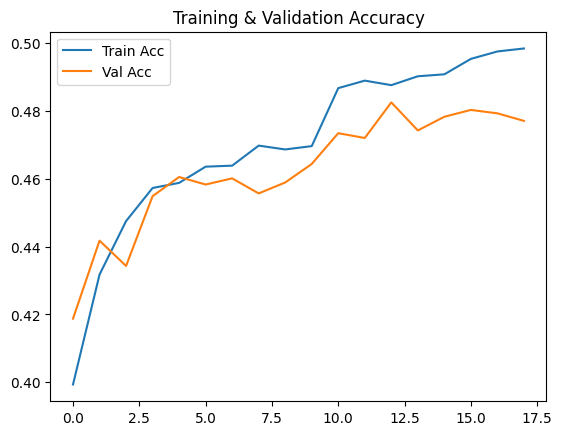

In [8]:
loss, acc = model.evaluate(test_ds)
print(f"✅ Test Accuracy: {acc*100:.2f}%")

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Training & Validation Accuracy")
plt.show()


## 📈 10: Confusion Matrix


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 754ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 750ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 768ms/step


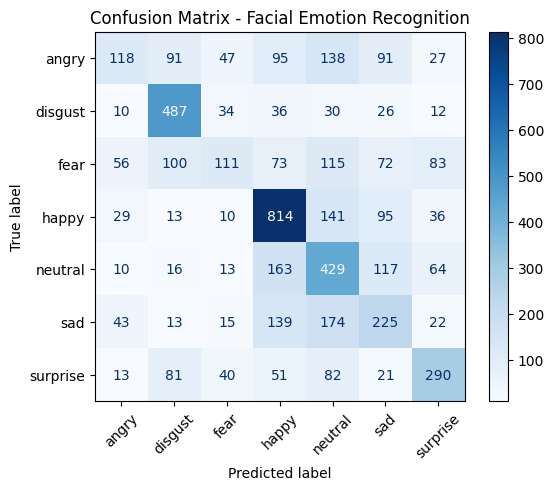

In [9]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.title("Confusion Matrix - Facial Emotion Recognition")
plt.show()
